<a href="https://colab.research.google.com/github/ddlandim/monografy-ann-demand-prediction/blob/master/experimentos_monografia/experimento_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import ModelCheckpoint
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
dataframe_mlp = pd.read_csv("https://raw.githubusercontent.com/ddlandim/monografy-ann-demand-prediction/master/experimentos_monografia/input/Todos.csv",index_col='DATA', parse_dates=True)
dataframe_mlp['SEMESTRE'] = dataframe_mlp['SEMESTRE'].astype('category')
dataframe_mlp['DIA_SEMANA'] = dataframe_mlp['DIA_SEMANA'].astype('category')

In [ ]:
dataframe_mlp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 514 entries, 2017-12-04 to 2019-12-16
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   SEMESTRE                 514 non-null    category
 1   DIA_SEMANA               514 non-null    category
 2   DISTANCIA_DIA_ANTERIOR   514 non-null    int64   
 3   DISTANCIA_DIA_POSTERIOR  514 non-null    int64   
 4   PERC_CONCLUSAO_SEM       514 non-null    float64 
 5   PERC_CONCLUSAO_MES       514 non-null    float64 
 6   VENDAS_ALMOCO            514 non-null    int64   
 7   VENDAS_ALMOCO_1          514 non-null    int64   
 8   VENDAS_ALMOCO_2          514 non-null    int64   
 9   VENDAS_ALMOCO_3          514 non-null    int64   
 10  VENDAS_ALMOCO_4          514 non-null    int64   
 11  VENDAS_ALMOCO_5          514 non-null    int64   
 12  ENTR_ALMOCO              514 non-null    int64   
 13  ENTR_ALMOCO_1            514 non-null    int64

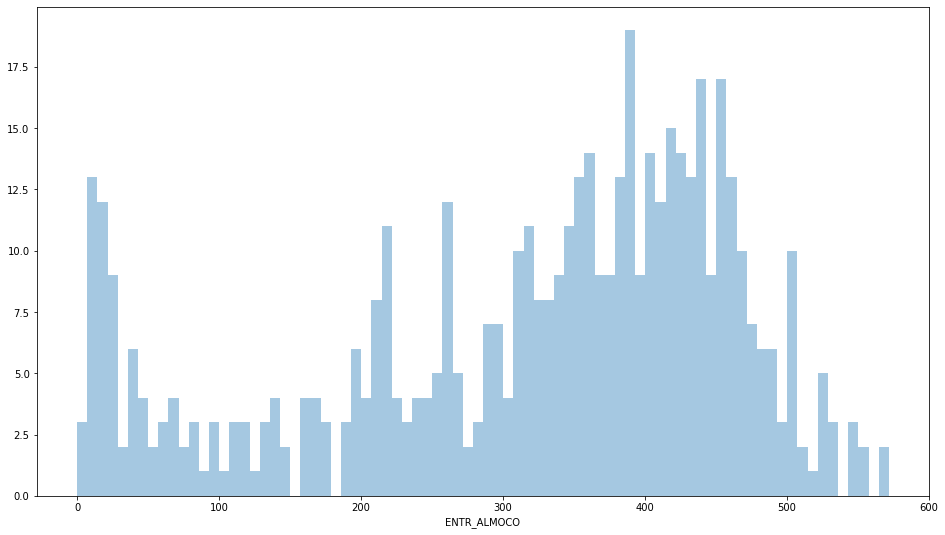

In [ ]:
plt.figure(figsize=(16,9))
sns.distplot(dataframe_mlp['ENTR_ALMOCO'],bins=80,kde=False)

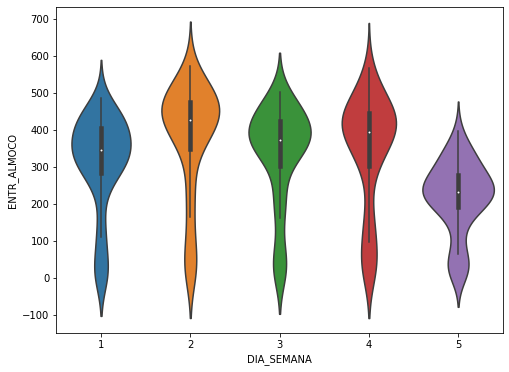

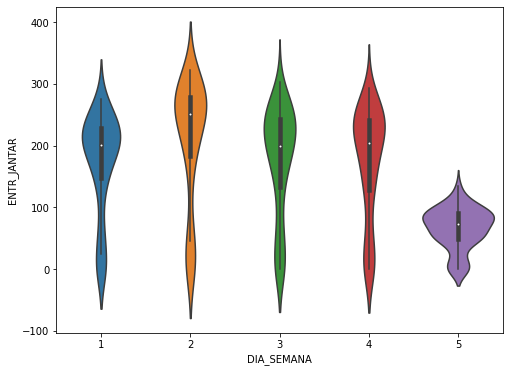

In [ ]:
plt.figure(figsize=(8,6))
sns.violinplot(x='DIA_SEMANA',y='ENTR_ALMOCO',data=dataframe_mlp)

plt.figure(figsize=(8,6))
sns.violinplot(x='DIA_SEMANA',y='ENTR_JANTAR',data=dataframe_mlp)

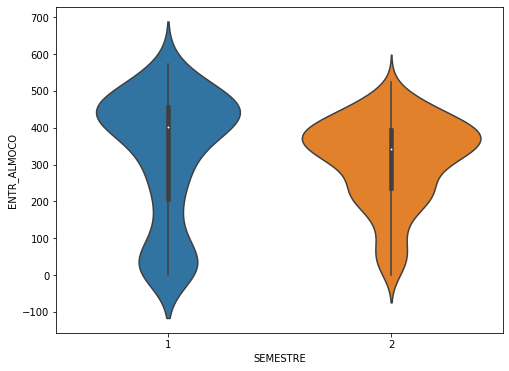

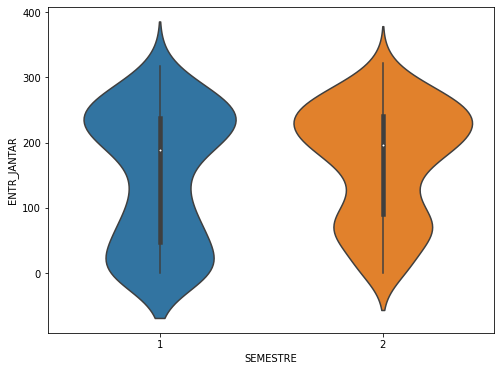

In [ ]:
plt.figure(figsize=(8,6))
sns.violinplot(x='SEMESTRE',y='ENTR_ALMOCO',data=dataframe_mlp)

plt.figure(figsize=(8,6))
sns.violinplot(x='SEMESTRE',y='ENTR_JANTAR',data=dataframe_mlp)

In [88]:
#Training with 2017(1,2),2018(2); validating 2018(1); testing 2019(1)

#setting training test
train = dataframe_mlp['2017':'2018']
train

SEMESTRE DIA_SEMANA  ...  UMIDADE  VENTO
DATA                            ...                
2017-12-04        1          3  ...       84    0.9
2017-04-13        1          4  ...       75    2.2
2017-04-17        1          1  ...       79    0.3
2017-04-18        1          2  ...       77    1.2
2017-04-19        1          3  ...       75    2.1
...             ...        ...  ...      ...    ...
2018-12-17        2          1  ...       64    4.2
2018-12-18        2          2  ...       75    3.0
2018-12-19        2          3  ...       59    2.9
2018-12-20        2          4  ...       76    1.7
2018-12-21        2          5  ...       79    1.6

[332 rows x 28 columns]

In [93]:
#setting validation test within training test
validation = dataframe_mlp['2018'].loc[dataframe_mlp['SEMESTRE'] == 1]
validation

SEMESTRE DIA_SEMANA  ...  UMIDADE  VENTO
DATA                            ...                
2018-02-26        1          1  ...       81    3.1
2018-02-27        1          2  ...       85    1.1
2018-02-28        1          3  ...       76    1.4
2018-01-03        1          4  ...       84    1.2
2018-02-03        1          5  ...       81    1.2
...             ...        ...  ...      ...    ...
2018-06-07        1          5  ...       74    0.6
2018-10-07        1          2  ...       86    2.5
2018-11-07        1          3  ...       79    0.9
2018-12-07        1          4  ...       82    2.1
2018-07-13        1          5  ...       86    1.6

[89 rows x 28 columns]

In [94]:
#removing validation from training, saving in a new dataframe
train_splited = pd.concat([train, validation, validation]).drop_duplicates(keep=False)
train_splited

SEMESTRE DIA_SEMANA  ...  UMIDADE  VENTO
DATA                            ...                
2017-12-04        1          3  ...       84    0.9
2017-04-13        1          4  ...       75    2.2
2017-04-17        1          1  ...       79    0.3
2017-04-18        1          2  ...       77    1.2
2017-04-19        1          3  ...       75    2.1
...             ...        ...  ...      ...    ...
2018-12-17        2          1  ...       64    4.2
2018-12-18        2          2  ...       75    3.0
2018-12-19        2          3  ...       59    2.9
2018-12-20        2          4  ...       76    1.7
2018-12-21        2          5  ...       79    1.6

[243 rows x 28 columns]

In [95]:
# reshaping into train and validations vector for fitting
X_train, X_validation = train_splited.drop(columns = ['ENTR_ALMOCO']), validation.drop(columns = ['ENTR_ALMOCO'])

Y_train, Y_validation = train_splited['ENTR_ALMOCO'], validation['ENTR_ALMOCO']

In [97]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler([0,1])

standardized_X_train = scaler.fit_transform(X_train)

standardized_X_validation = scaler.transform(X_validation)

In [98]:
standardized_X_train

array([[0.        , 0.5       , 0.        , ..., 0.63125   , 0.81818182,
        0.09375   ],
       [0.        , 0.75      , 0.        , ..., 0.56875   , 0.65454545,
        0.296875  ],
       [0.        , 0.        , 0.11111111, ..., 0.65      , 0.72727273,
        0.        ],
       ...,
       [1.        , 0.5       , 0.        , ..., 0.9875    , 0.36363636,
        0.40625   ],
       [1.        , 0.75      , 0.        , ..., 0.81875   , 0.67272727,
        0.21875   ],
       [1.        , 1.        , 0.        , ..., 0.78125   , 0.72727273,
        0.203125  ]])

In [99]:
standardized_X_validation

array([[ 0.        ,  0.        ,  2.51851852, ...,  0.66875   ,
         0.76363636,  0.4375    ],
       [ 0.        ,  0.25      ,  0.        , ...,  0.6375    ,
         0.83636364,  0.125     ],
       [ 0.        ,  0.5       ,  0.        , ...,  0.76875   ,
         0.67272727,  0.171875  ],
       ...,
       [ 0.        ,  0.5       ,  0.        , ..., -0.01875   ,
         0.72727273,  0.09375   ],
       [ 0.        ,  0.75      ,  0.        , ..., -0.1       ,
         0.78181818,  0.28125   ],
       [ 0.        ,  1.        ,  0.        , ..., -0.025     ,
         0.85454545,  0.203125  ]])

In [100]:
from keras import Sequential
from keras.layers import Dense
model1 = Sequential()
model1.add(Dense(standardized_X_train.shape[1],activation='relu',input_dim=standardized_X_train.shape[1]))
model1.add(Dense(1))
model1.compile(optimizer='rmsprop',
loss='mse',
metrics=['mae'])

In [ ]:
from keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(patience=2)
model.fit(standardized_X,
 y_train,
 batch_size=36,
 epochs=500,
 validation_data=(standardized_X_test,y_test),
 callbacks=[early_stopping_monitor])

Train on 148 samples, validate on 150 samples
Epoch 1/500
148/148 [==============================] - 0s 2ms/step - loss: 96012.8843 - mean_absolute_error: 266.7529 - val_loss: 159779.3769 - val_mean_absolute_error: 378.3258
Epoch 2/500
148/148 [==============================] - 0s 54us/step - loss: 95921.2984 - mean_absolute_error: 266.6102 - val_loss: 159668.9375 - val_mean_absolute_error: 378.1904
Epoch 3/500
148/148 [==============================] - 0s 68us/step - loss: 95856.0074 - mean_absolute_error: 266.5160 - val_loss: 159559.0688 - val_mean_absolute_error: 378.0576
Epoch 4/500
148/148 [==============================] - 0s 54us/step - loss: 95792.2456 - mean_absolute_error: 266.4243 - val_loss: 159479.6425 - val_mean_absolute_error: 377.9593
Epoch 5/500
148/148 [==============================] - 0s 54us/step - loss: 95737.0642 - mean_absolute_error: 266.3426 - val_loss: 159396.8381 - val_mean_absolute_error: 377.8560
Epoch 6/500
148/148 [==============================] - 0s 61

148/148 [==============================] - 0s 54us/step - loss: 88616.5465 - mean_absolute_error: 255.7040 - val_loss: 148466.9119 - val_mean_absolute_error: 364.4384
Epoch 92/500
148/148 [==============================] - 0s 54us/step - loss: 88487.4962 - mean_absolute_error: 255.5126 - val_loss: 148281.0356 - val_mean_absolute_error: 364.2084
Epoch 93/500
148/148 [==============================] - 0s 54us/step - loss: 88363.5111 - mean_absolute_error: 255.3294 - val_loss: 148071.6363 - val_mean_absolute_error: 363.9484
Epoch 94/500
148/148 [==============================] - 0s 47us/step - loss: 88230.7487 - mean_absolute_error: 255.1355 - val_loss: 147878.6769 - val_mean_absolute_error: 363.7084
Epoch 95/500
148/148 [==============================] - 0s 54us/step - loss: 88101.4994 - mean_absolute_error: 254.9438 - val_loss: 147656.2037 - val_mean_absolute_error: 363.4330
Epoch 96/500
148/148 [==============================] - 0s 47us/step - loss: 87962.1104 - mean_absolute_error: 25

148/148 [==============================] - 0s 61us/step - loss: 72880.6140 - mean_absolute_error: 231.1936 - val_loss: 123962.6875 - val_mean_absolute_error: 332.3860
Epoch 182/500
148/148 [==============================] - 0s 54us/step - loss: 72657.6810 - mean_absolute_error: 230.8223 - val_loss: 123608.6994 - val_mean_absolute_error: 331.8952
Epoch 183/500
148/148 [==============================] - 0s 61us/step - loss: 72437.1967 - mean_absolute_error: 230.4557 - val_loss: 123329.7881 - val_mean_absolute_error: 331.5065
Epoch 184/500
148/148 [==============================] - 0s 47us/step - loss: 72250.3082 - mean_absolute_error: 230.1419 - val_loss: 123024.0638 - val_mean_absolute_error: 331.0793
Epoch 185/500
148/148 [==============================] - 0s 61us/step - loss: 72049.9378 - mean_absolute_error: 229.8018 - val_loss: 122682.3419 - val_mean_absolute_error: 330.6031
Epoch 186/500
148/148 [==============================] - 0s 54us/step - loss: 71826.8108 - mean_absolute_erro

148/148 [==============================] - 0s 61us/step - loss: 50901.2471 - mean_absolute_error: 189.7852 - val_loss: 89249.9397 - val_mean_absolute_error: 279.6678
Epoch 272/500
148/148 [==============================] - 0s 68us/step - loss: 50612.1120 - mean_absolute_error: 189.1557 - val_loss: 88824.7297 - val_mean_absolute_error: 278.9513
Epoch 273/500
148/148 [==============================] - 0s 74us/step - loss: 50364.3927 - mean_absolute_error: 188.6208 - val_loss: 88391.6225 - val_mean_absolute_error: 278.2250
Epoch 274/500
148/148 [==============================] - 0s 61us/step - loss: 50102.2925 - mean_absolute_error: 188.0352 - val_loss: 88026.8572 - val_mean_absolute_error: 277.6032
Epoch 275/500
148/148 [==============================] - 0s 61us/step - loss: 49880.7242 - mean_absolute_error: 187.5395 - val_loss: 87611.9328 - val_mean_absolute_error: 276.9013
Epoch 276/500
148/148 [==============================] - 0s 68us/step - loss: 49630.8552 - mean_absolute_error: 18

148/148 [==============================] - 0s 61us/step - loss: 29639.1174 - mean_absolute_error: 133.4917 - val_loss: 53075.2069 - val_mean_absolute_error: 207.2527
Epoch 362/500
148/148 [==============================] - 0s 68us/step - loss: 29431.1216 - mean_absolute_error: 132.7956 - val_loss: 52708.2387 - val_mean_absolute_error: 206.3495
Epoch 363/500
148/148 [==============================] - 0s 81us/step - loss: 29228.7533 - mean_absolute_error: 132.0934 - val_loss: 52300.6400 - val_mean_absolute_error: 205.3800
Epoch 364/500
148/148 [==============================] - 0s 68us/step - loss: 29020.4089 - mean_absolute_error: 131.4037 - val_loss: 51903.0997 - val_mean_absolute_error: 204.3988
Epoch 365/500
148/148 [==============================] - 0s 61us/step - loss: 28804.1468 - mean_absolute_error: 130.6379 - val_loss: 51537.4022 - val_mean_absolute_error: 203.4937
Epoch 366/500
148/148 [==============================] - 0s 81us/step - loss: 28608.0776 - mean_absolute_error: 12

Epoch 452/500
148/148 [==============================] - 0s 61us/step - loss: 17325.7433 - mean_absolute_error: 81.3639 - val_loss: 28427.6698 - val_mean_absolute_error: 130.5984
Epoch 453/500
148/148 [==============================] - 0s 74us/step - loss: 17277.9448 - mean_absolute_error: 81.1044 - val_loss: 28309.2194 - val_mean_absolute_error: 130.1399
Epoch 454/500
148/148 [==============================] - 0s 88us/step - loss: 17220.0372 - mean_absolute_error: 80.8544 - val_loss: 28065.5716 - val_mean_absolute_error: 129.2020
Epoch 455/500
148/148 [==============================] - 0s 68us/step - loss: 17143.1173 - mean_absolute_error: 80.4656 - val_loss: 27938.3609 - val_mean_absolute_error: 128.7215
Epoch 456/500
148/148 [==============================] - 0s 68us/step - loss: 17089.1830 - mean_absolute_error: 80.1941 - val_loss: 27802.4176 - val_mean_absolute_error: 128.1968
Epoch 457/500
148/148 [==============================] - 0s 74us/step - loss: 17033.0985 - mean_absolute_

Epoch 498/500
148/148 [==============================] - 0s 61us/step - loss: 15331.6876 - mean_absolute_error: 73.3222 - val_loss: 23302.3327 - val_mean_absolute_error: 111.0364
Epoch 499/500
148/148 [==============================] - 0s 68us/step - loss: 15306.3831 - mean_absolute_error: 73.2463 - val_loss: 23176.7039 - val_mean_absolute_error: 110.5751
Epoch 500/500
148/148 [==============================] - 0s 68us/step - loss: 15269.9151 - mean_absolute_error: 73.1156 - val_loss: 23090.5561 - val_mean_absolute_error: 110.2872


In [ ]:
model.predict(standardized_X_test)

array([[356.67694  ],
       [334.8164   ],
       [213.55139  ],
       [ 61.401062 ],
       [ 93.80953  ],
       [ 13.748442 ],
       [ 77.527145 ],
       [  5.7739453],
       [  4.5454006],
       [125.53808  ],
       [185.27951  ],
       [297.23895  ],
       [248.47754  ],
       [295.7359   ],
       [328.34442  ],
       [417.6278   ],
       [295.7802   ],
       [219.14932  ],
       [379.70953  ],
       [363.6162   ],
       [431.11017  ],
       [310.7514   ],
       [230.13522  ],
       [393.7862   ],
       [376.3924   ],
       [411.95154  ],
       [343.10272  ],
       [210.76778  ],
       [354.75452  ],
       [353.02606  ],
       [412.63916  ],
       [288.5752   ],
       [263.1189   ],
       [447.69098  ],
       [394.966    ],
       [436.76733  ],
       [327.92926  ],
       [344.56372  ],
       [314.35217  ],
       [436.64545  ],
       [359.35266  ],
       [303.88733  ],
       [469.86853  ],
       [424.3595   ],
       [463.28796  ],
       [34

In [ ]:
score = model.evaluate(standardized_X_test,
y_test,
batch_size=36)

150/150 [==============================] - 0s 33us/step


In [ ]:
score

[23090.5561328125, 110.28715209960937]

In [ ]:
model.fit(standardized_X,
 y_train,
 batch_size=36,
 epochs=1000,
 validation_data=(standardized_X_test,y_test),
 callbacks=[early_stopping_monitor])

Train on 148 samples, validate on 150 samples
Epoch 1/1000
148/148 [==============================] - 0s 74us/step - loss: 15238.3143 - mean_absolute_error: 73.0162 - val_loss: 23003.1161 - val_mean_absolute_error: 109.9772
Epoch 2/1000
148/148 [==============================] - 0s 88us/step - loss: 15205.3869 - mean_absolute_error: 72.8931 - val_loss: 22970.8571 - val_mean_absolute_error: 109.8824
Epoch 3/1000
148/148 [==============================] - 0s 61us/step - loss: 15184.2459 - mean_absolute_error: 72.8295 - val_loss: 22869.7102 - val_mean_absolute_error: 109.5097
Epoch 4/1000
148/148 [==============================] - 0s 68us/step - loss: 15149.9724 - mean_absolute_error: 72.7003 - val_loss: 22780.9672 - val_mean_absolute_error: 109.1906
Epoch 5/1000
148/148 [==============================] - 0s 68us/step - loss: 15119.1181 - mean_absolute_error: 72.5917 - val_loss: 22725.8346 - val_mean_absolute_error: 108.9941
Epoch 6/1000
148/148 [==============================] - 0s 81us/

Epoch 92/1000
148/148 [==============================] - 0s 68us/step - loss: 13111.8093 - mean_absolute_error: 67.1341 - val_loss: 19365.0816 - val_mean_absolute_error: 98.6225
Epoch 93/1000
148/148 [==============================] - 0s 74us/step - loss: 13092.1879 - mean_absolute_error: 67.0894 - val_loss: 19325.5521 - val_mean_absolute_error: 98.4950
Epoch 94/1000
148/148 [==============================] - 0s 61us/step - loss: 13067.7050 - mean_absolute_error: 67.0413 - val_loss: 19313.6914 - val_mean_absolute_error: 98.5045
Epoch 95/1000
148/148 [==============================] - 0s 74us/step - loss: 13049.5965 - mean_absolute_error: 66.9988 - val_loss: 19296.8301 - val_mean_absolute_error: 98.5025
Epoch 96/1000
148/148 [==============================] - 0s 68us/step - loss: 13026.1003 - mean_absolute_error: 66.9287 - val_loss: 19263.8598 - val_mean_absolute_error: 98.4077
Epoch 97/1000
148/148 [==============================] - 0s 88us/step - loss: 13006.8043 - mean_absolute_error

Epoch 183/1000
148/148 [==============================] - 0s 61us/step - loss: 11357.3532 - mean_absolute_error: 63.9317 - val_loss: 16719.8570 - val_mean_absolute_error: 89.8129
Epoch 184/1000
148/148 [==============================] - 0s 74us/step - loss: 11331.0195 - mean_absolute_error: 63.8965 - val_loss: 16714.7664 - val_mean_absolute_error: 89.8353
Epoch 185/1000
148/148 [==============================] - 0s 61us/step - loss: 11317.9446 - mean_absolute_error: 63.8655 - val_loss: 16680.7298 - val_mean_absolute_error: 89.6930
Epoch 186/1000
148/148 [==============================] - 0s 74us/step - loss: 11297.3519 - mean_absolute_error: 63.8386 - val_loss: 16677.9786 - val_mean_absolute_error: 89.7393
Epoch 187/1000
148/148 [==============================] - 0s 68us/step - loss: 11282.2844 - mean_absolute_error: 63.8108 - val_loss: 16651.7797 - val_mean_absolute_error: 89.6294
Epoch 188/1000
148/148 [==============================] - 0s 61us/step - loss: 11264.3654 - mean_absolute

Epoch 229/1000
148/148 [==============================] - 0s 68us/step - loss: 10559.0158 - mean_absolute_error: 62.5851 - val_loss: 15653.5772 - val_mean_absolute_error: 85.8724
Epoch 230/1000
148/148 [==============================] - 0s 74us/step - loss: 10546.8719 - mean_absolute_error: 62.5545 - val_loss: 15635.6362 - val_mean_absolute_error: 85.8323
Epoch 231/1000
148/148 [==============================] - 0s 61us/step - loss: 10525.3045 - mean_absolute_error: 62.5229 - val_loss: 15613.2899 - val_mean_absolute_error: 85.7643
Epoch 232/1000
148/148 [==============================] - 0s 68us/step - loss: 10505.4213 - mean_absolute_error: 62.4780 - val_loss: 15562.2650 - val_mean_absolute_error: 85.5038
Epoch 233/1000
148/148 [==============================] - 0s 74us/step - loss: 10481.7706 - mean_absolute_error: 62.4353 - val_loss: 15525.8568 - val_mean_absolute_error: 85.2990
Epoch 234/1000
148/148 [==============================] - 0s 81us/step - loss: 10464.5807 - mean_absolute

148/148 [==============================] - 0s 61us/step - loss: 8999.8274 - mean_absolute_error: 59.9626 - val_loss: 13741.7441 - val_mean_absolute_error: 78.6214
Epoch 321/1000
148/148 [==============================] - 0s 68us/step - loss: 8981.2738 - mean_absolute_error: 59.9260 - val_loss: 13723.5725 - val_mean_absolute_error: 78.5619
Epoch 322/1000
148/148 [==============================] - 0s 68us/step - loss: 8966.3386 - mean_absolute_error: 59.8958 - val_loss: 13702.0321 - val_mean_absolute_error: 78.4476
Epoch 323/1000
148/148 [==============================] - 0s 61us/step - loss: 8950.5075 - mean_absolute_error: 59.8810 - val_loss: 13702.0703 - val_mean_absolute_error: 78.5324
Epoch 324/1000
148/148 [==============================] - 0s 61us/step - loss: 8932.6088 - mean_absolute_error: 59.8382 - val_loss: 13686.9500 - val_mean_absolute_error: 78.4930
Epoch 325/1000
148/148 [==============================] - 0s 68us/step - loss: 8919.4818 - mean_absolute_error: 59.8364 - val

148/148 [==============================] - 0s 68us/step - loss: 7668.1089 - mean_absolute_error: 57.7453 - val_loss: 12174.8508 - val_mean_absolute_error: 72.2892
Epoch 413/1000
148/148 [==============================] - 0s 68us/step - loss: 7657.2165 - mean_absolute_error: 57.7147 - val_loss: 12165.8376 - val_mean_absolute_error: 72.2849
Epoch 414/1000
148/148 [==============================] - 0s 61us/step - loss: 7641.2450 - mean_absolute_error: 57.7079 - val_loss: 12150.2924 - val_mean_absolute_error: 72.2353
Epoch 415/1000
148/148 [==============================] - 0s 74us/step - loss: 7628.0766 - mean_absolute_error: 57.6865 - val_loss: 12124.7831 - val_mean_absolute_error: 72.1280
Epoch 416/1000
148/148 [==============================] - 0s 68us/step - loss: 7615.3520 - mean_absolute_error: 57.6597 - val_loss: 12112.6806 - val_mean_absolute_error: 72.1068
Epoch 417/1000
148/148 [==============================] - 0s 68us/step - loss: 7599.9161 - mean_absolute_error: 57.6243 - val

148/148 [==============================] - 0s 68us/step - loss: 6729.6974 - mean_absolute_error: 56.0519 - val_loss: 11021.7032 - val_mean_absolute_error: 68.0347
Epoch 505/1000
148/148 [==============================] - 0s 61us/step - loss: 6725.4000 - mean_absolute_error: 56.0439 - val_loss: 11020.1565 - val_mean_absolute_error: 68.0484
Epoch 506/1000
148/148 [==============================] - 0s 68us/step - loss: 6721.4076 - mean_absolute_error: 56.0580 - val_loss: 11017.9018 - val_mean_absolute_error: 68.0868
Epoch 507/1000
148/148 [==============================] - 0s 68us/step - loss: 6716.8715 - mean_absolute_error: 56.0443 - val_loss: 11012.7951 - val_mean_absolute_error: 68.0603
Epoch 508/1000
148/148 [==============================] - 0s 68us/step - loss: 6711.0954 - mean_absolute_error: 56.0296 - val_loss: 10997.8735 - val_mean_absolute_error: 68.0077
Epoch 509/1000
148/148 [==============================] - 0s 74us/step - loss: 6700.8391 - mean_absolute_error: 55.9967 - val

In [ ]:
model.predict(standardized_X_test)

array([[361.44812  ],
       [398.81897  ],
       [329.46628  ],
       [161.16385  ],
       [268.28925  ],
       [141.00296  ],
       [243.71985  ],
       [ 60.6498   ],
       [ 34.428402 ],
       [ 78.37089  ],
       [ 94.955055 ],
       [313.53622  ],
       [385.27502  ],
       [331.54047  ],
       [324.6779   ],
       [396.26465  ],
       [337.27676  ],
       [274.66     ],
       [426.37228  ],
       [362.78488  ],
       [424.7492   ],
       [338.52588  ],
       [261.7495   ],
       [423.11633  ],
       [367.67554  ],
       [426.38843  ],
       [349.34424  ],
       [214.75569  ],
       [367.8341   ],
       [320.27798  ],
       [402.56863  ],
       [315.40527  ],
       [239.70274  ],
       [416.5072   ],
       [383.73132  ],
       [470.3406   ],
       [400.7104   ],
       [329.72302  ],
       [313.2915   ],
       [435.3791   ],
       [351.1565   ],
       [285.00055  ],
       [443.50204  ],
       [398.8614   ],
       [437.66592  ],
       [34

In [ ]:
score = model.evaluate(standardized_X_test,
y_test,
batch_size=36)

150/150 [==============================] - 0s 33us/step


In [ ]:
score

[10521.06603515625, 66.23059051513673]

In [ ]:
model.fit(standardized_X,
 y_train,
 batch_size=36,
 epochs=250,
 validation_data=(standardized_X_test,y_test),
 callbacks=[early_stopping_monitor])

Train on 148 samples, validate on 150 samples
Epoch 1/250
148/148 [==============================] - 0s 74us/step - loss: 6288.6532 - mean_absolute_error: 55.1407 - val_loss: 10516.7029 - val_mean_absolute_error: 66.1825
Epoch 2/250
148/148 [==============================] - 0s 68us/step - loss: 6284.2438 - mean_absolute_error: 55.1076 - val_loss: 10505.1787 - val_mean_absolute_error: 66.1586
Epoch 3/250
148/148 [==============================] - 0s 61us/step - loss: 6278.4607 - mean_absolute_error: 55.1254 - val_loss: 10500.3504 - val_mean_absolute_error: 66.1503
Epoch 4/250
148/148 [==============================] - 0s 68us/step - loss: 6274.3724 - mean_absolute_error: 55.1037 - val_loss: 10495.7181 - val_mean_absolute_error: 66.1710
Epoch 5/250
148/148 [==============================] - 0s 88us/step - loss: 6270.7043 - mean_absolute_error: 55.1049 - val_loss: 10491.7734 - val_mean_absolute_error: 66.1539
Epoch 6/250
148/148 [==============================] - 0s 95us/step - loss: 626

In [ ]:
model.predict(standardized_X_test)

array([[360.38364 ],
       [399.41354 ],
       [331.75775 ],
       [162.9254  ],
       [270.2953  ],
       [141.98132 ],
       [246.11256 ],
       [ 62.86857 ],
       [ 35.66449 ],
       [ 77.88453 ],
       [ 93.20477 ],
       [313.5562  ],
       [387.68906 ],
       [331.63406 ],
       [323.4221  ],
       [396.34567 ],
       [338.50406 ],
       [276.16666 ],
       [426.59894 ],
       [361.65796 ],
       [425.10794 ],
       [339.48154 ],
       [262.95016 ],
       [423.3016  ],
       [366.43344 ],
       [426.68195 ],
       [350.16028 ],
       [217.77396 ],
       [369.43347 ],
       [320.77194 ],
       [404.2289  ],
       [317.84375 ],
       [242.27652 ],
       [417.15463 ],
       [384.01596 ],
       [472.1934  ],
       [403.66473 ],
       [330.7805  ],
       [313.33966 ],
       [436.91983 ],
       [353.1169  ],
       [287.91928 ],
       [445.2389  ],
       [398.56305 ],
       [439.26797 ],
       [347.10086 ],
       [325.227   ],
       [446.2

In [ ]:
score = model.evaluate(standardized_X_test,
y_test,
batch_size=36)

150/150 [==============================] - 0s 27us/step


In [ ]:
score

[10454.5605859375, 65.94335220336914]

In [ ]:
print(model.metrics_names)

['loss', 'mean_absolute_error']


In [ ]:
model.fit(standardized_X,
 y_train,
 batch_size=36,
 epochs=125,
 validation_data=(standardized_X_test,y_test),
 callbacks=[early_stopping_monitor])

Train on 148 samples, validate on 150 samples
Epoch 1/125
148/148 [==============================] - 0s 81us/step - loss: 6229.2614 - mean_absolute_error: 54.9703 - val_loss: 10455.0655 - val_mean_absolute_error: 65.9401
Epoch 2/125
148/148 [==============================] - 0s 68us/step - loss: 6226.1583 - mean_absolute_error: 54.9706 - val_loss: 10444.3331 - val_mean_absolute_error: 65.8262
Epoch 3/125
148/148 [==============================] - 0s 81us/step - loss: 6220.3866 - mean_absolute_error: 54.9489 - val_loss: 10442.2778 - val_mean_absolute_error: 65.8450
Epoch 4/125
148/148 [==============================] - 0s 61us/step - loss: 6218.2945 - mean_absolute_error: 54.9447 - val_loss: 10432.9061 - val_mean_absolute_error: 65.7982
Epoch 5/125
148/148 [==============================] - 0s 54us/step - loss: 6213.8065 - mean_absolute_error: 54.9468 - val_loss: 10419.4121 - val_mean_absolute_error: 65.7082
Epoch 6/125
148/148 [==============================] - 0s 61us/step - loss: 620

In [ ]:
model.predict(standardized_X_test)

array([[361.4432  ],
       [398.83963 ],
       [333.76642 ],
       [165.30312 ],
       [273.1696  ],
       [144.64984 ],
       [250.2568  ],
       [ 66.75224 ],
       [ 37.008053],
       [ 79.09472 ],
       [ 93.144745],
       [311.44043 ],
       [390.38678 ],
       [330.98227 ],
       [323.8264  ],
       [394.5074  ],
       [338.76852 ],
       [275.3169  ],
       [426.1859  ],
       [362.72644 ],
       [424.13934 ],
       [340.15778 ],
       [262.38055 ],
       [423.94    ],
       [367.3291  ],
       [424.9674  ],
       [352.31876 ],
       [219.06917 ],
       [369.16    ],
       [321.3425  ],
       [401.55276 ],
       [317.3854  ],
       [240.67928 ],
       [415.69864 ],
       [382.47964 ],
       [469.89642 ],
       [404.972   ],
       [329.2116  ],
       [310.61166 ],
       [432.39166 ],
       [353.15848 ],
       [288.98816 ],
       [445.64697 ],
       [397.18277 ],
       [436.23477 ],
       [345.12946 ],
       [325.43268 ],
       [445.4

In [ ]:
score = model.evaluate(standardized_X_test,
y_test,
batch_size=36)

150/150 [==============================] - 0s 40us/step


In [ ]:
score

[10366.573818359375, 65.68097579956054]

In [ ]:
model.fit(standardized_X,
 y_train,
 batch_size=36,
 epochs=50,
 validation_data=(standardized_X_test,y_test),
 callbacks=[early_stopping_monitor])

Train on 148 samples, validate on 150 samples
Epoch 1/50
148/148 [==============================] - 0s 74us/step - loss: 6145.8438 - mean_absolute_error: 54.8163 - val_loss: 10365.5118 - val_mean_absolute_error: 65.7185
Epoch 2/50
148/148 [==============================] - 0s 74us/step - loss: 6146.5127 - mean_absolute_error: 54.8365 - val_loss: 10354.8563 - val_mean_absolute_error: 65.6778
Epoch 3/50
148/148 [==============================] - 0s 68us/step - loss: 6138.3694 - mean_absolute_error: 54.8024 - val_loss: 10363.8930 - val_mean_absolute_error: 65.7743
Epoch 4/50
148/148 [==============================] - 0s 74us/step - loss: 6135.1743 - mean_absolute_error: 54.7635 - val_loss: 10360.9733 - val_mean_absolute_error: 65.8165


In [ ]:
model.predict(standardized_X_test)

array([[360.94803  ],
       [398.76068  ],
       [334.23364  ],
       [165.51076  ],
       [273.74216  ],
       [145.29547  ],
       [251.12712  ],
       [ 67.43168  ],
       [ 37.352345 ],
       [ 79.052986 ],
       [ 93.027176 ],
       [311.35712  ],
       [390.72296  ],
       [330.74316  ],
       [323.38675  ],
       [394.289    ],
       [338.7602   ],
       [275.28342  ],
       [425.7688   ],
       [362.2027   ],
       [423.92853  ],
       [340.0536   ],
       [262.2283   ],
       [423.43573  ],
       [366.74164  ],
       [424.7636   ],
       [352.08057  ],
       [219.0315   ],
       [368.66306  ],
       [320.75583  ],
       [401.26025  ],
       [317.25842  ],
       [240.56267  ],
       [414.68167  ],
       [381.80447  ],
       [469.4565   ],
       [404.82214  ],
       [328.6112   ],
       [310.13074  ],
       [432.11783  ],
       [352.73035  ],
       [288.76184  ],
       [444.91226  ],
       [396.25537  ],
       [435.83936  ],
       [34

In [ ]:
score = model.evaluate(standardized_X_test,
y_test,
batch_size=36)

150/150 [==============================] - 0s 33us/step


In [ ]:
score

[10360.97330078125, 65.81646881103515]

In [ ]:
model = Sequential()
model.add(Dense(standardized_X.shape[1],activation='sigmoid',input_dim=standardized_X.shape[1]))
model.add(Dense(1))
model.compile(optimizer='rmsprop',
loss='mse',
metrics=['mae'])

In [ ]:
model.fit(standardized_X,
 y_train,
 batch_size=36,
 epochs=125,
 validation_data=(standardized_X_test,y_test),
 callbacks=[early_stopping_monitor])

Train on 148 samples, validate on 150 samples
Epoch 1/125
148/148 [==============================] - 0s 1ms/step - loss: 96039.7016 - mean_absolute_error: 266.5323 - val_loss: 160210.6794 - val_mean_absolute_error: 378.7390
Epoch 2/125
148/148 [==============================] - 0s 74us/step - loss: 95979.4041 - mean_absolute_error: 266.4368 - val_loss: 160135.0675 - val_mean_absolute_error: 378.6449
Epoch 3/125
148/148 [==============================] - 0s 61us/step - loss: 95932.7730 - mean_absolute_error: 266.3648 - val_loss: 160077.5406 - val_mean_absolute_error: 378.5733
Epoch 4/125
148/148 [==============================] - 0s 74us/step - loss: 95894.3917 - mean_absolute_error: 266.3044 - val_loss: 160021.7825 - val_mean_absolute_error: 378.5042
Epoch 5/125
148/148 [==============================] - 0s 74us/step - loss: 95857.2135 - mean_absolute_error: 266.2473 - val_loss: 159975.2475 - val_mean_absolute_error: 378.4457
Epoch 6/125
148/148 [==============================] - 0s 81

148/148 [==============================] - 0s 101us/step - loss: 92592.4238 - mean_absolute_error: 261.1774 - val_loss: 155075.4544 - val_mean_absolute_error: 372.2857
Epoch 92/125
148/148 [==============================] - 0s 95us/step - loss: 92553.6510 - mean_absolute_error: 261.1170 - val_loss: 155019.4869 - val_mean_absolute_error: 372.2143
Epoch 93/125
148/148 [==============================] - 0s 115us/step - loss: 92514.5595 - mean_absolute_error: 261.0547 - val_loss: 154958.1631 - val_mean_absolute_error: 372.1367
Epoch 94/125
148/148 [==============================] - 0s 128us/step - loss: 92474.1649 - mean_absolute_error: 260.9922 - val_loss: 154894.7462 - val_mean_absolute_error: 372.0559
Epoch 95/125
148/148 [==============================] - 0s 108us/step - loss: 92432.4284 - mean_absolute_error: 260.9275 - val_loss: 154837.8419 - val_mean_absolute_error: 371.9834
Epoch 96/125
148/148 [==============================] - 0s 95us/step - loss: 92393.7042 - mean_absolute_error

In [ ]:
model.fit(standardized_X,
 y_train,
 batch_size=36,
 epochs=500,
 validation_data=(standardized_X_test,y_test),
 callbacks=[early_stopping_monitor])

Train on 148 samples, validate on 150 samples
Epoch 1/500
148/148 [==============================] - 0s 88us/step - loss: 91162.7251 - mean_absolute_error: 258.9451 - val_loss: 152920.0250 - val_mean_absolute_error: 369.5322
Epoch 2/500
148/148 [==============================] - 0s 68us/step - loss: 91119.8241 - mean_absolute_error: 258.8780 - val_loss: 152860.3637 - val_mean_absolute_error: 369.4555
Epoch 3/500
148/148 [==============================] - 0s 95us/step - loss: 91080.3539 - mean_absolute_error: 258.8163 - val_loss: 152800.4250 - val_mean_absolute_error: 369.3786
Epoch 4/500
148/148 [==============================] - 0s 74us/step - loss: 91040.4973 - mean_absolute_error: 258.7534 - val_loss: 152740.2687 - val_mean_absolute_error: 369.3016
Epoch 5/500
148/148 [==============================] - 0s 81us/step - loss: 91000.2111 - mean_absolute_error: 258.6894 - val_loss: 152675.5638 - val_mean_absolute_error: 369.2190
Epoch 6/500
148/148 [==============================] - 0s 8

148/148 [==============================] - 0s 135us/step - loss: 87246.5557 - mean_absolute_error: 252.8785 - val_loss: 146964.7369 - val_mean_absolute_error: 361.8400
Epoch 92/500
148/148 [==============================] - 0s 142us/step - loss: 87199.2705 - mean_absolute_error: 252.8049 - val_loss: 146893.9056 - val_mean_absolute_error: 361.7477
Epoch 93/500
148/148 [==============================] - 0s 122us/step - loss: 87153.0743 - mean_absolute_error: 252.7346 - val_loss: 146826.6187 - val_mean_absolute_error: 361.6600
Epoch 94/500
148/148 [==============================] - 0s 115us/step - loss: 87108.4348 - mean_absolute_error: 252.6639 - val_loss: 146757.6350 - val_mean_absolute_error: 361.5694
Epoch 95/500
148/148 [==============================] - 0s 128us/step - loss: 87063.1284 - mean_absolute_error: 252.5947 - val_loss: 146687.3894 - val_mean_absolute_error: 361.4775
Epoch 96/500
148/148 [==============================] - 0s 101us/step - loss: 87017.4008 - mean_absolute_err

148/148 [==============================] - 0s 101us/step - loss: 83177.3452 - mean_absolute_error: 246.4341 - val_loss: 140803.4519 - val_mean_absolute_error: 353.6781
Epoch 182/500
148/148 [==============================] - 0s 108us/step - loss: 83130.0328 - mean_absolute_error: 246.3559 - val_loss: 140740.9750 - val_mean_absolute_error: 353.5950
Epoch 183/500
148/148 [==============================] - 0s 101us/step - loss: 83089.3976 - mean_absolute_error: 246.2893 - val_loss: 140678.2719 - val_mean_absolute_error: 353.5102
Epoch 184/500
148/148 [==============================] - 0s 101us/step - loss: 83047.1258 - mean_absolute_error: 246.2225 - val_loss: 140606.6894 - val_mean_absolute_error: 353.4130
Epoch 185/500
148/148 [==============================] - 0s 122us/step - loss: 82998.9677 - mean_absolute_error: 246.1402 - val_loss: 140535.8394 - val_mean_absolute_error: 353.3171
Epoch 186/500
148/148 [==============================] - 0s 88us/step - loss: 82952.9231 - mean_absolute

Epoch 271/500
148/148 [==============================] - 0s 88us/step - loss: 79174.5247 - mean_absolute_error: 239.6760 - val_loss: 134878.5963 - val_mean_absolute_error: 345.5674
Epoch 272/500
148/148 [==============================] - 0s 88us/step - loss: 79128.6446 - mean_absolute_error: 239.5906 - val_loss: 134808.0650 - val_mean_absolute_error: 345.4710
Epoch 273/500
148/148 [==============================] - 0s 95us/step - loss: 79079.7914 - mean_absolute_error: 239.5028 - val_loss: 134751.3981 - val_mean_absolute_error: 345.3925
Epoch 274/500
148/148 [==============================] - 0s 74us/step - loss: 79039.7460 - mean_absolute_error: 239.4294 - val_loss: 134682.3525 - val_mean_absolute_error: 345.2971
Epoch 275/500
148/148 [==============================] - 0s 74us/step - loss: 78991.5157 - mean_absolute_error: 239.3411 - val_loss: 134617.5756 - val_mean_absolute_error: 345.2077
Epoch 276/500
148/148 [==============================] - 0s 88us/step - loss: 78947.9800 - mean

148/148 [==============================] - 0s 108us/step - loss: 75148.4797 - mean_absolute_error: 231.6864 - val_loss: 129164.3362 - val_mean_absolute_error: 337.5470
Epoch 362/500
148/148 [==============================] - 0s 149us/step - loss: 75099.7217 - mean_absolute_error: 231.5906 - val_loss: 129102.5737 - val_mean_absolute_error: 337.4586
Epoch 363/500
148/148 [==============================] - 0s 108us/step - loss: 75055.1740 - mean_absolute_error: 231.4973 - val_loss: 129040.9081 - val_mean_absolute_error: 337.3694
Epoch 364/500
148/148 [==============================] - 0s 122us/step - loss: 75011.4065 - mean_absolute_error: 231.4145 - val_loss: 128982.9756 - val_mean_absolute_error: 337.2855
Epoch 365/500
148/148 [==============================] - 0s 162us/step - loss: 74966.1695 - mean_absolute_error: 231.3149 - val_loss: 128925.9669 - val_mean_absolute_error: 337.2046
Epoch 366/500
148/148 [==============================] - 0s 169us/step - loss: 74926.3656 - mean_absolut

Epoch 406/500
148/148 [==============================] - 0s 128us/step - loss: 73139.6401 - mean_absolute_error: 227.7907 - val_loss: 126369.3638 - val_mean_absolute_error: 333.5242
Epoch 407/500
148/148 [==============================] - 0s 128us/step - loss: 73095.8418 - mean_absolute_error: 227.7153 - val_loss: 126310.6200 - val_mean_absolute_error: 333.4389
Epoch 408/500
148/148 [==============================] - 0s 122us/step - loss: 73050.9165 - mean_absolute_error: 227.6413 - val_loss: 126248.5856 - val_mean_absolute_error: 333.3491
Epoch 409/500
148/148 [==============================] - 0s 142us/step - loss: 73007.7057 - mean_absolute_error: 227.5690 - val_loss: 126187.6519 - val_mean_absolute_error: 333.2611
Epoch 410/500
148/148 [==============================] - 0s 122us/step - loss: 72965.3216 - mean_absolute_error: 227.5021 - val_loss: 126129.9162 - val_mean_absolute_error: 333.1774
Epoch 411/500
148/148 [==============================] - 0s 95us/step - loss: 72923.5992 -

148/148 [==============================] - 0s 115us/step - loss: 71171.7663 - mean_absolute_error: 224.6605 - val_loss: 123612.9037 - val_mean_absolute_error: 329.5049
Epoch 452/500
148/148 [==============================] - 0s 101us/step - loss: 71130.7924 - mean_absolute_error: 224.5993 - val_loss: 123546.9669 - val_mean_absolute_error: 329.4086
Epoch 453/500
148/148 [==============================] - 0s 115us/step - loss: 71085.2452 - mean_absolute_error: 224.5193 - val_loss: 123487.0875 - val_mean_absolute_error: 329.3206
Epoch 454/500
148/148 [==============================] - 0s 95us/step - loss: 71040.3201 - mean_absolute_error: 224.4552 - val_loss: 123432.9700 - val_mean_absolute_error: 329.2392
Epoch 455/500
148/148 [==============================] - 0s 108us/step - loss: 71000.5223 - mean_absolute_error: 224.3991 - val_loss: 123371.7737 - val_mean_absolute_error: 329.1495
Epoch 456/500
148/148 [==============================] - 0s 115us/step - loss: 70957.9481 - mean_absolute

In [ ]:
model.fit(standardized_X,
 y_train,
 batch_size=36,
 epochs=1000,
 validation_data=(standardized_X_test,y_test),
 callbacks=[early_stopping_monitor])

Train on 148 samples, validate on 150 samples
Epoch 1/1000
148/148 [==============================] - 0s 128us/step - loss: 69034.7498 - mean_absolute_error: 221.2956 - val_loss: 120548.4812 - val_mean_absolute_error: 324.9707
Epoch 2/1000
148/148 [==============================] - 0s 101us/step - loss: 68991.6699 - mean_absolute_error: 221.2550 - val_loss: 120484.7663 - val_mean_absolute_error: 324.8771
Epoch 3/1000
148/148 [==============================] - 0s 115us/step - loss: 68949.8650 - mean_absolute_error: 221.1822 - val_loss: 120430.0988 - val_mean_absolute_error: 324.7941
Epoch 4/1000
148/148 [==============================] - 0s 115us/step - loss: 68910.2633 - mean_absolute_error: 221.1436 - val_loss: 120372.5538 - val_mean_absolute_error: 324.7089
Epoch 5/1000
148/148 [==============================] - 0s 88us/step - loss: 68870.4064 - mean_absolute_error: 221.0780 - val_loss: 120305.7594 - val_mean_absolute_error: 324.6105
Epoch 6/1000
148/148 [============================

Epoch 46/1000
148/148 [==============================] - 0s 74us/step - loss: 67169.0324 - mean_absolute_error: 218.4690 - val_loss: 117807.3200 - val_mean_absolute_error: 320.9604
Epoch 47/1000
148/148 [==============================] - 0s 95us/step - loss: 67127.3682 - mean_absolute_error: 218.3941 - val_loss: 117754.0119 - val_mean_absolute_error: 320.8829
Epoch 48/1000
148/148 [==============================] - 0s 81us/step - loss: 67091.4938 - mean_absolute_error: 218.3317 - val_loss: 117696.4825 - val_mean_absolute_error: 320.7994
Epoch 49/1000
148/148 [==============================] - 0s 68us/step - loss: 67052.7868 - mean_absolute_error: 218.2663 - val_loss: 117634.0688 - val_mean_absolute_error: 320.7088
Epoch 50/1000
148/148 [==============================] - 0s 74us/step - loss: 67010.6117 - mean_absolute_error: 218.2032 - val_loss: 117573.1181 - val_mean_absolute_error: 320.6205
Epoch 51/1000
148/148 [==============================] - 0s 74us/step - loss: 66970.1769 - mean

148/148 [==============================] - 0s 61us/step - loss: 63629.1514 - mean_absolute_error: 212.8548 - val_loss: 112521.1875 - val_mean_absolute_error: 313.1832
Epoch 137/1000
148/148 [==============================] - 0s 74us/step - loss: 63592.1135 - mean_absolute_error: 212.7995 - val_loss: 112462.5287 - val_mean_absolute_error: 313.0956
Epoch 138/1000
148/148 [==============================] - 0s 74us/step - loss: 63553.6680 - mean_absolute_error: 212.7239 - val_loss: 112398.5163 - val_mean_absolute_error: 313.0001
Epoch 139/1000
148/148 [==============================] - 0s 61us/step - loss: 63511.3791 - mean_absolute_error: 212.6517 - val_loss: 112337.9219 - val_mean_absolute_error: 312.9096
Epoch 140/1000
148/148 [==============================] - 0s 68us/step - loss: 63472.1950 - mean_absolute_error: 212.5743 - val_loss: 112278.4312 - val_mean_absolute_error: 312.8211
Epoch 141/1000
148/148 [==============================] - 0s 61us/step - loss: 63432.4435 - mean_absolute

148/148 [==============================] - 0s 95us/step - loss: 60250.1253 - mean_absolute_error: 207.2387 - val_loss: 107380.8175 - val_mean_absolute_error: 305.5892
Epoch 227/1000
148/148 [==============================] - 0s 88us/step - loss: 60217.6911 - mean_absolute_error: 207.1728 - val_loss: 107319.5394 - val_mean_absolute_error: 305.4980
Epoch 228/1000
148/148 [==============================] - 0s 74us/step - loss: 60178.9123 - mean_absolute_error: 207.0935 - val_loss: 107255.0087 - val_mean_absolute_error: 305.4016
Epoch 229/1000
148/148 [==============================] - 0s 95us/step - loss: 60138.2570 - mean_absolute_error: 207.0468 - val_loss: 107202.0769 - val_mean_absolute_error: 305.3229
Epoch 230/1000
148/148 [==============================] - 0s 95us/step - loss: 60104.0127 - mean_absolute_error: 206.9570 - val_loss: 107148.1050 - val_mean_absolute_error: 305.2423
Epoch 231/1000
148/148 [==============================] - 0s 128us/step - loss: 60067.6249 - mean_absolut

148/148 [==============================] - 0s 68us/step - loss: 58623.3587 - mean_absolute_error: 204.6142 - val_loss: 104872.1788 - val_mean_absolute_error: 301.8312
Epoch 272/1000
148/148 [==============================] - 0s 88us/step - loss: 58586.3817 - mean_absolute_error: 204.5432 - val_loss: 104815.9647 - val_mean_absolute_error: 301.7461
Epoch 273/1000
148/148 [==============================] - 0s 68us/step - loss: 58549.9525 - mean_absolute_error: 204.4691 - val_loss: 104761.8497 - val_mean_absolute_error: 301.6639
Epoch 274/1000
148/148 [==============================] - 0s 61us/step - loss: 58514.4004 - mean_absolute_error: 204.3847 - val_loss: 104707.5794 - val_mean_absolute_error: 301.5809
Epoch 275/1000
148/148 [==============================] - 0s 68us/step - loss: 58480.0834 - mean_absolute_error: 204.2767 - val_loss: 104657.2309 - val_mean_absolute_error: 301.5038
Epoch 276/1000
148/148 [==============================] - 0s 68us/step - loss: 58446.2154 - mean_absolute

148/148 [==============================] - 0s 61us/step - loss: 55464.6923 - mean_absolute_error: 198.6262 - val_loss: 99994.9459 - val_mean_absolute_error: 294.3920
Epoch 362/1000
148/148 [==============================] - 0s 68us/step - loss: 55433.0690 - mean_absolute_error: 198.5397 - val_loss: 99938.6566 - val_mean_absolute_error: 294.3060
Epoch 363/1000
148/148 [==============================] - 0s 61us/step - loss: 55397.0936 - mean_absolute_error: 198.4735 - val_loss: 99889.2353 - val_mean_absolute_error: 294.2297
Epoch 364/1000
148/148 [==============================] - 0s 61us/step - loss: 55364.4663 - mean_absolute_error: 198.4147 - val_loss: 99840.9919 - val_mean_absolute_error: 294.1570
Epoch 365/1000
148/148 [==============================] - 0s 68us/step - loss: 55333.4538 - mean_absolute_error: 198.3227 - val_loss: 99788.2462 - val_mean_absolute_error: 294.0771
Epoch 366/1000
148/148 [==============================] - 0s 68us/step - loss: 55298.5696 - mean_absolute_erro

148/148 [==============================] - 0s 68us/step - loss: 52444.4278 - mean_absolute_error: 192.7603 - val_loss: 95273.4175 - val_mean_absolute_error: 287.0462
Epoch 452/1000
148/148 [==============================] - 0s 61us/step - loss: 52411.7307 - mean_absolute_error: 192.7040 - val_loss: 95228.9003 - val_mean_absolute_error: 286.9768
Epoch 453/1000
148/148 [==============================] - 0s 61us/step - loss: 52382.3201 - mean_absolute_error: 192.5948 - val_loss: 95175.3734 - val_mean_absolute_error: 286.8923
Epoch 454/1000
148/148 [==============================] - 0s 68us/step - loss: 52348.6061 - mean_absolute_error: 192.5136 - val_loss: 95123.6306 - val_mean_absolute_error: 286.8097
Epoch 455/1000
148/148 [==============================] - 0s 68us/step - loss: 52314.9083 - mean_absolute_error: 192.4441 - val_loss: 95074.0350 - val_mean_absolute_error: 286.7323
Epoch 456/1000
148/148 [==============================] - 0s 61us/step - loss: 52283.1118 - mean_absolute_erro

148/148 [==============================] - 0s 81us/step - loss: 49562.8342 - mean_absolute_error: 187.1712 - val_loss: 90735.9147 - val_mean_absolute_error: 279.7614
Epoch 542/1000
148/148 [==============================] - 0s 81us/step - loss: 49532.5942 - mean_absolute_error: 187.1046 - val_loss: 90691.8197 - val_mean_absolute_error: 279.6910
Epoch 543/1000
148/148 [==============================] - 0s 74us/step - loss: 49504.2713 - mean_absolute_error: 187.0537 - val_loss: 90638.3531 - val_mean_absolute_error: 279.6037
Epoch 544/1000
148/148 [==============================] - 0s 88us/step - loss: 49470.4155 - mean_absolute_error: 186.9971 - val_loss: 90587.2825 - val_mean_absolute_error: 279.5215
Epoch 545/1000
148/148 [==============================] - 0s 68us/step - loss: 49438.6775 - mean_absolute_error: 186.8953 - val_loss: 90543.5653 - val_mean_absolute_error: 279.4493
Epoch 546/1000
148/148 [==============================] - 0s 81us/step - loss: 49410.3332 - mean_absolute_erro

148/148 [==============================] - 0s 68us/step - loss: 46790.7751 - mean_absolute_error: 181.5154 - val_loss: 86333.5869 - val_mean_absolute_error: 272.5683
Epoch 632/1000
148/148 [==============================] - 0s 68us/step - loss: 46757.6883 - mean_absolute_error: 181.4564 - val_loss: 86289.3706 - val_mean_absolute_error: 272.4956
Epoch 633/1000
148/148 [==============================] - 0s 68us/step - loss: 46729.2081 - mean_absolute_error: 181.3550 - val_loss: 86242.4666 - val_mean_absolute_error: 272.4171
Epoch 634/1000
148/148 [==============================] - 0s 74us/step - loss: 46698.7306 - mean_absolute_error: 181.3657 - val_loss: 86195.4397 - val_mean_absolute_error: 272.3391
Epoch 635/1000
148/148 [==============================] - 0s 74us/step - loss: 46669.4117 - mean_absolute_error: 181.3060 - val_loss: 86146.4478 - val_mean_absolute_error: 272.2575
Epoch 636/1000
148/148 [==============================] - 0s 68us/step - loss: 46639.1232 - mean_absolute_erro

148/148 [==============================] - 0s 74us/step - loss: 44119.3166 - mean_absolute_error: 175.9506 - val_loss: 82059.6572 - val_mean_absolute_error: 265.3757
Epoch 722/1000
148/148 [==============================] - 0s 68us/step - loss: 44090.6721 - mean_absolute_error: 175.9117 - val_loss: 82010.3484 - val_mean_absolute_error: 265.2910
Epoch 723/1000
148/148 [==============================] - 0s 68us/step - loss: 44063.0162 - mean_absolute_error: 175.9026 - val_loss: 81971.7450 - val_mean_absolute_error: 265.2238
Epoch 724/1000
148/148 [==============================] - 0s 74us/step - loss: 44036.3948 - mean_absolute_error: 175.7643 - val_loss: 81918.9563 - val_mean_absolute_error: 265.1331
Epoch 725/1000
148/148 [==============================] - 0s 68us/step - loss: 44003.1598 - mean_absolute_error: 175.7119 - val_loss: 81873.6278 - val_mean_absolute_error: 265.0563
Epoch 726/1000
148/148 [==============================] - 0s 74us/step - loss: 43975.4795 - mean_absolute_erro

148/148 [==============================] - 0s 115us/step - loss: 41565.5425 - mean_absolute_error: 170.4981 - val_loss: 77940.4381 - val_mean_absolute_error: 258.2666
Epoch 812/1000
148/148 [==============================] - 0s 88us/step - loss: 41540.8863 - mean_absolute_error: 170.4278 - val_loss: 77891.1138 - val_mean_absolute_error: 258.1807
Epoch 813/1000
148/148 [==============================] - 0s 108us/step - loss: 41511.9011 - mean_absolute_error: 170.3750 - val_loss: 77848.3744 - val_mean_absolute_error: 258.1061
Epoch 814/1000
148/148 [==============================] - 0s 108us/step - loss: 41485.0851 - mean_absolute_error: 170.3167 - val_loss: 77807.2469 - val_mean_absolute_error: 258.0345
Epoch 815/1000
148/148 [==============================] - 0s 88us/step - loss: 41459.2001 - mean_absolute_error: 170.2523 - val_loss: 77761.8647 - val_mean_absolute_error: 257.9568
Epoch 816/1000
148/148 [==============================] - 0s 101us/step - loss: 41431.6868 - mean_absolute_

Epoch 901/1000
148/148 [==============================] - 0s 162us/step - loss: 39109.1211 - mean_absolute_error: 165.3086 - val_loss: 73934.0734 - val_mean_absolute_error: 251.1860
Epoch 902/1000
148/148 [==============================] - 0s 149us/step - loss: 39082.9112 - mean_absolute_error: 165.2643 - val_loss: 73886.2684 - val_mean_absolute_error: 251.0999
Epoch 903/1000
148/148 [==============================] - 0s 108us/step - loss: 39053.3200 - mean_absolute_error: 165.1995 - val_loss: 73841.2388 - val_mean_absolute_error: 251.0188
Epoch 904/1000
148/148 [==============================] - 0s 142us/step - loss: 39026.9712 - mean_absolute_error: 165.1467 - val_loss: 73799.6206 - val_mean_absolute_error: 250.9433
Epoch 905/1000
148/148 [==============================] - 0s 115us/step - loss: 38999.3346 - mean_absolute_error: 165.0420 - val_loss: 73749.0222 - val_mean_absolute_error: 250.8520
Epoch 906/1000
148/148 [==============================] - 0s 122us/step - loss: 38971.6215

Epoch 946/1000
148/148 [==============================] - 0s 257us/step - loss: 37921.1854 - mean_absolute_error: 162.6398 - val_loss: 71991.6753 - val_mean_absolute_error: 247.6963
Epoch 947/1000
148/148 [==============================] - 0s 250us/step - loss: 37892.1511 - mean_absolute_error: 162.5483 - val_loss: 71951.1391 - val_mean_absolute_error: 247.6233
Epoch 948/1000
148/148 [==============================] - 0s 162us/step - loss: 37868.4116 - mean_absolute_error: 162.4862 - val_loss: 71905.4622 - val_mean_absolute_error: 247.5420
Epoch 949/1000
148/148 [==============================] - 0s 223us/step - loss: 37838.8754 - mean_absolute_error: 162.4959 - val_loss: 71862.7575 - val_mean_absolute_error: 247.4653
Epoch 950/1000
148/148 [==============================] - 0s 182us/step - loss: 37813.3026 - mean_absolute_error: 162.4433 - val_loss: 71821.0497 - val_mean_absolute_error: 247.3899
Epoch 951/1000
148/148 [==============================] - 0s 176us/step - loss: 37788.3084

148/148 [==============================] - 0s 115us/step - loss: 36758.7135 - mean_absolute_error: 160.0976 - val_loss: 70083.2956 - val_mean_absolute_error: 244.2254
Epoch 992/1000
148/148 [==============================] - 0s 122us/step - loss: 36730.9132 - mean_absolute_error: 160.0332 - val_loss: 70039.6203 - val_mean_absolute_error: 244.1454
Epoch 993/1000
148/148 [==============================] - 0s 108us/step - loss: 36705.5177 - mean_absolute_error: 159.9856 - val_loss: 69998.1456 - val_mean_absolute_error: 244.0692
Epoch 994/1000
148/148 [==============================] - 0s 128us/step - loss: 36679.9201 - mean_absolute_error: 159.9307 - val_loss: 69967.4206 - val_mean_absolute_error: 244.0125
Epoch 995/1000
148/148 [==============================] - 0s 101us/step - loss: 36660.9492 - mean_absolute_error: 159.8668 - val_loss: 69931.7591 - val_mean_absolute_error: 243.9469
Epoch 996/1000
148/148 [==============================] - 0s 101us/step - loss: 36638.1078 - mean_absolut

In [ ]:
model.fit(standardized_X,
 y_train,
 batch_size=36,
 epochs=5000,
 validation_data=(standardized_X_test,y_test),
 callbacks=[early_stopping_monitor])

Train on 148 samples, validate on 150 samples
Epoch 1/5000
148/148 [==============================] - 0s 290us/step - loss: 36511.0877 - mean_absolute_error: 159.5395 - val_loss: 69681.1866 - val_mean_absolute_error: 243.4883
Epoch 2/5000
148/148 [==============================] - 0s 162us/step - loss: 36487.0262 - mean_absolute_error: 159.4848 - val_loss: 69638.5659 - val_mean_absolute_error: 243.4093
Epoch 3/5000
148/148 [==============================] - 0s 128us/step - loss: 36461.2646 - mean_absolute_error: 159.3887 - val_loss: 69597.2188 - val_mean_absolute_error: 243.3329
Epoch 4/5000
148/148 [==============================] - 0s 135us/step - loss: 36437.0641 - mean_absolute_error: 159.2892 - val_loss: 69554.2709 - val_mean_absolute_error: 243.2537
Epoch 5/5000
148/148 [==============================] - 0s 135us/step - loss: 36409.7637 - mean_absolute_error: 159.2726 - val_loss: 69513.2372 - val_mean_absolute_error: 243.1782
Epoch 6/5000
148/148 [==============================] 

148/148 [==============================] - 0s 88us/step - loss: 34272.2411 - mean_absolute_error: 154.3913 - val_loss: 65969.5878 - val_mean_absolute_error: 236.5320
Epoch 92/5000
148/148 [==============================] - 0s 95us/step - loss: 34249.9384 - mean_absolute_error: 154.3749 - val_loss: 65925.2944 - val_mean_absolute_error: 236.4473
Epoch 93/5000
148/148 [==============================] - 0s 95us/step - loss: 34226.9339 - mean_absolute_error: 154.3024 - val_loss: 65881.6747 - val_mean_absolute_error: 236.3636
Epoch 94/5000
148/148 [==============================] - 0s 95us/step - loss: 34196.4861 - mean_absolute_error: 154.2168 - val_loss: 65841.1766 - val_mean_absolute_error: 236.2874
Epoch 95/5000
148/148 [==============================] - 0s 101us/step - loss: 34171.4762 - mean_absolute_error: 154.2171 - val_loss: 65803.8825 - val_mean_absolute_error: 236.2167
Epoch 96/5000
148/148 [==============================] - 0s 108us/step - loss: 34148.0877 - mean_absolute_error: 

148/148 [==============================] - 0s 74us/step - loss: 32144.5859 - mean_absolute_error: 149.3248 - val_loss: 62412.1109 - val_mean_absolute_error: 229.6475
Epoch 182/5000
148/148 [==============================] - 0s 68us/step - loss: 32125.7445 - mean_absolute_error: 149.2619 - val_loss: 62377.8262 - val_mean_absolute_error: 229.5806
Epoch 183/5000
148/148 [==============================] - 0s 68us/step - loss: 32106.2639 - mean_absolute_error: 149.2305 - val_loss: 62338.1478 - val_mean_absolute_error: 229.5031
Epoch 184/5000
148/148 [==============================] - 0s 68us/step - loss: 32082.6597 - mean_absolute_error: 149.1673 - val_loss: 62306.4478 - val_mean_absolute_error: 229.4410
Epoch 185/5000
148/148 [==============================] - 0s 68us/step - loss: 32063.7077 - mean_absolute_error: 149.1074 - val_loss: 62267.5391 - val_mean_absolute_error: 229.3653
Epoch 186/5000
148/148 [==============================] - 0s 81us/step - loss: 32039.0730 - mean_absolute_erro

148/148 [==============================] - 0s 61us/step - loss: 30141.8850 - mean_absolute_error: 144.4199 - val_loss: 59006.5931 - val_mean_absolute_error: 222.8788
Epoch 272/5000
148/148 [==============================] - 0s 61us/step - loss: 30121.1938 - mean_absolute_error: 144.3326 - val_loss: 58969.1237 - val_mean_absolute_error: 222.8037
Epoch 273/5000
148/148 [==============================] - 0s 74us/step - loss: 30096.7746 - mean_absolute_error: 144.2924 - val_loss: 58928.6406 - val_mean_absolute_error: 222.7215
Epoch 274/5000
148/148 [==============================] - 0s 61us/step - loss: 30071.0190 - mean_absolute_error: 144.2148 - val_loss: 58887.2347 - val_mean_absolute_error: 222.6376
Epoch 275/5000
148/148 [==============================] - 0s 68us/step - loss: 30048.1676 - mean_absolute_error: 144.1625 - val_loss: 58854.9656 - val_mean_absolute_error: 222.5724
Epoch 276/5000
148/148 [==============================] - 0s 61us/step - loss: 30029.5925 - mean_absolute_erro

148/148 [==============================] - 0s 74us/step - loss: 28214.2608 - mean_absolute_error: 139.1246 - val_loss: 55720.3627 - val_mean_absolute_error: 216.0942
Epoch 362/5000
148/148 [==============================] - 0s 61us/step - loss: 28187.8963 - mean_absolute_error: 139.1208 - val_loss: 55688.1670 - val_mean_absolute_error: 216.0248
Epoch 363/5000
148/148 [==============================] - 0s 68us/step - loss: 28170.3028 - mean_absolute_error: 139.0651 - val_loss: 55656.2334 - val_mean_absolute_error: 215.9575
Epoch 364/5000
148/148 [==============================] - 0s 81us/step - loss: 28151.0722 - mean_absolute_error: 139.0118 - val_loss: 55614.0775 - val_mean_absolute_error: 215.8685
Epoch 365/5000
148/148 [==============================] - 0s 71us/step - loss: 28126.3901 - mean_absolute_error: 138.9484 - val_loss: 55579.5523 - val_mean_absolute_error: 215.7956
Epoch 366/5000
148/148 [==============================] - 0s 101us/step - loss: 28106.8467 - mean_absolute_err

148/148 [==============================] - 0s 95us/step - loss: 26384.0063 - mean_absolute_error: 134.1298 - val_loss: 52569.0758 - val_mean_absolute_error: 209.3646
Epoch 452/5000
148/148 [==============================] - 0s 81us/step - loss: 26363.4025 - mean_absolute_error: 134.0894 - val_loss: 52539.2739 - val_mean_absolute_error: 209.3004
Epoch 453/5000
148/148 [==============================] - 0s 81us/step - loss: 26346.9423 - mean_absolute_error: 134.0021 - val_loss: 52504.4669 - val_mean_absolute_error: 209.2257
Epoch 454/5000
148/148 [==============================] - 0s 81us/step - loss: 26330.3655 - mean_absolute_error: 133.9066 - val_loss: 52465.4231 - val_mean_absolute_error: 209.1415
Epoch 455/5000
148/148 [==============================] - 0s 88us/step - loss: 26307.1852 - mean_absolute_error: 133.8698 - val_loss: 52429.7098 - val_mean_absolute_error: 209.0650
Epoch 456/5000
148/148 [==============================] - 0s 74us/step - loss: 26284.0901 - mean_absolute_erro

148/148 [==============================] - 0s 101us/step - loss: 24663.6989 - mean_absolute_error: 129.2209 - val_loss: 49546.8039 - val_mean_absolute_error: 202.7061
Epoch 542/5000
148/148 [==============================] - 0s 81us/step - loss: 24641.9899 - mean_absolute_error: 129.1515 - val_loss: 49518.1981 - val_mean_absolute_error: 202.6416
Epoch 543/5000
148/148 [==============================] - 0s 81us/step - loss: 24627.0293 - mean_absolute_error: 129.1062 - val_loss: 49479.3720 - val_mean_absolute_error: 202.5542
Epoch 544/5000
148/148 [==============================] - 0s 81us/step - loss: 24606.8461 - mean_absolute_error: 129.0493 - val_loss: 49449.3881 - val_mean_absolute_error: 202.4876
Epoch 545/5000
148/148 [==============================] - 0s 74us/step - loss: 24585.8225 - mean_absolute_error: 129.0506 - val_loss: 49421.0505 - val_mean_absolute_error: 202.4236
Epoch 546/5000
148/148 [==============================] - 0s 68us/step - loss: 24570.6377 - mean_absolute_err

148/148 [==============================] - 0s 95us/step - loss: 23052.4424 - mean_absolute_error: 124.5550 - val_loss: 46689.4742 - val_mean_absolute_error: 196.1276
Epoch 632/5000
148/148 [==============================] - 0s 74us/step - loss: 23034.5430 - mean_absolute_error: 124.4998 - val_loss: 46660.3405 - val_mean_absolute_error: 196.0577
Epoch 633/5000
148/148 [==============================] - 0s 81us/step - loss: 23020.5989 - mean_absolute_error: 124.4935 - val_loss: 46627.9850 - val_mean_absolute_error: 195.9805
Epoch 634/5000
148/148 [==============================] - 0s 88us/step - loss: 23000.0762 - mean_absolute_error: 124.3918 - val_loss: 46597.8123 - val_mean_absolute_error: 195.9094
Epoch 635/5000
148/148 [==============================] - 0s 74us/step - loss: 22984.9324 - mean_absolute_error: 124.3362 - val_loss: 46566.3033 - val_mean_absolute_error: 195.8352
Epoch 636/5000
148/148 [==============================] - 0s 88us/step - loss: 22966.4305 - mean_absolute_erro

148/148 [==============================] - 0s 81us/step - loss: 21516.3827 - mean_absolute_error: 119.8464 - val_loss: 43937.0011 - val_mean_absolute_error: 189.6010
Epoch 722/5000
148/148 [==============================] - 0s 88us/step - loss: 21500.6790 - mean_absolute_error: 119.7946 - val_loss: 43904.0441 - val_mean_absolute_error: 189.5220
Epoch 723/5000
148/148 [==============================] - 0s 135us/step - loss: 21484.3765 - mean_absolute_error: 119.7221 - val_loss: 43870.2558 - val_mean_absolute_error: 189.4419
Epoch 724/5000
148/148 [==============================] - 0s 88us/step - loss: 21464.7656 - mean_absolute_error: 119.6325 - val_loss: 43847.1089 - val_mean_absolute_error: 189.3870
Epoch 725/5000
148/148 [==============================] - 0s 88us/step - loss: 21450.4771 - mean_absolute_error: 119.5609 - val_loss: 43822.9052 - val_mean_absolute_error: 189.3285
Epoch 726/5000
148/148 [==============================] - 0s 88us/step - loss: 21436.9628 - mean_absolute_err

148/148 [==============================] - 0s 108us/step - loss: 20079.3562 - mean_absolute_error: 115.5322 - val_loss: 41341.1384 - val_mean_absolute_error: 183.3248
Epoch 812/5000
148/148 [==============================] - 0s 135us/step - loss: 20065.1642 - mean_absolute_error: 115.4749 - val_loss: 41315.7719 - val_mean_absolute_error: 183.2621
Epoch 813/5000
148/148 [==============================] - 0s 128us/step - loss: 20048.2709 - mean_absolute_error: 115.3705 - val_loss: 41285.1706 - val_mean_absolute_error: 183.1860
Epoch 814/5000
148/148 [==============================] - 0s 142us/step - loss: 20033.5504 - mean_absolute_error: 115.2992 - val_loss: 41257.6428 - val_mean_absolute_error: 183.1176
Epoch 815/5000
148/148 [==============================] - 0s 128us/step - loss: 20017.6594 - mean_absolute_error: 115.2155 - val_loss: 41223.1277 - val_mean_absolute_error: 183.0322
Epoch 816/5000
148/148 [==============================] - 0s 115us/step - loss: 19996.3710 - mean_absolut

148/148 [==============================] - 0s 74us/step - loss: 18715.4467 - mean_absolute_error: 111.2072 - val_loss: 38883.6419 - val_mean_absolute_error: 177.1117
Epoch 902/5000
148/148 [==============================] - 0s 68us/step - loss: 18698.7910 - mean_absolute_error: 111.2133 - val_loss: 38862.6617 - val_mean_absolute_error: 177.0564
Epoch 903/5000
148/148 [==============================] - 0s 61us/step - loss: 18691.1300 - mean_absolute_error: 111.1342 - val_loss: 38833.4556 - val_mean_absolute_error: 176.9810
Epoch 904/5000
148/148 [==============================] - 0s 74us/step - loss: 18673.7791 - mean_absolute_error: 111.1240 - val_loss: 38808.1272 - val_mean_absolute_error: 176.9161
Epoch 905/5000
148/148 [==============================] - 0s 68us/step - loss: 18657.6480 - mean_absolute_error: 111.1213 - val_loss: 38782.1352 - val_mean_absolute_error: 176.8490
Epoch 906/5000
148/148 [==============================] - 0s 68us/step - loss: 18643.4083 - mean_absolute_erro

148/148 [==============================] - 0s 149us/step - loss: 17444.7383 - mean_absolute_error: 107.2978 - val_loss: 36554.6822 - val_mean_absolute_error: 170.9702
Epoch 992/5000
148/148 [==============================] - 0s 236us/step - loss: 17431.8302 - mean_absolute_error: 107.2886 - val_loss: 36533.0519 - val_mean_absolute_error: 170.9123
Epoch 993/5000
148/148 [==============================] - 0s 155us/step - loss: 17418.2020 - mean_absolute_error: 107.2331 - val_loss: 36505.7130 - val_mean_absolute_error: 170.8403
Epoch 994/5000
148/148 [==============================] - 0s 189us/step - loss: 17406.6249 - mean_absolute_error: 107.2353 - val_loss: 36478.1255 - val_mean_absolute_error: 170.7665
Epoch 995/5000
148/148 [==============================] - 0s 290us/step - loss: 17390.5803 - mean_absolute_error: 107.1950 - val_loss: 36452.4294 - val_mean_absolute_error: 170.6971
Epoch 996/5000
148/148 [==============================] - 0s 155us/step - loss: 17376.9263 - mean_absolut

Epoch 1036/5000
148/148 [==============================] - 0s 128us/step - loss: 16823.2072 - mean_absolute_error: 105.5520 - val_loss: 35398.9697 - val_mean_absolute_error: 167.8696
Epoch 1037/5000
148/148 [==============================] - 0s 122us/step - loss: 16809.0527 - mean_absolute_error: 105.5169 - val_loss: 35372.5570 - val_mean_absolute_error: 167.7986
Epoch 1038/5000
148/148 [==============================] - 0s 115us/step - loss: 16797.0995 - mean_absolute_error: 105.4863 - val_loss: 35346.4069 - val_mean_absolute_error: 167.7279
Epoch 1039/5000
148/148 [==============================] - 0s 128us/step - loss: 16784.2484 - mean_absolute_error: 105.4229 - val_loss: 35320.7008 - val_mean_absolute_error: 167.6583
Epoch 1040/5000
148/148 [==============================] - 0s 189us/step - loss: 16768.2238 - mean_absolute_error: 105.4000 - val_loss: 35303.4686 - val_mean_absolute_error: 167.6119
Epoch 1041/5000
148/148 [==============================] - 0s 135us/step - loss: 1675

Epoch 1081/5000
148/148 [==============================] - 0s 95us/step - loss: 16249.7406 - mean_absolute_error: 103.6425 - val_loss: 34321.2519 - val_mean_absolute_error: 164.9525
Epoch 1082/5000
148/148 [==============================] - 0s 115us/step - loss: 16237.8980 - mean_absolute_error: 103.5753 - val_loss: 34294.3408 - val_mean_absolute_error: 164.8795
Epoch 1083/5000
148/148 [==============================] - 0s 101us/step - loss: 16223.0274 - mean_absolute_error: 103.5266 - val_loss: 34271.0144 - val_mean_absolute_error: 164.8154
Epoch 1084/5000
148/148 [==============================] - 0s 128us/step - loss: 16209.8508 - mean_absolute_error: 103.5071 - val_loss: 34245.8887 - val_mean_absolute_error: 164.7470
Epoch 1085/5000
148/148 [==============================] - 0s 122us/step - loss: 16197.0911 - mean_absolute_error: 103.4543 - val_loss: 34222.9622 - val_mean_absolute_error: 164.6847
Epoch 1086/5000
148/148 [==============================] - 0s 122us/step - loss: 16183

Epoch 1126/5000
148/148 [==============================] - 0s 95us/step - loss: 15694.3955 - mean_absolute_error: 101.8205 - val_loss: 33257.1231 - val_mean_absolute_error: 162.0526
Epoch 1127/5000
148/148 [==============================] - 0s 95us/step - loss: 15681.6801 - mean_absolute_error: 101.7999 - val_loss: 33233.4420 - val_mean_absolute_error: 161.9850
Epoch 1128/5000
148/148 [==============================] - 0s 101us/step - loss: 15668.7107 - mean_absolute_error: 101.7470 - val_loss: 33209.2848 - val_mean_absolute_error: 161.9209
Epoch 1129/5000
148/148 [==============================] - 0s 81us/step - loss: 15655.8619 - mean_absolute_error: 101.7001 - val_loss: 33188.1210 - val_mean_absolute_error: 161.8632
Epoch 1130/5000
148/148 [==============================] - 0s 95us/step - loss: 15646.6987 - mean_absolute_error: 101.7235 - val_loss: 33167.0830 - val_mean_absolute_error: 161.8051
Epoch 1131/5000
148/148 [==============================] - 0s 88us/step - loss: 15635.819

Epoch 1171/5000
148/148 [==============================] - 0s 88us/step - loss: 15154.1052 - mean_absolute_error: 100.1731 - val_loss: 32212.5045 - val_mean_absolute_error: 159.1430
Epoch 1172/5000
148/148 [==============================] - 0s 88us/step - loss: 15140.5956 - mean_absolute_error: 100.1410 - val_loss: 32190.7786 - val_mean_absolute_error: 159.0845
Epoch 1173/5000
148/148 [==============================] - 0s 88us/step - loss: 15132.0223 - mean_absolute_error: 100.0966 - val_loss: 32163.9175 - val_mean_absolute_error: 159.0100
Epoch 1174/5000
148/148 [==============================] - 0s 81us/step - loss: 15116.9513 - mean_absolute_error: 100.0682 - val_loss: 32146.3382 - val_mean_absolute_error: 158.9607
Epoch 1175/5000
148/148 [==============================] - 0s 88us/step - loss: 15108.5615 - mean_absolute_error: 100.0135 - val_loss: 32126.1757 - val_mean_absolute_error: 158.9039
Epoch 1176/5000
148/148 [==============================] - 0s 95us/step - loss: 15096.3021

148/148 [==============================] - 0s 61us/step - loss: 14147.6746 - mean_absolute_error: 96.5821 - val_loss: 30258.1084 - val_mean_absolute_error: 153.7118
Epoch 1262/5000
148/148 [==============================] - 0s 74us/step - loss: 14136.6104 - mean_absolute_error: 96.5070 - val_loss: 30234.3745 - val_mean_absolute_error: 153.6471
Epoch 1263/5000
148/148 [==============================] - 0s 68us/step - loss: 14125.6225 - mean_absolute_error: 96.4692 - val_loss: 30210.0552 - val_mean_absolute_error: 153.5806
Epoch 1264/5000
148/148 [==============================] - 0s 74us/step - loss: 14112.6627 - mean_absolute_error: 96.4114 - val_loss: 30190.6301 - val_mean_absolute_error: 153.5265
Epoch 1265/5000
148/148 [==============================] - 0s 61us/step - loss: 14102.0440 - mean_absolute_error: 96.3719 - val_loss: 30168.4070 - val_mean_absolute_error: 153.4646
Epoch 1266/5000
148/148 [==============================] - 0s 74us/step - loss: 14091.5548 - mean_absolute_erro

148/148 [==============================] - 0s 68us/step - loss: 13667.8847 - mean_absolute_error: 94.7210 - val_loss: 29322.1184 - val_mean_absolute_error: 151.1185
Epoch 1307/5000
148/148 [==============================] - 0s 68us/step - loss: 13655.4032 - mean_absolute_error: 94.7179 - val_loss: 29306.8531 - val_mean_absolute_error: 151.0750
Epoch 1308/5000
148/148 [==============================] - 0s 68us/step - loss: 13647.8318 - mean_absolute_error: 94.6539 - val_loss: 29285.0759 - val_mean_absolute_error: 151.0149
Epoch 1309/5000
148/148 [==============================] - 0s 68us/step - loss: 13637.6461 - mean_absolute_error: 94.6376 - val_loss: 29270.0740 - val_mean_absolute_error: 150.9725
Epoch 1310/5000
148/148 [==============================] - 0s 74us/step - loss: 13627.1754 - mean_absolute_error: 94.5667 - val_loss: 29243.2785 - val_mean_absolute_error: 150.8991
Epoch 1311/5000
148/148 [==============================] - 0s 74us/step - loss: 13613.9428 - mean_absolute_erro

148/148 [==============================] - 0s 74us/step - loss: 12764.0593 - mean_absolute_error: 91.5753 - val_loss: 27582.7518 - val_mean_absolute_error: 146.1608
Epoch 1397/5000
148/148 [==============================] - 0s 61us/step - loss: 12753.5485 - mean_absolute_error: 91.5729 - val_loss: 27561.1752 - val_mean_absolute_error: 146.0979
Epoch 1398/5000
148/148 [==============================] - 0s 61us/step - loss: 12742.0721 - mean_absolute_error: 91.5315 - val_loss: 27542.5118 - val_mean_absolute_error: 146.0427
Epoch 1399/5000
148/148 [==============================] - 0s 74us/step - loss: 12733.0647 - mean_absolute_error: 91.4997 - val_loss: 27527.1973 - val_mean_absolute_error: 145.9983
Epoch 1400/5000
148/148 [==============================] - 0s 61us/step - loss: 12727.6457 - mean_absolute_error: 91.4660 - val_loss: 27503.9671 - val_mean_absolute_error: 145.9326
Epoch 1401/5000
148/148 [==============================] - 0s 74us/step - loss: 12719.4074 - mean_absolute_erro

148/148 [==============================] - 0s 81us/step - loss: 11946.0470 - mean_absolute_error: 88.2894 - val_loss: 25971.7199 - val_mean_absolute_error: 141.2893
Epoch 1487/5000
148/148 [==============================] - 0s 108us/step - loss: 11938.3830 - mean_absolute_error: 88.2691 - val_loss: 25951.5020 - val_mean_absolute_error: 141.2268
Epoch 1488/5000
148/148 [==============================] - 0s 95us/step - loss: 11930.3943 - mean_absolute_error: 88.2289 - val_loss: 25932.6666 - val_mean_absolute_error: 141.1686
Epoch 1489/5000
148/148 [==============================] - 0s 88us/step - loss: 11919.2801 - mean_absolute_error: 88.1914 - val_loss: 25916.7425 - val_mean_absolute_error: 141.1169
Epoch 1490/5000
148/148 [==============================] - 0s 95us/step - loss: 11910.9499 - mean_absolute_error: 88.1581 - val_loss: 25899.1205 - val_mean_absolute_error: 141.0652
Epoch 1491/5000
148/148 [==============================] - 0s 115us/step - loss: 11899.7834 - mean_absolute_er

148/148 [==============================] - 0s 74us/step - loss: 11196.8569 - mean_absolute_error: 85.1452 - val_loss: 24477.8463 - val_mean_absolute_error: 136.5781
Epoch 1577/5000
148/148 [==============================] - 0s 88us/step - loss: 11189.0911 - mean_absolute_error: 85.1256 - val_loss: 24463.4478 - val_mean_absolute_error: 136.5313
Epoch 1578/5000
148/148 [==============================] - 0s 88us/step - loss: 11183.1189 - mean_absolute_error: 85.0862 - val_loss: 24444.0159 - val_mean_absolute_error: 136.4695
Epoch 1579/5000
148/148 [==============================] - 0s 88us/step - loss: 11172.6804 - mean_absolute_error: 85.0417 - val_loss: 24430.5398 - val_mean_absolute_error: 136.4257
Epoch 1580/5000
148/148 [==============================] - 0s 95us/step - loss: 11164.9815 - mean_absolute_error: 85.0190 - val_loss: 24411.3836 - val_mean_absolute_error: 136.3646
Epoch 1581/5000
148/148 [==============================] - 0s 95us/step - loss: 11154.6722 - mean_absolute_erro

148/148 [==============================] - 0s 74us/step - loss: 10507.9932 - mean_absolute_error: 81.9995 - val_loss: 23122.1986 - val_mean_absolute_error: 132.1471
Epoch 1667/5000
148/148 [==============================] - 0s 81us/step - loss: 10498.8777 - mean_absolute_error: 81.9294 - val_loss: 23112.8716 - val_mean_absolute_error: 132.1152
Epoch 1668/5000
148/148 [==============================] - 0s 74us/step - loss: 10495.8935 - mean_absolute_error: 81.8979 - val_loss: 23097.5530 - val_mean_absolute_error: 132.0635
Epoch 1669/5000
148/148 [==============================] - 0s 81us/step - loss: 10488.4659 - mean_absolute_error: 81.8492 - val_loss: 23085.0375 - val_mean_absolute_error: 132.0211
Epoch 1670/5000
148/148 [==============================] - 0s 68us/step - loss: 10484.4900 - mean_absolute_error: 81.8025 - val_loss: 23075.1882 - val_mean_absolute_error: 131.9872
Epoch 1671/5000
148/148 [==============================] - 0s 81us/step - loss: 10476.1811 - mean_absolute_erro

148/148 [==============================] - 0s 68us/step - loss: 9853.6692 - mean_absolute_error: 78.9010 - val_loss: 21830.5275 - val_mean_absolute_error: 127.6382
Epoch 1757/5000
148/148 [==============================] - 0s 74us/step - loss: 9845.9924 - mean_absolute_error: 78.8457 - val_loss: 21821.1696 - val_mean_absolute_error: 127.6021
Epoch 1758/5000
148/148 [==============================] - 0s 88us/step - loss: 9841.7043 - mean_absolute_error: 78.8265 - val_loss: 21812.0286 - val_mean_absolute_error: 127.5644
Epoch 1759/5000
148/148 [==============================] - 0s 74us/step - loss: 9834.2744 - mean_absolute_error: 78.7744 - val_loss: 21796.8284 - val_mean_absolute_error: 127.5103
Epoch 1760/5000
148/148 [==============================] - 0s 68us/step - loss: 9825.7480 - mean_absolute_error: 78.7421 - val_loss: 21780.1802 - val_mean_absolute_error: 127.4497
Epoch 1761/5000
148/148 [==============================] - 0s 81us/step - loss: 9818.0348 - mean_absolute_error: 78.

148/148 [==============================] - 0s 74us/step - loss: 9242.1432 - mean_absolute_error: 75.5093 - val_loss: 20670.7980 - val_mean_absolute_error: 123.4804
Epoch 1847/5000
148/148 [==============================] - 0s 74us/step - loss: 9235.5150 - mean_absolute_error: 75.4855 - val_loss: 20659.5238 - val_mean_absolute_error: 123.4425
Epoch 1848/5000
148/148 [==============================] - 0s 74us/step - loss: 9230.4179 - mean_absolute_error: 75.4740 - val_loss: 20642.6152 - val_mean_absolute_error: 123.3851
Epoch 1849/5000
148/148 [==============================] - 0s 61us/step - loss: 9221.2625 - mean_absolute_error: 75.4545 - val_loss: 20631.1022 - val_mean_absolute_error: 123.3459
Epoch 1850/5000
148/148 [==============================] - 0s 74us/step - loss: 9214.7440 - mean_absolute_error: 75.3680 - val_loss: 20620.3133 - val_mean_absolute_error: 123.3089
Epoch 1851/5000
148/148 [==============================] - 0s 74us/step - loss: 9210.2131 - mean_absolute_error: 75.

148/148 [==============================] - 0s 74us/step - loss: 8695.5543 - mean_absolute_error: 72.3915 - val_loss: 19603.6452 - val_mean_absolute_error: 119.7732
Epoch 1937/5000
148/148 [==============================] - 0s 81us/step - loss: 8690.9133 - mean_absolute_error: 72.3464 - val_loss: 19593.3881 - val_mean_absolute_error: 119.7349
Epoch 1938/5000
148/148 [==============================] - 0s 88us/step - loss: 8685.0467 - mean_absolute_error: 72.3174 - val_loss: 19579.2833 - val_mean_absolute_error: 119.6856
Epoch 1939/5000
148/148 [==============================] - 0s 108us/step - loss: 8677.4839 - mean_absolute_error: 72.2665 - val_loss: 19563.0502 - val_mean_absolute_error: 119.6286
Epoch 1940/5000
148/148 [==============================] - 0s 95us/step - loss: 8671.1477 - mean_absolute_error: 72.2413 - val_loss: 19555.2153 - val_mean_absolute_error: 119.6005
Epoch 1941/5000
148/148 [==============================] - 0s 74us/step - loss: 8666.9798 - mean_absolute_error: 72

148/148 [==============================] - 0s 68us/step - loss: 8191.2208 - mean_absolute_error: 69.6237 - val_loss: 18618.8695 - val_mean_absolute_error: 116.4080
Epoch 2027/5000
148/148 [==============================] - 0s 81us/step - loss: 8183.7532 - mean_absolute_error: 69.5817 - val_loss: 18605.8448 - val_mean_absolute_error: 116.3634
Epoch 2028/5000
148/148 [==============================] - 0s 68us/step - loss: 8177.0564 - mean_absolute_error: 69.5530 - val_loss: 18594.0071 - val_mean_absolute_error: 116.3208
Epoch 2029/5000
148/148 [==============================] - 0s 81us/step - loss: 8175.6698 - mean_absolute_error: 69.5256 - val_loss: 18585.3193 - val_mean_absolute_error: 116.2901
Epoch 2030/5000
148/148 [==============================] - 0s 81us/step - loss: 8170.2965 - mean_absolute_error: 69.4745 - val_loss: 18574.1423 - val_mean_absolute_error: 116.2465
Epoch 2031/5000
148/148 [==============================] - 0s 74us/step - loss: 8164.6401 - mean_absolute_error: 69.

148/148 [==============================] - 0s 61us/step - loss: 7766.0046 - mean_absolute_error: 67.0660 - val_loss: 17720.3239 - val_mean_absolute_error: 113.1124
Epoch 2117/5000
148/148 [==============================] - 0s 68us/step - loss: 7763.1627 - mean_absolute_error: 67.0236 - val_loss: 17714.7854 - val_mean_absolute_error: 113.0946
Epoch 2118/5000
148/148 [==============================] - 0s 68us/step - loss: 7757.9556 - mean_absolute_error: 67.0364 - val_loss: 17701.4184 - val_mean_absolute_error: 113.0449
Epoch 2119/5000
148/148 [==============================] - 0s 68us/step - loss: 7753.3416 - mean_absolute_error: 66.9971 - val_loss: 17687.9275 - val_mean_absolute_error: 113.0023
Epoch 2120/5000
148/148 [==============================] - 0s 68us/step - loss: 7749.0385 - mean_absolute_error: 66.9819 - val_loss: 17684.6431 - val_mean_absolute_error: 112.9899
Epoch 2121/5000
148/148 [==============================] - 0s 61us/step - loss: 7744.4856 - mean_absolute_error: 66.

148/148 [==============================] - 0s 74us/step - loss: 7417.4165 - mean_absolute_error: 65.0945 - val_loss: 16900.3080 - val_mean_absolute_error: 110.0397
Epoch 2207/5000
148/148 [==============================] - 0s 74us/step - loss: 7412.4727 - mean_absolute_error: 65.0793 - val_loss: 16889.1129 - val_mean_absolute_error: 109.9953
Epoch 2208/5000
148/148 [==============================] - 0s 68us/step - loss: 7408.2919 - mean_absolute_error: 65.0716 - val_loss: 16877.2455 - val_mean_absolute_error: 109.9510
Epoch 2209/5000
148/148 [==============================] - 0s 74us/step - loss: 7407.1736 - mean_absolute_error: 65.0742 - val_loss: 16870.1334 - val_mean_absolute_error: 109.9254
Epoch 2210/5000
148/148 [==============================] - 0s 61us/step - loss: 7398.3524 - mean_absolute_error: 65.0615 - val_loss: 16862.0627 - val_mean_absolute_error: 109.8959
Epoch 2211/5000
148/148 [==============================] - 0s 68us/step - loss: 7394.8110 - mean_absolute_error: 65.

148/148 [==============================] - 0s 68us/step - loss: 7092.4202 - mean_absolute_error: 63.2916 - val_loss: 16133.0545 - val_mean_absolute_error: 107.1780
Epoch 2297/5000
148/148 [==============================] - 0s 74us/step - loss: 7089.1530 - mean_absolute_error: 63.2707 - val_loss: 16125.5813 - val_mean_absolute_error: 107.1468
Epoch 2298/5000
148/148 [==============================] - 0s 68us/step - loss: 7087.4493 - mean_absolute_error: 63.2420 - val_loss: 16116.5468 - val_mean_absolute_error: 107.1127
Epoch 2299/5000
148/148 [==============================] - 0s 61us/step - loss: 7083.5209 - mean_absolute_error: 63.2322 - val_loss: 16110.8548 - val_mean_absolute_error: 107.0926
Epoch 2300/5000
148/148 [==============================] - 0s 74us/step - loss: 7081.8309 - mean_absolute_error: 63.1907 - val_loss: 16098.4576 - val_mean_absolute_error: 107.0539
Epoch 2301/5000
148/148 [==============================] - 0s 68us/step - loss: 7076.2123 - mean_absolute_error: 63.

148/148 [==============================] - 0s 74us/step - loss: 6814.4116 - mean_absolute_error: 61.5892 - val_loss: 15506.2774 - val_mean_absolute_error: 104.7274
Epoch 2387/5000
148/148 [==============================] - 0s 68us/step - loss: 6810.6657 - mean_absolute_error: 61.5871 - val_loss: 15499.7657 - val_mean_absolute_error: 104.6985
Epoch 2388/5000
148/148 [==============================] - 0s 68us/step - loss: 6805.3254 - mean_absolute_error: 61.5449 - val_loss: 15492.4155 - val_mean_absolute_error: 104.6678
Epoch 2389/5000
148/148 [==============================] - 0s 68us/step - loss: 6804.5910 - mean_absolute_error: 61.5627 - val_loss: 15484.0295 - val_mean_absolute_error: 104.6327
Epoch 2390/5000
148/148 [==============================] - 0s 68us/step - loss: 6800.4628 - mean_absolute_error: 61.5465 - val_loss: 15476.0891 - val_mean_absolute_error: 104.6084
Epoch 2391/5000
148/148 [==============================] - 0s 68us/step - loss: 6796.2247 - mean_absolute_error: 61.

In [ ]:
model = Sequential()
model.add(Dense(standardized_X.shape[1],activation='relu',input_dim=standardized_X.shape[1]))
model.add(Dense(1))
model.compile(optimizer='adam',
loss='mse',
metrics=['mae'])

In [ ]:
model.fit(standardized_X,
 y_train,
 batch_size=36,
 epochs=5000,
 validation_data=(standardized_X_test,y_test),
 callbacks=[early_stopping_monitor])

Train on 148 samples, validate on 150 samples
Epoch 1/5000
148/148 [==============================] - 0s 2ms/step - loss: 95994.9282 - mean_absolute_error: 266.5624 - val_loss: 160275.2863 - val_mean_absolute_error: 378.8630
Epoch 2/5000
148/148 [==============================] - 0s 74us/step - loss: 95942.1220 - mean_absolute_error: 266.4844 - val_loss: 160197.5212 - val_mean_absolute_error: 378.7647
Epoch 3/5000
148/148 [==============================] - 0s 74us/step - loss: 95887.1220 - mean_absolute_error: 266.4002 - val_loss: 160120.5575 - val_mean_absolute_error: 378.6678
Epoch 4/5000
148/148 [==============================] - 0s 68us/step - loss: 95835.9027 - mean_absolute_error: 266.3226 - val_loss: 160042.2819 - val_mean_absolute_error: 378.5715
Epoch 5/5000
148/148 [==============================] - 0s 81us/step - loss: 95780.1275 - mean_absolute_error: 266.2395 - val_loss: 159964.7794 - val_mean_absolute_error: 378.4765
Epoch 6/5000
148/148 [==============================] -

Epoch 46/5000
148/148 [==============================] - 0s 68us/step - loss: 92409.8079 - mean_absolute_error: 261.2349 - val_loss: 155013.8344 - val_mean_absolute_error: 372.4487
Epoch 47/5000
148/148 [==============================] - 0s 101us/step - loss: 92283.1094 - mean_absolute_error: 261.0459 - val_loss: 154830.0150 - val_mean_absolute_error: 372.2241
Epoch 48/5000
148/148 [==============================] - 0s 101us/step - loss: 92149.8034 - mean_absolute_error: 260.8489 - val_loss: 154636.8225 - val_mean_absolute_error: 371.9877
Epoch 49/5000
148/148 [==============================] - 0s 68us/step - loss: 92020.5891 - mean_absolute_error: 260.6550 - val_loss: 154437.5944 - val_mean_absolute_error: 371.7438
Epoch 50/5000
148/148 [==============================] - 0s 68us/step - loss: 91885.4801 - mean_absolute_error: 260.4542 - val_loss: 154237.1206 - val_mean_absolute_error: 371.4983
Epoch 51/5000
148/148 [==============================] - 0s 81us/step - loss: 91751.4476 - me

148/148 [==============================] - 0s 74us/step - loss: 70887.2321 - mean_absolute_error: 227.8171 - val_loss: 121973.1525 - val_mean_absolute_error: 329.6413
Epoch 137/5000
148/148 [==============================] - 0s 74us/step - loss: 70576.4363 - mean_absolute_error: 227.3036 - val_loss: 121500.2844 - val_mean_absolute_error: 328.9785
Epoch 138/5000
148/148 [==============================] - 0s 68us/step - loss: 70271.0889 - mean_absolute_error: 226.7836 - val_loss: 120992.5375 - val_mean_absolute_error: 328.2653
Epoch 139/5000
148/148 [==============================] - 0s 74us/step - loss: 69925.5943 - mean_absolute_error: 226.1979 - val_loss: 120465.0950 - val_mean_absolute_error: 327.5236
Epoch 140/5000
148/148 [==============================] - 0s 68us/step - loss: 69575.9337 - mean_absolute_error: 225.6077 - val_loss: 119930.2587 - val_mean_absolute_error: 326.7707
Epoch 141/5000
148/148 [==============================] - 0s 74us/step - loss: 69236.7991 - mean_absolute

148/148 [==============================] - 0s 81us/step - loss: 42221.9451 - mean_absolute_error: 170.8052 - val_loss: 75794.3866 - val_mean_absolute_error: 256.0267
Epoch 227/5000
148/148 [==============================] - 0s 61us/step - loss: 41950.3296 - mean_absolute_error: 170.1357 - val_loss: 75346.8584 - val_mean_absolute_error: 255.1990
Epoch 228/5000
148/148 [==============================] - 0s 81us/step - loss: 41680.7875 - mean_absolute_error: 169.4675 - val_loss: 74903.8422 - val_mean_absolute_error: 254.3779
Epoch 229/5000
148/148 [==============================] - 0s 68us/step - loss: 41414.7062 - mean_absolute_error: 168.7979 - val_loss: 74451.5522 - val_mean_absolute_error: 253.5314
Epoch 230/5000
148/148 [==============================] - 0s 68us/step - loss: 41142.8425 - mean_absolute_error: 168.1094 - val_loss: 73996.3400 - val_mean_absolute_error: 252.6765
Epoch 231/5000
148/148 [==============================] - 0s 68us/step - loss: 40870.5412 - mean_absolute_erro

148/148 [==============================] - 0s 68us/step - loss: 23321.6920 - mean_absolute_error: 111.6121 - val_loss: 42751.0762 - val_mean_absolute_error: 181.4700
Epoch 317/5000
148/148 [==============================] - 0s 81us/step - loss: 23188.0459 - mean_absolute_error: 111.0614 - val_loss: 42490.7038 - val_mean_absolute_error: 180.6978
Epoch 318/5000
148/148 [==============================] - 0s 74us/step - loss: 23053.0617 - mean_absolute_error: 110.5176 - val_loss: 42242.1848 - val_mean_absolute_error: 179.9629
Epoch 319/5000
148/148 [==============================] - 0s 74us/step - loss: 22924.6907 - mean_absolute_error: 109.9771 - val_loss: 41997.2136 - val_mean_absolute_error: 179.2418
Epoch 320/5000
148/148 [==============================] - 0s 61us/step - loss: 22798.3619 - mean_absolute_error: 109.4706 - val_loss: 41740.9848 - val_mean_absolute_error: 178.4969
Epoch 321/5000
148/148 [==============================] - 0s 68us/step - loss: 22667.0198 - mean_absolute_erro

148/148 [==============================] - 0s 61us/step - loss: 16041.7689 - mean_absolute_error: 78.2800 - val_loss: 28117.3525 - val_mean_absolute_error: 132.2793
Epoch 407/5000
148/148 [==============================] - 0s 68us/step - loss: 16001.2229 - mean_absolute_error: 78.1166 - val_loss: 28027.2273 - val_mean_absolute_error: 131.9305
Epoch 408/5000
148/148 [==============================] - 0s 74us/step - loss: 15960.4908 - mean_absolute_error: 77.9539 - val_loss: 27947.5226 - val_mean_absolute_error: 131.6303
Epoch 409/5000
148/148 [==============================] - 0s 61us/step - loss: 15924.8212 - mean_absolute_error: 77.8281 - val_loss: 27843.2104 - val_mean_absolute_error: 131.2391
Epoch 410/5000
148/148 [==============================] - 0s 74us/step - loss: 15877.6702 - mean_absolute_error: 77.6732 - val_loss: 27751.0162 - val_mean_absolute_error: 130.8904
Epoch 411/5000
148/148 [==============================] - 0s 68us/step - loss: 15840.4801 - mean_absolute_error: 77

148/148 [==============================] - 0s 61us/step - loss: 13476.8486 - mean_absolute_error: 70.8673 - val_loss: 22281.8877 - val_mean_absolute_error: 111.0484
Epoch 497/5000
148/148 [==============================] - 0s 74us/step - loss: 13454.1440 - mean_absolute_error: 70.8147 - val_loss: 22234.0509 - val_mean_absolute_error: 110.8856
Epoch 498/5000
148/148 [==============================] - 0s 74us/step - loss: 13436.3903 - mean_absolute_error: 70.7720 - val_loss: 22191.7358 - val_mean_absolute_error: 110.7418
Epoch 499/5000
148/148 [==============================] - 0s 68us/step - loss: 13418.8332 - mean_absolute_error: 70.7409 - val_loss: 22152.0441 - val_mean_absolute_error: 110.6088
Epoch 500/5000
148/148 [==============================] - 0s 68us/step - loss: 13398.6487 - mean_absolute_error: 70.7029 - val_loss: 22115.0875 - val_mean_absolute_error: 110.4945
Epoch 501/5000
148/148 [==============================] - 0s 74us/step - loss: 13377.3143 - mean_absolute_error: 70

148/148 [==============================] - 0s 81us/step - loss: 11954.0084 - mean_absolute_error: 68.8889 - val_loss: 19349.1207 - val_mean_absolute_error: 102.1834
Epoch 587/5000
148/148 [==============================] - 0s 81us/step - loss: 11940.7521 - mean_absolute_error: 68.8846 - val_loss: 19331.1306 - val_mean_absolute_error: 102.1450
Epoch 588/5000
148/148 [==============================] - 0s 88us/step - loss: 11925.9264 - mean_absolute_error: 68.8761 - val_loss: 19307.0826 - val_mean_absolute_error: 102.0714
Epoch 589/5000
148/148 [==============================] - 0s 81us/step - loss: 11913.1497 - mean_absolute_error: 68.8650 - val_loss: 19283.0341 - val_mean_absolute_error: 101.9960
Epoch 590/5000
148/148 [==============================] - 0s 81us/step - loss: 11898.4059 - mean_absolute_error: 68.8508 - val_loss: 19259.1908 - val_mean_absolute_error: 101.9184
Epoch 591/5000
148/148 [==============================] - 0s 81us/step - loss: 11887.7260 - mean_absolute_error: 68

Epoch 632/5000
148/148 [==============================] - 0s 68us/step - loss: 11308.5203 - mean_absolute_error: 68.4069 - val_loss: 18191.1000 - val_mean_absolute_error: 98.6564
Epoch 633/5000
148/148 [==============================] - 0s 68us/step - loss: 11294.3024 - mean_absolute_error: 68.3891 - val_loss: 18174.7769 - val_mean_absolute_error: 98.6214
Epoch 634/5000
148/148 [==============================] - 0s 74us/step - loss: 11280.1552 - mean_absolute_error: 68.3762 - val_loss: 18148.6639 - val_mean_absolute_error: 98.5439
Epoch 635/5000
148/148 [==============================] - 0s 68us/step - loss: 11265.3666 - mean_absolute_error: 68.3638 - val_loss: 18113.3142 - val_mean_absolute_error: 98.4165
Epoch 636/5000
148/148 [==============================] - 0s 68us/step - loss: 11250.6429 - mean_absolute_error: 68.3536 - val_loss: 18083.9938 - val_mean_absolute_error: 98.3121
Epoch 637/5000
148/148 [==============================] - 0s 74us/step - loss: 11239.4875 - mean_absolute

Epoch 678/5000
148/148 [==============================] - 0s 74us/step - loss: 10721.4739 - mean_absolute_error: 67.8313 - val_loss: 17086.8267 - val_mean_absolute_error: 94.9945
Epoch 679/5000
148/148 [==============================] - 0s 68us/step - loss: 10708.4312 - mean_absolute_error: 67.8217 - val_loss: 17052.6446 - val_mean_absolute_error: 94.8587
Epoch 680/5000
148/148 [==============================] - 0s 61us/step - loss: 10693.0865 - mean_absolute_error: 67.8042 - val_loss: 17025.5597 - val_mean_absolute_error: 94.7569
Epoch 681/5000
148/148 [==============================] - 0s 74us/step - loss: 10681.1909 - mean_absolute_error: 67.7895 - val_loss: 17004.1650 - val_mean_absolute_error: 94.6824
Epoch 682/5000
148/148 [==============================] - 0s 74us/step - loss: 10669.2825 - mean_absolute_error: 67.7768 - val_loss: 16983.2103 - val_mean_absolute_error: 94.6136
Epoch 683/5000
148/148 [==============================] - 0s 68us/step - loss: 10655.7330 - mean_absolute

Epoch 724/5000
148/148 [==============================] - 0s 68us/step - loss: 10166.3926 - mean_absolute_error: 67.1066 - val_loss: 16135.6619 - val_mean_absolute_error: 91.8354
Epoch 725/5000
148/148 [==============================] - 0s 68us/step - loss: 10151.8614 - mean_absolute_error: 67.0977 - val_loss: 16101.9037 - val_mean_absolute_error: 91.6919
Epoch 726/5000
148/148 [==============================] - 0s 74us/step - loss: 10136.8339 - mean_absolute_error: 67.0864 - val_loss: 16069.4770 - val_mean_absolute_error: 91.5549
Epoch 727/5000
148/148 [==============================] - 0s 74us/step - loss: 10121.6002 - mean_absolute_error: 67.0586 - val_loss: 16046.9116 - val_mean_absolute_error: 91.4690
Epoch 728/5000
148/148 [==============================] - 0s 61us/step - loss: 10109.5338 - mean_absolute_error: 67.0457 - val_loss: 16026.3904 - val_mean_absolute_error: 91.3966
Epoch 729/5000
148/148 [==============================] - 0s 74us/step - loss: 10098.2244 - mean_absolute

Epoch 770/5000
148/148 [==============================] - 0s 68us/step - loss: 9622.0723 - mean_absolute_error: 66.1877 - val_loss: 15186.2993 - val_mean_absolute_error: 88.2842
Epoch 771/5000
148/148 [==============================] - 0s 68us/step - loss: 9611.4794 - mean_absolute_error: 66.1719 - val_loss: 15168.8044 - val_mean_absolute_error: 88.2139
Epoch 772/5000
148/148 [==============================] - 0s 68us/step - loss: 9599.0596 - mean_absolute_error: 66.1392 - val_loss: 15154.4552 - val_mean_absolute_error: 88.1598
Epoch 773/5000
148/148 [==============================] - 0s 74us/step - loss: 9588.4159 - mean_absolute_error: 66.1101 - val_loss: 15137.5683 - val_mean_absolute_error: 88.0958
Epoch 774/5000
148/148 [==============================] - 0s 61us/step - loss: 9576.2957 - mean_absolute_error: 66.0883 - val_loss: 15119.9010 - val_mean_absolute_error: 88.0229
Epoch 775/5000
148/148 [==============================] - 0s 74us/step - loss: 9566.5349 - mean_absolute_error

148/148 [==============================] - 0s 74us/step - loss: 9099.1040 - mean_absolute_error: 65.1736 - val_loss: 14321.8559 - val_mean_absolute_error: 84.8517
Epoch 817/5000
148/148 [==============================] - 0s 68us/step - loss: 9086.5559 - mean_absolute_error: 65.1359 - val_loss: 14307.3235 - val_mean_absolute_error: 84.7871
Epoch 818/5000
148/148 [==============================] - 0s 61us/step - loss: 9076.6477 - mean_absolute_error: 65.0953 - val_loss: 14293.0522 - val_mean_absolute_error: 84.7245
Epoch 819/5000
148/148 [==============================] - 0s 74us/step - loss: 9066.1569 - mean_absolute_error: 65.0641 - val_loss: 14278.1737 - val_mean_absolute_error: 84.6686
Epoch 820/5000
148/148 [==============================] - 0s 68us/step - loss: 9055.5531 - mean_absolute_error: 65.0431 - val_loss: 14261.8721 - val_mean_absolute_error: 84.6092
Epoch 821/5000
148/148 [==============================] - 0s 68us/step - loss: 9043.7567 - mean_absolute_error: 65.0170 - val

148/148 [==============================] - 0s 74us/step - loss: 8156.7805 - mean_absolute_error: 63.1454 - val_loss: 12979.3888 - val_mean_absolute_error: 79.4540
Epoch 909/5000
148/148 [==============================] - 0s 61us/step - loss: 8146.6934 - mean_absolute_error: 63.1112 - val_loss: 12969.0220 - val_mean_absolute_error: 79.4213
Epoch 910/5000
148/148 [==============================] - 0s 68us/step - loss: 8134.9605 - mean_absolute_error: 63.0859 - val_loss: 12951.9832 - val_mean_absolute_error: 79.3568
Epoch 911/5000
148/148 [==============================] - 0s 68us/step - loss: 8122.6837 - mean_absolute_error: 63.0663 - val_loss: 12937.6080 - val_mean_absolute_error: 79.3270
Epoch 912/5000
148/148 [==============================] - 0s 68us/step - loss: 8107.8048 - mean_absolute_error: 63.0463 - val_loss: 12920.7383 - val_mean_absolute_error: 79.2774
Epoch 913/5000
148/148 [==============================] - 0s 68us/step - loss: 8095.4612 - mean_absolute_error: 63.0412 - val

148/148 [==============================] - 0s 68us/step - loss: 7267.5108 - mean_absolute_error: 60.5731 - val_loss: 11750.9718 - val_mean_absolute_error: 73.8105
Epoch 1001/5000
148/148 [==============================] - 0s 68us/step - loss: 7260.4562 - mean_absolute_error: 60.5281 - val_loss: 11744.4950 - val_mean_absolute_error: 73.7813
Epoch 1002/5000
148/148 [==============================] - 0s 68us/step - loss: 7252.5326 - mean_absolute_error: 60.4775 - val_loss: 11739.7015 - val_mean_absolute_error: 73.7552
Epoch 1003/5000
148/148 [==============================] - 0s 61us/step - loss: 7243.3965 - mean_absolute_error: 60.4353 - val_loss: 11732.0458 - val_mean_absolute_error: 73.7225
Epoch 1004/5000
148/148 [==============================] - 0s 74us/step - loss: 7235.3370 - mean_absolute_error: 60.3990 - val_loss: 11722.7404 - val_mean_absolute_error: 73.6757
Epoch 1005/5000
148/148 [==============================] - 0s 74us/step - loss: 7226.6438 - mean_absolute_error: 60.3605 

In [ ]:
model = Sequential()
model.add(Dense(standardized_X.shape[1],activation='sigmoid',input_dim=standardized_X.shape[1]))
model.add(Dense(1))
model.compile(optimizer='adam',
loss='mse',
metrics=['mae'])

In [ ]:
model.fit(standardized_X,
 y_train,
 batch_size=36,
 epochs=5000,
 validation_data=(standardized_X_test,y_test),
 callbacks=[early_stopping_monitor])

Train on 148 samples, validate on 150 samples
Epoch 1/5000
148/148 [==============================] - 0s 2ms/step - loss: 96415.1905 - mean_absolute_error: 267.1361 - val_loss: 160951.4062 - val_mean_absolute_error: 379.6488
Epoch 2/5000
148/148 [==============================] - 0s 74us/step - loss: 96376.9863 - mean_absolute_error: 267.0791 - val_loss: 160893.9300 - val_mean_absolute_error: 379.5755
Epoch 3/5000
148/148 [==============================] - 0s 74us/step - loss: 96338.4291 - mean_absolute_error: 267.0220 - val_loss: 160836.8687 - val_mean_absolute_error: 379.5027
Epoch 4/5000
148/148 [==============================] - 0s 68us/step - loss: 96300.2901 - mean_absolute_error: 266.9651 - val_loss: 160780.3675 - val_mean_absolute_error: 379.4311
Epoch 5/5000
148/148 [==============================] - 0s 74us/step - loss: 96262.6911 - mean_absolute_error: 266.9083 - val_loss: 160724.4175 - val_mean_absolute_error: 379.3605
Epoch 6/5000
148/148 [==============================] -

148/148 [==============================] - 0s 95us/step - loss: 94747.2090 - mean_absolute_error: 264.5923 - val_loss: 158397.5969 - val_mean_absolute_error: 376.4628
Epoch 47/5000
148/148 [==============================] - 0s 81us/step - loss: 94710.1246 - mean_absolute_error: 264.5341 - val_loss: 158338.6481 - val_mean_absolute_error: 376.3892
Epoch 48/5000
148/148 [==============================] - 0s 95us/step - loss: 94671.7375 - mean_absolute_error: 264.4749 - val_loss: 158277.5912 - val_mean_absolute_error: 376.3129
Epoch 49/5000
148/148 [==============================] - 0s 68us/step - loss: 94633.1244 - mean_absolute_error: 264.4148 - val_loss: 158217.3706 - val_mean_absolute_error: 376.2376
Epoch 50/5000
148/148 [==============================] - 0s 88us/step - loss: 94593.7245 - mean_absolute_error: 264.3540 - val_loss: 158157.8819 - val_mean_absolute_error: 376.1630
Epoch 51/5000
148/148 [==============================] - 0s 74us/step - loss: 94555.5811 - mean_absolute_erro

148/148 [==============================] - 0s 81us/step - loss: 91055.2867 - mean_absolute_error: 258.8111 - val_loss: 152797.5400 - val_mean_absolute_error: 369.3603
Epoch 137/5000
148/148 [==============================] - 0s 68us/step - loss: 91014.0959 - mean_absolute_error: 258.7443 - val_loss: 152730.7875 - val_mean_absolute_error: 369.2747
Epoch 138/5000
148/148 [==============================] - 0s 68us/step - loss: 90970.2251 - mean_absolute_error: 258.6754 - val_loss: 152666.0994 - val_mean_absolute_error: 369.1917
Epoch 139/5000
148/148 [==============================] - 0s 68us/step - loss: 90928.0395 - mean_absolute_error: 258.6084 - val_loss: 152599.6069 - val_mean_absolute_error: 369.1065
Epoch 140/5000
148/148 [==============================] - 0s 68us/step - loss: 90883.3714 - mean_absolute_error: 258.5388 - val_loss: 152532.6606 - val_mean_absolute_error: 369.0205
Epoch 141/5000
148/148 [==============================] - 0s 68us/step - loss: 90839.0551 - mean_absolute

148/148 [==============================] - 0s 74us/step - loss: 86787.6582 - mean_absolute_error: 252.1581 - val_loss: 146256.4581 - val_mean_absolute_error: 360.9104
Epoch 227/5000
148/148 [==============================] - 0s 68us/step - loss: 86735.5433 - mean_absolute_error: 252.0793 - val_loss: 146173.2963 - val_mean_absolute_error: 360.8017
Epoch 228/5000
148/148 [==============================] - 0s 61us/step - loss: 86680.3326 - mean_absolute_error: 251.9949 - val_loss: 146091.8831 - val_mean_absolute_error: 360.6952
Epoch 229/5000
148/148 [==============================] - 0s 81us/step - loss: 86627.3503 - mean_absolute_error: 251.9137 - val_loss: 146009.7119 - val_mean_absolute_error: 360.5880
Epoch 230/5000
148/148 [==============================] - 0s 81us/step - loss: 86573.5749 - mean_absolute_error: 251.8326 - val_loss: 145926.0969 - val_mean_absolute_error: 360.4790
Epoch 231/5000
148/148 [==============================] - 0s 68us/step - loss: 86519.0353 - mean_absolute

148/148 [==============================] - 0s 88us/step - loss: 82135.2071 - mean_absolute_error: 244.7605 - val_loss: 139232.2681 - val_mean_absolute_error: 351.5691
Epoch 317/5000
148/148 [==============================] - 0s 74us/step - loss: 82088.2882 - mean_absolute_error: 244.6814 - val_loss: 139159.8550 - val_mean_absolute_error: 351.4710
Epoch 318/5000
148/148 [==============================] - 0s 74us/step - loss: 82039.2422 - mean_absolute_error: 244.6001 - val_loss: 139086.4156 - val_mean_absolute_error: 351.3712
Epoch 319/5000
148/148 [==============================] - 0s 74us/step - loss: 81989.6377 - mean_absolute_error: 244.5176 - val_loss: 139014.4256 - val_mean_absolute_error: 351.2725
Epoch 320/5000
148/148 [==============================] - 0s 74us/step - loss: 81940.1459 - mean_absolute_error: 244.4340 - val_loss: 138944.1519 - val_mean_absolute_error: 351.1759
Epoch 321/5000
148/148 [==============================] - 0s 81us/step - loss: 81891.3193 - mean_absolute

148/148 [==============================] - 0s 74us/step - loss: 77866.5764 - mean_absolute_error: 237.4673 - val_loss: 132938.1950 - val_mean_absolute_error: 342.9339
Epoch 407/5000
148/148 [==============================] - 0s 68us/step - loss: 77821.6498 - mean_absolute_error: 237.3832 - val_loss: 132872.3438 - val_mean_absolute_error: 342.8424
Epoch 408/5000
148/148 [==============================] - 0s 68us/step - loss: 77774.4764 - mean_absolute_error: 237.2978 - val_loss: 132803.4050 - val_mean_absolute_error: 342.7467
Epoch 409/5000
148/148 [==============================] - 0s 68us/step - loss: 77726.3762 - mean_absolute_error: 237.2121 - val_loss: 132734.7256 - val_mean_absolute_error: 342.6512
Epoch 410/5000
148/148 [==============================] - 0s 68us/step - loss: 77681.1840 - mean_absolute_error: 237.1256 - val_loss: 132667.9637 - val_mean_absolute_error: 342.5582
Epoch 411/5000
148/148 [==============================] - 0s 74us/step - loss: 77633.5101 - mean_absolute

148/148 [==============================] - 0s 74us/step - loss: 73681.2218 - mean_absolute_error: 229.0450 - val_loss: 127059.6706 - val_mean_absolute_error: 334.5984
Epoch 497/5000
148/148 [==============================] - 0s 61us/step - loss: 73634.7254 - mean_absolute_error: 228.9409 - val_loss: 126994.5338 - val_mean_absolute_error: 334.5048
Epoch 498/5000
148/148 [==============================] - 0s 68us/step - loss: 73587.3786 - mean_absolute_error: 228.8453 - val_loss: 126929.9487 - val_mean_absolute_error: 334.4116
Epoch 499/5000
148/148 [==============================] - 0s 74us/step - loss: 73541.1681 - mean_absolute_error: 228.7491 - val_loss: 126866.2000 - val_mean_absolute_error: 334.3196
Epoch 500/5000
148/148 [==============================] - 0s 74us/step - loss: 73495.4854 - mean_absolute_error: 228.6507 - val_loss: 126801.9381 - val_mean_absolute_error: 334.2271
Epoch 501/5000
148/148 [==============================] - 0s 61us/step - loss: 73448.4757 - mean_absolute

148/148 [==============================] - 0s 74us/step - loss: 69666.8817 - mean_absolute_error: 222.3182 - val_loss: 121409.0619 - val_mean_absolute_error: 326.3296
Epoch 587/5000
148/148 [==============================] - 0s 74us/step - loss: 69624.2184 - mean_absolute_error: 222.2478 - val_loss: 121346.5381 - val_mean_absolute_error: 326.2374
Epoch 588/5000
148/148 [==============================] - 0s 68us/step - loss: 69581.2584 - mean_absolute_error: 222.1789 - val_loss: 121281.1319 - val_mean_absolute_error: 326.1412
Epoch 589/5000
148/148 [==============================] - 0s 74us/step - loss: 69537.3940 - mean_absolute_error: 222.1047 - val_loss: 121214.8150 - val_mean_absolute_error: 326.0437
Epoch 590/5000
148/148 [==============================] - 0s 68us/step - loss: 69492.3263 - mean_absolute_error: 222.0294 - val_loss: 121149.7475 - val_mean_absolute_error: 325.9481
Epoch 591/5000
148/148 [==============================] - 0s 61us/step - loss: 69449.1831 - mean_absolute

148/148 [==============================] - 0s 68us/step - loss: 65988.6425 - mean_absolute_error: 216.5938 - val_loss: 116000.8062 - val_mean_absolute_error: 318.3611
Epoch 677/5000
148/148 [==============================] - 0s 74us/step - loss: 65949.6104 - mean_absolute_error: 216.5251 - val_loss: 115942.7281 - val_mean_absolute_error: 318.2758
Epoch 678/5000
148/148 [==============================] - 0s 68us/step - loss: 65912.1812 - mean_absolute_error: 216.4610 - val_loss: 115883.6431 - val_mean_absolute_error: 318.1891
Epoch 679/5000
148/148 [==============================] - 0s 68us/step - loss: 65872.6882 - mean_absolute_error: 216.3938 - val_loss: 115825.1694 - val_mean_absolute_error: 318.1031
Epoch 680/5000
148/148 [==============================] - 0s 74us/step - loss: 65834.0129 - mean_absolute_error: 216.3263 - val_loss: 115767.0287 - val_mean_absolute_error: 318.0177
Epoch 681/5000
148/148 [==============================] - 0s 74us/step - loss: 65796.0073 - mean_absolute

148/148 [==============================] - 0s 68us/step - loss: 62600.2893 - mean_absolute_error: 211.1496 - val_loss: 110893.5856 - val_mean_absolute_error: 310.7874
Epoch 767/5000
148/148 [==============================] - 0s 68us/step - loss: 62563.9240 - mean_absolute_error: 211.0949 - val_loss: 110839.8200 - val_mean_absolute_error: 310.7081
Epoch 768/5000
148/148 [==============================] - 0s 74us/step - loss: 62527.5960 - mean_absolute_error: 211.0382 - val_loss: 110785.3456 - val_mean_absolute_error: 310.6274
Epoch 769/5000
148/148 [==============================] - 0s 68us/step - loss: 62491.7949 - mean_absolute_error: 210.9799 - val_loss: 110729.8262 - val_mean_absolute_error: 310.5451
Epoch 770/5000
148/148 [==============================] - 0s 68us/step - loss: 62454.4371 - mean_absolute_error: 210.9178 - val_loss: 110672.7287 - val_mean_absolute_error: 310.4604
Epoch 771/5000
148/148 [==============================] - 0s 74us/step - loss: 62417.4514 - mean_absolute

148/148 [==============================] - 0s 74us/step - loss: 59407.1769 - mean_absolute_error: 205.8551 - val_loss: 106017.8809 - val_mean_absolute_error: 303.5798
Epoch 857/5000
148/148 [==============================] - 0s 68us/step - loss: 59372.1978 - mean_absolute_error: 205.8253 - val_loss: 105967.2972 - val_mean_absolute_error: 303.5049
Epoch 858/5000
148/148 [==============================] - 0s 74us/step - loss: 59339.3945 - mean_absolute_error: 205.7895 - val_loss: 105916.3166 - val_mean_absolute_error: 303.4294
Epoch 859/5000
148/148 [==============================] - 0s 74us/step - loss: 59304.7565 - mean_absolute_error: 205.7435 - val_loss: 105862.7466 - val_mean_absolute_error: 303.3495
Epoch 860/5000
148/148 [==============================] - 0s 81us/step - loss: 59269.6983 - mean_absolute_error: 205.6865 - val_loss: 105807.4178 - val_mean_absolute_error: 303.2666
Epoch 861/5000
148/148 [==============================] - 0s 81us/step - loss: 59234.4891 - mean_absolute

148/148 [==============================] - 0s 68us/step - loss: 56379.3303 - mean_absolute_error: 200.6647 - val_loss: 101343.0778 - val_mean_absolute_error: 296.4909
Epoch 947/5000
148/148 [==============================] - 0s 81us/step - loss: 56344.5268 - mean_absolute_error: 200.5962 - val_loss: 101290.0859 - val_mean_absolute_error: 296.4090
Epoch 948/5000
148/148 [==============================] - 0s 68us/step - loss: 56311.3757 - mean_absolute_error: 200.5339 - val_loss: 101236.5291 - val_mean_absolute_error: 296.3267
Epoch 949/5000
148/148 [==============================] - 0s 68us/step - loss: 56278.2420 - mean_absolute_error: 200.4966 - val_loss: 101185.8828 - val_mean_absolute_error: 296.2500
Epoch 950/5000
148/148 [==============================] - 0s 74us/step - loss: 56245.5953 - mean_absolute_error: 200.4601 - val_loss: 101136.2684 - val_mean_absolute_error: 296.1741
Epoch 951/5000
148/148 [==============================] - 0s 68us/step - loss: 56212.6391 - mean_absolute

148/148 [==============================] - 0s 74us/step - loss: 53498.6138 - mean_absolute_error: 195.0813 - val_loss: 96857.2219 - val_mean_absolute_error: 289.5473
Epoch 1037/5000
148/148 [==============================] - 0s 68us/step - loss: 53466.4931 - mean_absolute_error: 195.0107 - val_loss: 96807.9131 - val_mean_absolute_error: 289.4704
Epoch 1038/5000
148/148 [==============================] - 0s 74us/step - loss: 53435.0765 - mean_absolute_error: 194.9396 - val_loss: 96757.6375 - val_mean_absolute_error: 289.3918
Epoch 1039/5000
148/148 [==============================] - 0s 68us/step - loss: 53402.5412 - mean_absolute_error: 194.8706 - val_loss: 96706.1709 - val_mean_absolute_error: 289.3113
Epoch 1040/5000
148/148 [==============================] - 0s 74us/step - loss: 53369.4646 - mean_absolute_error: 194.8055 - val_loss: 96654.7459 - val_mean_absolute_error: 289.2309
Epoch 1041/5000
148/148 [==============================] - 0s 74us/step - loss: 53336.6521 - mean_absolute

148/148 [==============================] - 0s 68us/step - loss: 50700.2801 - mean_absolute_error: 189.8238 - val_loss: 92458.8003 - val_mean_absolute_error: 282.5770
Epoch 1127/5000
148/148 [==============================] - 0s 68us/step - loss: 50669.9064 - mean_absolute_error: 189.7614 - val_loss: 92409.1844 - val_mean_absolute_error: 282.4973
Epoch 1128/5000
148/148 [==============================] - 0s 74us/step - loss: 50640.4882 - mean_absolute_error: 189.7303 - val_loss: 92361.6938 - val_mean_absolute_error: 282.4206
Epoch 1129/5000
148/148 [==============================] - 0s 61us/step - loss: 50608.5733 - mean_absolute_error: 189.6836 - val_loss: 92315.1172 - val_mean_absolute_error: 282.3452
Epoch 1130/5000
148/148 [==============================] - 0s 74us/step - loss: 50581.2050 - mean_absolute_error: 189.6489 - val_loss: 92265.2516 - val_mean_absolute_error: 282.2637
Epoch 1131/5000
148/148 [==============================] - 0s 74us/step - loss: 50548.6043 - mean_absolute

148/148 [==============================] - 0s 81us/step - loss: 48050.5093 - mean_absolute_error: 184.5935 - val_loss: 88257.5622 - val_mean_absolute_error: 275.7801
Epoch 1217/5000
148/148 [==============================] - 0s 74us/step - loss: 48023.0288 - mean_absolute_error: 184.5292 - val_loss: 88214.0931 - val_mean_absolute_error: 275.7099
Epoch 1218/5000
148/148 [==============================] - 0s 68us/step - loss: 47995.1991 - mean_absolute_error: 184.4915 - val_loss: 88170.0744 - val_mean_absolute_error: 275.6383
Epoch 1219/5000
148/148 [==============================] - 0s 68us/step - loss: 47968.2369 - mean_absolute_error: 184.4751 - val_loss: 88124.0100 - val_mean_absolute_error: 275.5631
Epoch 1220/5000
148/148 [==============================] - 0s 68us/step - loss: 47939.5757 - mean_absolute_error: 184.4350 - val_loss: 88077.0503 - val_mean_absolute_error: 275.4864
Epoch 1221/5000
148/148 [==============================] - 0s 74us/step - loss: 47910.4011 - mean_absolute

148/148 [==============================] - 0s 61us/step - loss: 45501.0551 - mean_absolute_error: 179.2230 - val_loss: 84191.4100 - val_mean_absolute_error: 269.0593
Epoch 1307/5000
148/148 [==============================] - 0s 68us/step - loss: 45475.8981 - mean_absolute_error: 179.2083 - val_loss: 84146.6900 - val_mean_absolute_error: 268.9831
Epoch 1308/5000
148/148 [==============================] - 0s 68us/step - loss: 45447.8872 - mean_absolute_error: 179.2061 - val_loss: 84103.5866 - val_mean_absolute_error: 268.9099
Epoch 1309/5000
148/148 [==============================] - 0s 68us/step - loss: 45421.3543 - mean_absolute_error: 179.1771 - val_loss: 84060.4634 - val_mean_absolute_error: 268.8370
Epoch 1310/5000
148/148 [==============================] - 0s 68us/step - loss: 45394.8591 - mean_absolute_error: 179.1331 - val_loss: 84018.1125 - val_mean_absolute_error: 268.7650
Epoch 1311/5000
148/148 [==============================] - 0s 74us/step - loss: 45367.8500 - mean_absolute

148/148 [==============================] - 0s 61us/step - loss: 43071.8642 - mean_absolute_error: 174.0560 - val_loss: 80285.5597 - val_mean_absolute_error: 262.4011
Epoch 1397/5000
148/148 [==============================] - 0s 61us/step - loss: 43045.0812 - mean_absolute_error: 173.9792 - val_loss: 80243.6172 - val_mean_absolute_error: 262.3289
Epoch 1398/5000
148/148 [==============================] - 0s 61us/step - loss: 43019.3504 - mean_absolute_error: 173.9213 - val_loss: 80199.9250 - val_mean_absolute_error: 262.2540
Epoch 1399/5000
148/148 [==============================] - 0s 61us/step - loss: 42993.6541 - mean_absolute_error: 173.9029 - val_loss: 80155.5066 - val_mean_absolute_error: 262.1763
Epoch 1400/5000
148/148 [==============================] - 0s 61us/step - loss: 42964.4364 - mean_absolute_error: 173.9058 - val_loss: 80112.8872 - val_mean_absolute_error: 262.1028
Epoch 1401/5000
148/148 [==============================] - 0s 68us/step - loss: 42939.5604 - mean_absolute

148/148 [==============================] - 0s 95us/step - loss: 40747.8275 - mean_absolute_error: 169.1143 - val_loss: 76523.8684 - val_mean_absolute_error: 255.8368
Epoch 1487/5000
148/148 [==============================] - 0s 88us/step - loss: 40723.9962 - mean_absolute_error: 169.0720 - val_loss: 76483.4600 - val_mean_absolute_error: 255.7667
Epoch 1488/5000
148/148 [==============================] - 0s 95us/step - loss: 40699.4515 - mean_absolute_error: 169.0213 - val_loss: 76443.4203 - val_mean_absolute_error: 255.6957
Epoch 1489/5000
148/148 [==============================] - 0s 88us/step - loss: 40675.5181 - mean_absolute_error: 168.9694 - val_loss: 76402.1062 - val_mean_absolute_error: 255.6230
Epoch 1490/5000
148/148 [==============================] - 0s 88us/step - loss: 40649.6679 - mean_absolute_error: 168.9288 - val_loss: 76360.9097 - val_mean_absolute_error: 255.5508
Epoch 1491/5000
148/148 [==============================] - 0s 95us/step - loss: 40624.1992 - mean_absolute

148/148 [==============================] - 0s 74us/step - loss: 38525.9506 - mean_absolute_error: 164.1854 - val_loss: 72889.8837 - val_mean_absolute_error: 249.3785
Epoch 1577/5000
148/148 [==============================] - 0s 74us/step - loss: 38501.1514 - mean_absolute_error: 164.1301 - val_loss: 72849.1675 - val_mean_absolute_error: 249.3053
Epoch 1578/5000
148/148 [==============================] - 0s 68us/step - loss: 38476.1755 - mean_absolute_error: 164.0770 - val_loss: 72811.3069 - val_mean_absolute_error: 249.2372
Epoch 1579/5000
148/148 [==============================] - 0s 68us/step - loss: 38453.2767 - mean_absolute_error: 164.0358 - val_loss: 72771.4009 - val_mean_absolute_error: 249.1653
Epoch 1580/5000
148/148 [==============================] - 0s 81us/step - loss: 38428.5354 - mean_absolute_error: 163.9709 - val_loss: 72733.4919 - val_mean_absolute_error: 249.0955
Epoch 1581/5000
148/148 [==============================] - 0s 74us/step - loss: 38406.3992 - mean_absolute

148/148 [==============================] - 0s 68us/step - loss: 36382.2487 - mean_absolute_error: 159.4229 - val_loss: 69364.0672 - val_mean_absolute_error: 242.9739
Epoch 1667/5000
148/148 [==============================] - 0s 68us/step - loss: 36360.2808 - mean_absolute_error: 159.3698 - val_loss: 69325.8494 - val_mean_absolute_error: 242.9037
Epoch 1668/5000
148/148 [==============================] - 0s 68us/step - loss: 36336.5921 - mean_absolute_error: 159.3140 - val_loss: 69287.3622 - val_mean_absolute_error: 242.8330
Epoch 1669/5000
148/148 [==============================] - 0s 74us/step - loss: 36314.0939 - mean_absolute_error: 159.2664 - val_loss: 69250.1822 - val_mean_absolute_error: 242.7649
Epoch 1670/5000
148/148 [==============================] - 0s 74us/step - loss: 36291.7853 - mean_absolute_error: 159.2147 - val_loss: 69210.6541 - val_mean_absolute_error: 242.6920
Epoch 1671/5000
148/148 [==============================] - 0s 81us/step - loss: 36266.2248 - mean_absolute

Epoch 1711/5000
148/148 [==============================] - 0s 61us/step - loss: 35346.2340 - mean_absolute_error: 157.1286 - val_loss: 67653.9444 - val_mean_absolute_error: 239.8105
Epoch 1712/5000
148/148 [==============================] - 0s 68us/step - loss: 35324.7716 - mean_absolute_error: 157.0668 - val_loss: 67617.0156 - val_mean_absolute_error: 239.7418
Epoch 1713/5000
148/148 [==============================] - 0s 81us/step - loss: 35302.2000 - mean_absolute_error: 157.0121 - val_loss: 67579.0969 - val_mean_absolute_error: 239.6710
Epoch 1714/5000
148/148 [==============================] - 0s 88us/step - loss: 35279.4056 - mean_absolute_error: 156.9598 - val_loss: 67540.4019 - val_mean_absolute_error: 239.5985
Epoch 1715/5000
148/148 [==============================] - 0s 88us/step - loss: 35256.7114 - mean_absolute_error: 156.9034 - val_loss: 67501.7000 - val_mean_absolute_error: 239.5247
Epoch 1716/5000
148/148 [==============================] - 0s 88us/step - loss: 35233.7214

148/148 [==============================] - 0s 68us/step - loss: 34345.7639 - mean_absolute_error: 154.7760 - val_loss: 65976.6569 - val_mean_absolute_error: 236.6348
Epoch 1757/5000
148/148 [==============================] - 0s 81us/step - loss: 34324.4971 - mean_absolute_error: 154.7175 - val_loss: 65942.6522 - val_mean_absolute_error: 236.5689
Epoch 1758/5000
148/148 [==============================] - 0s 68us/step - loss: 34304.8076 - mean_absolute_error: 154.6491 - val_loss: 65908.5147 - val_mean_absolute_error: 236.5032
Epoch 1759/5000
148/148 [==============================] - 0s 88us/step - loss: 34284.6424 - mean_absolute_error: 154.5882 - val_loss: 65873.8362 - val_mean_absolute_error: 236.4369
Epoch 1760/5000
148/148 [==============================] - 0s 61us/step - loss: 34262.9874 - mean_absolute_error: 154.5303 - val_loss: 65836.9747 - val_mean_absolute_error: 236.3665
Epoch 1761/5000
148/148 [==============================] - 0s 74us/step - loss: 34240.9355 - mean_absolute

148/148 [==============================] - 0s 68us/step - loss: 32423.7919 - mean_absolute_error: 150.5316 - val_loss: 62737.5394 - val_mean_absolute_error: 230.3685
Epoch 1847/5000
148/148 [==============================] - 0s 68us/step - loss: 32402.6177 - mean_absolute_error: 150.4999 - val_loss: 62702.0053 - val_mean_absolute_error: 230.2996
Epoch 1848/5000
148/148 [==============================] - 0s 74us/step - loss: 32381.2203 - mean_absolute_error: 150.4520 - val_loss: 62666.9956 - val_mean_absolute_error: 230.2317
Epoch 1849/5000
148/148 [==============================] - 0s 81us/step - loss: 32360.5482 - mean_absolute_error: 150.3925 - val_loss: 62630.5459 - val_mean_absolute_error: 230.1609
Epoch 1850/5000
148/148 [==============================] - 0s 81us/step - loss: 32337.3165 - mean_absolute_error: 150.3176 - val_loss: 62593.7334 - val_mean_absolute_error: 230.0894
Epoch 1851/5000
148/148 [==============================] - 0s 81us/step - loss: 32314.7062 - mean_absolute

148/148 [==============================] - 0s 74us/step - loss: 30559.5569 - mean_absolute_error: 145.7639 - val_loss: 59600.0678 - val_mean_absolute_error: 224.1724
Epoch 1937/5000
148/148 [==============================] - 0s 61us/step - loss: 30540.9739 - mean_absolute_error: 145.7223 - val_loss: 59565.5400 - val_mean_absolute_error: 224.1036
Epoch 1938/5000
148/148 [==============================] - 0s 81us/step - loss: 30520.9106 - mean_absolute_error: 145.6821 - val_loss: 59531.6294 - val_mean_absolute_error: 224.0358
Epoch 1939/5000
148/148 [==============================] - 0s 74us/step - loss: 30500.3596 - mean_absolute_error: 145.6169 - val_loss: 59498.7678 - val_mean_absolute_error: 223.9696
Epoch 1940/5000
148/148 [==============================] - 0s 74us/step - loss: 30480.4715 - mean_absolute_error: 145.5527 - val_loss: 59463.3056 - val_mean_absolute_error: 223.8985
Epoch 1941/5000
148/148 [==============================] - 0s 81us/step - loss: 30459.5855 - mean_absolute

148/148 [==============================] - 0s 68us/step - loss: 28779.9377 - mean_absolute_error: 141.3159 - val_loss: 56560.4666 - val_mean_absolute_error: 217.9697
Epoch 2027/5000
148/148 [==============================] - 0s 81us/step - loss: 28761.0631 - mean_absolute_error: 141.2526 - val_loss: 56527.9648 - val_mean_absolute_error: 217.9019
Epoch 2028/5000
148/148 [==============================] - 0s 68us/step - loss: 28741.1448 - mean_absolute_error: 141.1940 - val_loss: 56494.5903 - val_mean_absolute_error: 217.8322
Epoch 2029/5000
148/148 [==============================] - 0s 88us/step - loss: 28722.3710 - mean_absolute_error: 141.1301 - val_loss: 56460.1633 - val_mean_absolute_error: 217.7602
Epoch 2030/5000
148/148 [==============================] - 0s 74us/step - loss: 28700.4139 - mean_absolute_error: 141.0508 - val_loss: 56426.7608 - val_mean_absolute_error: 217.6904
Epoch 2031/5000
148/148 [==============================] - 0s 95us/step - loss: 28682.4229 - mean_absolute

148/148 [==============================] - 0s 68us/step - loss: 27065.3838 - mean_absolute_error: 136.4026 - val_loss: 53632.1447 - val_mean_absolute_error: 211.7589
Epoch 2117/5000
148/148 [==============================] - 0s 74us/step - loss: 27047.2634 - mean_absolute_error: 136.3455 - val_loss: 53599.9786 - val_mean_absolute_error: 211.6904
Epoch 2118/5000
148/148 [==============================] - 0s 61us/step - loss: 27027.6479 - mean_absolute_error: 136.2731 - val_loss: 53568.9688 - val_mean_absolute_error: 211.6237
Epoch 2119/5000
148/148 [==============================] - 0s 68us/step - loss: 27012.3070 - mean_absolute_error: 136.1905 - val_loss: 53539.6956 - val_mean_absolute_error: 211.5604
Epoch 2120/5000
148/148 [==============================] - 0s 74us/step - loss: 26994.4362 - mean_absolute_error: 136.1061 - val_loss: 53509.4267 - val_mean_absolute_error: 211.4954
Epoch 2121/5000
148/148 [==============================] - 0s 68us/step - loss: 26975.6318 - mean_absolute

148/148 [==============================] - 0s 68us/step - loss: 25464.4774 - mean_absolute_error: 131.6485 - val_loss: 50885.3005 - val_mean_absolute_error: 205.8075
Epoch 2207/5000
148/148 [==============================] - 0s 68us/step - loss: 25447.8278 - mean_absolute_error: 131.6090 - val_loss: 50854.5508 - val_mean_absolute_error: 205.7396
Epoch 2208/5000
148/148 [==============================] - 0s 74us/step - loss: 25429.4262 - mean_absolute_error: 131.5662 - val_loss: 50824.0292 - val_mean_absolute_error: 205.6723
Epoch 2209/5000
148/148 [==============================] - 0s 68us/step - loss: 25412.1463 - mean_absolute_error: 131.5230 - val_loss: 50792.3202 - val_mean_absolute_error: 205.6022
Epoch 2210/5000
148/148 [==============================] - 0s 68us/step - loss: 25393.1923 - mean_absolute_error: 131.4707 - val_loss: 50761.6030 - val_mean_absolute_error: 205.5343
Epoch 2211/5000
148/148 [==============================] - 0s 68us/step - loss: 25376.2233 - mean_absolute

148/148 [==============================] - 0s 68us/step - loss: 23922.5059 - mean_absolute_error: 127.4114 - val_loss: 48199.4539 - val_mean_absolute_error: 199.7607
Epoch 2297/5000
148/148 [==============================] - 0s 68us/step - loss: 23903.1791 - mean_absolute_error: 127.3835 - val_loss: 48168.6267 - val_mean_absolute_error: 199.6908
Epoch 2298/5000
148/148 [==============================] - 0s 74us/step - loss: 23888.5324 - mean_absolute_error: 127.3703 - val_loss: 48140.0073 - val_mean_absolute_error: 199.6253
Epoch 2299/5000
148/148 [==============================] - 0s 68us/step - loss: 23873.9510 - mean_absolute_error: 127.3367 - val_loss: 48112.0034 - val_mean_absolute_error: 199.5608
Epoch 2300/5000
148/148 [==============================] - 0s 68us/step - loss: 23857.9267 - mean_absolute_error: 127.2831 - val_loss: 48084.0684 - val_mean_absolute_error: 199.4964
Epoch 2301/5000
148/148 [==============================] - 0s 74us/step - loss: 23840.8041 - mean_absolute

148/148 [==============================] - 0s 68us/step - loss: 22464.8802 - mean_absolute_error: 122.8016 - val_loss: 45648.5711 - val_mean_absolute_error: 193.7845
Epoch 2387/5000
148/148 [==============================] - 0s 68us/step - loss: 22451.5063 - mean_absolute_error: 122.7505 - val_loss: 45623.4508 - val_mean_absolute_error: 193.7254
Epoch 2388/5000
148/148 [==============================] - 0s 68us/step - loss: 22437.0393 - mean_absolute_error: 122.6941 - val_loss: 45600.8273 - val_mean_absolute_error: 193.6718
Epoch 2389/5000
148/148 [==============================] - 0s 68us/step - loss: 22423.3484 - mean_absolute_error: 122.6437 - val_loss: 45574.8570 - val_mean_absolute_error: 193.6103
Epoch 2390/5000
148/148 [==============================] - 0s 68us/step - loss: 22409.3241 - mean_absolute_error: 122.5924 - val_loss: 45550.0842 - val_mean_absolute_error: 193.5517
Epoch 2391/5000
148/148 [==============================] - 0s 74us/step - loss: 22394.0626 - mean_absolute

148/148 [==============================] - 0s 68us/step - loss: 21096.5106 - mean_absolute_error: 119.1024 - val_loss: 43197.0450 - val_mean_absolute_error: 187.9749
Epoch 2477/5000
148/148 [==============================] - 0s 81us/step - loss: 21080.4536 - mean_absolute_error: 119.0321 - val_loss: 43171.4330 - val_mean_absolute_error: 187.9129
Epoch 2478/5000
148/148 [==============================] - 0s 81us/step - loss: 21065.7239 - mean_absolute_error: 118.9699 - val_loss: 43146.1903 - val_mean_absolute_error: 187.8522
Epoch 2479/5000
148/148 [==============================] - 0s 74us/step - loss: 21049.9497 - mean_absolute_error: 118.9055 - val_loss: 43120.9641 - val_mean_absolute_error: 187.7918
Epoch 2480/5000
148/148 [==============================] - 0s 68us/step - loss: 21037.0885 - mean_absolute_error: 118.8356 - val_loss: 43095.1448 - val_mean_absolute_error: 187.7299
Epoch 2481/5000
148/148 [==============================] - 0s 81us/step - loss: 21020.8576 - mean_absolute

148/148 [==============================] - 0s 74us/step - loss: 19808.0234 - mean_absolute_error: 115.2029 - val_loss: 40901.5397 - val_mean_absolute_error: 182.4162
Epoch 2567/5000
148/148 [==============================] - 0s 68us/step - loss: 19794.9820 - mean_absolute_error: 115.1537 - val_loss: 40877.7780 - val_mean_absolute_error: 182.3571
Epoch 2568/5000
148/148 [==============================] - 0s 74us/step - loss: 19781.8042 - mean_absolute_error: 115.1126 - val_loss: 40852.6277 - val_mean_absolute_error: 182.2948
Epoch 2569/5000
148/148 [==============================] - 0s 74us/step - loss: 19767.6506 - mean_absolute_error: 115.0688 - val_loss: 40828.5203 - val_mean_absolute_error: 182.2346
Epoch 2570/5000
148/148 [==============================] - 0s 81us/step - loss: 19755.2827 - mean_absolute_error: 115.0304 - val_loss: 40804.8119 - val_mean_absolute_error: 182.1750
Epoch 2571/5000
148/148 [==============================] - 0s 68us/step - loss: 19741.0776 - mean_absolute

148/148 [==============================] - 0s 68us/step - loss: 18597.6726 - mean_absolute_error: 111.8664 - val_loss: 38671.4895 - val_mean_absolute_error: 176.7739
Epoch 2657/5000
148/148 [==============================] - 0s 68us/step - loss: 18583.7071 - mean_absolute_error: 111.8159 - val_loss: 38647.2855 - val_mean_absolute_error: 176.7113
Epoch 2658/5000
148/148 [==============================] - 0s 74us/step - loss: 18570.5063 - mean_absolute_error: 111.7916 - val_loss: 38623.6356 - val_mean_absolute_error: 176.6504
Epoch 2659/5000
148/148 [==============================] - 0s 74us/step - loss: 18558.8462 - mean_absolute_error: 111.7770 - val_loss: 38601.4295 - val_mean_absolute_error: 176.5931
Epoch 2660/5000
148/148 [==============================] - 0s 81us/step - loss: 18548.8903 - mean_absolute_error: 111.7600 - val_loss: 38580.0761 - val_mean_absolute_error: 176.5378
Epoch 2661/5000
148/148 [==============================] - 0s 74us/step - loss: 18537.1225 - mean_absolute

Epoch 2746/5000
148/148 [==============================] - 0s 68us/step - loss: 17493.6712 - mean_absolute_error: 108.4499 - val_loss: 36641.1761 - val_mean_absolute_error: 171.4245
Epoch 2747/5000
148/148 [==============================] - 0s 68us/step - loss: 17481.9584 - mean_absolute_error: 108.4085 - val_loss: 36619.6736 - val_mean_absolute_error: 171.3670
Epoch 2748/5000
148/148 [==============================] - 0s 74us/step - loss: 17472.5467 - mean_absolute_error: 108.4067 - val_loss: 36597.3834 - val_mean_absolute_error: 171.3082
Epoch 2749/5000
148/148 [==============================] - 0s 68us/step - loss: 17459.3401 - mean_absolute_error: 108.3991 - val_loss: 36577.1022 - val_mean_absolute_error: 171.2536
Epoch 2750/5000
148/148 [==============================] - 0s 68us/step - loss: 17447.3714 - mean_absolute_error: 108.3682 - val_loss: 36555.5770 - val_mean_absolute_error: 171.1956
Epoch 2751/5000
148/148 [==============================] - 0s 68us/step - loss: 17435.7278

148/148 [==============================] - 0s 74us/step - loss: 16971.2824 - mean_absolute_error: 106.8118 - val_loss: 35658.1413 - val_mean_absolute_error: 168.8000
Epoch 2792/5000
148/148 [==============================] - 0s 68us/step - loss: 16960.1975 - mean_absolute_error: 106.7749 - val_loss: 35634.2736 - val_mean_absolute_error: 168.7363
Epoch 2793/5000
148/148 [==============================] - 0s 68us/step - loss: 16946.7929 - mean_absolute_error: 106.7312 - val_loss: 35610.0830 - val_mean_absolute_error: 168.6719
Epoch 2794/5000
148/148 [==============================] - 0s 68us/step - loss: 16935.5049 - mean_absolute_error: 106.6904 - val_loss: 35586.4145 - val_mean_absolute_error: 168.6086
Epoch 2795/5000
148/148 [==============================] - 0s 61us/step - loss: 16923.0234 - mean_absolute_error: 106.6407 - val_loss: 35563.4672 - val_mean_absolute_error: 168.5468
Epoch 2796/5000
148/148 [==============================] - 0s 74us/step - loss: 16909.5376 - mean_absolute

148/148 [==============================] - 0s 68us/step - loss: 15966.5166 - mean_absolute_error: 103.5496 - val_loss: 33722.4105 - val_mean_absolute_error: 163.6003
Epoch 2882/5000
148/148 [==============================] - 0s 68us/step - loss: 15956.0306 - mean_absolute_error: 103.5694 - val_loss: 33699.7764 - val_mean_absolute_error: 163.5399
Epoch 2883/5000
148/148 [==============================] - 0s 68us/step - loss: 15944.3243 - mean_absolute_error: 103.5634 - val_loss: 33678.3134 - val_mean_absolute_error: 163.4822
Epoch 2884/5000
148/148 [==============================] - 0s 68us/step - loss: 15934.2728 - mean_absolute_error: 103.5655 - val_loss: 33656.4758 - val_mean_absolute_error: 163.4234
Epoch 2885/5000
148/148 [==============================] - 0s 68us/step - loss: 15922.5888 - mean_absolute_error: 103.5627 - val_loss: 33636.0065 - val_mean_absolute_error: 163.3685
Epoch 2886/5000
148/148 [==============================] - 0s 74us/step - loss: 15913.9460 - mean_absolute

148/148 [==============================] - 0s 68us/step - loss: 15045.5727 - mean_absolute_error: 100.8114 - val_loss: 31904.3172 - val_mean_absolute_error: 158.6154
Epoch 2972/5000
148/148 [==============================] - 0s 74us/step - loss: 15036.5473 - mean_absolute_error: 100.7835 - val_loss: 31885.8745 - val_mean_absolute_error: 158.5640
Epoch 2973/5000
148/148 [==============================] - ETA: 0s - loss: 14990.2812 - mean_absolute_error: 99.22 - 0s 61us/step - loss: 15026.6547 - mean_absolute_error: 100.7538 - val_loss: 31866.3512 - val_mean_absolute_error: 158.5099
Epoch 2974/5000
148/148 [==============================] - 0s 68us/step - loss: 15016.8390 - mean_absolute_error: 100.7470 - val_loss: 31843.6393 - val_mean_absolute_error: 158.4477
Epoch 2975/5000
148/148 [==============================] - 0s 74us/step - loss: 15014.6925 - mean_absolute_error: 100.7901 - val_loss: 31823.2589 - val_mean_absolute_error: 158.3914
Epoch 2976/5000
148/148 [=======================

Epoch 3016/5000
148/148 [==============================] - 0s 61us/step - loss: 14611.0892 - mean_absolute_error: 99.1462 - val_loss: 31081.9852 - val_mean_absolute_error: 156.3174
Epoch 3017/5000
148/148 [==============================] - 0s 81us/step - loss: 14601.4269 - mean_absolute_error: 99.1154 - val_loss: 31064.0898 - val_mean_absolute_error: 156.2677
Epoch 3018/5000
148/148 [==============================] - 0s 74us/step - loss: 14593.6432 - mean_absolute_error: 99.0815 - val_loss: 31045.6770 - val_mean_absolute_error: 156.2162
Epoch 3019/5000
148/148 [==============================] - 0s 68us/step - loss: 14582.6654 - mean_absolute_error: 99.0412 - val_loss: 31026.7353 - val_mean_absolute_error: 156.1634
Epoch 3020/5000
148/148 [==============================] - 0s 74us/step - loss: 14572.2033 - mean_absolute_error: 99.0135 - val_loss: 31009.5235 - val_mean_absolute_error: 156.1157
Epoch 3021/5000
148/148 [==============================] - 0s 68us/step - loss: 14563.2010 - me

148/148 [==============================] - 0s 68us/step - loss: 13761.9821 - mean_absolute_error: 96.1594 - val_loss: 29449.2575 - val_mean_absolute_error: 151.8345
Epoch 3107/5000
148/148 [==============================] - 0s 68us/step - loss: 13755.0795 - mean_absolute_error: 96.1571 - val_loss: 29432.9299 - val_mean_absolute_error: 151.7882
Epoch 3108/5000
148/148 [==============================] - 0s 74us/step - loss: 13747.4646 - mean_absolute_error: 96.1443 - val_loss: 29417.0606 - val_mean_absolute_error: 151.7429
Epoch 3109/5000
148/148 [==============================] - 0s 74us/step - loss: 13738.3429 - mean_absolute_error: 96.1166 - val_loss: 29401.8520 - val_mean_absolute_error: 151.6994
Epoch 3110/5000
148/148 [==============================] - 0s 68us/step - loss: 13730.8905 - mean_absolute_error: 96.0931 - val_loss: 29385.3957 - val_mean_absolute_error: 151.6530
Epoch 3111/5000
148/148 [==============================] - 0s 74us/step - loss: 13721.0828 - mean_absolute_erro

148/148 [==============================] - 0s 68us/step - loss: 13013.8711 - mean_absolute_error: 93.7323 - val_loss: 27919.0983 - val_mean_absolute_error: 147.5335
Epoch 3197/5000
148/148 [==============================] - 0s 74us/step - loss: 13004.8188 - mean_absolute_error: 93.7147 - val_loss: 27904.4370 - val_mean_absolute_error: 147.4908
Epoch 3198/5000
148/148 [==============================] - 0s 68us/step - loss: 12998.1198 - mean_absolute_error: 93.6781 - val_loss: 27891.5120 - val_mean_absolute_error: 147.4524
Epoch 3199/5000
148/148 [==============================] - 0s 74us/step - loss: 12988.2270 - mean_absolute_error: 93.6221 - val_loss: 27876.6566 - val_mean_absolute_error: 147.4090
Epoch 3200/5000
148/148 [==============================] - 0s 68us/step - loss: 12978.8043 - mean_absolute_error: 93.5817 - val_loss: 27861.7934 - val_mean_absolute_error: 147.3656
Epoch 3201/5000
148/148 [==============================] - 0s 74us/step - loss: 12970.6686 - mean_absolute_erro

148/148 [==============================] - 0s 61us/step - loss: 12268.8296 - mean_absolute_error: 90.4668 - val_loss: 26487.3005 - val_mean_absolute_error: 143.3293
Epoch 3287/5000
148/148 [==============================] - 0s 68us/step - loss: 12261.7937 - mean_absolute_error: 90.4344 - val_loss: 26471.9941 - val_mean_absolute_error: 143.2834
Epoch 3288/5000
148/148 [==============================] - 0s 74us/step - loss: 12253.6133 - mean_absolute_error: 90.3981 - val_loss: 26457.3318 - val_mean_absolute_error: 143.2386
Epoch 3289/5000
148/148 [==============================] - 0s 61us/step - loss: 12246.0312 - mean_absolute_error: 90.3575 - val_loss: 26443.5280 - val_mean_absolute_error: 143.1962
Epoch 3290/5000
148/148 [==============================] - 0s 74us/step - loss: 12237.3260 - mean_absolute_error: 90.3167 - val_loss: 26427.5052 - val_mean_absolute_error: 143.1475
Epoch 3291/5000
148/148 [==============================] - 0s 68us/step - loss: 12229.2803 - mean_absolute_erro

148/148 [==============================] - 0s 68us/step - loss: 11606.1486 - mean_absolute_error: 87.7932 - val_loss: 25138.7645 - val_mean_absolute_error: 139.1807
Epoch 3377/5000
148/148 [==============================] - 0s 68us/step - loss: 11597.6119 - mean_absolute_error: 87.7383 - val_loss: 25128.0631 - val_mean_absolute_error: 139.1454
Epoch 3378/5000
148/148 [==============================] - 0s 74us/step - loss: 11590.2750 - mean_absolute_error: 87.6860 - val_loss: 25115.6810 - val_mean_absolute_error: 139.1056
Epoch 3379/5000
148/148 [==============================] - 0s 61us/step - loss: 11583.5134 - mean_absolute_error: 87.6347 - val_loss: 25102.1623 - val_mean_absolute_error: 139.0631
Epoch 3380/5000
148/148 [==============================] - 0s 68us/step - loss: 11576.1530 - mean_absolute_error: 87.5881 - val_loss: 25087.4422 - val_mean_absolute_error: 139.0171
Epoch 3381/5000
148/148 [==============================] - 0s 74us/step - loss: 11567.4893 - mean_absolute_erro

148/148 [==============================] - 0s 68us/step - loss: 10994.0113 - mean_absolute_error: 84.6277 - val_loss: 23908.0503 - val_mean_absolute_error: 135.3904
Epoch 3467/5000
148/148 [==============================] - 0s 68us/step - loss: 10986.7897 - mean_absolute_error: 84.6048 - val_loss: 23889.8295 - val_mean_absolute_error: 135.3430
Epoch 3468/5000
148/148 [==============================] - 0s 74us/step - loss: 10979.7804 - mean_absolute_error: 84.5907 - val_loss: 23872.4306 - val_mean_absolute_error: 135.2942
Epoch 3469/5000
148/148 [==============================] - 0s 61us/step - loss: 10972.0565 - mean_absolute_error: 84.5590 - val_loss: 23858.7854 - val_mean_absolute_error: 135.2546
Epoch 3470/5000
148/148 [==============================] - 0s 68us/step - loss: 10965.8577 - mean_absolute_error: 84.5305 - val_loss: 23846.2382 - val_mean_absolute_error: 135.2173
Epoch 3471/5000
148/148 [==============================] - 0s 68us/step - loss: 10960.1599 - mean_absolute_erro

148/148 [==============================] - 0s 74us/step - loss: 10434.6044 - mean_absolute_error: 82.1221 - val_loss: 22691.9448 - val_mean_absolute_error: 131.6229
Epoch 3557/5000
148/148 [==============================] - 0s 88us/step - loss: 10428.2876 - mean_absolute_error: 82.0858 - val_loss: 22678.4305 - val_mean_absolute_error: 131.5782
Epoch 3558/5000
148/148 [==============================] - 0s 81us/step - loss: 10422.0458 - mean_absolute_error: 82.0577 - val_loss: 22664.0205 - val_mean_absolute_error: 131.5308
Epoch 3559/5000
148/148 [==============================] - 0s 81us/step - loss: 10415.8915 - mean_absolute_error: 82.0256 - val_loss: 22649.3092 - val_mean_absolute_error: 131.4818
Epoch 3560/5000
148/148 [==============================] - 0s 88us/step - loss: 10409.5134 - mean_absolute_error: 81.9907 - val_loss: 22636.7179 - val_mean_absolute_error: 131.4386
Epoch 3561/5000
148/148 [==============================] - 0s 95us/step - loss: 10402.5636 - mean_absolute_erro

148/148 [==============================] - 0s 81us/step - loss: 9932.5063 - mean_absolute_error: 79.8289 - val_loss: 21556.3616 - val_mean_absolute_error: 127.8552
Epoch 3647/5000
148/148 [==============================] - 0s 74us/step - loss: 9925.4168 - mean_absolute_error: 79.8367 - val_loss: 21541.7246 - val_mean_absolute_error: 127.8083
Epoch 3648/5000
148/148 [==============================] - 0s 74us/step - loss: 9923.3631 - mean_absolute_error: 79.8412 - val_loss: 21527.9720 - val_mean_absolute_error: 127.7622
Epoch 3649/5000
148/148 [==============================] - 0s 68us/step - loss: 9917.9201 - mean_absolute_error: 79.8306 - val_loss: 21515.0009 - val_mean_absolute_error: 127.7187
Epoch 3650/5000
148/148 [==============================] - 0s 68us/step - loss: 9912.7495 - mean_absolute_error: 79.8056 - val_loss: 21504.1810 - val_mean_absolute_error: 127.6810
Epoch 3651/5000
148/148 [==============================] - 0s 81us/step - loss: 9907.8543 - mean_absolute_error: 79.

148/148 [==============================] - 0s 81us/step - loss: 9449.9175 - mean_absolute_error: 76.9338 - val_loss: 20489.0105 - val_mean_absolute_error: 124.2907
Epoch 3737/5000
148/148 [==============================] - 0s 74us/step - loss: 9444.3027 - mean_absolute_error: 76.9039 - val_loss: 20478.3352 - val_mean_absolute_error: 124.2541
Epoch 3738/5000
148/148 [==============================] - 0s 74us/step - loss: 9440.2670 - mean_absolute_error: 76.8768 - val_loss: 20468.3399 - val_mean_absolute_error: 124.2202
Epoch 3739/5000
148/148 [==============================] - 0s 95us/step - loss: 9435.9600 - mean_absolute_error: 76.8513 - val_loss: 20457.2388 - val_mean_absolute_error: 124.1837
Epoch 3740/5000
148/148 [==============================] - 0s 74us/step - loss: 9431.8341 - mean_absolute_error: 76.8463 - val_loss: 20446.8979 - val_mean_absolute_error: 124.1468
Epoch 3741/5000
148/148 [==============================] - 0s 68us/step - loss: 9426.5254 - mean_absolute_error: 76.

148/148 [==============================] - 0s 101us/step - loss: 9028.9415 - mean_absolute_error: 74.6993 - val_loss: 19545.3556 - val_mean_absolute_error: 121.0592
Epoch 3827/5000
148/148 [==============================] - 0s 74us/step - loss: 9022.4226 - mean_absolute_error: 74.7231 - val_loss: 19531.8651 - val_mean_absolute_error: 121.0137
Epoch 3828/5000
148/148 [==============================] - 0s 68us/step - loss: 9019.6200 - mean_absolute_error: 74.7791 - val_loss: 19520.4310 - val_mean_absolute_error: 120.9724
Epoch 3829/5000
148/148 [==============================] - 0s 81us/step - loss: 9017.0599 - mean_absolute_error: 74.7871 - val_loss: 19512.8323 - val_mean_absolute_error: 120.9435
Epoch 3830/5000
148/148 [==============================] - 0s 68us/step - loss: 9012.1410 - mean_absolute_error: 74.7725 - val_loss: 19505.6688 - val_mean_absolute_error: 120.9148
Epoch 3831/5000
148/148 [==============================] - 0s 88us/step - loss: 9007.7752 - mean_absolute_error: 74

148/148 [==============================] - 0s 81us/step - loss: 8656.7101 - mean_absolute_error: 72.4673 - val_loss: 18724.9920 - val_mean_absolute_error: 118.0534
Epoch 3917/5000
148/148 [==============================] - 0s 74us/step - loss: 8652.6137 - mean_absolute_error: 72.4469 - val_loss: 18716.3853 - val_mean_absolute_error: 118.0253
Epoch 3918/5000
148/148 [==============================] - 0s 68us/step - loss: 8648.5107 - mean_absolute_error: 72.4257 - val_loss: 18708.9577 - val_mean_absolute_error: 118.0014
Epoch 3919/5000
148/148 [==============================] - 0s 81us/step - loss: 8644.5985 - mean_absolute_error: 72.4037 - val_loss: 18701.2335 - val_mean_absolute_error: 117.9751
Epoch 3920/5000
148/148 [==============================] - 0s 81us/step - loss: 8641.1381 - mean_absolute_error: 72.3858 - val_loss: 18694.4977 - val_mean_absolute_error: 117.9509
Epoch 3921/5000
148/148 [==============================] - 0s 74us/step - loss: 8637.6631 - mean_absolute_error: 72.

148/148 [==============================] - 0s 68us/step - loss: 8312.7381 - mean_absolute_error: 70.5161 - val_loss: 17996.8278 - val_mean_absolute_error: 115.4872
Epoch 4007/5000
148/148 [==============================] - 0s 68us/step - loss: 8306.5591 - mean_absolute_error: 70.4682 - val_loss: 17990.1280 - val_mean_absolute_error: 115.4637
Epoch 4008/5000
148/148 [==============================] - 0s 68us/step - loss: 8304.9704 - mean_absolute_error: 70.4420 - val_loss: 17983.3692 - val_mean_absolute_error: 115.4375
Epoch 4009/5000
148/148 [==============================] - 0s 68us/step - loss: 8300.2126 - mean_absolute_error: 70.4155 - val_loss: 17976.7891 - val_mean_absolute_error: 115.4133
Epoch 4010/5000
148/148 [==============================] - 0s 74us/step - loss: 8297.0435 - mean_absolute_error: 70.3980 - val_loss: 17970.6583 - val_mean_absolute_error: 115.3920
Epoch 4011/5000
148/148 [==============================] - 0s 68us/step - loss: 8293.8365 - mean_absolute_error: 70.

148/148 [==============================] - 0s 74us/step - loss: 8015.9120 - mean_absolute_error: 68.9782 - val_loss: 17333.1204 - val_mean_absolute_error: 113.0034
Epoch 4097/5000
148/148 [==============================] - 0s 74us/step - loss: 8012.8570 - mean_absolute_error: 68.9553 - val_loss: 17326.0073 - val_mean_absolute_error: 112.9781
Epoch 4098/5000
148/148 [==============================] - 0s 88us/step - loss: 8009.1731 - mean_absolute_error: 68.9267 - val_loss: 17318.8766 - val_mean_absolute_error: 112.9517
Epoch 4099/5000
148/148 [==============================] - 0s 81us/step - loss: 8006.3586 - mean_absolute_error: 68.9052 - val_loss: 17312.2028 - val_mean_absolute_error: 112.9258
Epoch 4100/5000
148/148 [==============================] - 0s 88us/step - loss: 8003.1674 - mean_absolute_error: 68.8822 - val_loss: 17306.1029 - val_mean_absolute_error: 112.9012
Epoch 4101/5000
148/148 [==============================] - 0s 74us/step - loss: 8000.4470 - mean_absolute_error: 68.

148/148 [==============================] - 0s 68us/step - loss: 7758.5405 - mean_absolute_error: 67.1697 - val_loss: 16736.2675 - val_mean_absolute_error: 110.7200
Epoch 4187/5000
148/148 [==============================] - 0s 81us/step - loss: 7756.0564 - mean_absolute_error: 67.1648 - val_loss: 16729.9822 - val_mean_absolute_error: 110.6951
Epoch 4188/5000
148/148 [==============================] - 0s 68us/step - loss: 7753.6592 - mean_absolute_error: 67.1489 - val_loss: 16723.6400 - val_mean_absolute_error: 110.6706
Epoch 4189/5000
148/148 [==============================] - 0s 81us/step - loss: 7752.0603 - mean_absolute_error: 67.1273 - val_loss: 16720.1489 - val_mean_absolute_error: 110.6568
Epoch 4190/5000
148/148 [==============================] - 0s 61us/step - loss: 7748.8977 - mean_absolute_error: 67.1034 - val_loss: 16715.2594 - val_mean_absolute_error: 110.6383
Epoch 4191/5000
148/148 [==============================] - 0s 68us/step - loss: 7746.7298 - mean_absolute_error: 67.

148/148 [==============================] - 0s 68us/step - loss: 7552.2780 - mean_absolute_error: 65.5880 - val_loss: 16225.0613 - val_mean_absolute_error: 108.6600
Epoch 4277/5000
148/148 [==============================] - 0s 88us/step - loss: 7550.4804 - mean_absolute_error: 65.5775 - val_loss: 16222.8546 - val_mean_absolute_error: 108.6537
Epoch 4278/5000
148/148 [==============================] - 0s 68us/step - loss: 7550.6819 - mean_absolute_error: 65.5726 - val_loss: 16219.0894 - val_mean_absolute_error: 108.6395
Epoch 4279/5000
148/148 [==============================] - 0s 74us/step - loss: 7544.5796 - mean_absolute_error: 65.5817 - val_loss: 16208.8374 - val_mean_absolute_error: 108.6045
Epoch 4280/5000
148/148 [==============================] - 0s 81us/step - loss: 7541.2602 - mean_absolute_error: 65.6321 - val_loss: 16200.0477 - val_mean_absolute_error: 108.5724
Epoch 4281/5000
148/148 [==============================] - 0s 74us/step - loss: 7540.8654 - mean_absolute_error: 65.

148/148 [==============================] - 0s 68us/step - loss: 7363.4157 - mean_absolute_error: 64.8704 - val_loss: 15711.3192 - val_mean_absolute_error: 106.5220
Epoch 4367/5000
148/148 [==============================] - 0s 81us/step - loss: 7361.8215 - mean_absolute_error: 64.8394 - val_loss: 15707.0275 - val_mean_absolute_error: 106.5031
Epoch 4368/5000
148/148 [==============================] - 0s 61us/step - loss: 7358.6306 - mean_absolute_error: 64.8120 - val_loss: 15703.2466 - val_mean_absolute_error: 106.4875
Epoch 4369/5000
148/148 [==============================] - 0s 68us/step - loss: 7356.7094 - mean_absolute_error: 64.7891 - val_loss: 15699.8246 - val_mean_absolute_error: 106.4734
Epoch 4370/5000
148/148 [==============================] - 0s 74us/step - loss: 7354.3330 - mean_absolute_error: 64.7770 - val_loss: 15694.8475 - val_mean_absolute_error: 106.4515
Epoch 4371/5000
148/148 [==============================] - 0s 68us/step - loss: 7354.3538 - mean_absolute_error: 64.

148/148 [==============================] - 0s 68us/step - loss: 7187.0402 - mean_absolute_error: 63.5315 - val_loss: 15311.1480 - val_mean_absolute_error: 104.6914
Epoch 4457/5000
148/148 [==============================] - 0s 74us/step - loss: 7185.5520 - mean_absolute_error: 63.5165 - val_loss: 15307.5932 - val_mean_absolute_error: 104.6734
Epoch 4458/5000
148/148 [==============================] - 0s 74us/step - loss: 7183.8180 - mean_absolute_error: 63.5003 - val_loss: 15303.8210 - val_mean_absolute_error: 104.6548
Epoch 4459/5000
148/148 [==============================] - 0s 68us/step - loss: 7182.1218 - mean_absolute_error: 63.4868 - val_loss: 15300.7639 - val_mean_absolute_error: 104.6401
Epoch 4460/5000
148/148 [==============================] - 0s 68us/step - loss: 7181.0220 - mean_absolute_error: 63.4732 - val_loss: 15297.7213 - val_mean_absolute_error: 104.6255
Epoch 4461/5000
148/148 [==============================] - 0s 74us/step - loss: 7177.1660 - mean_absolute_error: 63.

148/148 [==============================] - 0s 74us/step - loss: 7028.9819 - mean_absolute_error: 62.4732 - val_loss: 14953.8307 - val_mean_absolute_error: 103.0267
Epoch 4547/5000
148/148 [==============================] - 0s 74us/step - loss: 7027.4615 - mean_absolute_error: 62.4609 - val_loss: 14949.7053 - val_mean_absolute_error: 103.0080
Epoch 4548/5000
148/148 [==============================] - 0s 68us/step - loss: 7025.9617 - mean_absolute_error: 62.4561 - val_loss: 14944.1063 - val_mean_absolute_error: 102.9845
Epoch 4549/5000
148/148 [==============================] - 0s 74us/step - loss: 7024.5165 - mean_absolute_error: 62.4563 - val_loss: 14940.3891 - val_mean_absolute_error: 102.9663
Epoch 4550/5000
148/148 [==============================] - 0s 74us/step - loss: 7022.2061 - mean_absolute_error: 62.4356 - val_loss: 14937.6978 - val_mean_absolute_error: 102.9513
Epoch 4551/5000
148/148 [==============================] - 0s 68us/step - loss: 7021.8613 - mean_absolute_error: 62.

148/148 [==============================] - 0s 68us/step - loss: 6896.4907 - mean_absolute_error: 61.8206 - val_loss: 14629.0498 - val_mean_absolute_error: 101.4236
Epoch 4637/5000
148/148 [==============================] - 0s 81us/step - loss: 6894.9632 - mean_absolute_error: 61.8053 - val_loss: 14624.4324 - val_mean_absolute_error: 101.4008
Epoch 4638/5000
148/148 [==============================] - 0s 81us/step - loss: 6893.3906 - mean_absolute_error: 61.7931 - val_loss: 14618.9291 - val_mean_absolute_error: 101.3728
Epoch 4639/5000
148/148 [==============================] - 0s 68us/step - loss: 6892.0876 - mean_absolute_error: 61.7757 - val_loss: 14613.3882 - val_mean_absolute_error: 101.3448
Epoch 4640/5000
148/148 [==============================] - 0s 81us/step - loss: 6890.0005 - mean_absolute_error: 61.7552 - val_loss: 14608.8068 - val_mean_absolute_error: 101.3205
Epoch 4641/5000
148/148 [==============================] - 0s 68us/step - loss: 6889.2250 - mean_absolute_error: 61.

148/148 [==============================] - 0s 68us/step - loss: 6765.9126 - mean_absolute_error: 60.8852 - val_loss: 14370.1888 - val_mean_absolute_error: 100.1890
Epoch 4727/5000
148/148 [==============================] - 0s 74us/step - loss: 6765.5661 - mean_absolute_error: 60.8663 - val_loss: 14368.3393 - val_mean_absolute_error: 100.1806
Epoch 4728/5000
148/148 [==============================] - 0s 74us/step - loss: 6763.9059 - mean_absolute_error: 60.8522 - val_loss: 14364.9108 - val_mean_absolute_error: 100.1670
Epoch 4729/5000
148/148 [==============================] - 0s 74us/step - loss: 6762.4088 - mean_absolute_error: 60.8391 - val_loss: 14361.6739 - val_mean_absolute_error: 100.1521
Epoch 4730/5000
148/148 [==============================] - 0s 74us/step - loss: 6760.7793 - mean_absolute_error: 60.8256 - val_loss: 14358.5796 - val_mean_absolute_error: 100.1369
Epoch 4731/5000
148/148 [==============================] - 0s 61us/step - loss: 6760.6734 - mean_absolute_error: 60.

Epoch 4772/5000
148/148 [==============================] - 0s 74us/step - loss: 6697.9280 - mean_absolute_error: 60.4236 - val_loss: 14218.6266 - val_mean_absolute_error: 99.4842
Epoch 4773/5000
148/148 [==============================] - 0s 74us/step - loss: 6694.5753 - mean_absolute_error: 60.4171 - val_loss: 14211.4463 - val_mean_absolute_error: 99.4532
Epoch 4774/5000
148/148 [==============================] - 0s 74us/step - loss: 6690.6564 - mean_absolute_error: 60.4313 - val_loss: 14205.8730 - val_mean_absolute_error: 99.4278
Epoch 4775/5000
148/148 [==============================] - 0s 68us/step - loss: 6689.8810 - mean_absolute_error: 60.4448 - val_loss: 14200.9554 - val_mean_absolute_error: 99.4054
Epoch 4776/5000
148/148 [==============================] - 0s 88us/step - loss: 6687.9473 - mean_absolute_error: 60.4446 - val_loss: 14196.7933 - val_mean_absolute_error: 99.3838
Epoch 4777/5000
148/148 [==============================] - 0s 74us/step - loss: 6686.0424 - mean_absolute

Epoch 4818/5000
148/148 [==============================] - 0s 68us/step - loss: 6617.9242 - mean_absolute_error: 59.9880 - val_loss: 14057.1271 - val_mean_absolute_error: 98.6891
Epoch 4819/5000
148/148 [==============================] - 0s 68us/step - loss: 6616.5448 - mean_absolute_error: 59.9751 - val_loss: 14058.7537 - val_mean_absolute_error: 98.6927
Epoch 4820/5000
148/148 [==============================] - 0s 68us/step - loss: 6615.2076 - mean_absolute_error: 59.9631 - val_loss: 14060.6424 - val_mean_absolute_error: 98.7004


In [ ]:
model = Sequential()
model.add(Dense(standardized_X.shape[1],activation='relu',input_dim=standardized_X.shape[1]))
model.add(Dense(1))
model.compile(optimizer='adam',
loss='mse',
metrics=['mae'])

In [ ]:
model.fit(standardized_X,
 y_train,
 batch_size=36,
 epochs=5000,
 validation_data=(standardized_X_test,y_test),
 callbacks=[early_stopping_monitor])

Train on 148 samples, validate on 150 samples
Epoch 1/5000
148/148 [==============================] - 0s 2ms/step - loss: 95917.8526 - mean_absolute_error: 266.6182 - val_loss: 160041.3994 - val_mean_absolute_error: 378.5267
Epoch 2/5000
148/148 [==============================] - 0s 68us/step - loss: 95865.9654 - mean_absolute_error: 266.5374 - val_loss: 159976.2681 - val_mean_absolute_error: 378.4475
Epoch 3/5000
148/148 [==============================] - 0s 74us/step - loss: 95816.5705 - mean_absolute_error: 266.4605 - val_loss: 159912.3475 - val_mean_absolute_error: 378.3696
Epoch 4/5000
148/148 [==============================] - 0s 74us/step - loss: 95769.5184 - mean_absolute_error: 266.3860 - val_loss: 159848.3881 - val_mean_absolute_error: 378.2914
Epoch 5/5000
148/148 [==============================] - 0s 88us/step - loss: 95721.3538 - mean_absolute_error: 266.3104 - val_loss: 159786.5944 - val_mean_absolute_error: 378.2159
Epoch 6/5000
148/148 [==============================] -

Epoch 46/5000
148/148 [==============================] - 0s 122us/step - loss: 92832.7160 - mean_absolute_error: 261.7074 - val_loss: 155521.4575 - val_mean_absolute_error: 373.0101
Epoch 47/5000
148/148 [==============================] - 0s 142us/step - loss: 92722.0585 - mean_absolute_error: 261.5330 - val_loss: 155356.5856 - val_mean_absolute_error: 372.8082
Epoch 48/5000
148/148 [==============================] - 0s 101us/step - loss: 92606.9812 - mean_absolute_error: 261.3534 - val_loss: 155198.0706 - val_mean_absolute_error: 372.6135
Epoch 49/5000
148/148 [==============================] - 0s 101us/step - loss: 92497.3028 - mean_absolute_error: 261.1786 - val_loss: 155033.7094 - val_mean_absolute_error: 372.4111
Epoch 50/5000
148/148 [==============================] - 0s 101us/step - loss: 92381.7217 - mean_absolute_error: 260.9983 - val_loss: 154870.5069 - val_mean_absolute_error: 372.2100
Epoch 51/5000
148/148 [==============================] - 0s 115us/step - loss: 92266.3685 

148/148 [==============================] - 0s 122us/step - loss: 84914.2730 - mean_absolute_error: 249.5527 - val_loss: 143514.0469 - val_mean_absolute_error: 358.0666
Epoch 92/5000
148/148 [==============================] - 0s 128us/step - loss: 84671.7862 - mean_absolute_error: 249.1746 - val_loss: 143128.9912 - val_mean_absolute_error: 357.5783
Epoch 93/5000
148/148 [==============================] - 0s 88us/step - loss: 84419.5754 - mean_absolute_error: 248.7879 - val_loss: 142745.1288 - val_mean_absolute_error: 357.0895
Epoch 94/5000
148/148 [==============================] - 0s 108us/step - loss: 84172.1913 - mean_absolute_error: 248.3983 - val_loss: 142343.5431 - val_mean_absolute_error: 356.5790
Epoch 95/5000
148/148 [==============================] - 0s 115us/step - loss: 83910.6512 - mean_absolute_error: 248.0035 - val_loss: 141938.8863 - val_mean_absolute_error: 356.0624
Epoch 96/5000
148/148 [==============================] - 0s 142us/step - loss: 83635.5935 - mean_absolute

Epoch 136/5000
148/148 [==============================] - 0s 81us/step - loss: 71465.4561 - mean_absolute_error: 227.9092 - val_loss: 122510.1875 - val_mean_absolute_error: 330.1684
Epoch 137/5000
148/148 [==============================] - 0s 68us/step - loss: 71119.4916 - mean_absolute_error: 227.3298 - val_loss: 121994.7063 - val_mean_absolute_error: 329.4481
Epoch 138/5000
148/148 [==============================] - 0s 68us/step - loss: 70774.4153 - mean_absolute_error: 226.7534 - val_loss: 121461.3000 - val_mean_absolute_error: 328.7016
Epoch 139/5000
148/148 [==============================] - 0s 74us/step - loss: 70444.7652 - mean_absolute_error: 226.1964 - val_loss: 120907.9194 - val_mean_absolute_error: 327.9233
Epoch 140/5000
148/148 [==============================] - 0s 68us/step - loss: 70081.1630 - mean_absolute_error: 225.5821 - val_loss: 120356.3138 - val_mean_absolute_error: 327.1465
Epoch 141/5000
148/148 [==============================] - 0s 74us/step - loss: 69725.6074 

Epoch 181/5000
148/148 [==============================] - 0s 122us/step - loss: 55484.5430 - mean_absolute_error: 198.6317 - val_loss: 97301.8594 - val_mean_absolute_error: 292.7715
Epoch 182/5000
148/148 [==============================] - 0s 101us/step - loss: 55125.6374 - mean_absolute_error: 197.9095 - val_loss: 96720.4256 - val_mean_absolute_error: 291.8521
Epoch 183/5000
148/148 [==============================] - 0s 95us/step - loss: 54772.2298 - mean_absolute_error: 197.1894 - val_loss: 96167.4094 - val_mean_absolute_error: 290.9730
Epoch 184/5000
148/148 [==============================] - 0s 115us/step - loss: 54421.1594 - mean_absolute_error: 196.4597 - val_loss: 95603.5641 - val_mean_absolute_error: 290.0728
Epoch 185/5000
148/148 [==============================] - 0s 122us/step - loss: 54062.2261 - mean_absolute_error: 195.7277 - val_loss: 95045.0225 - val_mean_absolute_error: 289.1771
Epoch 186/5000
148/148 [==============================] - 0s 135us/step - loss: 53713.0742 

148/148 [==============================] - 0s 74us/step - loss: 28296.2424 - mean_absolute_error: 131.7297 - val_loss: 52737.2375 - val_mean_absolute_error: 207.9312
Epoch 272/5000
148/148 [==============================] - 0s 81us/step - loss: 28061.2610 - mean_absolute_error: 131.0369 - val_loss: 52327.2753 - val_mean_absolute_error: 206.9509
Epoch 273/5000
148/148 [==============================] - 0s 88us/step - loss: 27829.9197 - mean_absolute_error: 130.3457 - val_loss: 51923.9272 - val_mean_absolute_error: 205.9832
Epoch 274/5000
148/148 [==============================] - 0s 68us/step - loss: 27607.2303 - mean_absolute_error: 129.6969 - val_loss: 51526.5072 - val_mean_absolute_error: 205.0410
Epoch 275/5000
148/148 [==============================] - 0s 95us/step - loss: 27383.3315 - mean_absolute_error: 129.0105 - val_loss: 51092.8817 - val_mean_absolute_error: 204.0204
Epoch 276/5000
148/148 [==============================] - 0s 81us/step - loss: 27173.6927 - mean_absolute_erro

148/148 [==============================] - 0s 74us/step - loss: 15798.0921 - mean_absolute_error: 86.0209 - val_loss: 29383.6495 - val_mean_absolute_error: 140.4575
Epoch 362/5000
148/148 [==============================] - 0s 81us/step - loss: 15722.5107 - mean_absolute_error: 85.7343 - val_loss: 29217.9114 - val_mean_absolute_error: 139.8468
Epoch 363/5000
148/148 [==============================] - 0s 74us/step - loss: 15650.2676 - mean_absolute_error: 85.4579 - val_loss: 29063.2938 - val_mean_absolute_error: 139.2846
Epoch 364/5000
148/148 [==============================] - 0s 74us/step - loss: 15572.5504 - mean_absolute_error: 85.1947 - val_loss: 28920.6502 - val_mean_absolute_error: 138.7697
Epoch 365/5000
148/148 [==============================] - 0s 81us/step - loss: 15502.5952 - mean_absolute_error: 84.9333 - val_loss: 28760.0273 - val_mean_absolute_error: 138.1979
Epoch 366/5000
148/148 [==============================] - 0s 74us/step - loss: 15432.1644 - mean_absolute_error: 84

148/148 [==============================] - 0s 74us/step - loss: 12004.1449 - mean_absolute_error: 72.2358 - val_loss: 20694.4183 - val_mean_absolute_error: 108.6567
Epoch 452/5000
148/148 [==============================] - 0s 74us/step - loss: 11982.2288 - mean_absolute_error: 72.1791 - val_loss: 20655.8029 - val_mean_absolute_error: 108.5179
Epoch 453/5000
148/148 [==============================] - 0s 74us/step - loss: 11964.2296 - mean_absolute_error: 72.1474 - val_loss: 20613.9002 - val_mean_absolute_error: 108.3641
Epoch 454/5000
148/148 [==============================] - 0s 81us/step - loss: 11945.2537 - mean_absolute_error: 72.1141 - val_loss: 20573.0563 - val_mean_absolute_error: 108.2134
Epoch 455/5000
148/148 [==============================] - 0s 71us/step - loss: 11925.1766 - mean_absolute_error: 72.0920 - val_loss: 20530.1366 - val_mean_absolute_error: 108.0611
Epoch 456/5000
148/148 [==============================] - 0s 81us/step - loss: 11905.7524 - mean_absolute_error: 72

Epoch 542/5000
148/148 [==============================] - 0s 68us/step - loss: 10537.9354 - mean_absolute_error: 69.8805 - val_loss: 17416.7550 - val_mean_absolute_error: 97.1854
Epoch 543/5000
148/148 [==============================] - 0s 81us/step - loss: 10524.7760 - mean_absolute_error: 69.8517 - val_loss: 17393.9234 - val_mean_absolute_error: 97.0998
Epoch 544/5000
148/148 [==============================] - 0s 81us/step - loss: 10512.0259 - mean_absolute_error: 69.8192 - val_loss: 17373.6584 - val_mean_absolute_error: 97.0235
Epoch 545/5000
148/148 [==============================] - 0s 81us/step - loss: 10502.5293 - mean_absolute_error: 69.7992 - val_loss: 17353.5978 - val_mean_absolute_error: 96.9574
Epoch 546/5000
148/148 [==============================] - 0s 68us/step - loss: 10488.3389 - mean_absolute_error: 69.7746 - val_loss: 17325.2618 - val_mean_absolute_error: 96.8728
Epoch 547/5000
148/148 [==============================] - 0s 74us/step - loss: 10473.2686 - mean_absolute

Epoch 588/5000
148/148 [==============================] - 0s 74us/step - loss: 9953.9049 - mean_absolute_error: 68.7529 - val_loss: 16159.6196 - val_mean_absolute_error: 92.5633
Epoch 589/5000
148/148 [==============================] - 0s 68us/step - loss: 9940.6283 - mean_absolute_error: 68.7386 - val_loss: 16141.5687 - val_mean_absolute_error: 92.5218
Epoch 590/5000
148/148 [==============================] - 0s 68us/step - loss: 9929.0793 - mean_absolute_error: 68.7327 - val_loss: 16116.7391 - val_mean_absolute_error: 92.4441
Epoch 591/5000
148/148 [==============================] - 0s 74us/step - loss: 9914.5695 - mean_absolute_error: 68.7114 - val_loss: 16081.1220 - val_mean_absolute_error: 92.2957
Epoch 592/5000
148/148 [==============================] - 0s 74us/step - loss: 9902.1192 - mean_absolute_error: 68.6861 - val_loss: 16057.4544 - val_mean_absolute_error: 92.1968
Epoch 593/5000
148/148 [==============================] - 0s 74us/step - loss: 9892.1946 - mean_absolute_error

Epoch 634/5000
148/148 [==============================] - 0s 68us/step - loss: 9434.3281 - mean_absolute_error: 67.6805 - val_loss: 15313.5063 - val_mean_absolute_error: 89.6856
Epoch 635/5000
148/148 [==============================] - 0s 81us/step - loss: 9421.8527 - mean_absolute_error: 67.6615 - val_loss: 15292.0945 - val_mean_absolute_error: 89.5943
Epoch 636/5000
148/148 [==============================] - 0s 74us/step - loss: 9412.1964 - mean_absolute_error: 67.6469 - val_loss: 15270.7997 - val_mean_absolute_error: 89.5140
Epoch 637/5000
148/148 [==============================] - 0s 68us/step - loss: 9400.5153 - mean_absolute_error: 67.6259 - val_loss: 15255.8785 - val_mean_absolute_error: 89.4664
Epoch 638/5000
148/148 [==============================] - 0s 68us/step - loss: 9391.9345 - mean_absolute_error: 67.6117 - val_loss: 15235.3238 - val_mean_absolute_error: 89.3897
Epoch 639/5000
148/148 [==============================] - 0s 68us/step - loss: 9381.7155 - mean_absolute_error

148/148 [==============================] - 0s 68us/step - loss: 8946.8164 - mean_absolute_error: 66.6558 - val_loss: 14416.0025 - val_mean_absolute_error: 86.2924
Epoch 681/5000
148/148 [==============================] - 0s 68us/step - loss: 8937.0011 - mean_absolute_error: 66.6284 - val_loss: 14392.0591 - val_mean_absolute_error: 86.1900
Epoch 682/5000
148/148 [==============================] - 0s 74us/step - loss: 8925.5977 - mean_absolute_error: 66.5969 - val_loss: 14369.4589 - val_mean_absolute_error: 86.0941
Epoch 683/5000
148/148 [==============================] - 0s 81us/step - loss: 8915.8649 - mean_absolute_error: 66.5814 - val_loss: 14344.8662 - val_mean_absolute_error: 85.9993
Epoch 684/5000
148/148 [==============================] - 0s 74us/step - loss: 8902.2922 - mean_absolute_error: 66.5558 - val_loss: 14326.8458 - val_mean_absolute_error: 85.9325
Epoch 685/5000
148/148 [==============================] - 0s 74us/step - loss: 8892.6423 - mean_absolute_error: 66.5377 - val

In [ ]:
model.fit(standardized_X,
 y_train,
 batch_size=148,
 epochs=5000,
 validation_data=(standardized_X_test,y_test),
 callbacks=[early_stopping_monitor])

Train on 148 samples, validate on 150 samples
Epoch 1/5000
148/148 [==============================] - 0s 27us/step - loss: 8164.7861 - mean_absolute_error: 64.4249 - val_loss: 13206.1622 - val_mean_absolute_error: 81.5639
Epoch 2/5000
148/148 [==============================] - 0s 34us/step - loss: 8163.1421 - mean_absolute_error: 64.4182 - val_loss: 13205.4197 - val_mean_absolute_error: 81.5639
Epoch 3/5000
148/148 [==============================] - 0s 34us/step - loss: 8161.4766 - mean_absolute_error: 64.4113 - val_loss: 13204.4969 - val_mean_absolute_error: 81.5629
Epoch 4/5000
148/148 [==============================] - 0s 27us/step - loss: 8159.7896 - mean_absolute_error: 64.4045 - val_loss: 13203.4147 - val_mean_absolute_error: 81.5609
Epoch 5/5000
148/148 [==============================] - 0s 34us/step - loss: 8158.0835 - mean_absolute_error: 64.3976 - val_loss: 13202.1857 - val_mean_absolute_error: 81.5581
Epoch 6/5000
148/148 [==============================] - 0s 27us/step - los

148/148 [==============================] - 0s 47us/step - loss: 8080.9204 - mean_absolute_error: 64.0943 - val_loss: 13106.2548 - val_mean_absolute_error: 81.1866
Epoch 48/5000
148/148 [==============================] - 0s 20us/step - loss: 8079.0767 - mean_absolute_error: 64.0870 - val_loss: 13103.6996 - val_mean_absolute_error: 81.1762
Epoch 49/5000
148/148 [==============================] - 0s 27us/step - loss: 8077.2329 - mean_absolute_error: 64.0797 - val_loss: 13101.1433 - val_mean_absolute_error: 81.1657
Epoch 50/5000
148/148 [==============================] - 0s 27us/step - loss: 8075.3892 - mean_absolute_error: 64.0724 - val_loss: 13098.5867 - val_mean_absolute_error: 81.1552
Epoch 51/5000
148/148 [==============================] - 0s 20us/step - loss: 8073.5483 - mean_absolute_error: 64.0652 - val_loss: 13096.0235 - val_mean_absolute_error: 81.1447
Epoch 52/5000
148/148 [==============================] - 0s 27us/step - loss: 8071.7085 - mean_absolute_error: 64.0579 - val_loss

Epoch 94/5000
148/148 [==============================] - 0s 27us/step - loss: 7994.9141 - mean_absolute_error: 63.7606 - val_loss: 12984.4769 - val_mean_absolute_error: 80.6851
Epoch 95/5000
148/148 [==============================] - 0s 27us/step - loss: 7993.0234 - mean_absolute_error: 63.7533 - val_loss: 12981.8886 - val_mean_absolute_error: 80.6745
Epoch 96/5000
148/148 [==============================] - 0s 20us/step - loss: 7991.1260 - mean_absolute_error: 63.7461 - val_loss: 12979.2955 - val_mean_absolute_error: 80.6639
Epoch 97/5000
148/148 [==============================] - 0s 27us/step - loss: 7989.2212 - mean_absolute_error: 63.7388 - val_loss: 12976.7043 - val_mean_absolute_error: 80.6533
Epoch 98/5000
148/148 [==============================] - 0s 27us/step - loss: 7987.3125 - mean_absolute_error: 63.7315 - val_loss: 12974.1112 - val_mean_absolute_error: 80.6428
Epoch 99/5000
148/148 [==============================] - 0s 27us/step - loss: 7985.3970 - mean_absolute_error: 63.7

148/148 [==============================] - 0s 41us/step - loss: 7906.0117 - mean_absolute_error: 63.4301 - val_loss: 12865.2100 - val_mean_absolute_error: 80.2041
Epoch 141/5000
148/148 [==============================] - 0s 34us/step - loss: 7904.0649 - mean_absolute_error: 63.4229 - val_loss: 12862.5846 - val_mean_absolute_error: 80.1937
Epoch 142/5000
148/148 [==============================] - 0s 27us/step - loss: 7902.1172 - mean_absolute_error: 63.4157 - val_loss: 12859.9662 - val_mean_absolute_error: 80.1833
Epoch 143/5000
148/148 [==============================] - 0s 27us/step - loss: 7900.1670 - mean_absolute_error: 63.4085 - val_loss: 12857.3499 - val_mean_absolute_error: 80.1728
Epoch 144/5000
148/148 [==============================] - 0s 34us/step - loss: 7898.2178 - mean_absolute_error: 63.4013 - val_loss: 12854.7362 - val_mean_absolute_error: 80.1624
Epoch 145/5000
148/148 [==============================] - 0s 34us/step - loss: 7896.2676 - mean_absolute_error: 63.3942 - val

Epoch 187/5000
148/148 [==============================] - 0s 34us/step - loss: 7812.9678 - mean_absolute_error: 63.0881 - val_loss: 12741.5096 - val_mean_absolute_error: 79.7067
Epoch 188/5000
148/148 [==============================] - 0s 20us/step - loss: 7810.9551 - mean_absolute_error: 63.0807 - val_loss: 12738.8711 - val_mean_absolute_error: 79.6959
Epoch 189/5000
148/148 [==============================] - 0s 27us/step - loss: 7808.9419 - mean_absolute_error: 63.0733 - val_loss: 12736.2295 - val_mean_absolute_error: 79.6850
Epoch 190/5000
148/148 [==============================] - 0s 27us/step - loss: 7806.9297 - mean_absolute_error: 63.0659 - val_loss: 12733.5840 - val_mean_absolute_error: 79.6742
Epoch 191/5000
148/148 [==============================] - 0s 27us/step - loss: 7804.9170 - mean_absolute_error: 63.0585 - val_loss: 12730.9453 - val_mean_absolute_error: 79.6634
Epoch 192/5000
148/148 [==============================] - 0s 27us/step - loss: 7802.9028 - mean_absolute_error

148/148 [==============================] - 0s 27us/step - loss: 7720.4014 - mean_absolute_error: 62.7388 - val_loss: 12620.1585 - val_mean_absolute_error: 79.2118
Epoch 234/5000
148/148 [==============================] - 0s 20us/step - loss: 7718.3887 - mean_absolute_error: 62.7310 - val_loss: 12617.5383 - val_mean_absolute_error: 79.2010
Epoch 235/5000
148/148 [==============================] - 0s 27us/step - loss: 7716.3774 - mean_absolute_error: 62.7232 - val_loss: 12614.9227 - val_mean_absolute_error: 79.1903
Epoch 236/5000
148/148 [==============================] - 0s 27us/step - loss: 7714.3667 - mean_absolute_error: 62.7153 - val_loss: 12612.3170 - val_mean_absolute_error: 79.1796
Epoch 237/5000
148/148 [==============================] - 0s 20us/step - loss: 7712.3530 - mean_absolute_error: 62.7074 - val_loss: 12609.7109 - val_mean_absolute_error: 79.1688
Epoch 238/5000
148/148 [==============================] - 0s 20us/step - loss: 7710.3423 - mean_absolute_error: 62.6995 - val

Epoch 280/5000
148/148 [==============================] - 0s 20us/step - loss: 7626.2544 - mean_absolute_error: 62.3688 - val_loss: 12497.9444 - val_mean_absolute_error: 78.7135
Epoch 281/5000
148/148 [==============================] - 0s 27us/step - loss: 7624.2710 - mean_absolute_error: 62.3611 - val_loss: 12495.3595 - val_mean_absolute_error: 78.7029
Epoch 282/5000
148/148 [==============================] - 0s 27us/step - loss: 7622.3267 - mean_absolute_error: 62.3535 - val_loss: 12492.7737 - val_mean_absolute_error: 78.6923
Epoch 283/5000
148/148 [==============================] - 0s 27us/step - loss: 7620.3867 - mean_absolute_error: 62.3458 - val_loss: 12490.1950 - val_mean_absolute_error: 78.6817
Epoch 284/5000
148/148 [==============================] - 0s 34us/step - loss: 7618.4478 - mean_absolute_error: 62.3381 - val_loss: 12487.6193 - val_mean_absolute_error: 78.6711
Epoch 285/5000
148/148 [==============================] - 0s 27us/step - loss: 7616.5142 - mean_absolute_error

148/148 [==============================] - 0s 34us/step - loss: 7454.9199 - mean_absolute_error: 61.6651 - val_loss: 12270.4552 - val_mean_absolute_error: 77.7299
Epoch 373/5000
148/148 [==============================] - 0s 34us/step - loss: 7453.0879 - mean_absolute_error: 61.6574 - val_loss: 12268.0737 - val_mean_absolute_error: 77.7193
Epoch 374/5000
148/148 [==============================] - 0s 27us/step - loss: 7451.2568 - mean_absolute_error: 61.6496 - val_loss: 12265.7034 - val_mean_absolute_error: 77.7086
Epoch 375/5000
148/148 [==============================] - 0s 27us/step - loss: 7449.4233 - mean_absolute_error: 61.6418 - val_loss: 12263.3347 - val_mean_absolute_error: 77.6980
Epoch 376/5000
148/148 [==============================] - 0s 20us/step - loss: 7447.5923 - mean_absolute_error: 61.6340 - val_loss: 12260.9555 - val_mean_absolute_error: 77.6874
Epoch 377/5000
148/148 [==============================] - 0s 27us/step - loss: 7445.7627 - mean_absolute_error: 61.6262 - val

Epoch 419/5000
148/148 [==============================] - 0s 27us/step - loss: 7369.2202 - mean_absolute_error: 61.3130 - val_loss: 12159.3633 - val_mean_absolute_error: 77.2322
Epoch 420/5000
148/148 [==============================] - 0s 20us/step - loss: 7367.3901 - mean_absolute_error: 61.3060 - val_loss: 12157.0094 - val_mean_absolute_error: 77.2216
Epoch 421/5000
148/148 [==============================] - 0s 27us/step - loss: 7365.5557 - mean_absolute_error: 61.2990 - val_loss: 12154.6614 - val_mean_absolute_error: 77.2110
Epoch 422/5000
148/148 [==============================] - 0s 27us/step - loss: 7363.7202 - mean_absolute_error: 61.2920 - val_loss: 12152.2965 - val_mean_absolute_error: 77.2003
Epoch 423/5000
148/148 [==============================] - 0s 34us/step - loss: 7361.8867 - mean_absolute_error: 61.2850 - val_loss: 12149.9121 - val_mean_absolute_error: 77.1896
Epoch 424/5000
148/148 [==============================] - 0s 27us/step - loss: 7360.0518 - mean_absolute_error

148/148 [==============================] - 0s 20us/step - loss: 7284.8574 - mean_absolute_error: 60.9878 - val_loss: 12050.9484 - val_mean_absolute_error: 76.7408
Epoch 466/5000
148/148 [==============================] - 0s 34us/step - loss: 7283.0303 - mean_absolute_error: 60.9807 - val_loss: 12048.6200 - val_mean_absolute_error: 76.7302
Epoch 467/5000
148/148 [==============================] - 0s 27us/step - loss: 7281.2080 - mean_absolute_error: 60.9736 - val_loss: 12046.2835 - val_mean_absolute_error: 76.7196
Epoch 468/5000
148/148 [==============================] - 0s 27us/step - loss: 7279.3828 - mean_absolute_error: 60.9665 - val_loss: 12043.9622 - val_mean_absolute_error: 76.7091
Epoch 469/5000
148/148 [==============================] - 0s 20us/step - loss: 7277.5547 - mean_absolute_error: 60.9594 - val_loss: 12041.6548 - val_mean_absolute_error: 76.6986
Epoch 470/5000
148/148 [==============================] - 0s 27us/step - loss: 7275.7295 - mean_absolute_error: 60.9522 - val

Epoch 512/5000
148/148 [==============================] - 0s 34us/step - loss: 7199.1528 - mean_absolute_error: 60.6481 - val_loss: 11942.8776 - val_mean_absolute_error: 76.2414
Epoch 513/5000
148/148 [==============================] - 0s 27us/step - loss: 7197.3330 - mean_absolute_error: 60.6408 - val_loss: 11940.5872 - val_mean_absolute_error: 76.2306
Epoch 514/5000
148/148 [==============================] - 0s 27us/step - loss: 7195.5093 - mean_absolute_error: 60.6334 - val_loss: 11938.2925 - val_mean_absolute_error: 76.2199
Epoch 515/5000
148/148 [==============================] - 0s 27us/step - loss: 7193.6860 - mean_absolute_error: 60.6261 - val_loss: 11935.9884 - val_mean_absolute_error: 76.2091
Epoch 516/5000
148/148 [==============================] - 0s 27us/step - loss: 7191.8643 - mean_absolute_error: 60.6187 - val_loss: 11933.6862 - val_mean_absolute_error: 76.1984
Epoch 517/5000
148/148 [==============================] - 0s 27us/step - loss: 7190.0391 - mean_absolute_error

148/148 [==============================] - 0s 27us/step - loss: 7114.4976 - mean_absolute_error: 60.3021 - val_loss: 11837.3027 - val_mean_absolute_error: 75.7406
Epoch 559/5000
148/148 [==============================] - 0s 20us/step - loss: 7112.6421 - mean_absolute_error: 60.2944 - val_loss: 11835.0181 - val_mean_absolute_error: 75.7300
Epoch 560/5000
148/148 [==============================] - 0s 34us/step - loss: 7110.7847 - mean_absolute_error: 60.2868 - val_loss: 11832.7295 - val_mean_absolute_error: 75.7195
Epoch 561/5000
148/148 [==============================] - 0s 20us/step - loss: 7108.9297 - mean_absolute_error: 60.2791 - val_loss: 11830.4336 - val_mean_absolute_error: 75.7090
Epoch 562/5000
148/148 [==============================] - 0s 27us/step - loss: 7107.0732 - mean_absolute_error: 60.2715 - val_loss: 11828.1383 - val_mean_absolute_error: 75.6985
Epoch 563/5000
148/148 [==============================] - 0s 20us/step - loss: 7105.2109 - mean_absolute_error: 60.2637 - val

Epoch 605/5000
148/148 [==============================] - 0s 34us/step - loss: 7027.2202 - mean_absolute_error: 59.9358 - val_loss: 11730.0506 - val_mean_absolute_error: 75.2431
Epoch 606/5000
148/148 [==============================] - 0s 20us/step - loss: 7025.3730 - mean_absolute_error: 59.9280 - val_loss: 11727.7716 - val_mean_absolute_error: 75.2325
Epoch 607/5000
148/148 [==============================] - 0s 34us/step - loss: 7023.5234 - mean_absolute_error: 59.9200 - val_loss: 11725.5003 - val_mean_absolute_error: 75.2219
Epoch 608/5000
148/148 [==============================] - 0s 27us/step - loss: 7021.6831 - mean_absolute_error: 59.9121 - val_loss: 11723.2236 - val_mean_absolute_error: 75.2113
Epoch 609/5000
148/148 [==============================] - 0s 27us/step - loss: 7019.8423 - mean_absolute_error: 59.9042 - val_loss: 11720.9460 - val_mean_absolute_error: 75.2007
Epoch 610/5000
148/148 [==============================] - 0s 20us/step - loss: 7018.0020 - mean_absolute_error

148/148 [==============================] - 0s 27us/step - loss: 6943.0361 - mean_absolute_error: 59.6002 - val_loss: 11626.7214 - val_mean_absolute_error: 74.7599
Epoch 652/5000
148/148 [==============================] - 0s 27us/step - loss: 6941.2222 - mean_absolute_error: 59.5929 - val_loss: 11624.5022 - val_mean_absolute_error: 74.7495
Epoch 653/5000
148/148 [==============================] - 0s 27us/step - loss: 6939.4082 - mean_absolute_error: 59.5855 - val_loss: 11622.2817 - val_mean_absolute_error: 74.7392
Epoch 654/5000
148/148 [==============================] - 0s 27us/step - loss: 6937.5967 - mean_absolute_error: 59.5782 - val_loss: 11620.0716 - val_mean_absolute_error: 74.7288
Epoch 655/5000
148/148 [==============================] - 0s 27us/step - loss: 6935.7861 - mean_absolute_error: 59.5709 - val_loss: 11617.8525 - val_mean_absolute_error: 74.7184
Epoch 656/5000
148/148 [==============================] - 0s 27us/step - loss: 6933.9780 - mean_absolute_error: 59.5636 - val

Epoch 698/5000
148/148 [==============================] - 0s 27us/step - loss: 6858.8389 - mean_absolute_error: 59.2540 - val_loss: 11524.5337 - val_mean_absolute_error: 74.2818
Epoch 699/5000
148/148 [==============================] - 0s 27us/step - loss: 6857.0732 - mean_absolute_error: 59.2466 - val_loss: 11522.4227 - val_mean_absolute_error: 74.2719
Epoch 700/5000
148/148 [==============================] - 0s 27us/step - loss: 6855.3076 - mean_absolute_error: 59.2390 - val_loss: 11520.3021 - val_mean_absolute_error: 74.2619
Epoch 701/5000
148/148 [==============================] - 0s 20us/step - loss: 6853.5371 - mean_absolute_error: 59.2316 - val_loss: 11518.1840 - val_mean_absolute_error: 74.2519
Epoch 702/5000
148/148 [==============================] - 0s 27us/step - loss: 6851.7754 - mean_absolute_error: 59.2241 - val_loss: 11516.0614 - val_mean_absolute_error: 74.2420
Epoch 703/5000
148/148 [==============================] - 0s 27us/step - loss: 6850.0122 - mean_absolute_error

148/148 [==============================] - 0s 27us/step - loss: 6778.7983 - mean_absolute_error: 58.9140 - val_loss: 11427.8585 - val_mean_absolute_error: 73.8301
Epoch 745/5000
148/148 [==============================] - 0s 20us/step - loss: 6777.0840 - mean_absolute_error: 58.9068 - val_loss: 11425.7618 - val_mean_absolute_error: 73.8206
Epoch 746/5000
148/148 [==============================] - 0s 27us/step - loss: 6775.3701 - mean_absolute_error: 58.8998 - val_loss: 11423.6509 - val_mean_absolute_error: 73.8110
Epoch 747/5000
148/148 [==============================] - 0s 20us/step - loss: 6773.6567 - mean_absolute_error: 58.8927 - val_loss: 11421.5524 - val_mean_absolute_error: 73.8014
Epoch 748/5000
148/148 [==============================] - 0s 27us/step - loss: 6771.9419 - mean_absolute_error: 58.8855 - val_loss: 11419.4616 - val_mean_absolute_error: 73.7919
Epoch 749/5000
148/148 [==============================] - 0s 27us/step - loss: 6770.2319 - mean_absolute_error: 58.8782 - val

Epoch 791/5000
148/148 [==============================] - 0s 27us/step - loss: 6699.1787 - mean_absolute_error: 58.5745 - val_loss: 11331.1640 - val_mean_absolute_error: 73.3847
Epoch 792/5000
148/148 [==============================] - 0s 20us/step - loss: 6697.5098 - mean_absolute_error: 58.5672 - val_loss: 11329.1502 - val_mean_absolute_error: 73.3754
Epoch 793/5000
148/148 [==============================] - 0s 27us/step - loss: 6695.8418 - mean_absolute_error: 58.5598 - val_loss: 11327.1367 - val_mean_absolute_error: 73.3660
Epoch 794/5000
148/148 [==============================] - 0s 20us/step - loss: 6694.1738 - mean_absolute_error: 58.5525 - val_loss: 11325.1342 - val_mean_absolute_error: 73.3567
Epoch 795/5000
148/148 [==============================] - 0s 20us/step - loss: 6692.5073 - mean_absolute_error: 58.5453 - val_loss: 11323.1366 - val_mean_absolute_error: 73.3473
Epoch 796/5000
148/148 [==============================] - 0s 27us/step - loss: 6690.8452 - mean_absolute_error

148/148 [==============================] - 0s 27us/step - loss: 6623.2109 - mean_absolute_error: 58.2494 - val_loss: 11239.7467 - val_mean_absolute_error: 72.9598
Epoch 838/5000
148/148 [==============================] - 0s 27us/step - loss: 6621.5796 - mean_absolute_error: 58.2422 - val_loss: 11237.7484 - val_mean_absolute_error: 72.9506
Epoch 839/5000
148/148 [==============================] - 0s 27us/step - loss: 6619.9473 - mean_absolute_error: 58.2351 - val_loss: 11235.7505 - val_mean_absolute_error: 72.9413
Epoch 840/5000
148/148 [==============================] - 0s 27us/step - loss: 6618.3149 - mean_absolute_error: 58.2281 - val_loss: 11233.7670 - val_mean_absolute_error: 72.9321
Epoch 841/5000
148/148 [==============================] - 0s 20us/step - loss: 6616.6821 - mean_absolute_error: 58.2210 - val_loss: 11231.7783 - val_mean_absolute_error: 72.9228
Epoch 842/5000
148/148 [==============================] - 0s 27us/step - loss: 6615.0488 - mean_absolute_error: 58.2140 - val

Epoch 884/5000
148/148 [==============================] - 0s 34us/step - loss: 6547.6558 - mean_absolute_error: 57.9138 - val_loss: 11149.0185 - val_mean_absolute_error: 72.5325
Epoch 885/5000
148/148 [==============================] - 0s 27us/step - loss: 6546.0703 - mean_absolute_error: 57.9066 - val_loss: 11147.1298 - val_mean_absolute_error: 72.5235
Epoch 886/5000
148/148 [==============================] - 0s 27us/step - loss: 6544.4829 - mean_absolute_error: 57.8994 - val_loss: 11145.2247 - val_mean_absolute_error: 72.5146
Epoch 887/5000
148/148 [==============================] - 0s 27us/step - loss: 6542.8940 - mean_absolute_error: 57.8922 - val_loss: 11143.3344 - val_mean_absolute_error: 72.5057
Epoch 888/5000
148/148 [==============================] - 0s 27us/step - loss: 6541.3130 - mean_absolute_error: 57.8850 - val_loss: 11141.4559 - val_mean_absolute_error: 72.4967
Epoch 889/5000
148/148 [==============================] - 0s 34us/step - loss: 6539.7295 - mean_absolute_error

148/148 [==============================] - 0s 27us/step - loss: 6476.0449 - mean_absolute_error: 57.5840 - val_loss: 11064.8012 - val_mean_absolute_error: 72.1224
Epoch 931/5000
148/148 [==============================] - 0s 34us/step - loss: 6474.5171 - mean_absolute_error: 57.5771 - val_loss: 11063.0248 - val_mean_absolute_error: 72.1137
Epoch 932/5000
148/148 [==============================] - 0s 20us/step - loss: 6472.9897 - mean_absolute_error: 57.5701 - val_loss: 11061.2446 - val_mean_absolute_error: 72.1049
Epoch 933/5000
148/148 [==============================] - 0s 34us/step - loss: 6471.4658 - mean_absolute_error: 57.5631 - val_loss: 11059.4570 - val_mean_absolute_error: 72.0960
Epoch 934/5000
148/148 [==============================] - 0s 27us/step - loss: 6469.9419 - mean_absolute_error: 57.5562 - val_loss: 11057.6714 - val_mean_absolute_error: 72.0872
Epoch 935/5000
148/148 [==============================] - 0s 27us/step - loss: 6468.4229 - mean_absolute_error: 57.5494 - val

Epoch 977/5000
148/148 [==============================] - 0s 27us/step - loss: 6404.5386 - mean_absolute_error: 57.2532 - val_loss: 10981.8402 - val_mean_absolute_error: 71.7145
Epoch 978/5000
148/148 [==============================] - 0s 27us/step - loss: 6403.0386 - mean_absolute_error: 57.2462 - val_loss: 10980.0865 - val_mean_absolute_error: 71.7059
Epoch 979/5000
148/148 [==============================] - 0s 27us/step - loss: 6401.5342 - mean_absolute_error: 57.2391 - val_loss: 10978.3412 - val_mean_absolute_error: 71.6975
Epoch 980/5000
148/148 [==============================] - 0s 27us/step - loss: 6400.0249 - mean_absolute_error: 57.2320 - val_loss: 10976.5911 - val_mean_absolute_error: 71.6890
Epoch 981/5000
148/148 [==============================] - 0s 27us/step - loss: 6398.5171 - mean_absolute_error: 57.2248 - val_loss: 10974.8396 - val_mean_absolute_error: 71.6805
Epoch 982/5000
148/148 [==============================] - 0s 34us/step - loss: 6397.0142 - mean_absolute_error

Epoch 1023/5000
148/148 [==============================] - 0s 34us/step - loss: 6335.9556 - mean_absolute_error: 56.9294 - val_loss: 10902.4587 - val_mean_absolute_error: 71.3290
Epoch 1024/5000
148/148 [==============================] - 0s 27us/step - loss: 6334.4805 - mean_absolute_error: 56.9223 - val_loss: 10900.7787 - val_mean_absolute_error: 71.3208
Epoch 1025/5000
148/148 [==============================] - 0s 20us/step - loss: 6333.0005 - mean_absolute_error: 56.9151 - val_loss: 10899.0988 - val_mean_absolute_error: 71.3126
Epoch 1026/5000
148/148 [==============================] - 0s 20us/step - loss: 6331.5205 - mean_absolute_error: 56.9079 - val_loss: 10897.4140 - val_mean_absolute_error: 71.3044
Epoch 1027/5000
148/148 [==============================] - 0s 20us/step - loss: 6330.0405 - mean_absolute_error: 56.9008 - val_loss: 10895.7187 - val_mean_absolute_error: 71.2962
Epoch 1028/5000
148/148 [==============================] - 0s 27us/step - loss: 6328.5615 - mean_absolute

Epoch 1069/5000
148/148 [==============================] - 0s 34us/step - loss: 6268.6401 - mean_absolute_error: 56.6038 - val_loss: 10825.5011 - val_mean_absolute_error: 70.9527
Epoch 1070/5000
148/148 [==============================] - 0s 20us/step - loss: 6267.2021 - mean_absolute_error: 56.5968 - val_loss: 10823.8975 - val_mean_absolute_error: 70.9446
Epoch 1071/5000
148/148 [==============================] - 0s 27us/step - loss: 6265.7563 - mean_absolute_error: 56.5898 - val_loss: 10822.3073 - val_mean_absolute_error: 70.9366
Epoch 1072/5000
148/148 [==============================] - 0s 34us/step - loss: 6264.3062 - mean_absolute_error: 56.5829 - val_loss: 10820.6990 - val_mean_absolute_error: 70.9285
Epoch 1073/5000
148/148 [==============================] - 0s 27us/step - loss: 6262.8711 - mean_absolute_error: 56.5759 - val_loss: 10819.0609 - val_mean_absolute_error: 70.9204
Epoch 1074/5000
148/148 [==============================] - 0s 20us/step - loss: 6261.4312 - mean_absolute

Epoch 1115/5000
148/148 [==============================] - 0s 27us/step - loss: 6202.9116 - mean_absolute_error: 56.2880 - val_loss: 10751.8346 - val_mean_absolute_error: 70.5967
Epoch 1116/5000
148/148 [==============================] - 0s 34us/step - loss: 6201.4883 - mean_absolute_error: 56.2812 - val_loss: 10750.2439 - val_mean_absolute_error: 70.5893
Epoch 1117/5000
148/148 [==============================] - 0s 20us/step - loss: 6200.0713 - mean_absolute_error: 56.2743 - val_loss: 10748.6470 - val_mean_absolute_error: 70.5820
Epoch 1118/5000
148/148 [==============================] - 0s 20us/step - loss: 6198.6484 - mean_absolute_error: 56.2675 - val_loss: 10747.0592 - val_mean_absolute_error: 70.5747
Epoch 1119/5000
148/148 [==============================] - 0s 27us/step - loss: 6197.2290 - mean_absolute_error: 56.2607 - val_loss: 10745.4857 - val_mean_absolute_error: 70.5675
Epoch 1120/5000
148/148 [==============================] - 0s 27us/step - loss: 6195.8115 - mean_absolute

Epoch 1161/5000
148/148 [==============================] - 0s 20us/step - loss: 6138.2153 - mean_absolute_error: 55.9715 - val_loss: 10680.5723 - val_mean_absolute_error: 70.2708
Epoch 1162/5000
148/148 [==============================] - 0s 34us/step - loss: 6136.8330 - mean_absolute_error: 55.9648 - val_loss: 10679.0523 - val_mean_absolute_error: 70.2638
Epoch 1163/5000
148/148 [==============================] - 0s 20us/step - loss: 6135.4453 - mean_absolute_error: 55.9581 - val_loss: 10677.5362 - val_mean_absolute_error: 70.2568
Epoch 1164/5000
148/148 [==============================] - 0s 34us/step - loss: 6134.0547 - mean_absolute_error: 55.9512 - val_loss: 10676.0057 - val_mean_absolute_error: 70.2498
Epoch 1165/5000
148/148 [==============================] - 0s 20us/step - loss: 6132.6582 - mean_absolute_error: 55.9443 - val_loss: 10674.4675 - val_mean_absolute_error: 70.2427
Epoch 1166/5000
148/148 [==============================] - 0s 27us/step - loss: 6131.2817 - mean_absolute

Epoch 1207/5000
148/148 [==============================] - 0s 27us/step - loss: 6073.4111 - mean_absolute_error: 55.6598 - val_loss: 10612.3066 - val_mean_absolute_error: 69.9507
Epoch 1208/5000
148/148 [==============================] - 0s 20us/step - loss: 6071.9878 - mean_absolute_error: 55.6528 - val_loss: 10610.9035 - val_mean_absolute_error: 69.9439
Epoch 1209/5000
148/148 [==============================] - 0s 27us/step - loss: 6070.5674 - mean_absolute_error: 55.6458 - val_loss: 10609.5028 - val_mean_absolute_error: 69.9372
Epoch 1210/5000
148/148 [==============================] - 0s 27us/step - loss: 6069.1406 - mean_absolute_error: 55.6390 - val_loss: 10608.0870 - val_mean_absolute_error: 69.9305
Epoch 1211/5000
148/148 [==============================] - 0s 20us/step - loss: 6067.7153 - mean_absolute_error: 55.6321 - val_loss: 10606.6530 - val_mean_absolute_error: 69.9237
Epoch 1212/5000
148/148 [==============================] - 0s 27us/step - loss: 6066.2935 - mean_absolute

Epoch 1253/5000
148/148 [==============================] - 0s 34us/step - loss: 6008.0039 - mean_absolute_error: 55.3421 - val_loss: 10545.3187 - val_mean_absolute_error: 69.6494
Epoch 1254/5000
148/148 [==============================] - 0s 27us/step - loss: 6006.5889 - mean_absolute_error: 55.3351 - val_loss: 10543.8086 - val_mean_absolute_error: 69.6427
Epoch 1255/5000
148/148 [==============================] - 0s 20us/step - loss: 6005.1753 - mean_absolute_error: 55.3282 - val_loss: 10542.3804 - val_mean_absolute_error: 69.6362
Epoch 1256/5000
148/148 [==============================] - 0s 27us/step - loss: 6003.7549 - mean_absolute_error: 55.3212 - val_loss: 10540.9505 - val_mean_absolute_error: 69.6298
Epoch 1257/5000
148/148 [==============================] - 0s 34us/step - loss: 6002.3403 - mean_absolute_error: 55.3143 - val_loss: 10539.5033 - val_mean_absolute_error: 69.6234
Epoch 1258/5000
148/148 [==============================] - 0s 41us/step - loss: 6000.9229 - mean_absolute

Epoch 1299/5000
148/148 [==============================] - 0s 27us/step - loss: 5943.6714 - mean_absolute_error: 55.0300 - val_loss: 10479.5502 - val_mean_absolute_error: 69.3543
Epoch 1300/5000
148/148 [==============================] - 0s 27us/step - loss: 5942.3066 - mean_absolute_error: 55.0234 - val_loss: 10478.1627 - val_mean_absolute_error: 69.3478
Epoch 1301/5000
148/148 [==============================] - 0s 20us/step - loss: 5940.9370 - mean_absolute_error: 55.0167 - val_loss: 10476.7577 - val_mean_absolute_error: 69.3411
Epoch 1302/5000
148/148 [==============================] - 0s 27us/step - loss: 5939.5776 - mean_absolute_error: 55.0100 - val_loss: 10475.3396 - val_mean_absolute_error: 69.3346
Epoch 1303/5000
148/148 [==============================] - 0s 27us/step - loss: 5938.2256 - mean_absolute_error: 55.0034 - val_loss: 10473.9239 - val_mean_absolute_error: 69.3281
Epoch 1304/5000
148/148 [==============================] - 0s 27us/step - loss: 5936.8667 - mean_absolute

Epoch 1345/5000
148/148 [==============================] - 0s 27us/step - loss: 5882.0728 - mean_absolute_error: 54.7376 - val_loss: 10414.7090 - val_mean_absolute_error: 69.0515
Epoch 1346/5000
148/148 [==============================] - 0s 27us/step - loss: 5880.7632 - mean_absolute_error: 54.7311 - val_loss: 10413.3801 - val_mean_absolute_error: 69.0452
Epoch 1347/5000
148/148 [==============================] - 0s 27us/step - loss: 5879.4697 - mean_absolute_error: 54.7247 - val_loss: 10412.0539 - val_mean_absolute_error: 69.0388
Epoch 1348/5000
148/148 [==============================] - 0s 27us/step - loss: 5878.1738 - mean_absolute_error: 54.7183 - val_loss: 10410.7265 - val_mean_absolute_error: 69.0325
Epoch 1349/5000
148/148 [==============================] - 0s 20us/step - loss: 5876.8765 - mean_absolute_error: 54.7120 - val_loss: 10409.3685 - val_mean_absolute_error: 69.0262
Epoch 1350/5000
148/148 [==============================] - 0s 27us/step - loss: 5875.5742 - mean_absolute

Epoch 1391/5000
148/148 [==============================] - 0s 34us/step - loss: 5822.5264 - mean_absolute_error: 54.4477 - val_loss: 10352.6619 - val_mean_absolute_error: 68.7606
Epoch 1392/5000
148/148 [==============================] - 0s 27us/step - loss: 5821.2373 - mean_absolute_error: 54.4414 - val_loss: 10351.3039 - val_mean_absolute_error: 68.7543
Epoch 1393/5000
148/148 [==============================] - 0s 34us/step - loss: 5819.9624 - mean_absolute_error: 54.4353 - val_loss: 10350.0051 - val_mean_absolute_error: 68.7480
Epoch 1394/5000
148/148 [==============================] - 0s 27us/step - loss: 5818.6694 - mean_absolute_error: 54.4289 - val_loss: 10348.6994 - val_mean_absolute_error: 68.7416
Epoch 1395/5000
148/148 [==============================] - 0s 27us/step - loss: 5817.3823 - mean_absolute_error: 54.4225 - val_loss: 10347.3828 - val_mean_absolute_error: 68.7352
Epoch 1396/5000
148/148 [==============================] - 0s 20us/step - loss: 5816.1069 - mean_absolute

Epoch 1437/5000
148/148 [==============================] - 0s 27us/step - loss: 5764.2373 - mean_absolute_error: 54.1554 - val_loss: 10292.4007 - val_mean_absolute_error: 68.4749
Epoch 1438/5000
148/148 [==============================] - 0s 20us/step - loss: 5762.9849 - mean_absolute_error: 54.1490 - val_loss: 10291.0413 - val_mean_absolute_error: 68.4686
Epoch 1439/5000
148/148 [==============================] - 0s 34us/step - loss: 5761.7305 - mean_absolute_error: 54.1427 - val_loss: 10289.7817 - val_mean_absolute_error: 68.4623
Epoch 1440/5000
148/148 [==============================] - 0s 34us/step - loss: 5760.4795 - mean_absolute_error: 54.1362 - val_loss: 10288.5104 - val_mean_absolute_error: 68.4561
Epoch 1441/5000
148/148 [==============================] - 0s 20us/step - loss: 5759.2329 - mean_absolute_error: 54.1299 - val_loss: 10287.2025 - val_mean_absolute_error: 68.4500
Epoch 1442/5000
148/148 [==============================] - 0s 34us/step - loss: 5757.9692 - mean_absolute

Epoch 1483/5000
148/148 [==============================] - 0s 27us/step - loss: 5705.2466 - mean_absolute_error: 53.8737 - val_loss: 10232.2720 - val_mean_absolute_error: 68.2020
Epoch 1484/5000
148/148 [==============================] - 0s 20us/step - loss: 5703.9736 - mean_absolute_error: 53.8680 - val_loss: 10230.9314 - val_mean_absolute_error: 68.1962
Epoch 1485/5000
148/148 [==============================] - 0s 34us/step - loss: 5702.6953 - mean_absolute_error: 53.8625 - val_loss: 10229.5779 - val_mean_absolute_error: 68.1905
Epoch 1486/5000
148/148 [==============================] - 0s 34us/step - loss: 5701.4233 - mean_absolute_error: 53.8570 - val_loss: 10228.3134 - val_mean_absolute_error: 68.1848
Epoch 1487/5000
148/148 [==============================] - 0s 27us/step - loss: 5700.1440 - mean_absolute_error: 53.8514 - val_loss: 10227.0347 - val_mean_absolute_error: 68.1791
Epoch 1488/5000
148/148 [==============================] - 0s 27us/step - loss: 5698.8643 - mean_absolute

Epoch 1529/5000
148/148 [==============================] - 0s 27us/step - loss: 5647.2388 - mean_absolute_error: 53.6280 - val_loss: 10173.7083 - val_mean_absolute_error: 67.9503
Epoch 1530/5000
148/148 [==============================] - 0s 20us/step - loss: 5645.9946 - mean_absolute_error: 53.6226 - val_loss: 10172.3761 - val_mean_absolute_error: 67.9449
Epoch 1531/5000
148/148 [==============================] - 0s 27us/step - loss: 5644.7476 - mean_absolute_error: 53.6174 - val_loss: 10171.0429 - val_mean_absolute_error: 67.9395
Epoch 1532/5000
148/148 [==============================] - 0s 34us/step - loss: 5643.5015 - mean_absolute_error: 53.6123 - val_loss: 10169.7980 - val_mean_absolute_error: 67.9342
Epoch 1533/5000
148/148 [==============================] - 0s 27us/step - loss: 5642.2622 - mean_absolute_error: 53.6070 - val_loss: 10168.5435 - val_mean_absolute_error: 67.9289
Epoch 1534/5000
148/148 [==============================] - 0s 20us/step - loss: 5641.0225 - mean_absolute

Epoch 1575/5000
148/148 [==============================] - 0s 20us/step - loss: 5590.8452 - mean_absolute_error: 53.3946 - val_loss: 10117.3608 - val_mean_absolute_error: 67.7094
Epoch 1576/5000
148/148 [==============================] - 0s 34us/step - loss: 5589.6387 - mean_absolute_error: 53.3895 - val_loss: 10116.1810 - val_mean_absolute_error: 67.7044
Epoch 1577/5000
148/148 [==============================] - 0s 27us/step - loss: 5588.4297 - mean_absolute_error: 53.3843 - val_loss: 10114.9678 - val_mean_absolute_error: 67.6993
Epoch 1578/5000
148/148 [==============================] - 0s 20us/step - loss: 5587.2275 - mean_absolute_error: 53.3791 - val_loss: 10113.7511 - val_mean_absolute_error: 67.6942
Epoch 1579/5000
148/148 [==============================] - 0s 34us/step - loss: 5586.0254 - mean_absolute_error: 53.3740 - val_loss: 10112.6313 - val_mean_absolute_error: 67.6891
Epoch 1580/5000
148/148 [==============================] - 0s 27us/step - loss: 5584.8169 - mean_absolute

Epoch 1621/5000
148/148 [==============================] - 0s 27us/step - loss: 5535.9912 - mean_absolute_error: 53.1585 - val_loss: 10063.4969 - val_mean_absolute_error: 67.4770
Epoch 1622/5000
148/148 [==============================] - 0s 27us/step - loss: 5534.8110 - mean_absolute_error: 53.1533 - val_loss: 10062.4241 - val_mean_absolute_error: 67.4721
Epoch 1623/5000
148/148 [==============================] - 0s 27us/step - loss: 5533.6353 - mean_absolute_error: 53.1478 - val_loss: 10061.3209 - val_mean_absolute_error: 67.4669
Epoch 1624/5000
148/148 [==============================] - 0s 20us/step - loss: 5532.4766 - mean_absolute_error: 53.1424 - val_loss: 10060.1909 - val_mean_absolute_error: 67.4619
Epoch 1625/5000
148/148 [==============================] - 0s 27us/step - loss: 5531.3120 - mean_absolute_error: 53.1372 - val_loss: 10059.0057 - val_mean_absolute_error: 67.4569
Epoch 1626/5000
148/148 [==============================] - 0s 20us/step - loss: 5530.1382 - mean_absolute

Epoch 1667/5000
148/148 [==============================] - 0s 27us/step - loss: 5482.3706 - mean_absolute_error: 52.9248 - val_loss: 10008.9954 - val_mean_absolute_error: 67.2294
Epoch 1668/5000
148/148 [==============================] - 0s 34us/step - loss: 5481.2158 - mean_absolute_error: 52.9194 - val_loss: 10007.8043 - val_mean_absolute_error: 67.2239
Epoch 1669/5000
148/148 [==============================] - 0s 41us/step - loss: 5480.0542 - mean_absolute_error: 52.9141 - val_loss: 10006.6127 - val_mean_absolute_error: 67.2183
Epoch 1670/5000
148/148 [==============================] - 0s 34us/step - loss: 5478.9028 - mean_absolute_error: 52.9090 - val_loss: 10005.4834 - val_mean_absolute_error: 67.2130
Epoch 1671/5000
148/148 [==============================] - 0s 27us/step - loss: 5477.7515 - mean_absolute_error: 52.9039 - val_loss: 10004.3383 - val_mean_absolute_error: 67.2077
Epoch 1672/5000
148/148 [==============================] - 0s 27us/step - loss: 5476.5889 - mean_absolute

Epoch 1713/5000
148/148 [==============================] - 0s 20us/step - loss: 5429.9092 - mean_absolute_error: 52.6887 - val_loss: 9955.4055 - val_mean_absolute_error: 66.9876
Epoch 1714/5000
148/148 [==============================] - 0s 27us/step - loss: 5428.7739 - mean_absolute_error: 52.6833 - val_loss: 9954.2351 - val_mean_absolute_error: 66.9825
Epoch 1715/5000
148/148 [==============================] - 0s 27us/step - loss: 5427.6616 - mean_absolute_error: 52.6781 - val_loss: 9953.0167 - val_mean_absolute_error: 66.9773
Epoch 1716/5000
148/148 [==============================] - 0s 27us/step - loss: 5426.5464 - mean_absolute_error: 52.6730 - val_loss: 9951.8759 - val_mean_absolute_error: 66.9721
Epoch 1717/5000
148/148 [==============================] - 0s 27us/step - loss: 5425.4150 - mean_absolute_error: 52.6677 - val_loss: 9950.8266 - val_mean_absolute_error: 66.9671
Epoch 1718/5000
148/148 [==============================] - 0s 20us/step - loss: 5424.2959 - mean_absolute_erro

148/148 [==============================] - 0s 20us/step - loss: 5378.8701 - mean_absolute_error: 52.4487 - val_loss: 9904.1274 - val_mean_absolute_error: 66.7581
Epoch 1760/5000
148/148 [==============================] - 0s 27us/step - loss: 5377.7676 - mean_absolute_error: 52.4429 - val_loss: 9903.1384 - val_mean_absolute_error: 66.7534
Epoch 1761/5000
148/148 [==============================] - 0s 20us/step - loss: 5376.6763 - mean_absolute_error: 52.4373 - val_loss: 9902.0967 - val_mean_absolute_error: 66.7486
Epoch 1762/5000
148/148 [==============================] - 0s 34us/step - loss: 5375.5898 - mean_absolute_error: 52.4320 - val_loss: 9900.9857 - val_mean_absolute_error: 66.7437
Epoch 1763/5000
148/148 [==============================] - 0s 27us/step - loss: 5374.4814 - mean_absolute_error: 52.4268 - val_loss: 9899.8105 - val_mean_absolute_error: 66.7387
Epoch 1764/5000
148/148 [==============================] - 0s 27us/step - loss: 5373.3906 - mean_absolute_error: 52.4220 - val

Epoch 1806/5000
148/148 [==============================] - 0s 27us/step - loss: 5327.6753 - mean_absolute_error: 52.1988 - val_loss: 9852.4477 - val_mean_absolute_error: 66.5219
Epoch 1807/5000
148/148 [==============================] - 0s 27us/step - loss: 5326.6069 - mean_absolute_error: 52.1935 - val_loss: 9851.3260 - val_mean_absolute_error: 66.5168
Epoch 1808/5000
148/148 [==============================] - 0s 27us/step - loss: 5325.5298 - mean_absolute_error: 52.1883 - val_loss: 9850.1537 - val_mean_absolute_error: 66.5118
Epoch 1809/5000
148/148 [==============================] - 0s 27us/step - loss: 5324.4478 - mean_absolute_error: 52.1830 - val_loss: 9849.0607 - val_mean_absolute_error: 66.5070
Epoch 1810/5000
148/148 [==============================] - 0s 27us/step - loss: 5323.3633 - mean_absolute_error: 52.1775 - val_loss: 9847.9384 - val_mean_absolute_error: 66.5022
Epoch 1811/5000
148/148 [==============================] - 0s 34us/step - loss: 5322.2915 - mean_absolute_erro

148/148 [==============================] - 0s 27us/step - loss: 5278.8423 - mean_absolute_error: 51.9517 - val_loss: 9803.4276 - val_mean_absolute_error: 66.3008
Epoch 1853/5000
148/148 [==============================] - 0s 20us/step - loss: 5277.8057 - mean_absolute_error: 51.9465 - val_loss: 9802.3951 - val_mean_absolute_error: 66.2962
Epoch 1854/5000
148/148 [==============================] - 0s 27us/step - loss: 5276.7563 - mean_absolute_error: 51.9413 - val_loss: 9801.4426 - val_mean_absolute_error: 66.2918
Epoch 1855/5000
148/148 [==============================] - 0s 27us/step - loss: 5275.7373 - mean_absolute_error: 51.9362 - val_loss: 9800.5606 - val_mean_absolute_error: 66.2876
Epoch 1856/5000
148/148 [==============================] - 0s 27us/step - loss: 5274.7070 - mean_absolute_error: 51.9307 - val_loss: 9799.6173 - val_mean_absolute_error: 66.2830
Epoch 1857/5000
148/148 [==============================] - 0s 34us/step - loss: 5273.6616 - mean_absolute_error: 51.9251 - val

Epoch 1899/5000
148/148 [==============================] - 0s 27us/step - loss: 5230.5674 - mean_absolute_error: 51.6995 - val_loss: 9756.1385 - val_mean_absolute_error: 66.0976
Epoch 1900/5000
148/148 [==============================] - 0s 20us/step - loss: 5229.5664 - mean_absolute_error: 51.6942 - val_loss: 9755.1518 - val_mean_absolute_error: 66.0938
Epoch 1901/5000
148/148 [==============================] - 0s 27us/step - loss: 5228.5576 - mean_absolute_error: 51.6894 - val_loss: 9754.1593 - val_mean_absolute_error: 66.0900
Epoch 1902/5000
148/148 [==============================] - 0s 20us/step - loss: 5227.5479 - mean_absolute_error: 51.6846 - val_loss: 9753.2579 - val_mean_absolute_error: 66.0863
Epoch 1903/5000
148/148 [==============================] - 0s 20us/step - loss: 5226.5557 - mean_absolute_error: 51.6797 - val_loss: 9752.2836 - val_mean_absolute_error: 66.0824
Epoch 1904/5000
148/148 [==============================] - 0s 27us/step - loss: 5225.5508 - mean_absolute_erro

148/148 [==============================] - 0s 27us/step - loss: 5184.3877 - mean_absolute_error: 51.4702 - val_loss: 9710.5997 - val_mean_absolute_error: 65.9170
Epoch 1946/5000
148/148 [==============================] - 0s 20us/step - loss: 5183.3765 - mean_absolute_error: 51.4652 - val_loss: 9709.6634 - val_mean_absolute_error: 65.9131
Epoch 1947/5000
148/148 [==============================] - 0s 41us/step - loss: 5182.3501 - mean_absolute_error: 51.4599 - val_loss: 9708.7887 - val_mean_absolute_error: 65.9093
Epoch 1948/5000
148/148 [==============================] - 0s 27us/step - loss: 5181.3301 - mean_absolute_error: 51.4542 - val_loss: 9707.8768 - val_mean_absolute_error: 65.9056
Epoch 1949/5000
148/148 [==============================] - 0s 27us/step - loss: 5180.3105 - mean_absolute_error: 51.4487 - val_loss: 9706.9309 - val_mean_absolute_error: 65.9018
Epoch 1950/5000
148/148 [==============================] - 0s 27us/step - loss: 5179.2783 - mean_absolute_error: 51.4433 - val

Epoch 1992/5000
148/148 [==============================] - 0s 27us/step - loss: 5136.2295 - mean_absolute_error: 51.2272 - val_loss: 9663.7109 - val_mean_absolute_error: 65.7316
Epoch 1993/5000
148/148 [==============================] - 0s 34us/step - loss: 5135.2236 - mean_absolute_error: 51.2221 - val_loss: 9662.7167 - val_mean_absolute_error: 65.7276
Epoch 1994/5000
148/148 [==============================] - 0s 27us/step - loss: 5134.2119 - mean_absolute_error: 51.2170 - val_loss: 9661.6898 - val_mean_absolute_error: 65.7236
Epoch 1995/5000
148/148 [==============================] - 0s 27us/step - loss: 5133.2012 - mean_absolute_error: 51.2119 - val_loss: 9660.6912 - val_mean_absolute_error: 65.7197
Epoch 1996/5000
148/148 [==============================] - 0s 27us/step - loss: 5132.2031 - mean_absolute_error: 51.2068 - val_loss: 9659.6516 - val_mean_absolute_error: 65.7156
Epoch 1997/5000
148/148 [==============================] - 0s 20us/step - loss: 5131.2104 - mean_absolute_erro

148/148 [==============================] - 0s 27us/step - loss: 5088.7305 - mean_absolute_error: 50.9868 - val_loss: 9616.7718 - val_mean_absolute_error: 65.5486
Epoch 2039/5000
148/148 [==============================] - 0s 27us/step - loss: 5087.6597 - mean_absolute_error: 50.9817 - val_loss: 9615.7320 - val_mean_absolute_error: 65.5446
Epoch 2040/5000
148/148 [==============================] - 0s 27us/step - loss: 5086.6055 - mean_absolute_error: 50.9765 - val_loss: 9614.6597 - val_mean_absolute_error: 65.5404
Epoch 2041/5000
148/148 [==============================] - 0s 34us/step - loss: 5085.5518 - mean_absolute_error: 50.9713 - val_loss: 9613.6553 - val_mean_absolute_error: 65.5364
Epoch 2042/5000
148/148 [==============================] - 0s 27us/step - loss: 5084.4702 - mean_absolute_error: 50.9658 - val_loss: 9612.6161 - val_mean_absolute_error: 65.5325
Epoch 2043/5000
148/148 [==============================] - 0s 27us/step - loss: 5083.4268 - mean_absolute_error: 50.9604 - val

Epoch 2085/5000
148/148 [==============================] - 0s 27us/step - loss: 5038.3555 - mean_absolute_error: 50.7402 - val_loss: 9566.7874 - val_mean_absolute_error: 65.3644
Epoch 2086/5000
148/148 [==============================] - 0s 27us/step - loss: 5037.3140 - mean_absolute_error: 50.7350 - val_loss: 9565.8466 - val_mean_absolute_error: 65.3608
Epoch 2087/5000
148/148 [==============================] - 0s 27us/step - loss: 5036.2661 - mean_absolute_error: 50.7297 - val_loss: 9564.8682 - val_mean_absolute_error: 65.3572
Epoch 2088/5000
148/148 [==============================] - 0s 27us/step - loss: 5035.2339 - mean_absolute_error: 50.7246 - val_loss: 9563.8509 - val_mean_absolute_error: 65.3536
Epoch 2089/5000
148/148 [==============================] - 0s 20us/step - loss: 5034.1929 - mean_absolute_error: 50.7193 - val_loss: 9562.7546 - val_mean_absolute_error: 65.3498
Epoch 2090/5000
148/148 [==============================] - 0s 34us/step - loss: 5033.1499 - mean_absolute_erro

148/148 [==============================] - 0s 20us/step - loss: 4991.8403 - mean_absolute_error: 50.5048 - val_loss: 9519.9233 - val_mean_absolute_error: 65.1907
Epoch 2132/5000
148/148 [==============================] - 0s 27us/step - loss: 4990.8164 - mean_absolute_error: 50.4995 - val_loss: 9518.8821 - val_mean_absolute_error: 65.1873
Epoch 2133/5000
148/148 [==============================] - 0s 34us/step - loss: 4989.7891 - mean_absolute_error: 50.4944 - val_loss: 9517.9004 - val_mean_absolute_error: 65.1840
Epoch 2134/5000
148/148 [==============================] - 0s 20us/step - loss: 4988.7578 - mean_absolute_error: 50.4891 - val_loss: 9516.9395 - val_mean_absolute_error: 65.1808
Epoch 2135/5000
148/148 [==============================] - 0s 27us/step - loss: 4987.7266 - mean_absolute_error: 50.4838 - val_loss: 9516.0120 - val_mean_absolute_error: 65.1775
Epoch 2136/5000
148/148 [==============================] - 0s 27us/step - loss: 4986.6963 - mean_absolute_error: 50.4783 - val

Epoch 2178/5000
148/148 [==============================] - 0s 34us/step - loss: 4943.1387 - mean_absolute_error: 50.2506 - val_loss: 9470.7296 - val_mean_absolute_error: 65.0317
Epoch 2179/5000
148/148 [==============================] - 0s 27us/step - loss: 4942.1089 - mean_absolute_error: 50.2452 - val_loss: 9469.7197 - val_mean_absolute_error: 65.0285
Epoch 2180/5000
148/148 [==============================] - 0s 20us/step - loss: 4941.0762 - mean_absolute_error: 50.2397 - val_loss: 9468.7519 - val_mean_absolute_error: 65.0255
Epoch 2181/5000
148/148 [==============================] - 0s 34us/step - loss: 4940.0361 - mean_absolute_error: 50.2342 - val_loss: 9467.7904 - val_mean_absolute_error: 65.0224
Epoch 2182/5000
148/148 [==============================] - 0s 27us/step - loss: 4939.0078 - mean_absolute_error: 50.2285 - val_loss: 9466.7635 - val_mean_absolute_error: 65.0190
Epoch 2183/5000
148/148 [==============================] - 0s 27us/step - loss: 4937.9893 - mean_absolute_erro

148/148 [==============================] - 0s 27us/step - loss: 4896.6562 - mean_absolute_error: 50.0024 - val_loss: 9423.9179 - val_mean_absolute_error: 64.8745
Epoch 2225/5000
148/148 [==============================] - 0s 27us/step - loss: 4895.6646 - mean_absolute_error: 49.9970 - val_loss: 9422.9409 - val_mean_absolute_error: 64.8711
Epoch 2226/5000
148/148 [==============================] - 0s 27us/step - loss: 4894.6738 - mean_absolute_error: 49.9920 - val_loss: 9421.9108 - val_mean_absolute_error: 64.8675
Epoch 2227/5000
148/148 [==============================] - 0s 20us/step - loss: 4893.6724 - mean_absolute_error: 49.9870 - val_loss: 9420.8539 - val_mean_absolute_error: 64.8638
Epoch 2228/5000
148/148 [==============================] - 0s 27us/step - loss: 4892.6943 - mean_absolute_error: 49.9823 - val_loss: 9419.8579 - val_mean_absolute_error: 64.8603
Epoch 2229/5000
148/148 [==============================] - 0s 34us/step - loss: 4891.7065 - mean_absolute_error: 49.9774 - val

Epoch 2271/5000
148/148 [==============================] - 0s 20us/step - loss: 4850.8662 - mean_absolute_error: 49.7684 - val_loss: 9377.1214 - val_mean_absolute_error: 64.7005
Epoch 2272/5000
148/148 [==============================] - 0s 27us/step - loss: 4849.9194 - mean_absolute_error: 49.7634 - val_loss: 9376.1608 - val_mean_absolute_error: 64.6967
Epoch 2273/5000
148/148 [==============================] - 0s 27us/step - loss: 4848.9580 - mean_absolute_error: 49.7587 - val_loss: 9375.2523 - val_mean_absolute_error: 64.6930
Epoch 2274/5000
148/148 [==============================] - 0s 27us/step - loss: 4847.9990 - mean_absolute_error: 49.7538 - val_loss: 9374.2743 - val_mean_absolute_error: 64.6891
Epoch 2275/5000
148/148 [==============================] - 0s 27us/step - loss: 4847.0425 - mean_absolute_error: 49.7490 - val_loss: 9373.3286 - val_mean_absolute_error: 64.6855
Epoch 2276/5000
148/148 [==============================] - 0s 27us/step - loss: 4846.0815 - mean_absolute_erro

148/148 [==============================] - 0s 27us/step - loss: 4807.4609 - mean_absolute_error: 49.5500 - val_loss: 9332.6908 - val_mean_absolute_error: 64.5229
Epoch 2318/5000
148/148 [==============================] - 0s 27us/step - loss: 4806.5161 - mean_absolute_error: 49.5451 - val_loss: 9331.8184 - val_mean_absolute_error: 64.5191
Epoch 2319/5000
148/148 [==============================] - 0s 27us/step - loss: 4805.5854 - mean_absolute_error: 49.5400 - val_loss: 9330.9664 - val_mean_absolute_error: 64.5157
Epoch 2320/5000
148/148 [==============================] - 0s 27us/step - loss: 4804.6484 - mean_absolute_error: 49.5351 - val_loss: 9330.0553 - val_mean_absolute_error: 64.5124
Epoch 2321/5000
148/148 [==============================] - 0s 27us/step - loss: 4803.7192 - mean_absolute_error: 49.5304 - val_loss: 9329.0890 - val_mean_absolute_error: 64.5089
Epoch 2322/5000
148/148 [==============================] - 0s 20us/step - loss: 4802.7861 - mean_absolute_error: 49.5258 - val

Epoch 2364/5000
148/148 [==============================] - 0s 27us/step - loss: 4763.9702 - mean_absolute_error: 49.3248 - val_loss: 9288.7535 - val_mean_absolute_error: 64.3474
Epoch 2365/5000
148/148 [==============================] - 0s 20us/step - loss: 4763.0488 - mean_absolute_error: 49.3204 - val_loss: 9287.7218 - val_mean_absolute_error: 64.3432
Epoch 2366/5000
148/148 [==============================] - 0s 27us/step - loss: 4762.1445 - mean_absolute_error: 49.3161 - val_loss: 9286.6836 - val_mean_absolute_error: 64.3389
Epoch 2367/5000
148/148 [==============================] - 0s 20us/step - loss: 4761.2554 - mean_absolute_error: 49.3119 - val_loss: 9285.7581 - val_mean_absolute_error: 64.3350
Epoch 2368/5000
148/148 [==============================] - 0s 27us/step - loss: 4760.3496 - mean_absolute_error: 49.3075 - val_loss: 9284.9055 - val_mean_absolute_error: 64.3315
Epoch 2369/5000
148/148 [==============================] - 0s 27us/step - loss: 4759.4399 - mean_absolute_erro

148/148 [==============================] - 0s 27us/step - loss: 4722.7671 - mean_absolute_error: 49.1166 - val_loss: 9246.3493 - val_mean_absolute_error: 64.1706
Epoch 2411/5000
148/148 [==============================] - 0s 27us/step - loss: 4721.8677 - mean_absolute_error: 49.1122 - val_loss: 9245.4319 - val_mean_absolute_error: 64.1670
Epoch 2412/5000
148/148 [==============================] - 0s 27us/step - loss: 4720.9702 - mean_absolute_error: 49.1078 - val_loss: 9244.4392 - val_mean_absolute_error: 64.1632
Epoch 2413/5000
148/148 [==============================] - 0s 27us/step - loss: 4720.0947 - mean_absolute_error: 49.1037 - val_loss: 9243.4890 - val_mean_absolute_error: 64.1593
Epoch 2414/5000
148/148 [==============================] - 0s 27us/step - loss: 4719.2227 - mean_absolute_error: 49.0995 - val_loss: 9242.6057 - val_mean_absolute_error: 64.1554
Epoch 2415/5000
148/148 [==============================] - 0s 20us/step - loss: 4718.3389 - mean_absolute_error: 49.0949 - val

Epoch 2457/5000
148/148 [==============================] - 0s 20us/step - loss: 4681.8252 - mean_absolute_error: 48.9077 - val_loss: 9204.4568 - val_mean_absolute_error: 63.9947
Epoch 2458/5000
148/148 [==============================] - 0s 27us/step - loss: 4680.9492 - mean_absolute_error: 48.9031 - val_loss: 9203.6473 - val_mean_absolute_error: 63.9908
Epoch 2459/5000
148/148 [==============================] - 0s 27us/step - loss: 4680.1235 - mean_absolute_error: 48.8986 - val_loss: 9202.8518 - val_mean_absolute_error: 63.9872
Epoch 2460/5000
148/148 [==============================] - 0s 20us/step - loss: 4679.2642 - mean_absolute_error: 48.8938 - val_loss: 9201.9815 - val_mean_absolute_error: 63.9837
Epoch 2461/5000
148/148 [==============================] - 0s 27us/step - loss: 4678.3979 - mean_absolute_error: 48.8895 - val_loss: 9201.0416 - val_mean_absolute_error: 63.9802
Epoch 2462/5000
148/148 [==============================] - 0s 34us/step - loss: 4677.5391 - mean_absolute_erro

Epoch 2504/5000
148/148 [==============================] - 0s 34us/step - loss: 4642.1973 - mean_absolute_error: 48.6999 - val_loss: 9165.9119 - val_mean_absolute_error: 63.8346
Epoch 2505/5000
148/148 [==============================] - 0s 27us/step - loss: 4641.3828 - mean_absolute_error: 48.6953 - val_loss: 9165.0977 - val_mean_absolute_error: 63.8315
Epoch 2506/5000
148/148 [==============================] - 0s 20us/step - loss: 4640.5640 - mean_absolute_error: 48.6913 - val_loss: 9164.2282 - val_mean_absolute_error: 63.8280
Epoch 2507/5000
148/148 [==============================] - 0s 27us/step - loss: 4639.7314 - mean_absolute_error: 48.6872 - val_loss: 9163.3118 - val_mean_absolute_error: 63.8242
Epoch 2508/5000
148/148 [==============================] - 0s 27us/step - loss: 4638.9077 - mean_absolute_error: 48.6833 - val_loss: 9162.4877 - val_mean_absolute_error: 63.8204
Epoch 2509/5000
148/148 [==============================] - 0s 34us/step - loss: 4638.0889 - mean_absolute_erro

148/148 [==============================] - 0s 20us/step - loss: 4604.5674 - mean_absolute_error: 48.5018 - val_loss: 9130.4619 - val_mean_absolute_error: 63.6922
Epoch 2551/5000
148/148 [==============================] - 0s 34us/step - loss: 4603.7495 - mean_absolute_error: 48.4973 - val_loss: 9129.7227 - val_mean_absolute_error: 63.6893
Epoch 2552/5000
148/148 [==============================] - 0s 27us/step - loss: 4602.9189 - mean_absolute_error: 48.4928 - val_loss: 9128.9353 - val_mean_absolute_error: 63.6864
Epoch 2553/5000
148/148 [==============================] - 0s 27us/step - loss: 4602.1123 - mean_absolute_error: 48.4884 - val_loss: 9128.1127 - val_mean_absolute_error: 63.6834
Epoch 2554/5000
148/148 [==============================] - 0s 27us/step - loss: 4601.3062 - mean_absolute_error: 48.4843 - val_loss: 9127.3396 - val_mean_absolute_error: 63.6804
Epoch 2555/5000
148/148 [==============================] - 0s 27us/step - loss: 4600.5000 - mean_absolute_error: 48.4802 - val

Epoch 2597/5000
148/148 [==============================] - 0s 27us/step - loss: 4567.1392 - mean_absolute_error: 48.3032 - val_loss: 9094.7308 - val_mean_absolute_error: 63.5508
Epoch 2598/5000
148/148 [==============================] - 0s 27us/step - loss: 4566.3574 - mean_absolute_error: 48.2992 - val_loss: 9093.9863 - val_mean_absolute_error: 63.5477
Epoch 2599/5000
148/148 [==============================] - 0s 27us/step - loss: 4565.5679 - mean_absolute_error: 48.2946 - val_loss: 9093.3137 - val_mean_absolute_error: 63.5447
Epoch 2600/5000
148/148 [==============================] - 0s 20us/step - loss: 4564.7861 - mean_absolute_error: 48.2900 - val_loss: 9092.6207 - val_mean_absolute_error: 63.5416
Epoch 2601/5000
148/148 [==============================] - 0s 27us/step - loss: 4564.0044 - mean_absolute_error: 48.2856 - val_loss: 9091.8527 - val_mean_absolute_error: 63.5385
Epoch 2602/5000
148/148 [==============================] - 0s 27us/step - loss: 4563.2173 - mean_absolute_erro

148/148 [==============================] - 0s 27us/step - loss: 4531.2251 - mean_absolute_error: 48.1115 - val_loss: 9060.0350 - val_mean_absolute_error: 63.4122
Epoch 2644/5000
148/148 [==============================] - 0s 27us/step - loss: 4530.4302 - mean_absolute_error: 48.1076 - val_loss: 9059.2778 - val_mean_absolute_error: 63.4093
Epoch 2645/5000
148/148 [==============================] - 0s 34us/step - loss: 4529.6265 - mean_absolute_error: 48.1036 - val_loss: 9058.5881 - val_mean_absolute_error: 63.4064
Epoch 2646/5000
148/148 [==============================] - 0s 20us/step - loss: 4528.8296 - mean_absolute_error: 48.0990 - val_loss: 9057.9179 - val_mean_absolute_error: 63.4037
Epoch 2647/5000
148/148 [==============================] - 0s 27us/step - loss: 4528.0317 - mean_absolute_error: 48.0945 - val_loss: 9057.1964 - val_mean_absolute_error: 63.4009
Epoch 2648/5000
148/148 [==============================] - 0s 27us/step - loss: 4527.2393 - mean_absolute_error: 48.0902 - val

Epoch 2690/5000
148/148 [==============================] - 0s 27us/step - loss: 4493.3784 - mean_absolute_error: 47.9112 - val_loss: 9025.4046 - val_mean_absolute_error: 63.2889
Epoch 2691/5000
148/148 [==============================] - 0s 27us/step - loss: 4492.5688 - mean_absolute_error: 47.9071 - val_loss: 9024.7121 - val_mean_absolute_error: 63.2863
Epoch 2692/5000
148/148 [==============================] - 0s 34us/step - loss: 4491.7939 - mean_absolute_error: 47.9028 - val_loss: 9024.0420 - val_mean_absolute_error: 63.2838
Epoch 2693/5000
148/148 [==============================] - 0s 27us/step - loss: 4490.9951 - mean_absolute_error: 47.8984 - val_loss: 9023.3339 - val_mean_absolute_error: 63.2814
Epoch 2694/5000
148/148 [==============================] - 0s 27us/step - loss: 4490.1616 - mean_absolute_error: 47.8942 - val_loss: 9022.6593 - val_mean_absolute_error: 63.2791
Epoch 2695/5000
148/148 [==============================] - 0s 27us/step - loss: 4489.3770 - mean_absolute_erro

148/148 [==============================] - 0s 27us/step - loss: 4456.5967 - mean_absolute_error: 47.7138 - val_loss: 8992.4604 - val_mean_absolute_error: 63.1699
Epoch 2737/5000
148/148 [==============================] - 0s 27us/step - loss: 4455.8110 - mean_absolute_error: 47.7093 - val_loss: 8991.6752 - val_mean_absolute_error: 63.1671
Epoch 2738/5000
148/148 [==============================] - 0s 27us/step - loss: 4455.0254 - mean_absolute_error: 47.7051 - val_loss: 8990.8835 - val_mean_absolute_error: 63.1644
Epoch 2739/5000
148/148 [==============================] - 0s 41us/step - loss: 4454.2104 - mean_absolute_error: 47.7007 - val_loss: 8990.1082 - val_mean_absolute_error: 63.1617
Epoch 2740/5000
148/148 [==============================] - 0s 27us/step - loss: 4453.3984 - mean_absolute_error: 47.6964 - val_loss: 8989.3745 - val_mean_absolute_error: 63.1590
Epoch 2741/5000
148/148 [==============================] - 0s 20us/step - loss: 4452.6113 - mean_absolute_error: 47.6920 - val

Epoch 2783/5000
148/148 [==============================] - 0s 20us/step - loss: 4419.6987 - mean_absolute_error: 47.5105 - val_loss: 8957.3112 - val_mean_absolute_error: 63.0402
Epoch 2784/5000
148/148 [==============================] - 0s 27us/step - loss: 4418.9453 - mean_absolute_error: 47.5059 - val_loss: 8956.5611 - val_mean_absolute_error: 63.0372
Epoch 2785/5000
148/148 [==============================] - 0s 34us/step - loss: 4418.1733 - mean_absolute_error: 47.5015 - val_loss: 8955.8053 - val_mean_absolute_error: 63.0343
Epoch 2786/5000
148/148 [==============================] - 0s 20us/step - loss: 4417.3994 - mean_absolute_error: 47.4974 - val_loss: 8955.1314 - val_mean_absolute_error: 63.0319
Epoch 2787/5000
148/148 [==============================] - 0s 20us/step - loss: 4416.6226 - mean_absolute_error: 47.4931 - val_loss: 8954.5154 - val_mean_absolute_error: 63.0296
Epoch 2788/5000
148/148 [==============================] - 0s 20us/step - loss: 4415.8413 - mean_absolute_erro

148/148 [==============================] - 0s 27us/step - loss: 4384.9106 - mean_absolute_error: 47.3134 - val_loss: 8923.4767 - val_mean_absolute_error: 62.9196
Epoch 2830/5000
148/148 [==============================] - 0s 27us/step - loss: 4384.1611 - mean_absolute_error: 47.3095 - val_loss: 8922.7918 - val_mean_absolute_error: 62.9171
Epoch 2831/5000
148/148 [==============================] - 0s 27us/step - loss: 4383.4028 - mean_absolute_error: 47.3053 - val_loss: 8922.2053 - val_mean_absolute_error: 62.9148
Epoch 2832/5000
148/148 [==============================] - 0s 34us/step - loss: 4382.6890 - mean_absolute_error: 47.3010 - val_loss: 8921.5418 - val_mean_absolute_error: 62.9123
Epoch 2833/5000
148/148 [==============================] - 0s 27us/step - loss: 4381.9521 - mean_absolute_error: 47.2969 - val_loss: 8920.7559 - val_mean_absolute_error: 62.9097
Epoch 2834/5000
148/148 [==============================] - 0s 27us/step - loss: 4381.1890 - mean_absolute_error: 47.2931 - val

Epoch 2876/5000
148/148 [==============================] - 0s 20us/step - loss: 4350.2456 - mean_absolute_error: 47.1239 - val_loss: 8889.9615 - val_mean_absolute_error: 62.8103
Epoch 2877/5000
148/148 [==============================] - 0s 34us/step - loss: 4349.5127 - mean_absolute_error: 47.1200 - val_loss: 8889.2531 - val_mean_absolute_error: 62.8082
Epoch 2878/5000
148/148 [==============================] - 0s 27us/step - loss: 4348.7886 - mean_absolute_error: 47.1163 - val_loss: 8888.5929 - val_mean_absolute_error: 62.8061
Epoch 2879/5000
148/148 [==============================] - 0s 27us/step - loss: 4348.0605 - mean_absolute_error: 47.1123 - val_loss: 8887.8356 - val_mean_absolute_error: 62.8036
Epoch 2880/5000
148/148 [==============================] - 0s 20us/step - loss: 4347.3203 - mean_absolute_error: 47.1084 - val_loss: 8886.9840 - val_mean_absolute_error: 62.8010
Epoch 2881/5000
148/148 [==============================] - 0s 20us/step - loss: 4346.6016 - mean_absolute_erro

148/148 [==============================] - 0s 20us/step - loss: 4317.0283 - mean_absolute_error: 46.9426 - val_loss: 8856.0374 - val_mean_absolute_error: 62.6984
Epoch 2923/5000
148/148 [==============================] - 0s 27us/step - loss: 4316.2861 - mean_absolute_error: 46.9391 - val_loss: 8855.2542 - val_mean_absolute_error: 62.6957
Epoch 2924/5000
148/148 [==============================] - 0s 27us/step - loss: 4315.5767 - mean_absolute_error: 46.9356 - val_loss: 8854.5323 - val_mean_absolute_error: 62.6931
Epoch 2925/5000
148/148 [==============================] - 0s 20us/step - loss: 4314.8608 - mean_absolute_error: 46.9319 - val_loss: 8853.8770 - val_mean_absolute_error: 62.6905
Epoch 2926/5000
148/148 [==============================] - 0s 34us/step - loss: 4314.1411 - mean_absolute_error: 46.9279 - val_loss: 8853.2363 - val_mean_absolute_error: 62.6881
Epoch 2927/5000
148/148 [==============================] - 0s 27us/step - loss: 4313.4121 - mean_absolute_error: 46.9238 - val

Epoch 2969/5000
148/148 [==============================] - 0s 27us/step - loss: 4283.5859 - mean_absolute_error: 46.7578 - val_loss: 8821.6366 - val_mean_absolute_error: 62.5766
Epoch 2970/5000
148/148 [==============================] - 0s 27us/step - loss: 4282.8857 - mean_absolute_error: 46.7538 - val_loss: 8820.8668 - val_mean_absolute_error: 62.5739
Epoch 2971/5000
148/148 [==============================] - 0s 20us/step - loss: 4282.1914 - mean_absolute_error: 46.7498 - val_loss: 8820.0700 - val_mean_absolute_error: 62.5709
Epoch 2972/5000
148/148 [==============================] - 0s 27us/step - loss: 4281.4761 - mean_absolute_error: 46.7457 - val_loss: 8819.2510 - val_mean_absolute_error: 62.5680
Epoch 2973/5000
148/148 [==============================] - 0s 27us/step - loss: 4280.7705 - mean_absolute_error: 46.7417 - val_loss: 8818.5419 - val_mean_absolute_error: 62.5652
Epoch 2974/5000
148/148 [==============================] - 0s 34us/step - loss: 4280.0830 - mean_absolute_erro

148/148 [==============================] - 0s 27us/step - loss: 4251.2700 - mean_absolute_error: 46.5705 - val_loss: 8787.3572 - val_mean_absolute_error: 62.4529
Epoch 3016/5000
148/148 [==============================] - 0s 20us/step - loss: 4250.5605 - mean_absolute_error: 46.5666 - val_loss: 8786.5536 - val_mean_absolute_error: 62.4502
Epoch 3017/5000
148/148 [==============================] - 0s 20us/step - loss: 4249.8545 - mean_absolute_error: 46.5626 - val_loss: 8785.8030 - val_mean_absolute_error: 62.4474
Epoch 3018/5000
148/148 [==============================] - 0s 27us/step - loss: 4249.1704 - mean_absolute_error: 46.5584 - val_loss: 8785.0692 - val_mean_absolute_error: 62.4446
Epoch 3019/5000
148/148 [==============================] - 0s 27us/step - loss: 4248.4663 - mean_absolute_error: 46.5540 - val_loss: 8784.2505 - val_mean_absolute_error: 62.4416
Epoch 3020/5000
148/148 [==============================] - 0s 27us/step - loss: 4247.7520 - mean_absolute_error: 46.5498 - val

Epoch 3062/5000
148/148 [==============================] - 0s 20us/step - loss: 4218.5210 - mean_absolute_error: 46.3730 - val_loss: 8750.6482 - val_mean_absolute_error: 62.3136
Epoch 3063/5000
148/148 [==============================] - 0s 27us/step - loss: 4217.8296 - mean_absolute_error: 46.3689 - val_loss: 8749.9160 - val_mean_absolute_error: 62.3104
Epoch 3064/5000
148/148 [==============================] - 0s 27us/step - loss: 4217.1567 - mean_absolute_error: 46.3646 - val_loss: 8749.1116 - val_mean_absolute_error: 62.3072
Epoch 3065/5000
148/148 [==============================] - 0s 27us/step - loss: 4216.4771 - mean_absolute_error: 46.3605 - val_loss: 8748.3765 - val_mean_absolute_error: 62.3043
Epoch 3066/5000
148/148 [==============================] - 0s 34us/step - loss: 4215.7832 - mean_absolute_error: 46.3562 - val_loss: 8747.5603 - val_mean_absolute_error: 62.3013
Epoch 3067/5000
148/148 [==============================] - 0s 27us/step - loss: 4215.1099 - mean_absolute_erro

Epoch 3109/5000
148/148 [==============================] - 0s 20us/step - loss: 4186.6348 - mean_absolute_error: 46.1777 - val_loss: 8714.9866 - val_mean_absolute_error: 62.1738
Epoch 3110/5000
148/148 [==============================] - 0s 20us/step - loss: 4185.9561 - mean_absolute_error: 46.1736 - val_loss: 8714.3081 - val_mean_absolute_error: 62.1710
Epoch 3111/5000
148/148 [==============================] - 0s 27us/step - loss: 4185.2720 - mean_absolute_error: 46.1694 - val_loss: 8713.6429 - val_mean_absolute_error: 62.1683
Epoch 3112/5000
148/148 [==============================] - 0s 27us/step - loss: 4184.6108 - mean_absolute_error: 46.1651 - val_loss: 8712.9308 - val_mean_absolute_error: 62.1654
Epoch 3113/5000
148/148 [==============================] - 0s 27us/step - loss: 4183.9526 - mean_absolute_error: 46.1611 - val_loss: 8712.1484 - val_mean_absolute_error: 62.1623
Epoch 3114/5000
148/148 [==============================] - 0s 27us/step - loss: 4183.2700 - mean_absolute_erro

148/148 [==============================] - 0s 27us/step - loss: 4154.9512 - mean_absolute_error: 45.9796 - val_loss: 8678.8043 - val_mean_absolute_error: 62.0319
Epoch 3156/5000
148/148 [==============================] - 0s 20us/step - loss: 4154.2437 - mean_absolute_error: 45.9752 - val_loss: 8677.9027 - val_mean_absolute_error: 62.0286
Epoch 3157/5000
148/148 [==============================] - 0s 34us/step - loss: 4153.5425 - mean_absolute_error: 45.9709 - val_loss: 8677.0415 - val_mean_absolute_error: 62.0254
Epoch 3158/5000
148/148 [==============================] - 0s 27us/step - loss: 4152.8364 - mean_absolute_error: 45.9665 - val_loss: 8676.1869 - val_mean_absolute_error: 62.0225
Epoch 3159/5000
148/148 [==============================] - 0s 20us/step - loss: 4152.1533 - mean_absolute_error: 45.9623 - val_loss: 8675.3840 - val_mean_absolute_error: 62.0197
Epoch 3160/5000
148/148 [==============================] - 0s 27us/step - loss: 4151.4595 - mean_absolute_error: 45.9579 - val

Epoch 3202/5000
148/148 [==============================] - 0s 27us/step - loss: 4122.0527 - mean_absolute_error: 45.7687 - val_loss: 8640.2480 - val_mean_absolute_error: 61.8937
Epoch 3203/5000
148/148 [==============================] - 0s 27us/step - loss: 4121.3545 - mean_absolute_error: 45.7642 - val_loss: 8639.4310 - val_mean_absolute_error: 61.8906
Epoch 3204/5000
148/148 [==============================] - 0s 27us/step - loss: 4120.6475 - mean_absolute_error: 45.7596 - val_loss: 8638.5434 - val_mean_absolute_error: 61.8875
Epoch 3205/5000
148/148 [==============================] - 0s 27us/step - loss: 4119.9482 - mean_absolute_error: 45.7550 - val_loss: 8637.6658 - val_mean_absolute_error: 61.8844
Epoch 3206/5000
148/148 [==============================] - 0s 20us/step - loss: 4119.2466 - mean_absolute_error: 45.7504 - val_loss: 8636.8975 - val_mean_absolute_error: 61.8814
Epoch 3207/5000
148/148 [==============================] - 0s 20us/step - loss: 4118.5518 - mean_absolute_erro

148/148 [==============================] - 0s 27us/step - loss: 4090.1292 - mean_absolute_error: 45.5569 - val_loss: 8603.4487 - val_mean_absolute_error: 61.7549
Epoch 3249/5000
148/148 [==============================] - 0s 27us/step - loss: 4089.4636 - mean_absolute_error: 45.5527 - val_loss: 8602.6377 - val_mean_absolute_error: 61.7517
Epoch 3250/5000
148/148 [==============================] - 0s 27us/step - loss: 4088.7771 - mean_absolute_error: 45.5482 - val_loss: 8601.7942 - val_mean_absolute_error: 61.7484
Epoch 3251/5000
148/148 [==============================] - 0s 27us/step - loss: 4088.0884 - mean_absolute_error: 45.5439 - val_loss: 8600.9227 - val_mean_absolute_error: 61.7450
Epoch 3252/5000
148/148 [==============================] - 0s 20us/step - loss: 4087.4194 - mean_absolute_error: 45.5396 - val_loss: 8600.0345 - val_mean_absolute_error: 61.7415
Epoch 3253/5000
148/148 [==============================] - 0s 27us/step - loss: 4086.7446 - mean_absolute_error: 45.5353 - val

Epoch 3295/5000
148/148 [==============================] - 0s 27us/step - loss: 4059.1060 - mean_absolute_error: 45.3477 - val_loss: 8568.7136 - val_mean_absolute_error: 61.6285
Epoch 3296/5000
148/148 [==============================] - 0s 20us/step - loss: 4058.4446 - mean_absolute_error: 45.3429 - val_loss: 8568.0524 - val_mean_absolute_error: 61.6264
Epoch 3297/5000
148/148 [==============================] - 0s 27us/step - loss: 4057.7917 - mean_absolute_error: 45.3383 - val_loss: 8567.2960 - val_mean_absolute_error: 61.6241
Epoch 3298/5000
148/148 [==============================] - 0s 27us/step - loss: 4057.1367 - mean_absolute_error: 45.3341 - val_loss: 8566.4870 - val_mean_absolute_error: 61.6215
Epoch 3299/5000
148/148 [==============================] - 0s 20us/step - loss: 4056.5093 - mean_absolute_error: 45.3302 - val_loss: 8565.7893 - val_mean_absolute_error: 61.6192
Epoch 3300/5000
148/148 [==============================] - 0s 27us/step - loss: 4055.8628 - mean_absolute_erro

148/148 [==============================] - 0s 20us/step - loss: 4029.2119 - mean_absolute_error: 45.1422 - val_loss: 8537.1525 - val_mean_absolute_error: 61.5291
Epoch 3342/5000
148/148 [==============================] - 0s 27us/step - loss: 4028.5806 - mean_absolute_error: 45.1375 - val_loss: 8536.4729 - val_mean_absolute_error: 61.5271
Epoch 3343/5000
148/148 [==============================] - 0s 27us/step - loss: 4027.9346 - mean_absolute_error: 45.1330 - val_loss: 8535.6818 - val_mean_absolute_error: 61.5247
Epoch 3344/5000
148/148 [==============================] - 0s 27us/step - loss: 4027.2825 - mean_absolute_error: 45.1289 - val_loss: 8534.9101 - val_mean_absolute_error: 61.5222
Epoch 3345/5000
148/148 [==============================] - 0s 27us/step - loss: 4026.6487 - mean_absolute_error: 45.1246 - val_loss: 8534.2013 - val_mean_absolute_error: 61.5196
Epoch 3346/5000
148/148 [==============================] - 0s 27us/step - loss: 4025.9932 - mean_absolute_error: 45.1200 - val

Epoch 3388/5000
148/148 [==============================] - 0s 27us/step - loss: 3999.1199 - mean_absolute_error: 44.9328 - val_loss: 8506.1110 - val_mean_absolute_error: 61.4292
Epoch 3389/5000
148/148 [==============================] - 0s 27us/step - loss: 3998.5012 - mean_absolute_error: 44.9284 - val_loss: 8505.4767 - val_mean_absolute_error: 61.4271
Epoch 3390/5000
148/148 [==============================] - 0s 27us/step - loss: 3997.8518 - mean_absolute_error: 44.9238 - val_loss: 8504.8864 - val_mean_absolute_error: 61.4252
Epoch 3391/5000
148/148 [==============================] - 0s 27us/step - loss: 3997.2036 - mean_absolute_error: 44.9193 - val_loss: 8504.3213 - val_mean_absolute_error: 61.4233
Epoch 3392/5000
148/148 [==============================] - 0s 20us/step - loss: 3996.5679 - mean_absolute_error: 44.9149 - val_loss: 8503.7385 - val_mean_absolute_error: 61.4213
Epoch 3393/5000
148/148 [==============================] - 0s 27us/step - loss: 3995.9185 - mean_absolute_erro

148/148 [==============================] - 0s 20us/step - loss: 3969.6191 - mean_absolute_error: 44.7235 - val_loss: 8476.0266 - val_mean_absolute_error: 61.3258
Epoch 3435/5000
148/148 [==============================] - 0s 20us/step - loss: 3968.9634 - mean_absolute_error: 44.7184 - val_loss: 8475.3864 - val_mean_absolute_error: 61.3236
Epoch 3436/5000
148/148 [==============================] - 0s 27us/step - loss: 3968.3398 - mean_absolute_error: 44.7137 - val_loss: 8474.6584 - val_mean_absolute_error: 61.3213
Epoch 3437/5000
148/148 [==============================] - 0s 20us/step - loss: 3967.7107 - mean_absolute_error: 44.7094 - val_loss: 8473.9688 - val_mean_absolute_error: 61.3189
Epoch 3438/5000
148/148 [==============================] - 0s 41us/step - loss: 3967.0608 - mean_absolute_error: 44.7048 - val_loss: 8473.2913 - val_mean_absolute_error: 61.3163
Epoch 3439/5000
148/148 [==============================] - 0s 27us/step - loss: 3966.4312 - mean_absolute_error: 44.7002 - val

Epoch 3481/5000
148/148 [==============================] - 0s 27us/step - loss: 3939.9421 - mean_absolute_error: 44.5197 - val_loss: 8444.9411 - val_mean_absolute_error: 61.2225
Epoch 3482/5000
148/148 [==============================] - 0s 27us/step - loss: 3939.3032 - mean_absolute_error: 44.5156 - val_loss: 8444.3106 - val_mean_absolute_error: 61.2207
Epoch 3483/5000
148/148 [==============================] - 0s 20us/step - loss: 3938.6851 - mean_absolute_error: 44.5116 - val_loss: 8443.6655 - val_mean_absolute_error: 61.2187
Epoch 3484/5000
148/148 [==============================] - 0s 34us/step - loss: 3938.0481 - mean_absolute_error: 44.5075 - val_loss: 8443.0103 - val_mean_absolute_error: 61.2165
Epoch 3485/5000
148/148 [==============================] - 0s 27us/step - loss: 3937.4021 - mean_absolute_error: 44.5033 - val_loss: 8442.4283 - val_mean_absolute_error: 61.2144
Epoch 3486/5000
148/148 [==============================] - 0s 27us/step - loss: 3936.7800 - mean_absolute_erro

148/148 [==============================] - 0s 27us/step - loss: 3911.0781 - mean_absolute_error: 44.3326 - val_loss: 8415.3029 - val_mean_absolute_error: 61.1363
Epoch 3528/5000
148/148 [==============================] - 0s 27us/step - loss: 3910.4451 - mean_absolute_error: 44.3289 - val_loss: 8414.7391 - val_mean_absolute_error: 61.1346
Epoch 3529/5000
148/148 [==============================] - 0s 27us/step - loss: 3909.7947 - mean_absolute_error: 44.3247 - val_loss: 8414.2890 - val_mean_absolute_error: 61.1332
Epoch 3530/5000
148/148 [==============================] - 0s 27us/step - loss: 3909.1980 - mean_absolute_error: 44.3204 - val_loss: 8413.7270 - val_mean_absolute_error: 61.1315
Epoch 3531/5000
148/148 [==============================] - 0s 27us/step - loss: 3908.5886 - mean_absolute_error: 44.3165 - val_loss: 8413.0371 - val_mean_absolute_error: 61.1296
Epoch 3532/5000
148/148 [==============================] - 0s 27us/step - loss: 3907.9602 - mean_absolute_error: 44.3130 - val

Epoch 3574/5000
148/148 [==============================] - 0s 20us/step - loss: 3882.5972 - mean_absolute_error: 44.1501 - val_loss: 8387.4197 - val_mean_absolute_error: 61.0484
Epoch 3575/5000
148/148 [==============================] - 0s 27us/step - loss: 3882.0039 - mean_absolute_error: 44.1461 - val_loss: 8386.8518 - val_mean_absolute_error: 61.0468
Epoch 3576/5000
148/148 [==============================] - 0s 27us/step - loss: 3881.4116 - mean_absolute_error: 44.1422 - val_loss: 8386.2714 - val_mean_absolute_error: 61.0450
Epoch 3577/5000
148/148 [==============================] - 0s 27us/step - loss: 3880.8201 - mean_absolute_error: 44.1384 - val_loss: 8385.6424 - val_mean_absolute_error: 61.0430
Epoch 3578/5000
148/148 [==============================] - 0s 20us/step - loss: 3880.2280 - mean_absolute_error: 44.1349 - val_loss: 8385.1186 - val_mean_absolute_error: 61.0409
Epoch 3579/5000
148/148 [==============================] - 0s 27us/step - loss: 3879.6304 - mean_absolute_erro

148/148 [==============================] - 0s 27us/step - loss: 3855.4768 - mean_absolute_error: 43.9723 - val_loss: 8362.7876 - val_mean_absolute_error: 60.9639
Epoch 3621/5000
148/148 [==============================] - 0s 27us/step - loss: 3854.8987 - mean_absolute_error: 43.9690 - val_loss: 8362.2258 - val_mean_absolute_error: 60.9620
Epoch 3622/5000
148/148 [==============================] - 0s 34us/step - loss: 3854.3125 - mean_absolute_error: 43.9651 - val_loss: 8361.7300 - val_mean_absolute_error: 60.9602
Epoch 3623/5000
148/148 [==============================] - 0s 20us/step - loss: 3853.7141 - mean_absolute_error: 43.9610 - val_loss: 8361.2637 - val_mean_absolute_error: 60.9587
Epoch 3624/5000
148/148 [==============================] - 0s 20us/step - loss: 3853.1135 - mean_absolute_error: 43.9570 - val_loss: 8360.9096 - val_mean_absolute_error: 60.9573
Epoch 3625/5000
148/148 [==============================] - 0s 27us/step - loss: 3852.5320 - mean_absolute_error: 43.9527 - val

Epoch 3667/5000
148/148 [==============================] - 0s 27us/step - loss: 3827.9075 - mean_absolute_error: 43.7941 - val_loss: 8339.0713 - val_mean_absolute_error: 60.8824
Epoch 3668/5000
148/148 [==============================] - 0s 27us/step - loss: 3827.3416 - mean_absolute_error: 43.7903 - val_loss: 8338.5582 - val_mean_absolute_error: 60.8807
Epoch 3669/5000
148/148 [==============================] - 0s 27us/step - loss: 3826.7703 - mean_absolute_error: 43.7866 - val_loss: 8337.9799 - val_mean_absolute_error: 60.8786
Epoch 3670/5000
148/148 [==============================] - 0s 34us/step - loss: 3826.1741 - mean_absolute_error: 43.7830 - val_loss: 8337.3835 - val_mean_absolute_error: 60.8763
Epoch 3671/5000
148/148 [==============================] - 0s 27us/step - loss: 3825.6047 - mean_absolute_error: 43.7795 - val_loss: 8336.8997 - val_mean_absolute_error: 60.8743
Epoch 3672/5000
148/148 [==============================] - 0s 27us/step - loss: 3825.0115 - mean_absolute_erro

Epoch 3714/5000
148/148 [==============================] - 0s 34us/step - loss: 3800.6719 - mean_absolute_error: 43.6184 - val_loss: 8315.7139 - val_mean_absolute_error: 60.7990
Epoch 3715/5000
148/148 [==============================] - 0s 27us/step - loss: 3800.0845 - mean_absolute_error: 43.6140 - val_loss: 8315.2493 - val_mean_absolute_error: 60.7969
Epoch 3716/5000
148/148 [==============================] - 0s 20us/step - loss: 3799.5300 - mean_absolute_error: 43.6100 - val_loss: 8314.6698 - val_mean_absolute_error: 60.7947
Epoch 3717/5000
148/148 [==============================] - 0s 27us/step - loss: 3798.9756 - mean_absolute_error: 43.6065 - val_loss: 8314.0008 - val_mean_absolute_error: 60.7924
Epoch 3718/5000
148/148 [==============================] - 0s 34us/step - loss: 3798.4028 - mean_absolute_error: 43.6034 - val_loss: 8313.4049 - val_mean_absolute_error: 60.7903
Epoch 3719/5000
148/148 [==============================] - 0s 34us/step - loss: 3797.8079 - mean_absolute_erro

148/148 [==============================] - 0s 20us/step - loss: 3774.2305 - mean_absolute_error: 43.4573 - val_loss: 8291.1810 - val_mean_absolute_error: 60.6996
Epoch 3761/5000
148/148 [==============================] - 0s 27us/step - loss: 3773.6360 - mean_absolute_error: 43.4538 - val_loss: 8290.6793 - val_mean_absolute_error: 60.6975
Epoch 3762/5000
148/148 [==============================] - 0s 20us/step - loss: 3773.0730 - mean_absolute_error: 43.4506 - val_loss: 8290.0761 - val_mean_absolute_error: 60.6953
Epoch 3763/5000
148/148 [==============================] - 0s 34us/step - loss: 3772.4946 - mean_absolute_error: 43.4476 - val_loss: 8289.4643 - val_mean_absolute_error: 60.6930
Epoch 3764/5000
148/148 [==============================] - 0s 20us/step - loss: 3771.9143 - mean_absolute_error: 43.4445 - val_loss: 8288.8824 - val_mean_absolute_error: 60.6909
Epoch 3765/5000
148/148 [==============================] - 0s 27us/step - loss: 3771.3137 - mean_absolute_error: 43.4412 - val

Epoch 3807/5000
148/148 [==============================] - 0s 27us/step - loss: 3742.2383 - mean_absolute_error: 43.2991 - val_loss: 8266.2345 - val_mean_absolute_error: 60.6239
Epoch 3808/5000
148/148 [==============================] - 0s 27us/step - loss: 3741.4121 - mean_absolute_error: 43.2955 - val_loss: 8265.6882 - val_mean_absolute_error: 60.6227
Epoch 3809/5000
148/148 [==============================] - 0s 27us/step - loss: 3740.5742 - mean_absolute_error: 43.2916 - val_loss: 8265.2402 - val_mean_absolute_error: 60.6215
Epoch 3810/5000
148/148 [==============================] - 0s 27us/step - loss: 3739.7402 - mean_absolute_error: 43.2873 - val_loss: 8264.7801 - val_mean_absolute_error: 60.6205
Epoch 3811/5000
148/148 [==============================] - 0s 34us/step - loss: 3738.9399 - mean_absolute_error: 43.2833 - val_loss: 8264.2816 - val_mean_absolute_error: 60.6196
Epoch 3812/5000
148/148 [==============================] - 0s 20us/step - loss: 3738.1221 - mean_absolute_erro

148/148 [==============================] - 0s 27us/step - loss: 3708.9507 - mean_absolute_error: 43.1204 - val_loss: 8243.1231 - val_mean_absolute_error: 60.5449
Epoch 3854/5000
148/148 [==============================] - 0s 34us/step - loss: 3708.2681 - mean_absolute_error: 43.1162 - val_loss: 8242.6440 - val_mean_absolute_error: 60.5427
Epoch 3855/5000
148/148 [==============================] - 0s 27us/step - loss: 3707.6123 - mean_absolute_error: 43.1120 - val_loss: 8242.1194 - val_mean_absolute_error: 60.5403
Epoch 3856/5000
148/148 [==============================] - 0s 34us/step - loss: 3706.9333 - mean_absolute_error: 43.1079 - val_loss: 8241.5414 - val_mean_absolute_error: 60.5377
Epoch 3857/5000
148/148 [==============================] - 0s 27us/step - loss: 3706.2830 - mean_absolute_error: 43.1040 - val_loss: 8240.9763 - val_mean_absolute_error: 60.5353
Epoch 3858/5000
148/148 [==============================] - 0s 27us/step - loss: 3705.6182 - mean_absolute_error: 43.1002 - val

Epoch 3900/5000
148/148 [==============================] - 0s 27us/step - loss: 3677.7429 - mean_absolute_error: 42.9366 - val_loss: 8216.3611 - val_mean_absolute_error: 60.4347
Epoch 3901/5000
148/148 [==============================] - 0s 27us/step - loss: 3677.1406 - mean_absolute_error: 42.9331 - val_loss: 8215.7204 - val_mean_absolute_error: 60.4320
Epoch 3902/5000
148/148 [==============================] - 0s 34us/step - loss: 3676.5366 - mean_absolute_error: 42.9296 - val_loss: 8215.0842 - val_mean_absolute_error: 60.4293
Epoch 3903/5000
148/148 [==============================] - 0s 20us/step - loss: 3675.9370 - mean_absolute_error: 42.9262 - val_loss: 8214.4109 - val_mean_absolute_error: 60.4267
Epoch 3904/5000
148/148 [==============================] - 0s 27us/step - loss: 3675.3374 - mean_absolute_error: 42.9229 - val_loss: 8213.8201 - val_mean_absolute_error: 60.4243
Epoch 3905/5000
148/148 [==============================] - 0s 27us/step - loss: 3674.7466 - mean_absolute_erro

148/148 [==============================] - 0s 20us/step - loss: 3650.9705 - mean_absolute_error: 42.7713 - val_loss: 8191.1138 - val_mean_absolute_error: 60.3146
Epoch 3947/5000
148/148 [==============================] - 0s 27us/step - loss: 3650.4155 - mean_absolute_error: 42.7677 - val_loss: 8190.5340 - val_mean_absolute_error: 60.3120
Epoch 3948/5000
148/148 [==============================] - 0s 27us/step - loss: 3649.8413 - mean_absolute_error: 42.7645 - val_loss: 8189.9363 - val_mean_absolute_error: 60.3097
Epoch 3949/5000
148/148 [==============================] - 0s 20us/step - loss: 3649.2446 - mean_absolute_error: 42.7613 - val_loss: 8189.3836 - val_mean_absolute_error: 60.3073
Epoch 3950/5000
148/148 [==============================] - 0s 27us/step - loss: 3648.7031 - mean_absolute_error: 42.7582 - val_loss: 8188.8129 - val_mean_absolute_error: 60.3048
Epoch 3951/5000
148/148 [==============================] - 0s 34us/step - loss: 3648.1414 - mean_absolute_error: 42.7550 - val

Epoch 3993/5000
148/148 [==============================] - 0s 27us/step - loss: 3624.6643 - mean_absolute_error: 42.6158 - val_loss: 8166.1153 - val_mean_absolute_error: 60.2050
Epoch 3994/5000
148/148 [==============================] - 0s 27us/step - loss: 3624.1191 - mean_absolute_error: 42.6127 - val_loss: 8165.5083 - val_mean_absolute_error: 60.2028
Epoch 3995/5000
148/148 [==============================] - 0s 27us/step - loss: 3623.5620 - mean_absolute_error: 42.6097 - val_loss: 8164.9789 - val_mean_absolute_error: 60.2006
Epoch 3996/5000
148/148 [==============================] - 0s 27us/step - loss: 3623.0105 - mean_absolute_error: 42.6064 - val_loss: 8164.5313 - val_mean_absolute_error: 60.1984
Epoch 3997/5000
148/148 [==============================] - 0s 20us/step - loss: 3622.4741 - mean_absolute_error: 42.6026 - val_loss: 8163.9935 - val_mean_absolute_error: 60.1963
Epoch 3998/5000
148/148 [==============================] - 0s 34us/step - loss: 3621.9270 - mean_absolute_erro

148/148 [==============================] - 0s 27us/step - loss: 3599.6963 - mean_absolute_error: 42.4649 - val_loss: 8144.1417 - val_mean_absolute_error: 60.1123
Epoch 4040/5000
148/148 [==============================] - 0s 27us/step - loss: 3599.1509 - mean_absolute_error: 42.4619 - val_loss: 8143.5704 - val_mean_absolute_error: 60.1102
Epoch 4041/5000
148/148 [==============================] - 0s 27us/step - loss: 3598.5886 - mean_absolute_error: 42.4589 - val_loss: 8142.9564 - val_mean_absolute_error: 60.1082
Epoch 4042/5000
148/148 [==============================] - 0s 27us/step - loss: 3598.0955 - mean_absolute_error: 42.4565 - val_loss: 8142.4372 - val_mean_absolute_error: 60.1063
Epoch 4043/5000
148/148 [==============================] - 0s 20us/step - loss: 3597.5835 - mean_absolute_error: 42.4536 - val_loss: 8141.9159 - val_mean_absolute_error: 60.1043
Epoch 4044/5000
148/148 [==============================] - 0s 27us/step - loss: 3597.0417 - mean_absolute_error: 42.4507 - val

Epoch 4086/5000
148/148 [==============================] - 0s 20us/step - loss: 3573.9045 - mean_absolute_error: 42.3292 - val_loss: 8121.1372 - val_mean_absolute_error: 60.0204
Epoch 4087/5000
148/148 [==============================] - 0s 27us/step - loss: 3573.3552 - mean_absolute_error: 42.3259 - val_loss: 8120.7503 - val_mean_absolute_error: 60.0183
Epoch 4088/5000
148/148 [==============================] - 0s 27us/step - loss: 3572.8079 - mean_absolute_error: 42.3223 - val_loss: 8120.3039 - val_mean_absolute_error: 60.0161
Epoch 4089/5000
148/148 [==============================] - 0s 27us/step - loss: 3572.2715 - mean_absolute_error: 42.3189 - val_loss: 8119.8145 - val_mean_absolute_error: 60.0137
Epoch 4090/5000
148/148 [==============================] - 0s 27us/step - loss: 3571.7246 - mean_absolute_error: 42.3157 - val_loss: 8119.2251 - val_mean_absolute_error: 60.0113
Epoch 4091/5000
148/148 [==============================] - 0s 34us/step - loss: 3571.1638 - mean_absolute_erro

148/148 [==============================] - 0s 20us/step - loss: 3549.1296 - mean_absolute_error: 42.1831 - val_loss: 8098.0503 - val_mean_absolute_error: 59.9121
Epoch 4133/5000
148/148 [==============================] - 0s 27us/step - loss: 3548.5845 - mean_absolute_error: 42.1803 - val_loss: 8097.4705 - val_mean_absolute_error: 59.9099
Epoch 4134/5000
148/148 [==============================] - 0s 27us/step - loss: 3548.0474 - mean_absolute_error: 42.1777 - val_loss: 8096.9619 - val_mean_absolute_error: 59.9076
Epoch 4135/5000
148/148 [==============================] - 0s 34us/step - loss: 3547.5156 - mean_absolute_error: 42.1747 - val_loss: 8096.5298 - val_mean_absolute_error: 59.9053
Epoch 4136/5000
148/148 [==============================] - 0s 27us/step - loss: 3546.9692 - mean_absolute_error: 42.1713 - val_loss: 8096.1722 - val_mean_absolute_error: 59.9032
Epoch 4137/5000
148/148 [==============================] - 0s 20us/step - loss: 3546.4282 - mean_absolute_error: 42.1676 - val

Epoch 4179/5000
148/148 [==============================] - 0s 27us/step - loss: 3524.2070 - mean_absolute_error: 42.0370 - val_loss: 8077.1005 - val_mean_absolute_error: 59.8132
Epoch 4180/5000
148/148 [==============================] - 0s 20us/step - loss: 3523.6809 - mean_absolute_error: 42.0342 - val_loss: 8076.5674 - val_mean_absolute_error: 59.8109
Epoch 4181/5000
148/148 [==============================] - 0s 34us/step - loss: 3523.1372 - mean_absolute_error: 42.0312 - val_loss: 8075.9937 - val_mean_absolute_error: 59.8085
Epoch 4182/5000
148/148 [==============================] - 0s 27us/step - loss: 3522.6033 - mean_absolute_error: 42.0285 - val_loss: 8075.4353 - val_mean_absolute_error: 59.8061
Epoch 4183/5000
148/148 [==============================] - 0s 27us/step - loss: 3522.0881 - mean_absolute_error: 42.0258 - val_loss: 8074.9461 - val_mean_absolute_error: 59.8041
Epoch 4184/5000
148/148 [==============================] - 0s 27us/step - loss: 3521.5601 - mean_absolute_erro

148/148 [==============================] - 0s 27us/step - loss: 3500.1699 - mean_absolute_error: 41.8990 - val_loss: 8056.4352 - val_mean_absolute_error: 59.7192
Epoch 4226/5000
148/148 [==============================] - 0s 27us/step - loss: 3499.6533 - mean_absolute_error: 41.8960 - val_loss: 8056.0780 - val_mean_absolute_error: 59.7173
Epoch 4227/5000
148/148 [==============================] - 0s 20us/step - loss: 3499.1138 - mean_absolute_error: 41.8928 - val_loss: 8055.7532 - val_mean_absolute_error: 59.7155
Epoch 4228/5000
148/148 [==============================] - 0s 27us/step - loss: 3498.5649 - mean_absolute_error: 41.8894 - val_loss: 8055.4537 - val_mean_absolute_error: 59.7139
Epoch 4229/5000
148/148 [==============================] - 0s 27us/step - loss: 3498.0784 - mean_absolute_error: 41.8861 - val_loss: 8055.0145 - val_mean_absolute_error: 59.7120
Epoch 4230/5000
148/148 [==============================] - 0s 34us/step - loss: 3497.5813 - mean_absolute_error: 41.8831 - val

Epoch 4272/5000
148/148 [==============================] - 0s 27us/step - loss: 3475.7942 - mean_absolute_error: 41.7561 - val_loss: 8036.8535 - val_mean_absolute_error: 59.6316
Epoch 4273/5000
148/148 [==============================] - 0s 27us/step - loss: 3475.2644 - mean_absolute_error: 41.7527 - val_loss: 8036.4482 - val_mean_absolute_error: 59.6300
Epoch 4274/5000
148/148 [==============================] - 0s 34us/step - loss: 3474.7500 - mean_absolute_error: 41.7498 - val_loss: 8036.0046 - val_mean_absolute_error: 59.6285
Epoch 4275/5000
148/148 [==============================] - 0s 27us/step - loss: 3474.2263 - mean_absolute_error: 41.7469 - val_loss: 8035.6121 - val_mean_absolute_error: 59.6272
Epoch 4276/5000
148/148 [==============================] - 0s 27us/step - loss: 3473.6948 - mean_absolute_error: 41.7439 - val_loss: 8035.2942 - val_mean_absolute_error: 59.6260
Epoch 4277/5000
148/148 [==============================] - 0s 27us/step - loss: 3473.1426 - mean_absolute_erro

148/148 [==============================] - 0s 34us/step - loss: 3451.6821 - mean_absolute_error: 41.6122 - val_loss: 8018.2995 - val_mean_absolute_error: 59.5505
Epoch 4319/5000
148/148 [==============================] - 0s 27us/step - loss: 3451.1877 - mean_absolute_error: 41.6093 - val_loss: 8017.8439 - val_mean_absolute_error: 59.5484
Epoch 4320/5000
148/148 [==============================] - 0s 27us/step - loss: 3450.6692 - mean_absolute_error: 41.6064 - val_loss: 8017.4945 - val_mean_absolute_error: 59.5463
Epoch 4321/5000
148/148 [==============================] - 0s 27us/step - loss: 3450.1409 - mean_absolute_error: 41.6030 - val_loss: 8017.2359 - val_mean_absolute_error: 59.5447
Epoch 4322/5000
148/148 [==============================] - 0s 34us/step - loss: 3449.6208 - mean_absolute_error: 41.5996 - val_loss: 8016.8971 - val_mean_absolute_error: 59.5429
Epoch 4323/5000
148/148 [==============================] - 0s 27us/step - loss: 3449.1035 - mean_absolute_error: 41.5965 - val

Epoch 4365/5000
148/148 [==============================] - 0s 27us/step - loss: 3427.2539 - mean_absolute_error: 41.4624 - val_loss: 8001.3502 - val_mean_absolute_error: 59.4646
Epoch 4366/5000
148/148 [==============================] - 0s 27us/step - loss: 3426.7336 - mean_absolute_error: 41.4593 - val_loss: 8001.0011 - val_mean_absolute_error: 59.4627
Epoch 4367/5000
148/148 [==============================] - 0s 27us/step - loss: 3426.1960 - mean_absolute_error: 41.4558 - val_loss: 8000.7845 - val_mean_absolute_error: 59.4610
Epoch 4368/5000
148/148 [==============================] - 0s 27us/step - loss: 3425.6516 - mean_absolute_error: 41.4518 - val_loss: 8000.4837 - val_mean_absolute_error: 59.4594
Epoch 4369/5000
148/148 [==============================] - 0s 20us/step - loss: 3425.1353 - mean_absolute_error: 41.4482 - val_loss: 8000.0583 - val_mean_absolute_error: 59.4573
Epoch 4370/5000
148/148 [==============================] - 0s 34us/step - loss: 3424.5969 - mean_absolute_erro

Epoch 4412/5000
148/148 [==============================] - 0s 20us/step - loss: 3402.1165 - mean_absolute_error: 41.3016 - val_loss: 7983.5053 - val_mean_absolute_error: 59.3717
Epoch 4413/5000
148/148 [==============================] - 0s 20us/step - loss: 3401.5776 - mean_absolute_error: 41.2984 - val_loss: 7983.0187 - val_mean_absolute_error: 59.3694
Epoch 4414/5000
148/148 [==============================] - 0s 27us/step - loss: 3401.0242 - mean_absolute_error: 41.2953 - val_loss: 7982.5643 - val_mean_absolute_error: 59.3670
Epoch 4415/5000
148/148 [==============================] - 0s 20us/step - loss: 3400.4915 - mean_absolute_error: 41.2920 - val_loss: 7982.1890 - val_mean_absolute_error: 59.3647
Epoch 4416/5000
148/148 [==============================] - 0s 20us/step - loss: 3399.9573 - mean_absolute_error: 41.2885 - val_loss: 7981.8758 - val_mean_absolute_error: 59.3627
Epoch 4417/5000
148/148 [==============================] - 0s 27us/step - loss: 3399.4194 - mean_absolute_erro

148/148 [==============================] - 0s 34us/step - loss: 3377.2239 - mean_absolute_error: 41.1407 - val_loss: 7966.6572 - val_mean_absolute_error: 59.2850
Epoch 4459/5000
148/148 [==============================] - 0s 27us/step - loss: 3376.6897 - mean_absolute_error: 41.1367 - val_loss: 7966.3875 - val_mean_absolute_error: 59.2835
Epoch 4460/5000
148/148 [==============================] - 0s 34us/step - loss: 3376.1628 - mean_absolute_error: 41.1331 - val_loss: 7966.0129 - val_mean_absolute_error: 59.2817
Epoch 4461/5000
148/148 [==============================] - 0s 34us/step - loss: 3375.6184 - mean_absolute_error: 41.1298 - val_loss: 7965.5167 - val_mean_absolute_error: 59.2796
Epoch 4462/5000
148/148 [==============================] - 0s 34us/step - loss: 3375.0789 - mean_absolute_error: 41.1269 - val_loss: 7965.0174 - val_mean_absolute_error: 59.2776
Epoch 4463/5000
148/148 [==============================] - 0s 34us/step - loss: 3374.5374 - mean_absolute_error: 41.1239 - val

Epoch 4505/5000
148/148 [==============================] - 0s 27us/step - loss: 3351.7351 - mean_absolute_error: 40.9704 - val_loss: 7950.9318 - val_mean_absolute_error: 59.2033
Epoch 4506/5000
148/148 [==============================] - 0s 27us/step - loss: 3351.1855 - mean_absolute_error: 40.9667 - val_loss: 7950.6538 - val_mean_absolute_error: 59.2018
Epoch 4507/5000
148/148 [==============================] - 0s 27us/step - loss: 3350.6448 - mean_absolute_error: 40.9625 - val_loss: 7950.3800 - val_mean_absolute_error: 59.2003
Epoch 4508/5000
148/148 [==============================] - 0s 20us/step - loss: 3350.0950 - mean_absolute_error: 40.9583 - val_loss: 7950.0914 - val_mean_absolute_error: 59.1986
Epoch 4509/5000
148/148 [==============================] - 0s 27us/step - loss: 3349.5408 - mean_absolute_error: 40.9542 - val_loss: 7949.8207 - val_mean_absolute_error: 59.1970
Epoch 4510/5000
148/148 [==============================] - 0s 20us/step - loss: 3348.9929 - mean_absolute_erro

148/148 [==============================] - 0s 27us/step - loss: 3327.6775 - mean_absolute_error: 40.7881 - val_loss: 7941.0073 - val_mean_absolute_error: 59.1440
Epoch 4552/5000
148/148 [==============================] - 0s 27us/step - loss: 3327.1709 - mean_absolute_error: 40.7845 - val_loss: 7940.8741 - val_mean_absolute_error: 59.1430
Epoch 4553/5000
148/148 [==============================] - 0s 27us/step - loss: 3326.6685 - mean_absolute_error: 40.7806 - val_loss: 7940.7254 - val_mean_absolute_error: 59.1420
Epoch 4554/5000
148/148 [==============================] - 0s 27us/step - loss: 3326.1511 - mean_absolute_error: 40.7767 - val_loss: 7940.5160 - val_mean_absolute_error: 59.1409
Epoch 4555/5000
148/148 [==============================] - 0s 34us/step - loss: 3325.6521 - mean_absolute_error: 40.7731 - val_loss: 7940.2811 - val_mean_absolute_error: 59.1399
Epoch 4556/5000
148/148 [==============================] - 0s 34us/step - loss: 3325.1584 - mean_absolute_error: 40.7697 - val

Epoch 4598/5000
148/148 [==============================] - 0s 61us/step - loss: 3304.3708 - mean_absolute_error: 40.6213 - val_loss: 7932.8278 - val_mean_absolute_error: 59.0754
Epoch 4599/5000
148/148 [==============================] - 0s 61us/step - loss: 3303.8950 - mean_absolute_error: 40.6175 - val_loss: 7932.7306 - val_mean_absolute_error: 59.0745
Epoch 4600/5000
148/148 [==============================] - 0s 34us/step - loss: 3303.4224 - mean_absolute_error: 40.6138 - val_loss: 7932.5829 - val_mean_absolute_error: 59.0734
Epoch 4601/5000
148/148 [==============================] - 0s 27us/step - loss: 3302.9270 - mean_absolute_error: 40.6103 - val_loss: 7932.3676 - val_mean_absolute_error: 59.0720
Epoch 4602/5000
148/148 [==============================] - 0s 34us/step - loss: 3302.4160 - mean_absolute_error: 40.6070 - val_loss: 7932.1693 - val_mean_absolute_error: 59.0704
Epoch 4603/5000
148/148 [==============================] - 0s 41us/step - loss: 3301.9370 - mean_absolute_erro

In [ ]:
model1 = Sequential()
model1.add(Dense(9,activation='relu',input_dim=standardized_X.shape[1]))
model1.add(Dense(1))
model1.compile(optimizer='adam',
loss='mse',
metrics=['mae'])

In [ ]:
model1.fit(standardized_X,
 y_train,
 batch_size=148,
 epochs=5000,
 validation_data=(standardized_X_test,y_test),
 callbacks=[early_stopping_monitor])

Train on 148 samples, validate on 150 samples
Epoch 1/5000
148/148 [==============================] - 0s 2ms/step - loss: 95500.5625 - mean_absolute_error: 265.4939 - val_loss: 159858.8621 - val_mean_absolute_error: 378.2070
Epoch 2/5000
148/148 [==============================] - 0s 20us/step - loss: 95492.3281 - mean_absolute_error: 265.4837 - val_loss: 159842.9069 - val_mean_absolute_error: 378.1877
Epoch 3/5000
148/148 [==============================] - 0s 20us/step - loss: 95481.2578 - mean_absolute_error: 265.4700 - val_loss: 159826.8875 - val_mean_absolute_error: 378.1683
Epoch 4/5000
148/148 [==============================] - 0s 20us/step - loss: 95470.1953 - mean_absolute_error: 265.4563 - val_loss: 159811.7617 - val_mean_absolute_error: 378.1501
Epoch 5/5000
148/148 [==============================] - 0s 20us/step - loss: 95459.8281 - mean_absolute_error: 265.4434 - val_loss: 159795.6144 - val_mean_absolute_error: 378.1307
Epoch 6/5000
148/148 [==============================] -

148/148 [==============================] - 0s 34us/step - loss: 94984.0312 - mean_absolute_error: 264.8370 - val_loss: 159100.7079 - val_mean_absolute_error: 377.2981
Epoch 47/5000
148/148 [==============================] - 0s 34us/step - loss: 94971.7500 - mean_absolute_error: 264.8210 - val_loss: 159082.7533 - val_mean_absolute_error: 377.2767
Epoch 48/5000
148/148 [==============================] - 0s 20us/step - loss: 94959.3828 - mean_absolute_error: 264.8048 - val_loss: 159064.7773 - val_mean_absolute_error: 377.2551
Epoch 49/5000
148/148 [==============================] - 0s 27us/step - loss: 94946.9219 - mean_absolute_error: 264.7885 - val_loss: 159046.7787 - val_mean_absolute_error: 377.2335
Epoch 50/5000
148/148 [==============================] - 0s 27us/step - loss: 94934.3984 - mean_absolute_error: 264.7721 - val_loss: 159028.6308 - val_mean_absolute_error: 377.2117
Epoch 51/5000
148/148 [==============================] - 0s 34us/step - loss: 94921.7734 - mean_absolute_erro

Epoch 92/5000
148/148 [==============================] - 0s 34us/step - loss: 94348.1953 - mean_absolute_error: 264.0101 - val_loss: 158205.0212 - val_mean_absolute_error: 376.2222
Epoch 93/5000
148/148 [==============================] - 0s 34us/step - loss: 94333.1250 - mean_absolute_error: 263.9902 - val_loss: 158183.7123 - val_mean_absolute_error: 376.1966
Epoch 94/5000
148/148 [==============================] - 0s 20us/step - loss: 94318.0234 - mean_absolute_error: 263.9703 - val_loss: 158162.3267 - val_mean_absolute_error: 376.1708
Epoch 95/5000
148/148 [==============================] - 0s 27us/step - loss: 94302.8828 - mean_absolute_error: 263.9503 - val_loss: 158140.7575 - val_mean_absolute_error: 376.1449
Epoch 96/5000
148/148 [==============================] - 0s 27us/step - loss: 94287.6094 - mean_absolute_error: 263.9302 - val_loss: 158119.2046 - val_mean_absolute_error: 376.1189
Epoch 97/5000
148/148 [==============================] - 0s 20us/step - loss: 94272.2422 - mean

148/148 [==============================] - 0s 27us/step - loss: 93593.8359 - mean_absolute_error: 262.9906 - val_loss: 157157.7479 - val_mean_absolute_error: 374.9634
Epoch 138/5000
148/148 [==============================] - 0s 34us/step - loss: 93575.4609 - mean_absolute_error: 262.9646 - val_loss: 157132.7538 - val_mean_absolute_error: 374.9333
Epoch 139/5000
148/148 [==============================] - 0s 27us/step - loss: 93557.0781 - mean_absolute_error: 262.9386 - val_loss: 157107.6529 - val_mean_absolute_error: 374.9030
Epoch 140/5000
148/148 [==============================] - 0s 27us/step - loss: 93538.6328 - mean_absolute_error: 262.9126 - val_loss: 157082.3608 - val_mean_absolute_error: 374.8726
Epoch 141/5000
148/148 [==============================] - 0s 27us/step - loss: 93520.1250 - mean_absolute_error: 262.8864 - val_loss: 157056.9025 - val_mean_absolute_error: 374.8420
Epoch 142/5000
148/148 [==============================] - 0s 27us/step - loss: 93501.5156 - mean_absolute

Epoch 183/5000
148/148 [==============================] - 0s 34us/step - loss: 92692.0547 - mean_absolute_error: 261.7043 - val_loss: 155901.1779 - val_mean_absolute_error: 373.4432
Epoch 184/5000
148/148 [==============================] - 0s 27us/step - loss: 92671.2109 - mean_absolute_error: 261.6742 - val_loss: 155871.6529 - val_mean_absolute_error: 373.4073
Epoch 185/5000
148/148 [==============================] - 0s 27us/step - loss: 92650.3125 - mean_absolute_error: 261.6440 - val_loss: 155841.9438 - val_mean_absolute_error: 373.3712
Epoch 186/5000
148/148 [==============================] - 0s 20us/step - loss: 92629.3594 - mean_absolute_error: 261.6137 - val_loss: 155812.0356 - val_mean_absolute_error: 373.3349
Epoch 187/5000
148/148 [==============================] - 0s 27us/step - loss: 92608.3047 - mean_absolute_error: 261.5834 - val_loss: 155782.1131 - val_mean_absolute_error: 373.2985
Epoch 188/5000
148/148 [==============================] - 0s 34us/step - loss: 92587.2266 

148/148 [==============================] - 0s 20us/step - loss: 91684.7031 - mean_absolute_error: 260.2622 - val_loss: 154467.1112 - val_mean_absolute_error: 371.7026
Epoch 229/5000
148/148 [==============================] - 0s 34us/step - loss: 91660.7500 - mean_absolute_error: 260.2279 - val_loss: 154433.1219 - val_mean_absolute_error: 371.6613
Epoch 230/5000
148/148 [==============================] - 0s 27us/step - loss: 91636.7422 - mean_absolute_error: 260.1934 - val_loss: 154399.0867 - val_mean_absolute_error: 371.6200
Epoch 231/5000
148/148 [==============================] - 0s 27us/step - loss: 91612.6562 - mean_absolute_error: 260.1588 - val_loss: 154365.0054 - val_mean_absolute_error: 371.5785
Epoch 232/5000
148/148 [==============================] - 0s 27us/step - loss: 91588.4844 - mean_absolute_error: 260.1241 - val_loss: 154330.8479 - val_mean_absolute_error: 371.5370
Epoch 233/5000
148/148 [==============================] - 0s 20us/step - loss: 91564.2734 - mean_absolute

Epoch 274/5000
148/148 [==============================] - 0s 34us/step - loss: 90518.6250 - mean_absolute_error: 258.5723 - val_loss: 152830.9071 - val_mean_absolute_error: 369.7072
Epoch 275/5000
148/148 [==============================] - 0s 34us/step - loss: 90491.8125 - mean_absolute_error: 258.5333 - val_loss: 152793.1800 - val_mean_absolute_error: 369.6609
Epoch 276/5000
148/148 [==============================] - 0s 34us/step - loss: 90464.9219 - mean_absolute_error: 258.4942 - val_loss: 152755.3008 - val_mean_absolute_error: 369.6146
Epoch 277/5000
148/148 [==============================] - 0s 41us/step - loss: 90437.9609 - mean_absolute_error: 258.4550 - val_loss: 152717.3154 - val_mean_absolute_error: 369.5681
Epoch 278/5000
148/148 [==============================] - 0s 41us/step - loss: 90410.9453 - mean_absolute_error: 258.4157 - val_loss: 152679.1933 - val_mean_absolute_error: 369.5214
Epoch 279/5000
148/148 [==============================] - 0s 41us/step - loss: 90383.8594 

148/148 [==============================] - 0s 41us/step - loss: 89246.7031 - mean_absolute_error: 256.7219 - val_loss: 151031.4950 - val_mean_absolute_error: 367.4988
Epoch 320/5000
148/148 [==============================] - 0s 47us/step - loss: 89216.9531 - mean_absolute_error: 256.6785 - val_loss: 150989.2367 - val_mean_absolute_error: 367.4467
Epoch 321/5000
148/148 [==============================] - 0s 34us/step - loss: 89187.0938 - mean_absolute_error: 256.6350 - val_loss: 150946.9171 - val_mean_absolute_error: 367.3946
Epoch 322/5000
148/148 [==============================] - 0s 34us/step - loss: 89157.1953 - mean_absolute_error: 256.5913 - val_loss: 150904.5058 - val_mean_absolute_error: 367.3424
Epoch 323/5000
148/148 [==============================] - 0s 34us/step - loss: 89127.2500 - mean_absolute_error: 256.5476 - val_loss: 150862.0948 - val_mean_absolute_error: 367.2901
Epoch 324/5000
148/148 [==============================] - 0s 27us/step - loss: 89097.2812 - mean_absolute

Epoch 365/5000
148/148 [==============================] - 0s 34us/step - loss: 87821.7188 - mean_absolute_error: 254.6327 - val_loss: 149003.5679 - val_mean_absolute_error: 364.9936
Epoch 366/5000
148/148 [==============================] - 0s 34us/step - loss: 87789.5312 - mean_absolute_error: 254.5851 - val_loss: 148957.7017 - val_mean_absolute_error: 364.9367
Epoch 367/5000
148/148 [==============================] - 0s 34us/step - loss: 87757.2734 - mean_absolute_error: 254.5374 - val_loss: 148911.7304 - val_mean_absolute_error: 364.8796
Epoch 368/5000
148/148 [==============================] - 0s 34us/step - loss: 87724.9297 - mean_absolute_error: 254.4897 - val_loss: 148865.7296 - val_mean_absolute_error: 364.8225
Epoch 369/5000
148/148 [==============================] - 0s 34us/step - loss: 87692.5625 - mean_absolute_error: 254.4418 - val_loss: 148819.6692 - val_mean_absolute_error: 364.7653
Epoch 370/5000
148/148 [==============================] - 0s 27us/step - loss: 87660.1484 

148/148 [==============================] - 0s 27us/step - loss: 86317.5469 - mean_absolute_error: 252.3947 - val_loss: 146857.4992 - val_mean_absolute_error: 362.3200
Epoch 411/5000
148/148 [==============================] - 0s 27us/step - loss: 86282.6016 - mean_absolute_error: 252.3424 - val_loss: 146807.7058 - val_mean_absolute_error: 362.2578
Epoch 412/5000
148/148 [==============================] - 0s 27us/step - loss: 86247.5703 - mean_absolute_error: 252.2900 - val_loss: 146757.8225 - val_mean_absolute_error: 362.1955
Epoch 413/5000
148/148 [==============================] - 0s 27us/step - loss: 86212.5078 - mean_absolute_error: 252.2375 - val_loss: 146707.8796 - val_mean_absolute_error: 362.1330
Epoch 414/5000
148/148 [==============================] - 0s 41us/step - loss: 86177.3828 - mean_absolute_error: 252.1849 - val_loss: 146657.8000 - val_mean_absolute_error: 362.0704
Epoch 415/5000
148/148 [==============================] - 0s 27us/step - loss: 86142.1797 - mean_absolute

Epoch 456/5000
148/148 [==============================] - 0s 34us/step - loss: 84653.6562 - mean_absolute_error: 249.8956 - val_loss: 144480.4821 - val_mean_absolute_error: 359.3361
Epoch 457/5000
148/148 [==============================] - 0s 27us/step - loss: 84616.2578 - mean_absolute_error: 249.8392 - val_loss: 144427.0829 - val_mean_absolute_error: 359.2687
Epoch 458/5000
148/148 [==============================] - 0s 34us/step - loss: 84578.8594 - mean_absolute_error: 249.7827 - val_loss: 144373.6242 - val_mean_absolute_error: 359.2013
Epoch 459/5000
148/148 [==============================] - 0s 34us/step - loss: 84541.4062 - mean_absolute_error: 249.7261 - val_loss: 144320.0435 - val_mean_absolute_error: 359.1337
Epoch 460/5000
148/148 [==============================] - 0s 27us/step - loss: 84503.9219 - mean_absolute_error: 249.6695 - val_loss: 144266.3871 - val_mean_absolute_error: 359.0659
Epoch 461/5000
148/148 [==============================] - 0s 27us/step - loss: 84466.3828 

148/148 [==============================] - 0s 27us/step - loss: 82922.8281 - mean_absolute_error: 247.2701 - val_loss: 142001.2598 - val_mean_absolute_error: 356.1960
Epoch 502/5000
148/148 [==============================] - 0s 20us/step - loss: 82883.2031 - mean_absolute_error: 247.2097 - val_loss: 141944.4831 - val_mean_absolute_error: 356.1237
Epoch 503/5000
148/148 [==============================] - 0s 27us/step - loss: 82843.5547 - mean_absolute_error: 247.1492 - val_loss: 141887.6450 - val_mean_absolute_error: 356.0515
Epoch 504/5000
148/148 [==============================] - 0s 34us/step - loss: 82803.8516 - mean_absolute_error: 247.0886 - val_loss: 141830.7604 - val_mean_absolute_error: 355.9791
Epoch 505/5000
148/148 [==============================] - 0s 34us/step - loss: 82764.1172 - mean_absolute_error: 247.0280 - val_loss: 141773.8296 - val_mean_absolute_error: 355.9066
Epoch 506/5000
148/148 [==============================] - 0s 20us/step - loss: 82724.3438 - mean_absolute

Epoch 547/5000
148/148 [==============================] - 0s 27us/step - loss: 81055.5078 - mean_absolute_error: 244.4032 - val_loss: 139325.1746 - val_mean_absolute_error: 352.7746
Epoch 548/5000
148/148 [==============================] - 0s 27us/step - loss: 81013.9297 - mean_absolute_error: 244.3390 - val_loss: 139265.6221 - val_mean_absolute_error: 352.6979
Epoch 549/5000
148/148 [==============================] - 0s 27us/step - loss: 80972.3281 - mean_absolute_error: 244.2746 - val_loss: 139205.9617 - val_mean_absolute_error: 352.6212
Epoch 550/5000
148/148 [==============================] - 0s 34us/step - loss: 80930.6953 - mean_absolute_error: 244.2102 - val_loss: 139146.2394 - val_mean_absolute_error: 352.5444
Epoch 551/5000
148/148 [==============================] - 0s 20us/step - loss: 80889.0078 - mean_absolute_error: 244.1457 - val_loss: 139086.4554 - val_mean_absolute_error: 352.4675
Epoch 552/5000
148/148 [==============================] - 0s 27us/step - loss: 80847.2344 

148/148 [==============================] - 0s 27us/step - loss: 79144.4688 - mean_absolute_error: 241.4289 - val_loss: 136586.3554 - val_mean_absolute_error: 349.2323
Epoch 593/5000
148/148 [==============================] - 0s 34us/step - loss: 79101.0547 - mean_absolute_error: 241.3609 - val_loss: 136524.1971 - val_mean_absolute_error: 349.1514
Epoch 594/5000
148/148 [==============================] - 0s 27us/step - loss: 79057.5859 - mean_absolute_error: 241.2928 - val_loss: 136461.9921 - val_mean_absolute_error: 349.0704
Epoch 595/5000
148/148 [==============================] - 0s 27us/step - loss: 79014.1094 - mean_absolute_error: 241.2247 - val_loss: 136399.7404 - val_mean_absolute_error: 348.9893
Epoch 596/5000
148/148 [==============================] - 0s 34us/step - loss: 78970.6016 - mean_absolute_error: 241.1564 - val_loss: 136337.3954 - val_mean_absolute_error: 348.9082
Epoch 597/5000
148/148 [==============================] - 0s 20us/step - loss: 78927.0547 - mean_absolute

Epoch 638/5000
148/148 [==============================] - 0s 27us/step - loss: 77110.3281 - mean_absolute_error: 238.2196 - val_loss: 133670.6677 - val_mean_absolute_error: 345.4150
Epoch 639/5000
148/148 [==============================] - 0s 20us/step - loss: 77065.3438 - mean_absolute_error: 238.1481 - val_loss: 133606.1758 - val_mean_absolute_error: 345.3299
Epoch 640/5000
148/148 [==============================] - 0s 20us/step - loss: 77020.3750 - mean_absolute_error: 238.0765 - val_loss: 133541.6067 - val_mean_absolute_error: 345.2448
Epoch 641/5000
148/148 [==============================] - 0s 20us/step - loss: 76975.3516 - mean_absolute_error: 238.0048 - val_loss: 133476.9917 - val_mean_absolute_error: 345.1596
Epoch 642/5000
148/148 [==============================] - 0s 27us/step - loss: 76930.2812 - mean_absolute_error: 237.9330 - val_loss: 133412.3608 - val_mean_absolute_error: 345.0742
Epoch 643/5000
148/148 [==============================] - 0s 34us/step - loss: 76885.1719 

148/148 [==============================] - 0s 27us/step - loss: 75054.4766 - mean_absolute_error: 234.9213 - val_loss: 130720.8633 - val_mean_absolute_error: 341.4995
Epoch 684/5000
148/148 [==============================] - 0s 20us/step - loss: 75008.1172 - mean_absolute_error: 234.8463 - val_loss: 130654.3075 - val_mean_absolute_error: 341.4105
Epoch 685/5000
148/148 [==============================] - 0s 34us/step - loss: 74961.7344 - mean_absolute_error: 234.7712 - val_loss: 130587.7050 - val_mean_absolute_error: 341.3215
Epoch 686/5000
148/148 [==============================] - 0s 34us/step - loss: 74915.3438 - mean_absolute_error: 234.6961 - val_loss: 130521.0721 - val_mean_absolute_error: 341.2323
Epoch 687/5000
148/148 [==============================] - 0s 34us/step - loss: 74868.9219 - mean_absolute_error: 234.6208 - val_loss: 130454.4387 - val_mean_absolute_error: 341.1431
Epoch 688/5000
148/148 [==============================] - 0s 20us/step - loss: 74822.4844 - mean_absolute

Epoch 729/5000
148/148 [==============================] - 0s 20us/step - loss: 72900.2734 - mean_absolute_error: 231.3990 - val_loss: 127622.9419 - val_mean_absolute_error: 337.3245
Epoch 730/5000
148/148 [==============================] - 0s 27us/step - loss: 72852.8906 - mean_absolute_error: 231.3207 - val_loss: 127554.7063 - val_mean_absolute_error: 337.2318
Epoch 731/5000
148/148 [==============================] - 0s 27us/step - loss: 72805.4766 - mean_absolute_error: 231.2423 - val_loss: 127486.4398 - val_mean_absolute_error: 337.1390
Epoch 732/5000
148/148 [==============================] - 0s 27us/step - loss: 72758.0469 - mean_absolute_error: 231.1639 - val_loss: 127418.0810 - val_mean_absolute_error: 337.0461
Epoch 733/5000
148/148 [==============================] - 0s 34us/step - loss: 72710.5703 - mean_absolute_error: 231.0854 - val_loss: 127349.7452 - val_mean_absolute_error: 336.9531
Epoch 734/5000
148/148 [==============================] - 0s 34us/step - loss: 72663.1094 

148/148 [==============================] - 0s 34us/step - loss: 70751.5938 - mean_absolute_error: 227.8116 - val_loss: 124518.0748 - val_mean_absolute_error: 333.0714
Epoch 775/5000
148/148 [==============================] - 0s 27us/step - loss: 70703.5938 - mean_absolute_error: 227.7306 - val_loss: 124448.4833 - val_mean_absolute_error: 332.9752
Epoch 776/5000
148/148 [==============================] - 0s 27us/step - loss: 70655.5625 - mean_absolute_error: 227.6495 - val_loss: 124378.8452 - val_mean_absolute_error: 332.8789
Epoch 777/5000
148/148 [==============================] - 0s 20us/step - loss: 70607.5312 - mean_absolute_error: 227.5683 - val_loss: 124309.2075 - val_mean_absolute_error: 332.7826
Epoch 778/5000
148/148 [==============================] - 0s 20us/step - loss: 70559.5156 - mean_absolute_error: 227.4871 - val_loss: 124239.5312 - val_mean_absolute_error: 332.6862
Epoch 779/5000
148/148 [==============================] - 0s 41us/step - loss: 70511.4766 - mean_absolute

Epoch 820/5000
148/148 [==============================] - 0s 34us/step - loss: 68529.0781 - mean_absolute_error: 224.0176 - val_loss: 121292.7056 - val_mean_absolute_error: 328.5741
Epoch 821/5000
148/148 [==============================] - 0s 34us/step - loss: 68480.3750 - mean_absolute_error: 223.9335 - val_loss: 121221.9508 - val_mean_absolute_error: 328.4746
Epoch 822/5000
148/148 [==============================] - 0s 20us/step - loss: 68431.6406 - mean_absolute_error: 223.8495 - val_loss: 121151.1962 - val_mean_absolute_error: 328.3750
Epoch 823/5000
148/148 [==============================] - 0s 27us/step - loss: 68382.8984 - mean_absolute_error: 223.7653 - val_loss: 121080.3954 - val_mean_absolute_error: 328.2753
Epoch 824/5000
148/148 [==============================] - 0s 20us/step - loss: 68334.1641 - mean_absolute_error: 223.6811 - val_loss: 121009.5715 - val_mean_absolute_error: 328.1756
Epoch 825/5000
148/148 [==============================] - 0s 27us/step - loss: 68285.3984 

148/148 [==============================] - 0s 34us/step - loss: 66330.6953 - mean_absolute_error: 220.1822 - val_loss: 118090.9469 - val_mean_absolute_error: 324.0639
Epoch 866/5000
148/148 [==============================] - 0s 27us/step - loss: 66281.7656 - mean_absolute_error: 220.0957 - val_loss: 118019.4998 - val_mean_absolute_error: 323.9631
Epoch 867/5000
148/148 [==============================] - 0s 27us/step - loss: 66232.8281 - mean_absolute_error: 220.0093 - val_loss: 117948.0523 - val_mean_absolute_error: 323.8624
Epoch 868/5000
148/148 [==============================] - 0s 27us/step - loss: 66183.9141 - mean_absolute_error: 219.9228 - val_loss: 117876.6052 - val_mean_absolute_error: 323.7615
Epoch 869/5000
148/148 [==============================] - 0s 27us/step - loss: 66134.9922 - mean_absolute_error: 219.8362 - val_loss: 117805.1423 - val_mean_absolute_error: 323.6606
Epoch 870/5000
148/148 [==============================] - 0s 27us/step - loss: 66086.0781 - mean_absolute

Epoch 911/5000
148/148 [==============================] - 0s 27us/step - loss: 64079.4727 - mean_absolute_error: 216.1546 - val_loss: 114795.0069 - val_mean_absolute_error: 319.3696
Epoch 912/5000
148/148 [==============================] - 0s 20us/step - loss: 64030.5078 - mean_absolute_error: 216.0658 - val_loss: 114723.1752 - val_mean_absolute_error: 319.2662
Epoch 913/5000
148/148 [==============================] - 0s 20us/step - loss: 63981.5625 - mean_absolute_error: 215.9770 - val_loss: 114651.3279 - val_mean_absolute_error: 319.1627
Epoch 914/5000
148/148 [==============================] - 0s 27us/step - loss: 63932.6211 - mean_absolute_error: 215.8881 - val_loss: 114579.4731 - val_mean_absolute_error: 319.0592
Epoch 915/5000
148/148 [==============================] - 0s 34us/step - loss: 63883.6758 - mean_absolute_error: 215.7992 - val_loss: 114507.5954 - val_mean_absolute_error: 318.9556
Epoch 916/5000
148/148 [==============================] - 0s 20us/step - loss: 63834.7305 

148/148 [==============================] - 0s 20us/step - loss: 61880.7305 - mean_absolute_error: 212.1174 - val_loss: 111554.0625 - val_mean_absolute_error: 314.6583
Epoch 957/5000
148/148 [==============================] - 0s 27us/step - loss: 61831.9609 - mean_absolute_error: 212.0267 - val_loss: 111481.9227 - val_mean_absolute_error: 314.5523
Epoch 958/5000
148/148 [==============================] - 0s 20us/step - loss: 61783.1953 - mean_absolute_error: 211.9360 - val_loss: 111409.7831 - val_mean_absolute_error: 314.4463
Epoch 959/5000
148/148 [==============================] - 0s 41us/step - loss: 61734.4531 - mean_absolute_error: 211.8452 - val_loss: 111337.5819 - val_mean_absolute_error: 314.3402
Epoch 960/5000
148/148 [==============================] - 0s 34us/step - loss: 61685.6836 - mean_absolute_error: 211.7543 - val_loss: 111265.3802 - val_mean_absolute_error: 314.2340
Epoch 961/5000
148/148 [==============================] - 0s 27us/step - loss: 61636.9375 - mean_absolute

Epoch 1002/5000
148/148 [==============================] - 0s 27us/step - loss: 59644.7773 - mean_absolute_error: 207.9026 - val_loss: 108237.6942 - val_mean_absolute_error: 309.7350
Epoch 1003/5000
148/148 [==============================] - 0s 20us/step - loss: 59596.4062 - mean_absolute_error: 207.8100 - val_loss: 108165.7492 - val_mean_absolute_error: 309.6270
Epoch 1004/5000
148/148 [==============================] - 0s 41us/step - loss: 59548.0391 - mean_absolute_error: 207.7175 - val_loss: 108093.8123 - val_mean_absolute_error: 309.5189
Epoch 1005/5000
148/148 [==============================] - 0s 27us/step - loss: 59499.6875 - mean_absolute_error: 207.6249 - val_loss: 108021.8904 - val_mean_absolute_error: 309.4108
Epoch 1006/5000
148/148 [==============================] - 0s 27us/step - loss: 59451.3438 - mean_absolute_error: 207.5323 - val_loss: 107949.9460 - val_mean_absolute_error: 309.3026
Epoch 1007/5000
148/148 [==============================] - 0s 27us/step - loss: 59403

Epoch 1047/5000
148/148 [==============================] - 0s 34us/step - loss: 57480.5820 - mean_absolute_error: 203.7051 - val_loss: 105004.2817 - val_mean_absolute_error: 304.8269
Epoch 1048/5000
148/148 [==============================] - 0s 20us/step - loss: 57432.7969 - mean_absolute_error: 203.6111 - val_loss: 104932.5917 - val_mean_absolute_error: 304.7167
Epoch 1049/5000
148/148 [==============================] - 0s 34us/step - loss: 57385.0352 - mean_absolute_error: 203.5170 - val_loss: 104860.9400 - val_mean_absolute_error: 304.6066
Epoch 1050/5000
148/148 [==============================] - 0s 27us/step - loss: 57337.2891 - mean_absolute_error: 203.4229 - val_loss: 104789.2881 - val_mean_absolute_error: 304.4965
Epoch 1051/5000
148/148 [==============================] - 0s 27us/step - loss: 57289.5625 - mean_absolute_error: 203.3288 - val_loss: 104717.6671 - val_mean_absolute_error: 304.3863
Epoch 1052/5000
148/148 [==============================] - 0s 27us/step - loss: 57241

Epoch 1092/5000
148/148 [==============================] - 0s 27us/step - loss: 55346.0469 - mean_absolute_error: 199.4438 - val_loss: 101788.5656 - val_mean_absolute_error: 299.8325
Epoch 1093/5000
148/148 [==============================] - 0s 34us/step - loss: 55298.9766 - mean_absolute_error: 199.3485 - val_loss: 101717.3148 - val_mean_absolute_error: 299.7206
Epoch 1094/5000
148/148 [==============================] - 0s 34us/step - loss: 55251.9258 - mean_absolute_error: 199.2532 - val_loss: 101646.0952 - val_mean_absolute_error: 299.6086
Epoch 1095/5000
148/148 [==============================] - 0s 20us/step - loss: 55204.8906 - mean_absolute_error: 199.1578 - val_loss: 101574.8906 - val_mean_absolute_error: 299.4966
Epoch 1096/5000
148/148 [==============================] - 0s 27us/step - loss: 55157.8867 - mean_absolute_error: 199.0624 - val_loss: 101503.6783 - val_mean_absolute_error: 299.3845
Epoch 1097/5000
148/148 [==============================] - 0s 27us/step - loss: 55110

Epoch 1137/5000
148/148 [==============================] - 0s 27us/step - loss: 53247.5117 - mean_absolute_error: 195.1303 - val_loss: 98596.4196 - val_mean_absolute_error: 294.7575
Epoch 1138/5000
148/148 [==============================] - 0s 34us/step - loss: 53201.3633 - mean_absolute_error: 195.0339 - val_loss: 98525.9398 - val_mean_absolute_error: 294.6440
Epoch 1139/5000
148/148 [==============================] - 0s 20us/step - loss: 53155.2344 - mean_absolute_error: 194.9375 - val_loss: 98455.4908 - val_mean_absolute_error: 294.5305
Epoch 1140/5000
148/148 [==============================] - 0s 27us/step - loss: 53109.1094 - mean_absolute_error: 194.8410 - val_loss: 98385.0419 - val_mean_absolute_error: 294.4171
Epoch 1141/5000
148/148 [==============================] - 0s 34us/step - loss: 53063.0117 - mean_absolute_error: 194.7445 - val_loss: 98314.6313 - val_mean_absolute_error: 294.3035
Epoch 1142/5000
148/148 [==============================] - 0s 27us/step - loss: 53016.9336

148/148 [==============================] - 0s 27us/step - loss: 51192.5625 - mean_absolute_error: 190.7700 - val_loss: 95445.4650 - val_mean_absolute_error: 289.6242
Epoch 1183/5000
148/148 [==============================] - 0s 27us/step - loss: 51147.4453 - mean_absolute_error: 190.6727 - val_loss: 95375.9794 - val_mean_absolute_error: 289.5096
Epoch 1184/5000
148/148 [==============================] - 0s 27us/step - loss: 51102.3516 - mean_absolute_error: 190.5753 - val_loss: 95306.4942 - val_mean_absolute_error: 289.3949
Epoch 1185/5000
148/148 [==============================] - 0s 34us/step - loss: 51057.2773 - mean_absolute_error: 190.4779 - val_loss: 95237.0552 - val_mean_absolute_error: 289.2802
Epoch 1186/5000
148/148 [==============================] - 0s 34us/step - loss: 51012.2305 - mean_absolute_error: 190.3805 - val_loss: 95167.6471 - val_mean_absolute_error: 289.1655
Epoch 1187/5000
148/148 [==============================] - 0s 20us/step - loss: 50967.2109 - mean_absolute

Epoch 1228/5000
148/148 [==============================] - 0s 41us/step - loss: 49142.5625 - mean_absolute_error: 186.2759 - val_loss: 92275.9594 - val_mean_absolute_error: 284.3280
Epoch 1229/5000
148/148 [==============================] - 0s 27us/step - loss: 49098.5938 - mean_absolute_error: 186.1779 - val_loss: 92207.6998 - val_mean_absolute_error: 284.2123
Epoch 1230/5000
148/148 [==============================] - 0s 27us/step - loss: 49054.6250 - mean_absolute_error: 186.0798 - val_loss: 92139.4252 - val_mean_absolute_error: 284.0966
Epoch 1231/5000
148/148 [==============================] - 0s 27us/step - loss: 49010.6523 - mean_absolute_error: 185.9816 - val_loss: 92071.1888 - val_mean_absolute_error: 283.9809
Epoch 1232/5000
148/148 [==============================] - 0s 27us/step - loss: 48966.7109 - mean_absolute_error: 185.8835 - val_loss: 92002.9677 - val_mean_absolute_error: 283.8653
Epoch 1233/5000
148/148 [==============================] - 0s 27us/step - loss: 48922.7891

148/148 [==============================] - 0s 34us/step - loss: 47187.4062 - mean_absolute_error: 181.8506 - val_loss: 89228.5627 - val_mean_absolute_error: 279.1021
Epoch 1274/5000
148/148 [==============================] - 0s 34us/step - loss: 47144.6016 - mean_absolute_error: 181.7521 - val_loss: 89161.5210 - val_mean_absolute_error: 278.9856
Epoch 1275/5000
148/148 [==============================] - 0s 27us/step - loss: 47101.8320 - mean_absolute_error: 181.6535 - val_loss: 89094.5106 - val_mean_absolute_error: 278.8690
Epoch 1276/5000
148/148 [==============================] - 0s 27us/step - loss: 47059.0508 - mean_absolute_error: 181.5548 - val_loss: 89027.5381 - val_mean_absolute_error: 278.7525
Epoch 1277/5000
148/148 [==============================] - 0s 34us/step - loss: 47016.2930 - mean_absolute_error: 181.4563 - val_loss: 88960.6046 - val_mean_absolute_error: 278.6360
Epoch 1278/5000
148/148 [==============================] - 0s 27us/step - loss: 46973.5469 - mean_absolute

Epoch 1319/5000
148/148 [==============================] - 0s 27us/step - loss: 45245.9375 - mean_absolute_error: 177.3082 - val_loss: 86181.0538 - val_mean_absolute_error: 273.7341
Epoch 1320/5000
148/148 [==============================] - 0s 34us/step - loss: 45204.4375 - mean_absolute_error: 177.2093 - val_loss: 86115.6544 - val_mean_absolute_error: 273.6172
Epoch 1321/5000
148/148 [==============================] - 0s 41us/step - loss: 45162.9727 - mean_absolute_error: 177.1104 - val_loss: 86050.3165 - val_mean_absolute_error: 273.5003
Epoch 1322/5000
148/148 [==============================] - 0s 20us/step - loss: 45121.5391 - mean_absolute_error: 177.0116 - val_loss: 85985.0019 - val_mean_absolute_error: 273.3834
Epoch 1323/5000
148/148 [==============================] - 0s 34us/step - loss: 45080.1367 - mean_absolute_error: 176.9127 - val_loss: 85919.7027 - val_mean_absolute_error: 273.2665
Epoch 1324/5000
148/148 [==============================] - 0s 20us/step - loss: 45038.7539

148/148 [==============================] - 0s 27us/step - loss: 43407.1289 - mean_absolute_error: 172.8581 - val_loss: 83271.1163 - val_mean_absolute_error: 268.4644
Epoch 1365/5000
148/148 [==============================] - 0s 20us/step - loss: 43366.8477 - mean_absolute_error: 172.7592 - val_loss: 83207.0579 - val_mean_absolute_error: 268.3468
Epoch 1366/5000
148/148 [==============================] - 0s 27us/step - loss: 43326.5938 - mean_absolute_error: 172.6603 - val_loss: 83143.0233 - val_mean_absolute_error: 268.2292
Epoch 1367/5000
148/148 [==============================] - 0s 27us/step - loss: 43286.3672 - mean_absolute_error: 172.5615 - val_loss: 83079.0190 - val_mean_absolute_error: 268.1117
Epoch 1368/5000
148/148 [==============================] - 0s 34us/step - loss: 43246.1758 - mean_absolute_error: 172.4626 - val_loss: 83015.0456 - val_mean_absolute_error: 267.9941
Epoch 1369/5000
148/148 [==============================] - 0s 27us/step - loss: 43206.0156 - mean_absolute

Epoch 1410/5000
148/148 [==============================] - 0s 27us/step - loss: 41587.3828 - mean_absolute_error: 168.3141 - val_loss: 80363.6110 - val_mean_absolute_error: 263.0543
Epoch 1411/5000
148/148 [==============================] - 0s 27us/step - loss: 41548.6094 - mean_absolute_error: 168.2154 - val_loss: 80301.3798 - val_mean_absolute_error: 262.9367
Epoch 1412/5000
148/148 [==============================] - 0s 27us/step - loss: 41509.8672 - mean_absolute_error: 168.1167 - val_loss: 80239.1798 - val_mean_absolute_error: 262.8192
Epoch 1413/5000
148/148 [==============================] - 0s 20us/step - loss: 41471.1641 - mean_absolute_error: 168.0181 - val_loss: 80177.0256 - val_mean_absolute_error: 262.7017
Epoch 1414/5000
148/148 [==============================] - 0s 34us/step - loss: 41432.4883 - mean_absolute_error: 167.9194 - val_loss: 80114.9254 - val_mean_absolute_error: 262.5841
Epoch 1415/5000
148/148 [==============================] - 0s 20us/step - loss: 41393.8516

148/148 [==============================] - 0s 20us/step - loss: 39875.4922 - mean_absolute_error: 163.8819 - val_loss: 77603.1352 - val_mean_absolute_error: 257.7681
Epoch 1456/5000
148/148 [==============================] - 0s 27us/step - loss: 39838.1992 - mean_absolute_error: 163.7846 - val_loss: 77542.7135 - val_mean_absolute_error: 257.6507
Epoch 1457/5000
148/148 [==============================] - 0s 27us/step - loss: 39800.9375 - mean_absolute_error: 163.6872 - val_loss: 77482.3533 - val_mean_absolute_error: 257.5333
Epoch 1458/5000
148/148 [==============================] - 0s 27us/step - loss: 39763.7148 - mean_absolute_error: 163.5898 - val_loss: 77422.0167 - val_mean_absolute_error: 257.4159
Epoch 1459/5000
148/148 [==============================] - 0s 20us/step - loss: 39726.5234 - mean_absolute_error: 163.4924 - val_loss: 77361.7413 - val_mean_absolute_error: 257.2985
Epoch 1460/5000
148/148 [==============================] - 0s 41us/step - loss: 39689.3672 - mean_absolute

Epoch 1501/5000
148/148 [==============================] - 0s 34us/step - loss: 38194.9258 - mean_absolute_error: 159.4116 - val_loss: 74872.5969 - val_mean_absolute_error: 252.3808
Epoch 1502/5000
148/148 [==============================] - 0s 20us/step - loss: 38159.1602 - mean_absolute_error: 159.3147 - val_loss: 74814.4108 - val_mean_absolute_error: 252.2642
Epoch 1503/5000
148/148 [==============================] - 0s 27us/step - loss: 38123.4297 - mean_absolute_error: 159.2177 - val_loss: 74756.2710 - val_mean_absolute_error: 252.1475
Epoch 1504/5000
148/148 [==============================] - 0s 27us/step - loss: 38087.7383 - mean_absolute_error: 159.1208 - val_loss: 74698.1850 - val_mean_absolute_error: 252.0308
Epoch 1505/5000
148/148 [==============================] - 0s 20us/step - loss: 38052.0781 - mean_absolute_error: 159.0238 - val_loss: 74640.1458 - val_mean_absolute_error: 251.9142
Epoch 1506/5000
148/148 [==============================] - 0s 34us/step - loss: 38016.4531

Epoch 1547/5000
148/148 [==============================] - 0s 27us/step - loss: 36585.2109 - mean_absolute_error: 154.9645 - val_loss: 72244.0502 - val_mean_absolute_error: 247.0309
Epoch 1548/5000
148/148 [==============================] - 0s 20us/step - loss: 36550.9297 - mean_absolute_error: 154.8680 - val_loss: 72187.9169 - val_mean_absolute_error: 246.9148
Epoch 1549/5000
148/148 [==============================] - 0s 34us/step - loss: 36516.6797 - mean_absolute_error: 154.7716 - val_loss: 72131.8144 - val_mean_absolute_error: 246.7987
Epoch 1550/5000
148/148 [==============================] - 0s 27us/step - loss: 36482.4570 - mean_absolute_error: 154.6753 - val_loss: 72075.7425 - val_mean_absolute_error: 246.6827
Epoch 1551/5000
148/148 [==============================] - 0s 20us/step - loss: 36448.2539 - mean_absolute_error: 154.5789 - val_loss: 72019.6938 - val_mean_absolute_error: 246.5666
Epoch 1552/5000
148/148 [==============================] - 0s 27us/step - loss: 36414.0859

148/148 [==============================] - 0s 41us/step - loss: 35074.9375 - mean_absolute_error: 150.6837 - val_loss: 69758.9883 - val_mean_absolute_error: 241.8400
Epoch 1593/5000
148/148 [==============================] - 0s 41us/step - loss: 35042.1797 - mean_absolute_error: 150.5898 - val_loss: 69704.8129 - val_mean_absolute_error: 241.7269
Epoch 1594/5000
148/148 [==============================] - 0s 41us/step - loss: 35009.4570 - mean_absolute_error: 150.4959 - val_loss: 69650.6915 - val_mean_absolute_error: 241.6139
Epoch 1595/5000
148/148 [==============================] - 0s 41us/step - loss: 34976.7695 - mean_absolute_error: 150.4020 - val_loss: 69596.6163 - val_mean_absolute_error: 241.5010
Epoch 1596/5000
148/148 [==============================] - 0s 41us/step - loss: 34944.1211 - mean_absolute_error: 150.3082 - val_loss: 69542.5952 - val_mean_absolute_error: 241.3881
Epoch 1597/5000
148/148 [==============================] - 0s 41us/step - loss: 34911.5039 - mean_absolute

Epoch 1638/5000
148/148 [==============================] - 0s 27us/step - loss: 33604.9883 - mean_absolute_error: 146.4431 - val_loss: 67316.2427 - val_mean_absolute_error: 236.6937
Epoch 1639/5000
148/148 [==============================] - 0s 34us/step - loss: 33573.8789 - mean_absolute_error: 146.3521 - val_loss: 67264.2530 - val_mean_absolute_error: 236.5828
Epoch 1640/5000
148/148 [==============================] - 0s 27us/step - loss: 33542.7891 - mean_absolute_error: 146.2611 - val_loss: 67212.3246 - val_mean_absolute_error: 236.4720
Epoch 1641/5000
148/148 [==============================] - 0s 20us/step - loss: 33511.7461 - mean_absolute_error: 146.1702 - val_loss: 67160.4351 - val_mean_absolute_error: 236.3613
Epoch 1642/5000
148/148 [==============================] - 0s 20us/step - loss: 33480.7344 - mean_absolute_error: 146.0793 - val_loss: 67108.6030 - val_mean_absolute_error: 236.2505
Epoch 1643/5000
148/148 [==============================] - 0s 27us/step - loss: 33449.7617

148/148 [==============================] - 0s 27us/step - loss: 32238.4434 - mean_absolute_error: 142.3692 - val_loss: 65020.6335 - val_mean_absolute_error: 231.7244
Epoch 1684/5000
148/148 [==============================] - 0s 20us/step - loss: 32208.8652 - mean_absolute_error: 142.2791 - val_loss: 64970.6290 - val_mean_absolute_error: 231.6145
Epoch 1685/5000
148/148 [==============================] - 0s 20us/step - loss: 32179.3281 - mean_absolute_error: 142.1891 - val_loss: 64920.6736 - val_mean_absolute_error: 231.5045
Epoch 1686/5000
148/148 [==============================] - 0s 27us/step - loss: 32149.8203 - mean_absolute_error: 142.0992 - val_loss: 64870.7731 - val_mean_absolute_error: 231.3946
Epoch 1687/5000
148/148 [==============================] - 0s 34us/step - loss: 32120.3555 - mean_absolute_error: 142.0092 - val_loss: 64820.9184 - val_mean_absolute_error: 231.2848
Epoch 1688/5000
148/148 [==============================] - 0s 27us/step - loss: 32090.9297 - mean_absolute

Epoch 1729/5000
148/148 [==============================] - 0s 27us/step - loss: 30914.3145 - mean_absolute_error: 138.2525 - val_loss: 62771.8770 - val_mean_absolute_error: 226.6995
Epoch 1730/5000
148/148 [==============================] - 0s 34us/step - loss: 30886.2910 - mean_absolute_error: 138.1635 - val_loss: 62724.2502 - val_mean_absolute_error: 226.5913
Epoch 1731/5000
148/148 [==============================] - 0s 34us/step - loss: 30858.2930 - mean_absolute_error: 138.0745 - val_loss: 62676.6817 - val_mean_absolute_error: 226.4830
Epoch 1732/5000
148/148 [==============================] - 0s 34us/step - loss: 30830.3379 - mean_absolute_error: 137.9856 - val_loss: 62629.1588 - val_mean_absolute_error: 226.3748
Epoch 1733/5000
148/148 [==============================] - 0s 20us/step - loss: 30802.4082 - mean_absolute_error: 137.8967 - val_loss: 62581.6979 - val_mean_absolute_error: 226.2667
Epoch 1734/5000
148/148 [==============================] - 0s 27us/step - loss: 30774.5195

148/148 [==============================] - 0s 34us/step - loss: 29684.1348 - mean_absolute_error: 134.2734 - val_loss: 60676.0377 - val_mean_absolute_error: 221.8633
Epoch 1775/5000
148/148 [==============================] - 0s 34us/step - loss: 29657.5918 - mean_absolute_error: 134.1856 - val_loss: 60630.5157 - val_mean_absolute_error: 221.7566
Epoch 1776/5000
148/148 [==============================] - 0s 27us/step - loss: 29631.0840 - mean_absolute_error: 134.0978 - val_loss: 60585.0434 - val_mean_absolute_error: 221.6498
Epoch 1777/5000
148/148 [==============================] - 0s 27us/step - loss: 29604.6074 - mean_absolute_error: 134.0101 - val_loss: 60539.6140 - val_mean_absolute_error: 221.5431
Epoch 1778/5000
148/148 [==============================] - 0s 27us/step - loss: 29578.1719 - mean_absolute_error: 133.9224 - val_loss: 60494.2265 - val_mean_absolute_error: 221.4365
Epoch 1779/5000
148/148 [==============================] - 0s 27us/step - loss: 29551.7695 - mean_absolute

Epoch 1820/5000
148/148 [==============================] - 0s 27us/step - loss: 28499.8711 - mean_absolute_error: 130.2650 - val_loss: 58631.0371 - val_mean_absolute_error: 217.0521
Epoch 1821/5000
148/148 [==============================] - 0s 20us/step - loss: 28474.9590 - mean_absolute_error: 130.1786 - val_loss: 58587.6619 - val_mean_absolute_error: 216.9487
Epoch 1822/5000
148/148 [==============================] - 0s 34us/step - loss: 28450.0820 - mean_absolute_error: 130.0921 - val_loss: 58544.3325 - val_mean_absolute_error: 216.8454
Epoch 1823/5000
148/148 [==============================] - 0s 20us/step - loss: 28425.2363 - mean_absolute_error: 130.0058 - val_loss: 58501.0457 - val_mean_absolute_error: 216.7421
Epoch 1824/5000
148/148 [==============================] - 0s 34us/step - loss: 28400.4316 - mean_absolute_error: 129.9194 - val_loss: 58457.8131 - val_mean_absolute_error: 216.6389
Epoch 1825/5000
148/148 [==============================] - 0s 27us/step - loss: 28375.6660

148/148 [==============================] - 0s 20us/step - loss: 26396.9902 - mean_absolute_error: 122.8080 - val_loss: 54913.0470 - val_mean_absolute_error: 207.9100
Epoch 1911/5000
148/148 [==============================] - 0s 34us/step - loss: 26375.1855 - mean_absolute_error: 122.7271 - val_loss: 54873.8385 - val_mean_absolute_error: 207.8118
Epoch 1912/5000
148/148 [==============================] - 0s 27us/step - loss: 26353.4141 - mean_absolute_error: 122.6462 - val_loss: 54834.6646 - val_mean_absolute_error: 207.7136
Epoch 1913/5000
148/148 [==============================] - 0s 27us/step - loss: 26331.6758 - mean_absolute_error: 122.5654 - val_loss: 54795.5328 - val_mean_absolute_error: 207.6154
Epoch 1914/5000
148/148 [==============================] - 0s 27us/step - loss: 26309.9688 - mean_absolute_error: 122.4846 - val_loss: 54756.4631 - val_mean_absolute_error: 207.5174
Epoch 1915/5000
148/148 [==============================] - 0s 27us/step - loss: 26288.3027 - mean_absolute

Epoch 1956/5000
148/148 [==============================] - 0s 27us/step - loss: 25428.8594 - mean_absolute_error: 119.1834 - val_loss: 53153.8747 - val_mean_absolute_error: 203.4337
Epoch 1957/5000
148/148 [==============================] - 0s 20us/step - loss: 25408.5977 - mean_absolute_error: 119.1060 - val_loss: 53116.6394 - val_mean_absolute_error: 203.3374
Epoch 1958/5000
148/148 [==============================] - 0s 27us/step - loss: 25388.3730 - mean_absolute_error: 119.0287 - val_loss: 53079.4619 - val_mean_absolute_error: 203.2412
Epoch 1959/5000
148/148 [==============================] - 0s 27us/step - loss: 25368.1777 - mean_absolute_error: 118.9514 - val_loss: 53042.3193 - val_mean_absolute_error: 203.1449
Epoch 1960/5000
148/148 [==============================] - 0s 27us/step - loss: 25348.0176 - mean_absolute_error: 118.8742 - val_loss: 53005.2306 - val_mean_absolute_error: 203.0487
Epoch 1961/5000
148/148 [==============================] - 0s 20us/step - loss: 25327.8887

148/148 [==============================] - 0s 27us/step - loss: 24549.1934 - mean_absolute_error: 115.7387 - val_loss: 51523.2948 - val_mean_absolute_error: 199.1447
Epoch 2002/5000
148/148 [==============================] - 0s 27us/step - loss: 24530.3809 - mean_absolute_error: 115.6630 - val_loss: 51488.0714 - val_mean_absolute_error: 199.0505
Epoch 2003/5000
148/148 [==============================] - 0s 20us/step - loss: 24511.5957 - mean_absolute_error: 115.5880 - val_loss: 51452.8865 - val_mean_absolute_error: 198.9563
Epoch 2004/5000
148/148 [==============================] - 0s 34us/step - loss: 24492.8438 - mean_absolute_error: 115.5141 - val_loss: 51417.7444 - val_mean_absolute_error: 198.8621
Epoch 2005/5000
148/148 [==============================] - 0s 34us/step - loss: 24474.1211 - mean_absolute_error: 115.4402 - val_loss: 51382.6370 - val_mean_absolute_error: 198.7679
Epoch 2006/5000
148/148 [==============================] - 0s 27us/step - loss: 24455.4316 - mean_absolute

Epoch 2047/5000
148/148 [==============================] - 0s 27us/step - loss: 23716.0820 - mean_absolute_error: 112.3736 - val_loss: 49946.6750 - val_mean_absolute_error: 194.8552
Epoch 2048/5000
148/148 [==============================] - 0s 27us/step - loss: 23698.7070 - mean_absolute_error: 112.3014 - val_loss: 49913.4215 - val_mean_absolute_error: 194.7631
Epoch 2049/5000
148/148 [==============================] - 0s 34us/step - loss: 23681.3613 - mean_absolute_error: 112.2293 - val_loss: 49880.2103 - val_mean_absolute_error: 194.6711
Epoch 2050/5000
148/148 [==============================] - 0s 27us/step - loss: 23664.0488 - mean_absolute_error: 112.1573 - val_loss: 49847.0416 - val_mean_absolute_error: 194.5791
Epoch 2051/5000
148/148 [==============================] - 0s 27us/step - loss: 23646.7695 - mean_absolute_error: 112.0853 - val_loss: 49813.9075 - val_mean_absolute_error: 194.4872
Epoch 2052/5000
148/148 [==============================] - 0s 27us/step - loss: 23629.5176

148/148 [==============================] - 0s 20us/step - loss: 22964.5684 - mean_absolute_error: 109.2835 - val_loss: 48492.8589 - val_mean_absolute_error: 190.7642
Epoch 2093/5000
148/148 [==============================] - 0s 27us/step - loss: 22948.5625 - mean_absolute_error: 109.2184 - val_loss: 48461.5401 - val_mean_absolute_error: 190.6745
Epoch 2094/5000
148/148 [==============================] - 0s 34us/step - loss: 22932.5898 - mean_absolute_error: 109.1533 - val_loss: 48430.2524 - val_mean_absolute_error: 190.5848
Epoch 2095/5000
148/148 [==============================] - 0s 27us/step - loss: 22916.6426 - mean_absolute_error: 109.0883 - val_loss: 48399.0107 - val_mean_absolute_error: 190.4953
Epoch 2096/5000
148/148 [==============================] - 0s 27us/step - loss: 22900.7266 - mean_absolute_error: 109.0233 - val_loss: 48367.8155 - val_mean_absolute_error: 190.4058
Epoch 2097/5000
148/148 [==============================] - 0s 20us/step - loss: 22884.8418 - mean_absolute

Epoch 2138/5000
148/148 [==============================] - 0s 34us/step - loss: 22258.7383 - mean_absolute_error: 106.3950 - val_loss: 47093.0495 - val_mean_absolute_error: 186.6985
Epoch 2139/5000
148/148 [==============================] - 0s 27us/step - loss: 22244.0684 - mean_absolute_error: 106.3336 - val_loss: 47063.4923 - val_mean_absolute_error: 186.6120
Epoch 2140/5000
148/148 [==============================] - 0s 27us/step - loss: 22229.4355 - mean_absolute_error: 106.2722 - val_loss: 47033.9736 - val_mean_absolute_error: 186.5255
Epoch 2141/5000
148/148 [==============================] - 0s 34us/step - loss: 22214.8281 - mean_absolute_error: 106.2109 - val_loss: 47004.4938 - val_mean_absolute_error: 186.4391
Epoch 2142/5000
148/148 [==============================] - 0s 27us/step - loss: 22200.2480 - mean_absolute_error: 106.1496 - val_loss: 46975.0481 - val_mean_absolute_error: 186.3527
Epoch 2143/5000
148/148 [==============================] - 0s 20us/step - loss: 22185.6934

148/148 [==============================] - 0s 27us/step - loss: 21626.4492 - mean_absolute_error: 103.7167 - val_loss: 45802.8809 - val_mean_absolute_error: 182.9273
Epoch 2184/5000
148/148 [==============================] - 0s 27us/step - loss: 21613.0312 - mean_absolute_error: 103.6584 - val_loss: 45775.1316 - val_mean_absolute_error: 182.8457
Epoch 2185/5000
148/148 [==============================] - 0s 27us/step - loss: 21599.6406 - mean_absolute_error: 103.6002 - val_loss: 45747.4169 - val_mean_absolute_error: 182.7641
Epoch 2186/5000
148/148 [==============================] - 0s 27us/step - loss: 21586.2734 - mean_absolute_error: 103.5420 - val_loss: 45719.7442 - val_mean_absolute_error: 182.6826
Epoch 2187/5000
148/148 [==============================] - 0s 27us/step - loss: 21572.9336 - mean_absolute_error: 103.4838 - val_loss: 45692.1104 - val_mean_absolute_error: 182.6011
Epoch 2188/5000
148/148 [==============================] - 0s 27us/step - loss: 21559.6230 - mean_absolute

Epoch 2229/5000
148/148 [==============================] - 0s 27us/step - loss: 21036.1133 - mean_absolute_error: 101.1263 - val_loss: 44568.1414 - val_mean_absolute_error: 179.2354
Epoch 2230/5000
148/148 [==============================] - 0s 27us/step - loss: 21023.8457 - mean_absolute_error: 101.0744 - val_loss: 44542.4077 - val_mean_absolute_error: 179.1570
Epoch 2231/5000
148/148 [==============================] - 0s 27us/step - loss: 21011.5996 - mean_absolute_error: 101.0225 - val_loss: 44516.6741 - val_mean_absolute_error: 179.0786
Epoch 2232/5000
148/148 [==============================] - 0s 27us/step - loss: 20999.3770 - mean_absolute_error: 100.9706 - val_loss: 44490.9867 - val_mean_absolute_error: 179.0002
Epoch 2233/5000
148/148 [==============================] - 0s 27us/step - loss: 20987.1797 - mean_absolute_error: 100.9188 - val_loss: 44465.3532 - val_mean_absolute_error: 178.9220
Epoch 2234/5000
148/148 [==============================] - 0s 34us/step - loss: 20975.0039

Epoch 2275/5000
148/148 [==============================] - 0s 27us/step - loss: 20496.8945 - mean_absolute_error: 98.8130 - val_loss: 43421.2897 - val_mean_absolute_error: 175.7169
Epoch 2276/5000
148/148 [==============================] - 0s 41us/step - loss: 20485.7422 - mean_absolute_error: 98.7637 - val_loss: 43397.1555 - val_mean_absolute_error: 175.6437
Epoch 2277/5000
148/148 [==============================] - 0s 27us/step - loss: 20474.6133 - mean_absolute_error: 98.7145 - val_loss: 43373.0603 - val_mean_absolute_error: 175.5706
Epoch 2278/5000
148/148 [==============================] - 0s 20us/step - loss: 20463.5137 - mean_absolute_error: 98.6653 - val_loss: 43348.9765 - val_mean_absolute_error: 175.4975
Epoch 2279/5000
148/148 [==============================] - 0s 27us/step - loss: 20452.4316 - mean_absolute_error: 98.6161 - val_loss: 43324.9309 - val_mean_absolute_error: 175.4244
Epoch 2280/5000
148/148 [==============================] - 0s 27us/step - loss: 20441.3750 - me

Epoch 2321/5000
148/148 [==============================] - 0s 34us/step - loss: 20007.8652 - mean_absolute_error: 96.5853 - val_loss: 42346.0267 - val_mean_absolute_error: 172.4754
Epoch 2322/5000
148/148 [==============================] - 0s 27us/step - loss: 19997.6855 - mean_absolute_error: 96.5376 - val_loss: 42323.3999 - val_mean_absolute_error: 172.4066
Epoch 2323/5000
148/148 [==============================] - 0s 27us/step - loss: 19987.5234 - mean_absolute_error: 96.4900 - val_loss: 42300.7965 - val_mean_absolute_error: 172.3378
Epoch 2324/5000
148/148 [==============================] - 0s 20us/step - loss: 19977.3809 - mean_absolute_error: 96.4424 - val_loss: 42278.2194 - val_mean_absolute_error: 172.2690
Epoch 2325/5000
148/148 [==============================] - 0s 20us/step - loss: 19967.2539 - mean_absolute_error: 96.3948 - val_loss: 42255.6772 - val_mean_absolute_error: 172.2003
Epoch 2326/5000
148/148 [==============================] - 0s 34us/step - loss: 19957.1445 - me

Epoch 2367/5000
148/148 [==============================] - 0s 34us/step - loss: 19560.1602 - mean_absolute_error: 94.4287 - val_loss: 41336.1702 - val_mean_absolute_error: 169.4764
Epoch 2368/5000
148/148 [==============================] - 0s 27us/step - loss: 19550.9180 - mean_absolute_error: 94.3828 - val_loss: 41314.9464 - val_mean_absolute_error: 169.4130
Epoch 2369/5000
148/148 [==============================] - 0s 20us/step - loss: 19541.6934 - mean_absolute_error: 94.3369 - val_loss: 41293.7610 - val_mean_absolute_error: 169.3497
Epoch 2370/5000
148/148 [==============================] - 0s 41us/step - loss: 19532.4922 - mean_absolute_error: 94.2910 - val_loss: 41272.6066 - val_mean_absolute_error: 169.2864
Epoch 2371/5000
148/148 [==============================] - 0s 27us/step - loss: 19523.3105 - mean_absolute_error: 94.2451 - val_loss: 41251.4791 - val_mean_absolute_error: 169.2231
Epoch 2372/5000
148/148 [==============================] - 0s 27us/step - loss: 19514.1484 - me

Epoch 2413/5000
148/148 [==============================] - 0s 27us/step - loss: 19155.8301 - mean_absolute_error: 92.4011 - val_loss: 40392.0049 - val_mean_absolute_error: 166.6144
Epoch 2414/5000
148/148 [==============================] - 0s 34us/step - loss: 19147.5000 - mean_absolute_error: 92.3585 - val_loss: 40372.1998 - val_mean_absolute_error: 166.5534
Epoch 2415/5000
148/148 [==============================] - 0s 34us/step - loss: 19139.1914 - mean_absolute_error: 92.3159 - val_loss: 40352.4133 - val_mean_absolute_error: 166.4925
Epoch 2416/5000
148/148 [==============================] - 0s 27us/step - loss: 19130.9004 - mean_absolute_error: 92.2733 - val_loss: 40332.6618 - val_mean_absolute_error: 166.4317
Epoch 2417/5000
148/148 [==============================] - 0s 27us/step - loss: 19122.6270 - mean_absolute_error: 92.2308 - val_loss: 40312.9372 - val_mean_absolute_error: 166.3709
Epoch 2418/5000
148/148 [==============================] - 0s 27us/step - loss: 19114.3711 - me

Epoch 2459/5000
148/148 [==============================] - 0s 27us/step - loss: 18791.4043 - mean_absolute_error: 90.5498 - val_loss: 39510.2433 - val_mean_absolute_error: 163.8647
Epoch 2460/5000
148/148 [==============================] - 0s 20us/step - loss: 18783.8008 - mean_absolute_error: 90.5107 - val_loss: 39491.5362 - val_mean_absolute_error: 163.8057
Epoch 2461/5000
148/148 [==============================] - 0s 27us/step - loss: 18776.2090 - mean_absolute_error: 90.4716 - val_loss: 39472.8409 - val_mean_absolute_error: 163.7468
Epoch 2462/5000
148/148 [==============================] - 0s 34us/step - loss: 18768.6270 - mean_absolute_error: 90.4325 - val_loss: 39454.1377 - val_mean_absolute_error: 163.6878
Epoch 2463/5000
148/148 [==============================] - 0s 27us/step - loss: 18761.0527 - mean_absolute_error: 90.3934 - val_loss: 39435.4503 - val_mean_absolute_error: 163.6289
Epoch 2464/5000
148/148 [==============================] - 0s 27us/step - loss: 18753.4941 - me

Epoch 2505/5000
148/148 [==============================] - 0s 27us/step - loss: 18449.6758 - mean_absolute_error: 88.7700 - val_loss: 38680.9140 - val_mean_absolute_error: 161.2281
Epoch 2506/5000
148/148 [==============================] - 0s 27us/step - loss: 18442.5586 - mean_absolute_error: 88.7323 - val_loss: 38663.5563 - val_mean_absolute_error: 161.1733
Epoch 2507/5000
148/148 [==============================] - 0s 20us/step - loss: 18435.4570 - mean_absolute_error: 88.6947 - val_loss: 38646.2328 - val_mean_absolute_error: 161.1184
Epoch 2508/5000
148/148 [==============================] - 0s 27us/step - loss: 18428.3750 - mean_absolute_error: 88.6571 - val_loss: 38628.9329 - val_mean_absolute_error: 161.0637
Epoch 2509/5000
148/148 [==============================] - 0s 20us/step - loss: 18421.3066 - mean_absolute_error: 88.6196 - val_loss: 38611.6523 - val_mean_absolute_error: 161.0090
Epoch 2510/5000
148/148 [==============================] - 0s 34us/step - loss: 18414.2559 - me

Epoch 2551/5000
148/148 [==============================] - 0s 27us/step - loss: 18138.6035 - mean_absolute_error: 87.0776 - val_loss: 37907.0234 - val_mean_absolute_error: 158.7696
Epoch 2552/5000
148/148 [==============================] - 0s 20us/step - loss: 18132.1973 - mean_absolute_error: 87.0417 - val_loss: 37890.7372 - val_mean_absolute_error: 158.7181
Epoch 2553/5000
148/148 [==============================] - 0s 27us/step - loss: 18125.8047 - mean_absolute_error: 87.0059 - val_loss: 37874.4664 - val_mean_absolute_error: 158.6667
Epoch 2554/5000
148/148 [==============================] - 0s 27us/step - loss: 18119.4277 - mean_absolute_error: 86.9701 - val_loss: 37858.2223 - val_mean_absolute_error: 158.6153
Epoch 2555/5000
148/148 [==============================] - 0s 27us/step - loss: 18113.0664 - mean_absolute_error: 86.9343 - val_loss: 37842.0011 - val_mean_absolute_error: 158.5640
Epoch 2556/5000
148/148 [==============================] - 0s 34us/step - loss: 18106.7148 - me

Epoch 2597/5000
148/148 [==============================] - 0s 27us/step - loss: 17858.3887 - mean_absolute_error: 85.4778 - val_loss: 37177.4557 - val_mean_absolute_error: 156.4471
Epoch 2598/5000
148/148 [==============================] - 0s 27us/step - loss: 17852.6133 - mean_absolute_error: 85.4459 - val_loss: 37162.0365 - val_mean_absolute_error: 156.3976
Epoch 2599/5000
148/148 [==============================] - 0s 27us/step - loss: 17846.8496 - mean_absolute_error: 85.4140 - val_loss: 37146.6365 - val_mean_absolute_error: 156.3482
Epoch 2600/5000
148/148 [==============================] - 0s 27us/step - loss: 17841.0977 - mean_absolute_error: 85.3827 - val_loss: 37131.2636 - val_mean_absolute_error: 156.2989
Epoch 2601/5000
148/148 [==============================] - 0s 27us/step - loss: 17835.3613 - mean_absolute_error: 85.3519 - val_loss: 37115.9024 - val_mean_absolute_error: 156.2496
Epoch 2602/5000
148/148 [==============================] - 0s 27us/step - loss: 17829.6367 - me

Epoch 2643/5000
148/148 [==============================] - 0s 27us/step - loss: 17605.3691 - mean_absolute_error: 84.0883 - val_loss: 36489.0033 - val_mean_absolute_error: 154.2447
Epoch 2644/5000
148/148 [==============================] - 0s 27us/step - loss: 17600.1445 - mean_absolute_error: 84.0602 - val_loss: 36474.5555 - val_mean_absolute_error: 154.1991
Epoch 2645/5000
148/148 [==============================] - 0s 34us/step - loss: 17594.9277 - mean_absolute_error: 84.0321 - val_loss: 36460.1270 - val_mean_absolute_error: 154.1536
Epoch 2646/5000
148/148 [==============================] - 0s 27us/step - loss: 17589.7227 - mean_absolute_error: 84.0040 - val_loss: 36445.7179 - val_mean_absolute_error: 154.1081
Epoch 2647/5000
148/148 [==============================] - 0s 27us/step - loss: 17584.5312 - mean_absolute_error: 83.9760 - val_loss: 36431.3356 - val_mean_absolute_error: 154.0628
Epoch 2648/5000
148/148 [==============================] - 0s 34us/step - loss: 17579.3477 - me

Epoch 2689/5000
148/148 [==============================] - 0s 27us/step - loss: 17375.6406 - mean_absolute_error: 82.8471 - val_loss: 35844.5577 - val_mean_absolute_error: 152.2359
Epoch 2690/5000
148/148 [==============================] - 0s 27us/step - loss: 17370.7793 - mean_absolute_error: 82.8214 - val_loss: 35831.0195 - val_mean_absolute_error: 152.1956
Epoch 2691/5000
148/148 [==============================] - 0s 27us/step - loss: 17365.9180 - mean_absolute_error: 82.7958 - val_loss: 35817.5273 - val_mean_absolute_error: 152.1554
Epoch 2692/5000
148/148 [==============================] - 0s 27us/step - loss: 17361.0566 - mean_absolute_error: 82.7702 - val_loss: 35804.0781 - val_mean_absolute_error: 152.1154
Epoch 2693/5000
148/148 [==============================] - 0s 20us/step - loss: 17356.2031 - mean_absolute_error: 82.7446 - val_loss: 35790.6438 - val_mean_absolute_error: 152.0754
Epoch 2694/5000
148/148 [==============================] - 0s 27us/step - loss: 17351.3457 - me

Epoch 2735/5000
148/148 [==============================] - 0s 34us/step - loss: 17159.2305 - mean_absolute_error: 81.6898 - val_loss: 35246.8464 - val_mean_absolute_error: 150.4398
Epoch 2736/5000
148/148 [==============================] - 0s 27us/step - loss: 17154.7383 - mean_absolute_error: 81.6652 - val_loss: 35234.2834 - val_mean_absolute_error: 150.4016
Epoch 2737/5000
148/148 [==============================] - 0s 27us/step - loss: 17150.2539 - mean_absolute_error: 81.6406 - val_loss: 35221.7317 - val_mean_absolute_error: 150.3636
Epoch 2738/5000
148/148 [==============================] - 0s 27us/step - loss: 17145.7773 - mean_absolute_error: 81.6172 - val_loss: 35209.1998 - val_mean_absolute_error: 150.3255
Epoch 2739/5000
148/148 [==============================] - 0s 27us/step - loss: 17141.3105 - mean_absolute_error: 81.5938 - val_loss: 35196.6791 - val_mean_absolute_error: 150.2874
Epoch 2740/5000
148/148 [==============================] - 0s 20us/step - loss: 17136.8535 - me

Epoch 2781/5000
148/148 [==============================] - 0s 34us/step - loss: 16961.5215 - mean_absolute_error: 80.6388 - val_loss: 34684.1083 - val_mean_absolute_error: 148.7643
Epoch 2782/5000
148/148 [==============================] - 0s 20us/step - loss: 16957.4160 - mean_absolute_error: 80.6185 - val_loss: 34672.1873 - val_mean_absolute_error: 148.7299
Epoch 2783/5000
148/148 [==============================] - 0s 27us/step - loss: 16953.3184 - mean_absolute_error: 80.5987 - val_loss: 34660.2738 - val_mean_absolute_error: 148.6955
Epoch 2784/5000
148/148 [==============================] - 0s 20us/step - loss: 16949.2246 - mean_absolute_error: 80.5799 - val_loss: 34648.3815 - val_mean_absolute_error: 148.6612
Epoch 2785/5000
148/148 [==============================] - 0s 27us/step - loss: 16945.1445 - mean_absolute_error: 80.5611 - val_loss: 34636.4986 - val_mean_absolute_error: 148.6269
Epoch 2786/5000
148/148 [==============================] - 0s 20us/step - loss: 16941.0684 - me

Epoch 2827/5000
148/148 [==============================] - 0s 27us/step - loss: 16780.4219 - mean_absolute_error: 79.7883 - val_loss: 34149.9072 - val_mean_absolute_error: 147.2816
Epoch 2828/5000
148/148 [==============================] - 0s 27us/step - loss: 16776.6543 - mean_absolute_error: 79.7703 - val_loss: 34138.5832 - val_mean_absolute_error: 147.2502
Epoch 2829/5000
148/148 [==============================] - 0s 34us/step - loss: 16772.8926 - mean_absolute_error: 79.7522 - val_loss: 34127.2787 - val_mean_absolute_error: 147.2188
Epoch 2830/5000
148/148 [==============================] - 0s 27us/step - loss: 16769.1367 - mean_absolute_error: 79.7342 - val_loss: 34115.9821 - val_mean_absolute_error: 147.1875
Epoch 2831/5000
148/148 [==============================] - 0s 27us/step - loss: 16765.3887 - mean_absolute_error: 79.7163 - val_loss: 34104.6988 - val_mean_absolute_error: 147.1563
Epoch 2832/5000
148/148 [==============================] - 0s 27us/step - loss: 16761.6465 - me

Epoch 2873/5000
148/148 [==============================] - 0s 27us/step - loss: 16613.7559 - mean_absolute_error: 78.9766 - val_loss: 33643.9358 - val_mean_absolute_error: 145.8740
Epoch 2874/5000
148/148 [==============================] - 0s 27us/step - loss: 16610.2734 - mean_absolute_error: 78.9594 - val_loss: 33633.2708 - val_mean_absolute_error: 145.8447
Epoch 2875/5000
148/148 [==============================] - 0s 27us/step - loss: 16606.8027 - mean_absolute_error: 78.9421 - val_loss: 33622.6140 - val_mean_absolute_error: 145.8154
Epoch 2876/5000
148/148 [==============================] - 0s 34us/step - loss: 16603.3320 - mean_absolute_error: 78.9249 - val_loss: 33611.9726 - val_mean_absolute_error: 145.7861
Epoch 2877/5000
148/148 [==============================] - 0s 27us/step - loss: 16599.8730 - mean_absolute_error: 78.9077 - val_loss: 33601.3389 - val_mean_absolute_error: 145.7568
Epoch 2878/5000
148/148 [==============================] - 0s 27us/step - loss: 16596.4160 - me

Epoch 2919/5000
148/148 [==============================] - 0s 27us/step - loss: 16460.2559 - mean_absolute_error: 78.2522 - val_loss: 33169.3329 - val_mean_absolute_error: 144.5813
Epoch 2920/5000
148/148 [==============================] - 0s 27us/step - loss: 16457.0488 - mean_absolute_error: 78.2373 - val_loss: 33159.3371 - val_mean_absolute_error: 144.5544
Epoch 2921/5000
148/148 [==============================] - 0s 20us/step - loss: 16453.8438 - mean_absolute_error: 78.2225 - val_loss: 33149.3586 - val_mean_absolute_error: 144.5275
Epoch 2922/5000
148/148 [==============================] - 0s 27us/step - loss: 16450.6445 - mean_absolute_error: 78.2076 - val_loss: 33139.3897 - val_mean_absolute_error: 144.5006
Epoch 2923/5000
148/148 [==============================] - 0s 27us/step - loss: 16447.4531 - mean_absolute_error: 78.1928 - val_loss: 33129.4305 - val_mean_absolute_error: 144.4738
Epoch 2924/5000
148/148 [==============================] - 0s 27us/step - loss: 16444.2637 - me

Epoch 2965/5000
148/148 [==============================] - 0s 27us/step - loss: 16317.3779 - mean_absolute_error: 77.5815 - val_loss: 32720.1294 - val_mean_absolute_error: 143.3661
Epoch 2966/5000
148/148 [==============================] - 0s 27us/step - loss: 16314.3594 - mean_absolute_error: 77.5671 - val_loss: 32710.6004 - val_mean_absolute_error: 143.3402
Epoch 2967/5000
148/148 [==============================] - 0s 27us/step - loss: 16311.3467 - mean_absolute_error: 77.5528 - val_loss: 32701.0786 - val_mean_absolute_error: 143.3143
Epoch 2968/5000
148/148 [==============================] - 0s 34us/step - loss: 16308.3340 - mean_absolute_error: 77.5385 - val_loss: 32691.5727 - val_mean_absolute_error: 143.2885
Epoch 2969/5000
148/148 [==============================] - 0s 27us/step - loss: 16305.3262 - mean_absolute_error: 77.5242 - val_loss: 32682.0742 - val_mean_absolute_error: 143.2626
Epoch 2970/5000
148/148 [==============================] - 0s 27us/step - loss: 16302.3262 - me

Epoch 3011/5000
148/148 [==============================] - 0s 20us/step - loss: 16182.4980 - mean_absolute_error: 76.9544 - val_loss: 32290.5558 - val_mean_absolute_error: 142.1929
Epoch 3012/5000
148/148 [==============================] - 0s 27us/step - loss: 16179.6436 - mean_absolute_error: 76.9416 - val_loss: 32281.3360 - val_mean_absolute_error: 142.1677
Epoch 3013/5000
148/148 [==============================] - 0s 27us/step - loss: 16176.7773 - mean_absolute_error: 76.9287 - val_loss: 32272.0796 - val_mean_absolute_error: 142.1423
Epoch 3014/5000
148/148 [==============================] - 0s 27us/step - loss: 16173.8984 - mean_absolute_error: 76.9158 - val_loss: 32262.7979 - val_mean_absolute_error: 142.1169
Epoch 3015/5000
148/148 [==============================] - 0s 34us/step - loss: 16171.0137 - mean_absolute_error: 76.9029 - val_loss: 32253.4873 - val_mean_absolute_error: 142.0915
Epoch 3016/5000
148/148 [==============================] - 0s 27us/step - loss: 16168.1221 - me

Epoch 3057/5000
148/148 [==============================] - 0s 27us/step - loss: 16049.5742 - mean_absolute_error: 76.3523 - val_loss: 31859.7991 - val_mean_absolute_error: 141.0196
Epoch 3058/5000
148/148 [==============================] - 0s 27us/step - loss: 16046.7344 - mean_absolute_error: 76.3393 - val_loss: 31850.5567 - val_mean_absolute_error: 140.9944
Epoch 3059/5000
148/148 [==============================] - 0s 20us/step - loss: 16043.9023 - mean_absolute_error: 76.3264 - val_loss: 31841.3259 - val_mean_absolute_error: 140.9692
Epoch 3060/5000
148/148 [==============================] - 0s 27us/step - loss: 16041.0723 - mean_absolute_error: 76.3135 - val_loss: 31832.1047 - val_mean_absolute_error: 140.9440
Epoch 3061/5000
148/148 [==============================] - 0s 27us/step - loss: 16038.2451 - mean_absolute_error: 76.3005 - val_loss: 31822.8891 - val_mean_absolute_error: 140.9188
Epoch 3062/5000
148/148 [==============================] - 0s 27us/step - loss: 16035.4160 - me

Epoch 3103/5000
148/148 [==============================] - 0s 34us/step - loss: 15921.0996 - mean_absolute_error: 75.7753 - val_loss: 31441.4289 - val_mean_absolute_error: 139.8867
Epoch 3104/5000
148/148 [==============================] - 0s 27us/step - loss: 15918.3662 - mean_absolute_error: 75.7632 - val_loss: 31432.5144 - val_mean_absolute_error: 139.8626
Epoch 3105/5000
148/148 [==============================] - 0s 27us/step - loss: 15915.6406 - mean_absolute_error: 75.7512 - val_loss: 31423.6064 - val_mean_absolute_error: 139.8384
Epoch 3106/5000
148/148 [==============================] - 0s 20us/step - loss: 15912.9160 - mean_absolute_error: 75.7392 - val_loss: 31414.7073 - val_mean_absolute_error: 139.8142
Epoch 3107/5000
148/148 [==============================] - 0s 34us/step - loss: 15910.1943 - mean_absolute_error: 75.7272 - val_loss: 31405.8159 - val_mean_absolute_error: 139.7901
Epoch 3108/5000
148/148 [==============================] - 0s 34us/step - loss: 15907.4727 - me

Epoch 3149/5000
148/148 [==============================] - 0s 20us/step - loss: 15798.2227 - mean_absolute_error: 75.2433 - val_loss: 31039.3246 - val_mean_absolute_error: 138.7911
Epoch 3150/5000
148/148 [==============================] - 0s 34us/step - loss: 15795.6113 - mean_absolute_error: 75.2323 - val_loss: 31030.7633 - val_mean_absolute_error: 138.7677
Epoch 3151/5000
148/148 [==============================] - 0s 27us/step - loss: 15793.0020 - mean_absolute_error: 75.2212 - val_loss: 31022.2043 - val_mean_absolute_error: 138.7442
Epoch 3152/5000
148/148 [==============================] - 0s 20us/step - loss: 15790.3936 - mean_absolute_error: 75.2102 - val_loss: 31013.6565 - val_mean_absolute_error: 138.7209
Epoch 3153/5000
148/148 [==============================] - 0s 41us/step - loss: 15787.7871 - mean_absolute_error: 75.1991 - val_loss: 31005.1143 - val_mean_absolute_error: 138.6975
Epoch 3154/5000
148/148 [==============================] - 0s 34us/step - loss: 15785.1826 - me

Epoch 3195/5000
148/148 [==============================] - 0s 20us/step - loss: 15680.2969 - mean_absolute_error: 74.7436 - val_loss: 30651.6658 - val_mean_absolute_error: 137.7285
Epoch 3196/5000
148/148 [==============================] - 0s 27us/step - loss: 15677.7842 - mean_absolute_error: 74.7330 - val_loss: 30643.3808 - val_mean_absolute_error: 137.7057
Epoch 3197/5000
148/148 [==============================] - 0s 27us/step - loss: 15675.2715 - mean_absolute_error: 74.7224 - val_loss: 30635.1016 - val_mean_absolute_error: 137.6831
Epoch 3198/5000
148/148 [==============================] - 0s 27us/step - loss: 15672.7598 - mean_absolute_error: 74.7118 - val_loss: 30626.8299 - val_mean_absolute_error: 137.6604
Epoch 3199/5000
148/148 [==============================] - 0s 20us/step - loss: 15670.2520 - mean_absolute_error: 74.7012 - val_loss: 30618.5644 - val_mean_absolute_error: 137.6378
Epoch 3200/5000
148/148 [==============================] - 0s 41us/step - loss: 15667.7451 - me

Epoch 3241/5000
148/148 [==============================] - 0s 27us/step - loss: 15565.2598 - mean_absolute_error: 74.2623 - val_loss: 30280.0580 - val_mean_absolute_error: 136.7175
Epoch 3242/5000
148/148 [==============================] - 0s 27us/step - loss: 15562.6807 - mean_absolute_error: 74.2518 - val_loss: 30272.3921 - val_mean_absolute_error: 136.6974
Epoch 3243/5000
148/148 [==============================] - 0s 20us/step - loss: 15560.0977 - mean_absolute_error: 74.2412 - val_loss: 30264.7457 - val_mean_absolute_error: 136.6774
Epoch 3244/5000
148/148 [==============================] - 0s 27us/step - loss: 15557.5156 - mean_absolute_error: 74.2307 - val_loss: 30257.1167 - val_mean_absolute_error: 136.6575
Epoch 3245/5000
148/148 [==============================] - 0s 27us/step - loss: 15554.9326 - mean_absolute_error: 74.2201 - val_loss: 30249.4816 - val_mean_absolute_error: 136.6375
Epoch 3246/5000
148/148 [==============================] - 0s 27us/step - loss: 15552.3477 - me

Epoch 3287/5000
148/148 [==============================] - 0s 27us/step - loss: 15447.5088 - mean_absolute_error: 73.7969 - val_loss: 29932.6163 - val_mean_absolute_error: 135.8055
Epoch 3288/5000
148/148 [==============================] - 0s 20us/step - loss: 15444.9902 - mean_absolute_error: 73.7873 - val_loss: 29925.1205 - val_mean_absolute_error: 135.7856
Epoch 3289/5000
148/148 [==============================] - 0s 20us/step - loss: 15442.4727 - mean_absolute_error: 73.7777 - val_loss: 29917.6264 - val_mean_absolute_error: 135.7658
Epoch 3290/5000
148/148 [==============================] - 0s 27us/step - loss: 15439.9590 - mean_absolute_error: 73.7681 - val_loss: 29910.1380 - val_mean_absolute_error: 135.7459
Epoch 3291/5000
148/148 [==============================] - 0s 34us/step - loss: 15437.4463 - mean_absolute_error: 73.7585 - val_loss: 29902.6531 - val_mean_absolute_error: 135.7260
Epoch 3292/5000
148/148 [==============================] - 0s 27us/step - loss: 15434.9346 - me

Epoch 3333/5000
148/148 [==============================] - 0s 27us/step - loss: 15333.4160 - mean_absolute_error: 73.3649 - val_loss: 29591.2982 - val_mean_absolute_error: 134.8920
Epoch 3334/5000
148/148 [==============================] - 0s 27us/step - loss: 15330.9697 - mean_absolute_error: 73.3557 - val_loss: 29583.9610 - val_mean_absolute_error: 134.8722
Epoch 3335/5000
148/148 [==============================] - 0s 20us/step - loss: 15328.5273 - mean_absolute_error: 73.3465 - val_loss: 29576.6273 - val_mean_absolute_error: 134.8524
Epoch 3336/5000
148/148 [==============================] - 0s 27us/step - loss: 15326.0840 - mean_absolute_error: 73.3373 - val_loss: 29569.2935 - val_mean_absolute_error: 134.8326
Epoch 3337/5000
148/148 [==============================] - 0s 27us/step - loss: 15323.6455 - mean_absolute_error: 73.3281 - val_loss: 29561.9731 - val_mean_absolute_error: 134.8129
Epoch 3338/5000
148/148 [==============================] - 0s 34us/step - loss: 15321.2061 - me

Epoch 3379/5000
148/148 [==============================] - 0s 27us/step - loss: 15222.3281 - mean_absolute_error: 72.9520 - val_loss: 29257.6830 - val_mean_absolute_error: 133.9867
Epoch 3380/5000
148/148 [==============================] - 0s 27us/step - loss: 15219.9404 - mean_absolute_error: 72.9434 - val_loss: 29250.5167 - val_mean_absolute_error: 133.9671
Epoch 3381/5000
148/148 [==============================] - 0s 27us/step - loss: 15217.5537 - mean_absolute_error: 72.9349 - val_loss: 29243.3578 - val_mean_absolute_error: 133.9476
Epoch 3382/5000
148/148 [==============================] - 0s 27us/step - loss: 15215.1689 - mean_absolute_error: 72.9264 - val_loss: 29236.1987 - val_mean_absolute_error: 133.9281
Epoch 3383/5000
148/148 [==============================] - 0s 27us/step - loss: 15212.7871 - mean_absolute_error: 72.9179 - val_loss: 29229.0472 - val_mean_absolute_error: 133.9085
Epoch 3384/5000
148/148 [==============================] - 0s 27us/step - loss: 15210.4053 - me

Epoch 3425/5000
148/148 [==============================] - 0s 27us/step - loss: 15113.5859 - mean_absolute_error: 72.5645 - val_loss: 28931.2886 - val_mean_absolute_error: 133.0933
Epoch 3426/5000
148/148 [==============================] - 0s 20us/step - loss: 15111.2451 - mean_absolute_error: 72.5562 - val_loss: 28924.2856 - val_mean_absolute_error: 133.0741
Epoch 3427/5000
148/148 [==============================] - 0s 20us/step - loss: 15108.9033 - mean_absolute_error: 72.5478 - val_loss: 28917.2866 - val_mean_absolute_error: 133.0549
Epoch 3428/5000
148/148 [==============================] - 0s 27us/step - loss: 15106.5645 - mean_absolute_error: 72.5395 - val_loss: 28910.2932 - val_mean_absolute_error: 133.0357
Epoch 3429/5000
148/148 [==============================] - 0s 34us/step - loss: 15104.2246 - mean_absolute_error: 72.5312 - val_loss: 28903.3033 - val_mean_absolute_error: 133.0166
Epoch 3430/5000
148/148 [==============================] - 0s 34us/step - loss: 15101.8867 - me

Epoch 3471/5000
148/148 [==============================] - 0s 27us/step - loss: 15006.5029 - mean_absolute_error: 72.1842 - val_loss: 28612.2714 - val_mean_absolute_error: 132.2436
Epoch 3472/5000
148/148 [==============================] - 0s 27us/step - loss: 15004.1807 - mean_absolute_error: 72.1759 - val_loss: 28605.3860 - val_mean_absolute_error: 132.2252
Epoch 3473/5000
148/148 [==============================] - 0s 41us/step - loss: 15001.8613 - mean_absolute_error: 72.1676 - val_loss: 28598.4992 - val_mean_absolute_error: 132.2069
Epoch 3474/5000
148/148 [==============================] - 0s 41us/step - loss: 14999.5420 - mean_absolute_error: 72.1594 - val_loss: 28591.6197 - val_mean_absolute_error: 132.1886
Epoch 3475/5000
148/148 [==============================] - 0s 34us/step - loss: 14997.2227 - mean_absolute_error: 72.1511 - val_loss: 28584.7397 - val_mean_absolute_error: 132.1702
Epoch 3476/5000
148/148 [==============================] - 0s 27us/step - loss: 14994.9023 - me

Epoch 3517/5000
148/148 [==============================] - 0s 27us/step - loss: 14900.7402 - mean_absolute_error: 71.8095 - val_loss: 28299.0721 - val_mean_absolute_error: 131.4069
Epoch 3518/5000
148/148 [==============================] - 0s 34us/step - loss: 14898.4951 - mean_absolute_error: 71.8016 - val_loss: 28292.3878 - val_mean_absolute_error: 131.3891
Epoch 3519/5000
148/148 [==============================] - 0s 34us/step - loss: 14896.2549 - mean_absolute_error: 71.7937 - val_loss: 28285.7131 - val_mean_absolute_error: 131.3713
Epoch 3520/5000
148/148 [==============================] - 0s 20us/step - loss: 14894.0156 - mean_absolute_error: 71.7858 - val_loss: 28279.0421 - val_mean_absolute_error: 131.3535
Epoch 3521/5000
148/148 [==============================] - 0s 27us/step - loss: 14891.7773 - mean_absolute_error: 71.7779 - val_loss: 28272.3768 - val_mean_absolute_error: 131.3357
Epoch 3522/5000
148/148 [==============================] - 0s 27us/step - loss: 14889.5391 - me

Epoch 3563/5000
148/148 [==============================] - 0s 20us/step - loss: 14798.5645 - mean_absolute_error: 71.4613 - val_loss: 27995.2339 - val_mean_absolute_error: 130.5999
Epoch 3564/5000
148/148 [==============================] - 0s 27us/step - loss: 14796.3584 - mean_absolute_error: 71.4542 - val_loss: 27988.6912 - val_mean_absolute_error: 130.5825
Epoch 3565/5000
148/148 [==============================] - 0s 27us/step - loss: 14794.1533 - mean_absolute_error: 71.4471 - val_loss: 27982.1501 - val_mean_absolute_error: 130.5652
Epoch 3566/5000
148/148 [==============================] - 0s 34us/step - loss: 14791.9492 - mean_absolute_error: 71.4400 - val_loss: 27975.6090 - val_mean_absolute_error: 130.5478
Epoch 3567/5000
148/148 [==============================] - 0s 20us/step - loss: 14789.7451 - mean_absolute_error: 71.4331 - val_loss: 27969.0697 - val_mean_absolute_error: 130.5304
Epoch 3568/5000
148/148 [==============================] - 0s 20us/step - loss: 14787.5410 - me

Epoch 3609/5000
148/148 [==============================] - 0s 27us/step - loss: 14697.5977 - mean_absolute_error: 71.1471 - val_loss: 27696.7150 - val_mean_absolute_error: 129.8045
Epoch 3610/5000
148/148 [==============================] - 0s 27us/step - loss: 14695.4160 - mean_absolute_error: 71.1403 - val_loss: 27690.2787 - val_mean_absolute_error: 129.7872
Epoch 3611/5000
148/148 [==============================] - 0s 27us/step - loss: 14693.2314 - mean_absolute_error: 71.1336 - val_loss: 27683.8486 - val_mean_absolute_error: 129.7699
Epoch 3612/5000
148/148 [==============================] - 0s 27us/step - loss: 14691.0488 - mean_absolute_error: 71.1268 - val_loss: 27677.4179 - val_mean_absolute_error: 129.7526
Epoch 3613/5000
148/148 [==============================] - 0s 20us/step - loss: 14688.8633 - mean_absolute_error: 71.1200 - val_loss: 27670.9931 - val_mean_absolute_error: 129.7353
Epoch 3614/5000
148/148 [==============================] - 0s 27us/step - loss: 14686.6826 - me

Epoch 3655/5000
148/148 [==============================] - 0s 20us/step - loss: 14597.5322 - mean_absolute_error: 70.8377 - val_loss: 27403.0840 - val_mean_absolute_error: 129.0128
Epoch 3656/5000
148/148 [==============================] - 0s 34us/step - loss: 14595.3652 - mean_absolute_error: 70.8310 - val_loss: 27396.7512 - val_mean_absolute_error: 128.9957
Epoch 3657/5000
148/148 [==============================] - 0s 27us/step - loss: 14593.1973 - mean_absolute_error: 70.8243 - val_loss: 27390.4221 - val_mean_absolute_error: 128.9785
Epoch 3658/5000
148/148 [==============================] - 0s 20us/step - loss: 14591.0342 - mean_absolute_error: 70.8176 - val_loss: 27384.0949 - val_mean_absolute_error: 128.9614
Epoch 3659/5000
148/148 [==============================] - 0s 27us/step - loss: 14588.8662 - mean_absolute_error: 70.8110 - val_loss: 27377.7694 - val_mean_absolute_error: 128.9443
Epoch 3660/5000
148/148 [==============================] - 0s 27us/step - loss: 14586.7012 - me

Epoch 3701/5000
148/148 [==============================] - 0s 27us/step - loss: 14498.2012 - mean_absolute_error: 70.5411 - val_loss: 27113.6851 - val_mean_absolute_error: 128.2280
Epoch 3702/5000
148/148 [==============================] - 0s 27us/step - loss: 14496.0488 - mean_absolute_error: 70.5349 - val_loss: 27107.4323 - val_mean_absolute_error: 128.2110
Epoch 3703/5000
148/148 [==============================] - 0s 34us/step - loss: 14493.8955 - mean_absolute_error: 70.5287 - val_loss: 27101.1798 - val_mean_absolute_error: 128.1940
Epoch 3704/5000
148/148 [==============================] - 0s 34us/step - loss: 14491.7451 - mean_absolute_error: 70.5225 - val_loss: 27094.9311 - val_mean_absolute_error: 128.1770
Epoch 3705/5000
148/148 [==============================] - 0s 20us/step - loss: 14489.5947 - mean_absolute_error: 70.5163 - val_loss: 27088.6839 - val_mean_absolute_error: 128.1600
Epoch 3706/5000
148/148 [==============================] - 0s 27us/step - loss: 14487.4443 - me

Epoch 3747/5000
148/148 [==============================] - 0s 34us/step - loss: 14399.4834 - mean_absolute_error: 70.2568 - val_loss: 26827.9226 - val_mean_absolute_error: 127.4623
Epoch 3748/5000
148/148 [==============================] - 0s 27us/step - loss: 14397.3428 - mean_absolute_error: 70.2506 - val_loss: 26821.7506 - val_mean_absolute_error: 127.4459
Epoch 3749/5000
148/148 [==============================] - 0s 27us/step - loss: 14395.2031 - mean_absolute_error: 70.2445 - val_loss: 26815.5821 - val_mean_absolute_error: 127.4294
Epoch 3750/5000
148/148 [==============================] - 0s 20us/step - loss: 14393.0654 - mean_absolute_error: 70.2385 - val_loss: 26809.4117 - val_mean_absolute_error: 127.4130
Epoch 3751/5000
148/148 [==============================] - 0s 20us/step - loss: 14390.9277 - mean_absolute_error: 70.2325 - val_loss: 26803.2488 - val_mean_absolute_error: 127.3965
Epoch 3752/5000
148/148 [==============================] - 0s 27us/step - loss: 14388.7891 - me

Epoch 3793/5000
148/148 [==============================] - 0s 34us/step - loss: 14301.3730 - mean_absolute_error: 69.9795 - val_loss: 26545.1521 - val_mean_absolute_error: 126.7172
Epoch 3794/5000
148/148 [==============================] - 0s 27us/step - loss: 14299.2480 - mean_absolute_error: 69.9735 - val_loss: 26539.0276 - val_mean_absolute_error: 126.7010
Epoch 3795/5000
148/148 [==============================] - 0s 27us/step - loss: 14297.1201 - mean_absolute_error: 69.9675 - val_loss: 26532.9012 - val_mean_absolute_error: 126.6849
Epoch 3796/5000
148/148 [==============================] - 0s 34us/step - loss: 14294.9951 - mean_absolute_error: 69.9615 - val_loss: 26526.7784 - val_mean_absolute_error: 126.6688
Epoch 3797/5000
148/148 [==============================] - 0s 27us/step - loss: 14292.8682 - mean_absolute_error: 69.9555 - val_loss: 26520.6576 - val_mean_absolute_error: 126.6526
Epoch 3798/5000
148/148 [==============================] - 0s 34us/step - loss: 14290.7412 - me

Epoch 3839/5000
148/148 [==============================] - 0s 27us/step - loss: 14203.7412 - mean_absolute_error: 69.7040 - val_loss: 26262.3485 - val_mean_absolute_error: 125.9744
Epoch 3840/5000
148/148 [==============================] - 0s 20us/step - loss: 14201.6250 - mean_absolute_error: 69.6981 - val_loss: 26256.2120 - val_mean_absolute_error: 125.9582
Epoch 3841/5000
148/148 [==============================] - 0s 41us/step - loss: 14199.5088 - mean_absolute_error: 69.6921 - val_loss: 26250.0758 - val_mean_absolute_error: 125.9420
Epoch 3842/5000
148/148 [==============================] - 0s 34us/step - loss: 14197.3906 - mean_absolute_error: 69.6861 - val_loss: 26243.9391 - val_mean_absolute_error: 125.9258
Epoch 3843/5000
148/148 [==============================] - 0s 27us/step - loss: 14195.2715 - mean_absolute_error: 69.6801 - val_loss: 26237.8066 - val_mean_absolute_error: 125.9096
Epoch 3844/5000
148/148 [==============================] - 0s 27us/step - loss: 14193.1553 - me

Epoch 3885/5000
148/148 [==============================] - 0s 27us/step - loss: 14106.4883 - mean_absolute_error: 69.4286 - val_loss: 25982.2743 - val_mean_absolute_error: 125.2323
Epoch 3886/5000
148/148 [==============================] - 0s 34us/step - loss: 14104.3770 - mean_absolute_error: 69.4226 - val_loss: 25976.2514 - val_mean_absolute_error: 125.2163
Epoch 3887/5000
148/148 [==============================] - 0s 20us/step - loss: 14102.2656 - mean_absolute_error: 69.4166 - val_loss: 25970.2322 - val_mean_absolute_error: 125.2002
Epoch 3888/5000
148/148 [==============================] - 0s 27us/step - loss: 14100.1553 - mean_absolute_error: 69.4106 - val_loss: 25964.2016 - val_mean_absolute_error: 125.1841
Epoch 3889/5000
148/148 [==============================] - 0s 27us/step - loss: 14098.0439 - mean_absolute_error: 69.4045 - val_loss: 25958.1670 - val_mean_absolute_error: 125.1681
Epoch 3890/5000
148/148 [==============================] - 0s 34us/step - loss: 14095.9336 - me

Epoch 3931/5000
148/148 [==============================] - 0s 20us/step - loss: 14009.5439 - mean_absolute_error: 69.1525 - val_loss: 25705.7663 - val_mean_absolute_error: 124.4960
Epoch 3932/5000
148/148 [==============================] - 0s 20us/step - loss: 14007.4404 - mean_absolute_error: 69.1465 - val_loss: 25699.7839 - val_mean_absolute_error: 124.4800
Epoch 3933/5000
148/148 [==============================] - 0s 27us/step - loss: 14005.3359 - mean_absolute_error: 69.1405 - val_loss: 25693.7916 - val_mean_absolute_error: 124.4640
Epoch 3934/5000
148/148 [==============================] - 0s 20us/step - loss: 14003.2334 - mean_absolute_error: 69.1345 - val_loss: 25687.8109 - val_mean_absolute_error: 124.4480
Epoch 3935/5000
148/148 [==============================] - 0s 27us/step - loss: 14001.1299 - mean_absolute_error: 69.1285 - val_loss: 25681.8245 - val_mean_absolute_error: 124.4320
Epoch 3936/5000
148/148 [==============================] - 0s 20us/step - loss: 13999.0254 - me

Epoch 3977/5000
148/148 [==============================] - 0s 27us/step - loss: 13912.7471 - mean_absolute_error: 68.8735 - val_loss: 25431.2340 - val_mean_absolute_error: 123.7577
Epoch 3978/5000
148/148 [==============================] - 0s 27us/step - loss: 13910.6387 - mean_absolute_error: 68.8674 - val_loss: 25425.3099 - val_mean_absolute_error: 123.7417
Epoch 3979/5000
148/148 [==============================] - 0s 34us/step - loss: 13908.5312 - mean_absolute_error: 68.8612 - val_loss: 25419.3798 - val_mean_absolute_error: 123.7256
Epoch 3980/5000
148/148 [==============================] - 0s 27us/step - loss: 13906.4219 - mean_absolute_error: 68.8551 - val_loss: 25413.4577 - val_mean_absolute_error: 123.7096
Epoch 3981/5000
148/148 [==============================] - 0s 27us/step - loss: 13904.3154 - mean_absolute_error: 68.8489 - val_loss: 25407.5334 - val_mean_absolute_error: 123.6935
Epoch 3982/5000
148/148 [==============================] - 0s 27us/step - loss: 13902.2090 - me

Epoch 4023/5000
148/148 [==============================] - 0s 27us/step - loss: 13816.1484 - mean_absolute_error: 68.5904 - val_loss: 25159.8006 - val_mean_absolute_error: 123.0180
Epoch 4024/5000
148/148 [==============================] - 0s 27us/step - loss: 13814.0498 - mean_absolute_error: 68.5844 - val_loss: 25153.9321 - val_mean_absolute_error: 123.0020
Epoch 4025/5000
148/148 [==============================] - 0s 27us/step - loss: 13811.9512 - mean_absolute_error: 68.5784 - val_loss: 25148.0598 - val_mean_absolute_error: 122.9859
Epoch 4026/5000
148/148 [==============================] - 0s 27us/step - loss: 13809.8525 - mean_absolute_error: 68.5724 - val_loss: 25142.1911 - val_mean_absolute_error: 122.9699
Epoch 4027/5000
148/148 [==============================] - 0s 27us/step - loss: 13807.7139 - mean_absolute_error: 68.5664 - val_loss: 25136.2241 - val_mean_absolute_error: 122.9534
Epoch 4028/5000
148/148 [==============================] - 0s 34us/step - loss: 13805.4873 - me

Epoch 4069/5000
148/148 [==============================] - 0s 27us/step - loss: 13706.9111 - mean_absolute_error: 68.3192 - val_loss: 24859.1729 - val_mean_absolute_error: 122.1649
Epoch 4070/5000
148/148 [==============================] - 0s 27us/step - loss: 13704.4863 - mean_absolute_error: 68.3134 - val_loss: 24852.4982 - val_mean_absolute_error: 122.1460
Epoch 4071/5000
148/148 [==============================] - 0s 27us/step - loss: 13702.0635 - mean_absolute_error: 68.3076 - val_loss: 24845.8274 - val_mean_absolute_error: 122.1270
Epoch 4072/5000
148/148 [==============================] - 0s 27us/step - loss: 13699.6406 - mean_absolute_error: 68.3018 - val_loss: 24839.1599 - val_mean_absolute_error: 122.1080
Epoch 4073/5000
148/148 [==============================] - 0s 27us/step - loss: 13697.2207 - mean_absolute_error: 68.2960 - val_loss: 24832.4962 - val_mean_absolute_error: 122.0891
Epoch 4074/5000
148/148 [==============================] - 0s 34us/step - loss: 13694.7969 - me

Epoch 4115/5000
148/148 [==============================] - 0s 27us/step - loss: 13595.6299 - mean_absolute_error: 68.0480 - val_loss: 24556.0726 - val_mean_absolute_error: 121.3077
Epoch 4116/5000
148/148 [==============================] - 0s 27us/step - loss: 13593.2217 - mean_absolute_error: 68.0421 - val_loss: 24549.5600 - val_mean_absolute_error: 121.2894
Epoch 4117/5000
148/148 [==============================] - 0s 20us/step - loss: 13590.8096 - mean_absolute_error: 68.0361 - val_loss: 24543.0534 - val_mean_absolute_error: 121.2711
Epoch 4118/5000
148/148 [==============================] - 0s 34us/step - loss: 13588.4014 - mean_absolute_error: 68.0302 - val_loss: 24536.5485 - val_mean_absolute_error: 121.2528
Epoch 4119/5000
148/148 [==============================] - 0s 27us/step - loss: 13585.9912 - mean_absolute_error: 68.0244 - val_loss: 24530.0451 - val_mean_absolute_error: 121.2345
Epoch 4120/5000
148/148 [==============================] - 0s 34us/step - loss: 13583.5840 - me

Epoch 4161/5000
148/148 [==============================] - 0s 27us/step - loss: 13485.0742 - mean_absolute_error: 67.7726 - val_loss: 24258.9277 - val_mean_absolute_error: 120.4713
Epoch 4162/5000
148/148 [==============================] - 0s 20us/step - loss: 13482.6797 - mean_absolute_error: 67.7666 - val_loss: 24252.5041 - val_mean_absolute_error: 120.4532
Epoch 4163/5000
148/148 [==============================] - 0s 27us/step - loss: 13480.2852 - mean_absolute_error: 67.7605 - val_loss: 24246.0942 - val_mean_absolute_error: 120.4351
Epoch 4164/5000
148/148 [==============================] - 0s 27us/step - loss: 13477.8906 - mean_absolute_error: 67.7545 - val_loss: 24239.6820 - val_mean_absolute_error: 120.4170
Epoch 4165/5000
148/148 [==============================] - 0s 27us/step - loss: 13475.4980 - mean_absolute_error: 67.7484 - val_loss: 24233.2699 - val_mean_absolute_error: 120.3989
Epoch 4166/5000
148/148 [==============================] - 0s 27us/step - loss: 13473.1064 - me

Epoch 4207/5000
148/148 [==============================] - 0s 34us/step - loss: 13375.3252 - mean_absolute_error: 67.4923 - val_loss: 23965.4357 - val_mean_absolute_error: 119.6440
Epoch 4208/5000
148/148 [==============================] - 0s 27us/step - loss: 13372.9453 - mean_absolute_error: 67.4861 - val_loss: 23959.0736 - val_mean_absolute_error: 119.6260
Epoch 4209/5000
148/148 [==============================] - 0s 27us/step - loss: 13370.5664 - mean_absolute_error: 67.4799 - val_loss: 23952.7091 - val_mean_absolute_error: 119.6079
Epoch 4210/5000
148/148 [==============================] - 0s 27us/step - loss: 13368.1855 - mean_absolute_error: 67.4737 - val_loss: 23946.3504 - val_mean_absolute_error: 119.5899
Epoch 4211/5000
148/148 [==============================] - 0s 27us/step - loss: 13365.8076 - mean_absolute_error: 67.4675 - val_loss: 23939.9936 - val_mean_absolute_error: 119.5719
Epoch 4212/5000
148/148 [==============================] - 0s 27us/step - loss: 13363.4287 - me

Epoch 4253/5000
148/148 [==============================] - 0s 27us/step - loss: 13266.2285 - mean_absolute_error: 67.2092 - val_loss: 23673.7667 - val_mean_absolute_error: 118.8132
Epoch 4254/5000
148/148 [==============================] - 0s 27us/step - loss: 13263.8672 - mean_absolute_error: 67.2031 - val_loss: 23667.4343 - val_mean_absolute_error: 118.7950
Epoch 4255/5000
148/148 [==============================] - 0s 27us/step - loss: 13261.5029 - mean_absolute_error: 67.1969 - val_loss: 23661.0421 - val_mean_absolute_error: 118.7767
Epoch 4256/5000
148/148 [==============================] - 0s 34us/step - loss: 13259.1416 - mean_absolute_error: 67.1907 - val_loss: 23654.6345 - val_mean_absolute_error: 118.7584
Epoch 4257/5000
148/148 [==============================] - 0s 27us/step - loss: 13256.7812 - mean_absolute_error: 67.1846 - val_loss: 23648.2245 - val_mean_absolute_error: 118.7402
Epoch 4258/5000
148/148 [==============================] - 0s 27us/step - loss: 13254.4189 - me

Epoch 4299/5000
148/148 [==============================] - 0s 34us/step - loss: 13151.1973 - mean_absolute_error: 66.9264 - val_loss: 23362.4805 - val_mean_absolute_error: 117.8941
Epoch 4300/5000
148/148 [==============================] - 0s 20us/step - loss: 13148.4346 - mean_absolute_error: 66.9204 - val_loss: 23354.9454 - val_mean_absolute_error: 117.8708
Epoch 4301/5000
148/148 [==============================] - 0s 27us/step - loss: 13145.6709 - mean_absolute_error: 66.9143 - val_loss: 23347.4096 - val_mean_absolute_error: 117.8475
Epoch 4302/5000
148/148 [==============================] - 0s 27us/step - loss: 13142.9043 - mean_absolute_error: 66.9083 - val_loss: 23339.8733 - val_mean_absolute_error: 117.8243
Epoch 4303/5000
148/148 [==============================] - 0s 34us/step - loss: 13140.1387 - mean_absolute_error: 66.9022 - val_loss: 23332.3365 - val_mean_absolute_error: 117.8010
Epoch 4304/5000
148/148 [==============================] - 0s 20us/step - loss: 13137.3721 - me

Epoch 4345/5000
148/148 [==============================] - 0s 27us/step - loss: 13025.4209 - mean_absolute_error: 66.6403 - val_loss: 23019.4813 - val_mean_absolute_error: 116.8474
Epoch 4346/5000
148/148 [==============================] - 0s 27us/step - loss: 13022.7334 - mean_absolute_error: 66.6339 - val_loss: 23012.0731 - val_mean_absolute_error: 116.8252
Epoch 4347/5000
148/148 [==============================] - 0s 27us/step - loss: 13020.0488 - mean_absolute_error: 66.6275 - val_loss: 23004.6704 - val_mean_absolute_error: 116.8031
Epoch 4348/5000
148/148 [==============================] - 0s 27us/step - loss: 13017.3652 - mean_absolute_error: 66.6211 - val_loss: 22997.2753 - val_mean_absolute_error: 116.7809
Epoch 4349/5000
148/148 [==============================] - 0s 27us/step - loss: 13014.6836 - mean_absolute_error: 66.6147 - val_loss: 22989.8839 - val_mean_absolute_error: 116.7588
Epoch 4350/5000
148/148 [==============================] - 0s 20us/step - loss: 13012.0029 - me

Epoch 4391/5000
148/148 [==============================] - 0s 20us/step - loss: 12901.6582 - mean_absolute_error: 66.3317 - val_loss: 22675.8116 - val_mean_absolute_error: 115.8233
Epoch 4392/5000
148/148 [==============================] - 0s 27us/step - loss: 12898.9258 - mean_absolute_error: 66.3244 - val_loss: 22668.1848 - val_mean_absolute_error: 115.8005
Epoch 4393/5000
148/148 [==============================] - 0s 20us/step - loss: 12896.1904 - mean_absolute_error: 66.3170 - val_loss: 22660.5622 - val_mean_absolute_error: 115.7778
Epoch 4394/5000
148/148 [==============================] - 0s 27us/step - loss: 12893.4590 - mean_absolute_error: 66.3097 - val_loss: 22652.9372 - val_mean_absolute_error: 115.7550
Epoch 4395/5000
148/148 [==============================] - 0s 34us/step - loss: 12890.7246 - mean_absolute_error: 66.3023 - val_loss: 22645.3143 - val_mean_absolute_error: 115.7323
Epoch 4396/5000
148/148 [==============================] - 0s 20us/step - loss: 12887.9932 - me

Epoch 4437/5000
148/148 [==============================] - 0s 20us/step - loss: 12776.4951 - mean_absolute_error: 65.9957 - val_loss: 22326.5223 - val_mean_absolute_error: 114.7834
Epoch 4438/5000
148/148 [==============================] - 0s 27us/step - loss: 12773.7324 - mean_absolute_error: 65.9884 - val_loss: 22318.8322 - val_mean_absolute_error: 114.7606
Epoch 4439/5000
148/148 [==============================] - 0s 27us/step - loss: 12770.9629 - mean_absolute_error: 65.9811 - val_loss: 22311.1214 - val_mean_absolute_error: 114.7378
Epoch 4440/5000
148/148 [==============================] - 0s 27us/step - loss: 12768.1865 - mean_absolute_error: 65.9737 - val_loss: 22303.3919 - val_mean_absolute_error: 114.7150
Epoch 4441/5000
148/148 [==============================] - 0s 27us/step - loss: 12765.4053 - mean_absolute_error: 65.9663 - val_loss: 22295.6402 - val_mean_absolute_error: 114.6921
Epoch 4442/5000
148/148 [==============================] - 0s 34us/step - loss: 12762.6182 - me

Epoch 4483/5000
148/148 [==============================] - 0s 27us/step - loss: 12647.4150 - mean_absolute_error: 65.6496 - val_loss: 21966.6761 - val_mean_absolute_error: 113.7117
Epoch 4484/5000
148/148 [==============================] - 0s 20us/step - loss: 12644.6152 - mean_absolute_error: 65.6422 - val_loss: 21958.8712 - val_mean_absolute_error: 113.6883
Epoch 4485/5000
148/148 [==============================] - 0s 27us/step - loss: 12641.8164 - mean_absolute_error: 65.6347 - val_loss: 21951.0665 - val_mean_absolute_error: 113.6649
Epoch 4486/5000
148/148 [==============================] - 0s 27us/step - loss: 12639.0195 - mean_absolute_error: 65.6272 - val_loss: 21943.2594 - val_mean_absolute_error: 113.6415
Epoch 4487/5000
148/148 [==============================] - 0s 27us/step - loss: 12636.2236 - mean_absolute_error: 65.6198 - val_loss: 21935.4581 - val_mean_absolute_error: 113.6181
Epoch 4488/5000
148/148 [==============================] - 0s 20us/step - loss: 12633.4287 - me

Epoch 4529/5000
148/148 [==============================] - 0s 27us/step - loss: 12515.4199 - mean_absolute_error: 65.3062 - val_loss: 21593.0901 - val_mean_absolute_error: 112.6023
Epoch 4530/5000
148/148 [==============================] - 0s 27us/step - loss: 12512.4980 - mean_absolute_error: 65.2986 - val_loss: 21584.7627 - val_mean_absolute_error: 112.5776
Epoch 4531/5000
148/148 [==============================] - 0s 27us/step - loss: 12509.5762 - mean_absolute_error: 65.2910 - val_loss: 21576.4292 - val_mean_absolute_error: 112.5529
Epoch 4532/5000
148/148 [==============================] - 0s 27us/step - loss: 12506.6533 - mean_absolute_error: 65.2834 - val_loss: 21568.0853 - val_mean_absolute_error: 112.5281
Epoch 4533/5000
148/148 [==============================] - 0s 27us/step - loss: 12503.7314 - mean_absolute_error: 65.2759 - val_loss: 21559.7389 - val_mean_absolute_error: 112.5032
Epoch 4534/5000
148/148 [==============================] - 0s 27us/step - loss: 12500.8096 - me

Epoch 4575/5000
148/148 [==============================] - 0s 20us/step - loss: 12381.4355 - mean_absolute_error: 64.9564 - val_loss: 21210.2979 - val_mean_absolute_error: 111.4516
Epoch 4576/5000
148/148 [==============================] - 0s 34us/step - loss: 12378.5371 - mean_absolute_error: 64.9487 - val_loss: 21202.0547 - val_mean_absolute_error: 111.4267
Epoch 4577/5000
148/148 [==============================] - 0s 20us/step - loss: 12375.6357 - mean_absolute_error: 64.9410 - val_loss: 21193.8236 - val_mean_absolute_error: 111.4018
Epoch 4578/5000
148/148 [==============================] - 0s 20us/step - loss: 12372.7412 - mean_absolute_error: 64.9334 - val_loss: 21185.5860 - val_mean_absolute_error: 111.3768
Epoch 4579/5000
148/148 [==============================] - 0s 27us/step - loss: 12369.8467 - mean_absolute_error: 64.9258 - val_loss: 21177.3563 - val_mean_absolute_error: 111.3517
Epoch 4580/5000
148/148 [==============================] - 0s 27us/step - loss: 12366.9531 - me

Epoch 4621/5000
148/148 [==============================] - 0s 27us/step - loss: 12248.8799 - mean_absolute_error: 64.6087 - val_loss: 20835.2289 - val_mean_absolute_error: 110.3023
Epoch 4622/5000
148/148 [==============================] - 0s 27us/step - loss: 12245.9961 - mean_absolute_error: 64.6016 - val_loss: 20827.1271 - val_mean_absolute_error: 110.2772
Epoch 4623/5000
148/148 [==============================] - 0s 27us/step - loss: 12243.1113 - mean_absolute_error: 64.5944 - val_loss: 20819.0235 - val_mean_absolute_error: 110.2521
Epoch 4624/5000
148/148 [==============================] - 0s 20us/step - loss: 12240.2305 - mean_absolute_error: 64.5872 - val_loss: 20810.9237 - val_mean_absolute_error: 110.2269
Epoch 4625/5000
148/148 [==============================] - 0s 27us/step - loss: 12237.3477 - mean_absolute_error: 64.5801 - val_loss: 20802.8271 - val_mean_absolute_error: 110.2018
Epoch 4626/5000
148/148 [==============================] - 0s 27us/step - loss: 12234.4648 - me

Epoch 4667/5000
148/148 [==============================] - 0s 27us/step - loss: 12110.9199 - mean_absolute_error: 64.2903 - val_loss: 20445.6655 - val_mean_absolute_error: 109.0423
Epoch 4668/5000
148/148 [==============================] - 0s 27us/step - loss: 12107.8174 - mean_absolute_error: 64.2836 - val_loss: 20436.8509 - val_mean_absolute_error: 109.0126
Epoch 4669/5000
148/148 [==============================] - 0s 27us/step - loss: 12104.7178 - mean_absolute_error: 64.2769 - val_loss: 20428.0396 - val_mean_absolute_error: 108.9829
Epoch 4670/5000
148/148 [==============================] - 0s 34us/step - loss: 12101.6172 - mean_absolute_error: 64.2702 - val_loss: 20419.2340 - val_mean_absolute_error: 108.9533
Epoch 4671/5000
148/148 [==============================] - 0s 27us/step - loss: 12098.5195 - mean_absolute_error: 64.2635 - val_loss: 20410.4336 - val_mean_absolute_error: 108.9237
Epoch 4672/5000
148/148 [==============================] - 0s 27us/step - loss: 12095.4219 - me

Epoch 4713/5000
148/148 [==============================] - 0s 34us/step - loss: 11969.8604 - mean_absolute_error: 63.9759 - val_loss: 20046.8648 - val_mean_absolute_error: 107.7039
Epoch 4714/5000
148/148 [==============================] - 0s 20us/step - loss: 11966.8242 - mean_absolute_error: 63.9689 - val_loss: 20038.3361 - val_mean_absolute_error: 107.6753
Epoch 4715/5000
148/148 [==============================] - 0s 27us/step - loss: 11963.7881 - mean_absolute_error: 63.9618 - val_loss: 20029.8111 - val_mean_absolute_error: 107.6468
Epoch 4716/5000
148/148 [==============================] - 0s 20us/step - loss: 11960.7529 - mean_absolute_error: 63.9548 - val_loss: 20021.2955 - val_mean_absolute_error: 107.6182
Epoch 4717/5000
148/148 [==============================] - 0s 27us/step - loss: 11957.7217 - mean_absolute_error: 63.9478 - val_loss: 20012.7858 - val_mean_absolute_error: 107.5897
Epoch 4718/5000
148/148 [==============================] - 0s 27us/step - loss: 11954.6895 - me

Epoch 4759/5000
148/148 [==============================] - 0s 27us/step - loss: 11831.4434 - mean_absolute_error: 63.6506 - val_loss: 19661.4853 - val_mean_absolute_error: 106.4072
Epoch 4760/5000
148/148 [==============================] - 0s 20us/step - loss: 11828.4521 - mean_absolute_error: 63.6433 - val_loss: 19653.2390 - val_mean_absolute_error: 106.3793
Epoch 4761/5000
148/148 [==============================] - 0s 34us/step - loss: 11825.4600 - mean_absolute_error: 63.6361 - val_loss: 19644.9945 - val_mean_absolute_error: 106.3514
Epoch 4762/5000
148/148 [==============================] - 0s 27us/step - loss: 11822.4697 - mean_absolute_error: 63.6288 - val_loss: 19636.7536 - val_mean_absolute_error: 106.3234
Epoch 4763/5000
148/148 [==============================] - 0s 34us/step - loss: 11819.4785 - mean_absolute_error: 63.6215 - val_loss: 19628.5151 - val_mean_absolute_error: 106.2955
Epoch 4764/5000
148/148 [==============================] - 0s 34us/step - loss: 11816.4863 - me

Epoch 4805/5000
148/148 [==============================] - 0s 20us/step - loss: 11689.2676 - mean_absolute_error: 63.3089 - val_loss: 19275.4644 - val_mean_absolute_error: 105.0710
Epoch 4806/5000
148/148 [==============================] - 0s 34us/step - loss: 11686.1221 - mean_absolute_error: 63.3015 - val_loss: 19267.0494 - val_mean_absolute_error: 105.0415
Epoch 4807/5000
148/148 [==============================] - 0s 27us/step - loss: 11682.9766 - mean_absolute_error: 63.2941 - val_loss: 19258.6402 - val_mean_absolute_error: 105.0120
Epoch 4808/5000
148/148 [==============================] - 0s 20us/step - loss: 11679.8330 - mean_absolute_error: 63.2868 - val_loss: 19250.2406 - val_mean_absolute_error: 104.9825
Epoch 4809/5000
148/148 [==============================] - 0s 27us/step - loss: 11676.6904 - mean_absolute_error: 63.2794 - val_loss: 19241.8445 - val_mean_absolute_error: 104.9531
Epoch 4810/5000
148/148 [==============================] - 0s 27us/step - loss: 11673.5508 - me

Epoch 4851/5000
148/148 [==============================] - 0s 27us/step - loss: 11546.3467 - mean_absolute_error: 62.9666 - val_loss: 18896.6626 - val_mean_absolute_error: 103.7340
Epoch 4852/5000
148/148 [==============================] - 0s 34us/step - loss: 11543.2812 - mean_absolute_error: 62.9590 - val_loss: 18888.5935 - val_mean_absolute_error: 103.7052
Epoch 4853/5000
148/148 [==============================] - 0s 34us/step - loss: 11540.2178 - mean_absolute_error: 62.9514 - val_loss: 18880.5335 - val_mean_absolute_error: 103.6764
Epoch 4854/5000
148/148 [==============================] - 0s 27us/step - loss: 11537.1543 - mean_absolute_error: 62.9438 - val_loss: 18872.4833 - val_mean_absolute_error: 103.6477
Epoch 4855/5000
148/148 [==============================] - 0s 27us/step - loss: 11534.0957 - mean_absolute_error: 62.9362 - val_loss: 18864.4386 - val_mean_absolute_error: 103.6190
Epoch 4856/5000
148/148 [==============================] - 0s 27us/step - loss: 11531.0371 - me

Epoch 4897/5000
148/148 [==============================] - 0s 27us/step - loss: 11406.2520 - mean_absolute_error: 62.6171 - val_loss: 18529.9963 - val_mean_absolute_error: 102.4126
Epoch 4898/5000
148/148 [==============================] - 0s 20us/step - loss: 11403.0889 - mean_absolute_error: 62.6096 - val_loss: 18521.7620 - val_mean_absolute_error: 102.3818
Epoch 4899/5000
148/148 [==============================] - 0s 34us/step - loss: 11399.9160 - mean_absolute_error: 62.6022 - val_loss: 18513.5103 - val_mean_absolute_error: 102.3509
Epoch 4900/5000
148/148 [==============================] - 0s 34us/step - loss: 11396.7354 - mean_absolute_error: 62.5948 - val_loss: 18505.2374 - val_mean_absolute_error: 102.3198
Epoch 4901/5000
148/148 [==============================] - 0s 27us/step - loss: 11393.5498 - mean_absolute_error: 62.5874 - val_loss: 18496.9472 - val_mean_absolute_error: 102.2886
Epoch 4902/5000
148/148 [==============================] - 0s 20us/step - loss: 11390.3584 - me

Epoch 4943/5000
148/148 [==============================] - 0s 27us/step - loss: 11257.5273 - mean_absolute_error: 62.2723 - val_loss: 18143.2968 - val_mean_absolute_error: 100.9365
Epoch 4944/5000
148/148 [==============================] - 0s 27us/step - loss: 11254.2891 - mean_absolute_error: 62.2644 - val_loss: 18134.9519 - val_mean_absolute_error: 100.9043
Epoch 4945/5000
148/148 [==============================] - 0s 27us/step - loss: 11251.0400 - mean_absolute_error: 62.2565 - val_loss: 18126.6114 - val_mean_absolute_error: 100.8721
Epoch 4946/5000
148/148 [==============================] - 0s 27us/step - loss: 11247.7939 - mean_absolute_error: 62.2486 - val_loss: 18118.2796 - val_mean_absolute_error: 100.8400
Epoch 4947/5000
148/148 [==============================] - 0s 27us/step - loss: 11244.5488 - mean_absolute_error: 62.2408 - val_loss: 18109.9547 - val_mean_absolute_error: 100.8078
Epoch 4948/5000
148/148 [==============================] - 0s 41us/step - loss: 11241.3027 - me

Epoch 4989/5000
148/148 [==============================] - 0s 27us/step - loss: 11109.5137 - mean_absolute_error: 61.9047 - val_loss: 17768.3067 - val_mean_absolute_error: 99.4758
Epoch 4990/5000
148/148 [==============================] - 0s 20us/step - loss: 11106.3506 - mean_absolute_error: 61.8969 - val_loss: 17760.3724 - val_mean_absolute_error: 99.4448
Epoch 4991/5000
148/148 [==============================] - 0s 34us/step - loss: 11103.1904 - mean_absolute_error: 61.8892 - val_loss: 17752.4444 - val_mean_absolute_error: 99.4138
Epoch 4992/5000
148/148 [==============================] - 0s 27us/step - loss: 11100.0068 - mean_absolute_error: 61.8813 - val_loss: 17744.5300 - val_mean_absolute_error: 99.3828
Epoch 4993/5000
148/148 [==============================] - 0s 34us/step - loss: 11096.8174 - mean_absolute_error: 61.8735 - val_loss: 17736.6308 - val_mean_absolute_error: 99.3518
Epoch 4994/5000
148/148 [==============================] - 0s 34us/step - loss: 11093.6260 - mean_ab

In [ ]:
model2 = Sequential()
model2.add(Dense(standardized_X.shape[1],activation='relu',input_dim=standardized_X.shape[1]))
model2.add(Dense(9,activation='relu',input_dim=standardized_X.shape[1]))
model2.add(Dense(1))
model2.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [ ]:
model2.fit(standardized_X,
 y_train,
 batch_size=148,
 epochs=5000,
 validation_data=(standardized_X_test,y_test),
 callbacks=[early_stopping_monitor])

Train on 148 samples, validate on 150 samples
Epoch 1/5000
148/148 [==============================] - 0s 3ms/step - loss: 96135.2500 - mean_absolute_error: 266.5132 - val_loss: 160498.7215 - val_mean_absolute_error: 379.0946
Epoch 2/5000
148/148 [==============================] - 0s 20us/step - loss: 96122.6172 - mean_absolute_error: 266.4914 - val_loss: 160473.9985 - val_mean_absolute_error: 379.0642
Epoch 3/5000
148/148 [==============================] - 0s 20us/step - loss: 96105.5781 - mean_absolute_error: 266.4619 - val_loss: 160451.4754 - val_mean_absolute_error: 379.0365
Epoch 4/5000
148/148 [==============================] - 0s 27us/step - loss: 96089.9531 - mean_absolute_error: 266.4350 - val_loss: 160426.6154 - val_mean_absolute_error: 379.0059
Epoch 5/5000
148/148 [==============================] - 0s 20us/step - loss: 96072.6094 - mean_absolute_error: 266.4050 - val_loss: 160402.6721 - val_mean_absolute_error: 378.9765
Epoch 6/5000
148/148 [==============================] -

Epoch 92/5000
148/148 [==============================] - 0s 27us/step - loss: 93900.5781 - mean_absolute_error: 262.6006 - val_loss: 157157.6938 - val_mean_absolute_error: 374.9791
Epoch 93/5000
148/148 [==============================] - 0s 34us/step - loss: 93858.5156 - mean_absolute_error: 262.5310 - val_loss: 157095.3946 - val_mean_absolute_error: 374.9025
Epoch 94/5000
148/148 [==============================] - 0s 34us/step - loss: 93815.8594 - mean_absolute_error: 262.4607 - val_loss: 157032.1852 - val_mean_absolute_error: 374.8247
Epoch 95/5000
148/148 [==============================] - 0s 20us/step - loss: 93772.5781 - mean_absolute_error: 262.3895 - val_loss: 156968.0638 - val_mean_absolute_error: 374.7458
Epoch 96/5000
148/148 [==============================] - 0s 27us/step - loss: 93728.5625 - mean_absolute_error: 262.3171 - val_loss: 156902.9979 - val_mean_absolute_error: 374.6658
Epoch 97/5000
148/148 [==============================] - 0s 27us/step - loss: 93683.9141 - mean

148/148 [==============================] - 0s 34us/step - loss: 91316.2578 - mean_absolute_error: 258.4277 - val_loss: 153326.1667 - val_mean_absolute_error: 370.2394
Epoch 138/5000
148/148 [==============================] - 0s 34us/step - loss: 91240.0234 - mean_absolute_error: 258.3061 - val_loss: 153213.4075 - val_mean_absolute_error: 370.0987
Epoch 139/5000
148/148 [==============================] - 0s 34us/step - loss: 91162.7969 - mean_absolute_error: 258.1829 - val_loss: 153098.9296 - val_mean_absolute_error: 369.9557
Epoch 140/5000
148/148 [==============================] - 0s 27us/step - loss: 91084.2656 - mean_absolute_error: 258.0575 - val_loss: 152983.3567 - val_mean_absolute_error: 369.8113
Epoch 141/5000
148/148 [==============================] - 0s 27us/step - loss: 91005.0078 - mean_absolute_error: 257.9309 - val_loss: 152866.3642 - val_mean_absolute_error: 369.6651
Epoch 142/5000
148/148 [==============================] - 0s 27us/step - loss: 90924.6641 - mean_absolute

Epoch 183/5000
148/148 [==============================] - 0s 34us/step - loss: 86618.5781 - mean_absolute_error: 251.0302 - val_loss: 146410.8496 - val_mean_absolute_error: 361.5044
Epoch 184/5000
148/148 [==============================] - 0s 34us/step - loss: 86484.6719 - mean_absolute_error: 250.8214 - val_loss: 146215.0021 - val_mean_absolute_error: 361.2538
Epoch 185/5000
148/148 [==============================] - 0s 34us/step - loss: 86349.5859 - mean_absolute_error: 250.6105 - val_loss: 146016.5725 - val_mean_absolute_error: 360.9997
Epoch 186/5000
148/148 [==============================] - 0s 34us/step - loss: 86212.6875 - mean_absolute_error: 250.3967 - val_loss: 145816.6458 - val_mean_absolute_error: 360.7434
Epoch 187/5000
148/148 [==============================] - 0s 34us/step - loss: 86074.5938 - mean_absolute_error: 250.1806 - val_loss: 145614.1517 - val_mean_absolute_error: 360.4838
Epoch 188/5000
148/148 [==============================] - 0s 27us/step - loss: 85934.7734 

148/148 [==============================] - 0s 27us/step - loss: 79047.4922 - mean_absolute_error: 239.0095 - val_loss: 135337.1198 - val_mean_absolute_error: 347.0477
Epoch 229/5000
148/148 [==============================] - 0s 41us/step - loss: 78841.1094 - mean_absolute_error: 238.6760 - val_loss: 135035.3362 - val_mean_absolute_error: 346.6455
Epoch 230/5000
148/148 [==============================] - 0s 34us/step - loss: 78633.5391 - mean_absolute_error: 238.3401 - val_loss: 134731.1454 - val_mean_absolute_error: 346.2396
Epoch 231/5000
148/148 [==============================] - 0s 27us/step - loss: 78424.3125 - mean_absolute_error: 238.0011 - val_loss: 134424.2515 - val_mean_absolute_error: 345.8296
Epoch 232/5000
148/148 [==============================] - 0s 20us/step - loss: 78213.2734 - mean_absolute_error: 237.6586 - val_loss: 134114.7863 - val_mean_absolute_error: 345.4158
Epoch 233/5000
148/148 [==============================] - 0s 27us/step - loss: 78000.5469 - mean_absolute

Epoch 274/5000
148/148 [==============================] - 0s 27us/step - loss: 67939.2500 - mean_absolute_error: 220.5378 - val_loss: 118935.9165 - val_mean_absolute_error: 324.4887
Epoch 275/5000
148/148 [==============================] - 0s 41us/step - loss: 67665.2734 - mean_absolute_error: 220.0714 - val_loss: 118528.7648 - val_mean_absolute_error: 323.9082
Epoch 276/5000
148/148 [==============================] - 0s 27us/step - loss: 67389.7812 - mean_absolute_error: 219.6013 - val_loss: 118120.4008 - val_mean_absolute_error: 323.3247
Epoch 277/5000
148/148 [==============================] - 0s 27us/step - loss: 67113.7031 - mean_absolute_error: 219.1293 - val_loss: 117710.3804 - val_mean_absolute_error: 322.7376
Epoch 278/5000
148/148 [==============================] - 0s 27us/step - loss: 66836.6094 - mean_absolute_error: 218.6555 - val_loss: 117297.9698 - val_mean_absolute_error: 322.1458
Epoch 279/5000
148/148 [==============================] - 0s 27us/step - loss: 66558.1016 

148/148 [==============================] - 0s 34us/step - loss: 54726.1680 - mean_absolute_error: 196.7543 - val_loss: 99059.2012 - val_mean_absolute_error: 294.9812
Epoch 320/5000
148/148 [==============================] - 0s 34us/step - loss: 54418.2344 - mean_absolute_error: 196.1603 - val_loss: 98589.0177 - val_mean_absolute_error: 294.2429
Epoch 321/5000
148/148 [==============================] - 0s 27us/step - loss: 54110.0469 - mean_absolute_error: 195.5637 - val_loss: 98118.3433 - val_mean_absolute_error: 293.5018
Epoch 322/5000
148/148 [==============================] - 0s 27us/step - loss: 53801.8984 - mean_absolute_error: 194.9661 - val_loss: 97646.2333 - val_mean_absolute_error: 292.7562
Epoch 323/5000
148/148 [==============================] - 0s 27us/step - loss: 53493.1211 - mean_absolute_error: 194.3663 - val_loss: 97174.1335 - val_mean_absolute_error: 292.0082
Epoch 324/5000
148/148 [==============================] - 0s 27us/step - loss: 53184.5117 - mean_absolute_erro

Epoch 365/5000
148/148 [==============================] - 0s 27us/step - loss: 40663.4883 - mean_absolute_error: 167.4279 - val_loss: 77232.8369 - val_mean_absolute_error: 258.1956
Epoch 366/5000
148/148 [==============================] - 0s 27us/step - loss: 40369.0117 - mean_absolute_error: 166.7509 - val_loss: 76765.6710 - val_mean_absolute_error: 257.3414
Epoch 367/5000
148/148 [==============================] - 0s 34us/step - loss: 40075.1172 - mean_absolute_error: 166.0722 - val_loss: 76299.9592 - val_mean_absolute_error: 256.4865
Epoch 368/5000
148/148 [==============================] - 0s 27us/step - loss: 39782.4727 - mean_absolute_error: 165.3938 - val_loss: 75835.1817 - val_mean_absolute_error: 255.6298
Epoch 369/5000
148/148 [==============================] - 0s 34us/step - loss: 39490.7109 - mean_absolute_error: 164.7139 - val_loss: 75370.7800 - val_mean_absolute_error: 254.7702
Epoch 370/5000
148/148 [==============================] - 0s 34us/step - loss: 39199.4453 - mea

Epoch 411/5000
148/148 [==============================] - 0s 41us/step - loss: 28326.5273 - mean_absolute_error: 136.0336 - val_loss: 57087.1831 - val_mean_absolute_error: 218.0868
Epoch 412/5000
148/148 [==============================] - 0s 27us/step - loss: 28093.1094 - mean_absolute_error: 135.3680 - val_loss: 56689.8056 - val_mean_absolute_error: 217.2143
Epoch 413/5000
148/148 [==============================] - 0s 34us/step - loss: 27861.2246 - mean_absolute_error: 134.7023 - val_loss: 56294.9873 - val_mean_absolute_error: 216.3430
Epoch 414/5000
148/148 [==============================] - 0s 27us/step - loss: 27631.3301 - mean_absolute_error: 134.0403 - val_loss: 55902.3597 - val_mean_absolute_error: 215.4719
Epoch 415/5000
148/148 [==============================] - 0s 27us/step - loss: 27403.1621 - mean_absolute_error: 133.3848 - val_loss: 55511.9451 - val_mean_absolute_error: 214.6013
Epoch 416/5000
148/148 [==============================] - 0s 41us/step - loss: 27176.7324 - mea

Epoch 457/5000
148/148 [==============================] - 0s 27us/step - loss: 19461.3965 - mean_absolute_error: 107.2176 - val_loss: 41257.4147 - val_mean_absolute_error: 179.1884
Epoch 458/5000
148/148 [==============================] - 0s 27us/step - loss: 19312.5957 - mean_absolute_error: 106.6521 - val_loss: 40973.6668 - val_mean_absolute_error: 178.4247
Epoch 459/5000
148/148 [==============================] - 0s 27us/step - loss: 19165.6055 - mean_absolute_error: 106.0890 - val_loss: 40692.5793 - val_mean_absolute_error: 177.6638
Epoch 460/5000
148/148 [==============================] - 0s 41us/step - loss: 19020.4355 - mean_absolute_error: 105.5283 - val_loss: 40414.1483 - val_mean_absolute_error: 176.9059
Epoch 461/5000
148/148 [==============================] - 0s 27us/step - loss: 18877.0684 - mean_absolute_error: 104.9702 - val_loss: 40138.3973 - val_mean_absolute_error: 176.1509
Epoch 462/5000
148/148 [==============================] - 0s 27us/step - loss: 18735.5000 - mea

Epoch 503/5000
148/148 [==============================] - 0s 40us/step - loss: 14323.6592 - mean_absolute_error: 85.9009 - val_loss: 30800.1907 - val_mean_absolute_error: 147.6862
Epoch 504/5000
148/148 [==============================] - 0s 20us/step - loss: 14245.8535 - mean_absolute_error: 85.5579 - val_loss: 30627.6255 - val_mean_absolute_error: 147.1044
Epoch 505/5000
148/148 [==============================] - 0s 34us/step - loss: 14169.2480 - mean_absolute_error: 85.2174 - val_loss: 30457.1573 - val_mean_absolute_error: 146.5267
Epoch 506/5000
148/148 [==============================] - 0s 34us/step - loss: 14093.8340 - mean_absolute_error: 84.8796 - val_loss: 30288.5817 - val_mean_absolute_error: 145.9526
Epoch 507/5000
148/148 [==============================] - 0s 27us/step - loss: 14019.5322 - mean_absolute_error: 84.5441 - val_loss: 30122.1794 - val_mean_absolute_error: 145.3830
Epoch 508/5000
148/148 [==============================] - 0s 34us/step - loss: 13946.4424 - mean_abs

Epoch 549/5000
148/148 [==============================] - 0s 34us/step - loss: 11763.9844 - mean_absolute_error: 73.5613 - val_loss: 24694.6846 - val_mean_absolute_error: 126.5455
Epoch 550/5000
148/148 [==============================] - 0s 27us/step - loss: 11726.5205 - mean_absolute_error: 73.3927 - val_loss: 24596.7890 - val_mean_absolute_error: 126.2007
Epoch 551/5000
148/148 [==============================] - 0s 27us/step - loss: 11689.6270 - mean_absolute_error: 73.2272 - val_loss: 24500.0411 - val_mean_absolute_error: 125.8588
Epoch 552/5000
148/148 [==============================] - 0s 34us/step - loss: 11653.2715 - mean_absolute_error: 73.0630 - val_loss: 24404.5621 - val_mean_absolute_error: 125.5202
Epoch 553/5000
148/148 [==============================] - 0s 27us/step - loss: 11617.4902 - mean_absolute_error: 72.9030 - val_loss: 24310.2066 - val_mean_absolute_error: 125.1844
Epoch 554/5000
148/148 [==============================] - 0s 34us/step - loss: 11582.2490 - mean_abs

Epoch 595/5000
148/148 [==============================] - 0s 27us/step - loss: 10494.6357 - mean_absolute_error: 68.2882 - val_loss: 21207.0440 - val_mean_absolute_error: 114.6208
Epoch 596/5000
148/148 [==============================] - 0s 27us/step - loss: 10474.6680 - mean_absolute_error: 68.2197 - val_loss: 21149.6421 - val_mean_absolute_error: 114.4299
Epoch 597/5000
148/148 [==============================] - 0s 41us/step - loss: 10454.9102 - mean_absolute_error: 68.1516 - val_loss: 21092.8967 - val_mean_absolute_error: 114.2408
Epoch 598/5000
148/148 [==============================] - 0s 34us/step - loss: 10435.3750 - mean_absolute_error: 68.0841 - val_loss: 21036.7491 - val_mean_absolute_error: 114.0533
Epoch 599/5000
148/148 [==============================] - 0s 20us/step - loss: 10416.1006 - mean_absolute_error: 68.0182 - val_loss: 20981.1958 - val_mean_absolute_error: 113.8698
Epoch 600/5000
148/148 [==============================] - 0s 34us/step - loss: 10397.0410 - mean_abs

Epoch 641/5000
148/148 [==============================] - 0s 34us/step - loss: 9749.5654 - mean_absolute_error: 66.1652 - val_loss: 19081.7608 - val_mean_absolute_error: 107.9036
Epoch 642/5000
148/148 [==============================] - 0s 27us/step - loss: 9736.1816 - mean_absolute_error: 66.1314 - val_loss: 19044.8240 - val_mean_absolute_error: 107.7856
Epoch 643/5000
148/148 [==============================] - 0s 34us/step - loss: 9722.8975 - mean_absolute_error: 66.0977 - val_loss: 19008.1871 - val_mean_absolute_error: 107.6684
Epoch 644/5000
148/148 [==============================] - 0s 27us/step - loss: 9709.7031 - mean_absolute_error: 66.0640 - val_loss: 18971.8408 - val_mean_absolute_error: 107.5519
Epoch 645/5000
148/148 [==============================] - 0s 27us/step - loss: 9696.5967 - mean_absolute_error: 66.0305 - val_loss: 18935.7943 - val_mean_absolute_error: 107.4363
Epoch 646/5000
148/148 [==============================] - 0s 27us/step - loss: 9683.5781 - mean_absolute_

Epoch 687/5000
148/148 [==============================] - 0s 34us/step - loss: 9212.5342 - mean_absolute_error: 64.8281 - val_loss: 17647.8802 - val_mean_absolute_error: 103.1841
Epoch 688/5000
148/148 [==============================] - 0s 27us/step - loss: 9201.9639 - mean_absolute_error: 64.8013 - val_loss: 17621.5440 - val_mean_absolute_error: 103.0969
Epoch 689/5000
148/148 [==============================] - 0s 20us/step - loss: 9191.3789 - mean_absolute_error: 64.7745 - val_loss: 17595.3973 - val_mean_absolute_error: 103.0103
Epoch 690/5000
148/148 [==============================] - 0s 47us/step - loss: 9180.7969 - mean_absolute_error: 64.7478 - val_loss: 17569.4407 - val_mean_absolute_error: 102.9245
Epoch 691/5000
148/148 [==============================] - 0s 27us/step - loss: 9170.2217 - mean_absolute_error: 64.7211 - val_loss: 17543.6609 - val_mean_absolute_error: 102.8392
Epoch 692/5000
148/148 [==============================] - 0s 27us/step - loss: 9159.6562 - mean_absolute_

Epoch 733/5000
148/148 [==============================] - 0s 27us/step - loss: 8752.8018 - mean_absolute_error: 63.6802 - val_loss: 16580.1696 - val_mean_absolute_error: 99.6086
Epoch 734/5000
148/148 [==============================] - 0s 34us/step - loss: 8743.5752 - mean_absolute_error: 63.6567 - val_loss: 16559.4454 - val_mean_absolute_error: 99.5374
Epoch 735/5000
148/148 [==============================] - 0s 27us/step - loss: 8734.3809 - mean_absolute_error: 63.6331 - val_loss: 16538.8229 - val_mean_absolute_error: 99.4666
Epoch 736/5000
148/148 [==============================] - 0s 41us/step - loss: 8725.2080 - mean_absolute_error: 63.6094 - val_loss: 16518.3137 - val_mean_absolute_error: 99.3973
Epoch 737/5000
148/148 [==============================] - 0s 34us/step - loss: 8716.0908 - mean_absolute_error: 63.5859 - val_loss: 16497.9118 - val_mean_absolute_error: 99.3284
Epoch 738/5000
148/148 [==============================] - 0s 20us/step - loss: 8707.0098 - mean_absolute_error

148/148 [==============================] - 0s 34us/step - loss: 8357.2480 - mean_absolute_error: 62.7064 - val_loss: 15718.0314 - val_mean_absolute_error: 96.6259
Epoch 780/5000
148/148 [==============================] - 0s 20us/step - loss: 8349.2246 - mean_absolute_error: 62.6872 - val_loss: 15701.0817 - val_mean_absolute_error: 96.5653
Epoch 781/5000
148/148 [==============================] - 0s 34us/step - loss: 8341.2373 - mean_absolute_error: 62.6680 - val_loss: 15684.2080 - val_mean_absolute_error: 96.5050
Epoch 782/5000
148/148 [==============================] - 0s 27us/step - loss: 8333.3096 - mean_absolute_error: 62.6489 - val_loss: 15667.4007 - val_mean_absolute_error: 96.4447
Epoch 783/5000
148/148 [==============================] - 0s 27us/step - loss: 8325.4014 - mean_absolute_error: 62.6298 - val_loss: 15650.6610 - val_mean_absolute_error: 96.3846
Epoch 784/5000
148/148 [==============================] - 0s 41us/step - loss: 8317.5146 - mean_absolute_error: 62.6105 - val

Epoch 826/5000
148/148 [==============================] - 0s 34us/step - loss: 7998.7881 - mean_absolute_error: 61.7263 - val_loss: 14980.7070 - val_mean_absolute_error: 93.9379
Epoch 827/5000
148/148 [==============================] - 0s 27us/step - loss: 7991.3262 - mean_absolute_error: 61.7029 - val_loss: 14966.2950 - val_mean_absolute_error: 93.8842
Epoch 828/5000
148/148 [==============================] - 0s 41us/step - loss: 7983.8701 - mean_absolute_error: 61.6795 - val_loss: 14951.9318 - val_mean_absolute_error: 93.8307
Epoch 829/5000
148/148 [==============================] - 0s 34us/step - loss: 7976.4199 - mean_absolute_error: 61.6559 - val_loss: 14937.5161 - val_mean_absolute_error: 93.7771
Epoch 830/5000
148/148 [==============================] - 0s 27us/step - loss: 7968.9795 - mean_absolute_error: 61.6323 - val_loss: 14923.1474 - val_mean_absolute_error: 93.7236
Epoch 831/5000
148/148 [==============================] - 0s 27us/step - loss: 7961.5488 - mean_absolute_error

148/148 [==============================] - 0s 34us/step - loss: 7658.8057 - mean_absolute_error: 60.5964 - val_loss: 14353.5545 - val_mean_absolute_error: 91.5901
Epoch 873/5000
148/148 [==============================] - 0s 27us/step - loss: 7651.6333 - mean_absolute_error: 60.5709 - val_loss: 14340.8478 - val_mean_absolute_error: 91.5432
Epoch 874/5000
148/148 [==============================] - 0s 41us/step - loss: 7644.4688 - mean_absolute_error: 60.5453 - val_loss: 14328.1469 - val_mean_absolute_error: 91.4962
Epoch 875/5000
148/148 [==============================] - 0s 27us/step - loss: 7637.3081 - mean_absolute_error: 60.5196 - val_loss: 14315.4897 - val_mean_absolute_error: 91.4494
Epoch 876/5000
148/148 [==============================] - 0s 27us/step - loss: 7630.1646 - mean_absolute_error: 60.4939 - val_loss: 14302.8452 - val_mean_absolute_error: 91.4025
Epoch 877/5000
148/148 [==============================] - 0s 27us/step - loss: 7623.0254 - mean_absolute_error: 60.4681 - val

Epoch 919/5000
148/148 [==============================] - 0s 27us/step - loss: 7334.1045 - mean_absolute_error: 59.3415 - val_loss: 13792.0944 - val_mean_absolute_error: 89.4647
Epoch 920/5000
148/148 [==============================] - 0s 34us/step - loss: 7327.5288 - mean_absolute_error: 59.3145 - val_loss: 13781.0077 - val_mean_absolute_error: 89.4218
Epoch 921/5000
148/148 [==============================] - 0s 34us/step - loss: 7320.9282 - mean_absolute_error: 59.2875 - val_loss: 13769.9054 - val_mean_absolute_error: 89.3789
Epoch 922/5000
148/148 [==============================] - 0s 27us/step - loss: 7314.3296 - mean_absolute_error: 59.2606 - val_loss: 13758.9544 - val_mean_absolute_error: 89.3360
Epoch 923/5000
148/148 [==============================] - 0s 34us/step - loss: 7307.7139 - mean_absolute_error: 59.2334 - val_loss: 13747.9948 - val_mean_absolute_error: 89.2933
Epoch 924/5000
148/148 [==============================] - 0s 27us/step - loss: 7300.9951 - mean_absolute_error

148/148 [==============================] - 0s 34us/step - loss: 7025.7363 - mean_absolute_error: 58.0222 - val_loss: 13312.1383 - val_mean_absolute_error: 87.5881
Epoch 966/5000
148/148 [==============================] - 0s 34us/step - loss: 7018.9810 - mean_absolute_error: 57.9928 - val_loss: 13302.2135 - val_mean_absolute_error: 87.5485
Epoch 967/5000
148/148 [==============================] - 0s 34us/step - loss: 7012.2632 - mean_absolute_error: 57.9634 - val_loss: 13292.4854 - val_mean_absolute_error: 87.5091
Epoch 968/5000
148/148 [==============================] - 0s 27us/step - loss: 7005.5298 - mean_absolute_error: 57.9339 - val_loss: 13282.7020 - val_mean_absolute_error: 87.4696
Epoch 969/5000
148/148 [==============================] - 0s 27us/step - loss: 6998.8101 - mean_absolute_error: 57.9053 - val_loss: 13272.8678 - val_mean_absolute_error: 87.4300
Epoch 970/5000
148/148 [==============================] - 0s 27us/step - loss: 6992.0859 - mean_absolute_error: 57.8771 - val

148/148 [==============================] - 0s 27us/step - loss: 6721.1016 - mean_absolute_error: 56.7431 - val_loss: 12861.5489 - val_mean_absolute_error: 85.7820
Epoch 1012/5000
148/148 [==============================] - 0s 34us/step - loss: 6714.7256 - mean_absolute_error: 56.7150 - val_loss: 12852.0626 - val_mean_absolute_error: 85.7447
Epoch 1013/5000
148/148 [==============================] - 0s 27us/step - loss: 6708.3022 - mean_absolute_error: 56.6860 - val_loss: 12842.5400 - val_mean_absolute_error: 85.7073
Epoch 1014/5000
148/148 [==============================] - 0s 27us/step - loss: 6701.9297 - mean_absolute_error: 56.6568 - val_loss: 12832.9270 - val_mean_absolute_error: 85.6698
Epoch 1015/5000
148/148 [==============================] - 0s 27us/step - loss: 6695.5649 - mean_absolute_error: 56.6280 - val_loss: 12823.2484 - val_mean_absolute_error: 85.6323
Epoch 1016/5000
148/148 [==============================] - 0s 27us/step - loss: 6689.2036 - mean_absolute_error: 56.5996 

Epoch 1057/5000
148/148 [==============================] - 0s 27us/step - loss: 6434.5737 - mean_absolute_error: 55.5081 - val_loss: 12430.6633 - val_mean_absolute_error: 84.1352
Epoch 1058/5000
148/148 [==============================] - 0s 27us/step - loss: 6428.5962 - mean_absolute_error: 55.4832 - val_loss: 12421.7994 - val_mean_absolute_error: 84.1019
Epoch 1059/5000
148/148 [==============================] - 0s 20us/step - loss: 6422.6685 - mean_absolute_error: 55.4588 - val_loss: 12413.2192 - val_mean_absolute_error: 84.0690
Epoch 1060/5000
148/148 [==============================] - 0s 34us/step - loss: 6416.7690 - mean_absolute_error: 55.4340 - val_loss: 12404.9125 - val_mean_absolute_error: 84.0364
Epoch 1061/5000
148/148 [==============================] - 0s 41us/step - loss: 6410.7847 - mean_absolute_error: 55.4081 - val_loss: 12396.8227 - val_mean_absolute_error: 84.0039
Epoch 1062/5000
148/148 [==============================] - 0s 27us/step - loss: 6404.9028 - mean_absolute

Epoch 1103/5000
148/148 [==============================] - 0s 27us/step - loss: 6175.8271 - mean_absolute_error: 54.3852 - val_loss: 12057.4269 - val_mean_absolute_error: 82.6914
Epoch 1104/5000
148/148 [==============================] - 0s 34us/step - loss: 6170.5767 - mean_absolute_error: 54.3607 - val_loss: 12049.9643 - val_mean_absolute_error: 82.6610
Epoch 1105/5000
148/148 [==============================] - 0s 34us/step - loss: 6165.3428 - mean_absolute_error: 54.3360 - val_loss: 12042.5336 - val_mean_absolute_error: 82.6312
Epoch 1106/5000
148/148 [==============================] - 0s 27us/step - loss: 6160.1533 - mean_absolute_error: 54.3123 - val_loss: 12035.0395 - val_mean_absolute_error: 82.6014
Epoch 1107/5000
148/148 [==============================] - 0s 27us/step - loss: 6154.9688 - mean_absolute_error: 54.2890 - val_loss: 12027.5044 - val_mean_absolute_error: 82.5719
Epoch 1108/5000
148/148 [==============================] - 0s 27us/step - loss: 6149.7812 - mean_absolute

Epoch 1149/5000
148/148 [==============================] - 0s 34us/step - loss: 5948.8057 - mean_absolute_error: 53.3739 - val_loss: 11727.3511 - val_mean_absolute_error: 81.4606
Epoch 1150/5000
148/148 [==============================] - 0s 27us/step - loss: 5944.1616 - mean_absolute_error: 53.3532 - val_loss: 11720.7886 - val_mean_absolute_error: 81.4371
Epoch 1151/5000
148/148 [==============================] - 0s 27us/step - loss: 5939.4580 - mean_absolute_error: 53.3323 - val_loss: 11714.2472 - val_mean_absolute_error: 81.4136
Epoch 1152/5000
148/148 [==============================] - 0s 27us/step - loss: 5934.7397 - mean_absolute_error: 53.3113 - val_loss: 11707.6511 - val_mean_absolute_error: 81.3903
Epoch 1153/5000
148/148 [==============================] - 0s 20us/step - loss: 5929.9502 - mean_absolute_error: 53.2906 - val_loss: 11700.9321 - val_mean_absolute_error: 81.3669
Epoch 1154/5000
148/148 [==============================] - 0s 34us/step - loss: 5925.1411 - mean_absolute

Epoch 1195/5000
148/148 [==============================] - 0s 34us/step - loss: 5732.9346 - mean_absolute_error: 52.4239 - val_loss: 11412.8639 - val_mean_absolute_error: 80.2750
Epoch 1196/5000
148/148 [==============================] - 0s 20us/step - loss: 5728.4512 - mean_absolute_error: 52.4044 - val_loss: 11406.0622 - val_mean_absolute_error: 80.2490
Epoch 1197/5000
148/148 [==============================] - 0s 27us/step - loss: 5724.0366 - mean_absolute_error: 52.3844 - val_loss: 11399.4488 - val_mean_absolute_error: 80.2223
Epoch 1198/5000
148/148 [==============================] - 0s 41us/step - loss: 5719.5059 - mean_absolute_error: 52.3625 - val_loss: 11392.8487 - val_mean_absolute_error: 80.1956
Epoch 1199/5000
148/148 [==============================] - 0s 27us/step - loss: 5715.0713 - mean_absolute_error: 52.3405 - val_loss: 11386.2320 - val_mean_absolute_error: 80.1692
Epoch 1200/5000
148/148 [==============================] - 0s 20us/step - loss: 5710.6416 - mean_absolute

Epoch 1241/5000
148/148 [==============================] - 0s 27us/step - loss: 5540.4551 - mean_absolute_error: 51.5299 - val_loss: 11115.0899 - val_mean_absolute_error: 79.0718
Epoch 1242/5000
148/148 [==============================] - 0s 27us/step - loss: 5536.4707 - mean_absolute_error: 51.5115 - val_loss: 11109.2711 - val_mean_absolute_error: 79.0467
Epoch 1243/5000
148/148 [==============================] - 0s 34us/step - loss: 5532.5156 - mean_absolute_error: 51.4918 - val_loss: 11103.4471 - val_mean_absolute_error: 79.0223
Epoch 1244/5000
148/148 [==============================] - 0s 34us/step - loss: 5528.5840 - mean_absolute_error: 51.4734 - val_loss: 11097.5477 - val_mean_absolute_error: 78.9981
Epoch 1245/5000
148/148 [==============================] - 0s 34us/step - loss: 5524.6450 - mean_absolute_error: 51.4555 - val_loss: 11091.6301 - val_mean_absolute_error: 78.9741
Epoch 1246/5000
148/148 [==============================] - 0s 20us/step - loss: 5520.7207 - mean_absolute

Epoch 1287/5000
148/148 [==============================] - 0s 34us/step - loss: 5367.5938 - mean_absolute_error: 50.6883 - val_loss: 10848.9373 - val_mean_absolute_error: 77.9631
Epoch 1288/5000
148/148 [==============================] - 0s 27us/step - loss: 5364.0596 - mean_absolute_error: 50.6699 - val_loss: 10843.3913 - val_mean_absolute_error: 77.9392
Epoch 1289/5000
148/148 [==============================] - 0s 27us/step - loss: 5360.5508 - mean_absolute_error: 50.6515 - val_loss: 10837.8322 - val_mean_absolute_error: 77.9150
Epoch 1290/5000
148/148 [==============================] - 0s 27us/step - loss: 5357.0781 - mean_absolute_error: 50.6328 - val_loss: 10832.2279 - val_mean_absolute_error: 77.8906
Epoch 1291/5000
148/148 [==============================] - 0s 27us/step - loss: 5353.6035 - mean_absolute_error: 50.6141 - val_loss: 10826.5857 - val_mean_absolute_error: 77.8661
Epoch 1292/5000
148/148 [==============================] - 0s 41us/step - loss: 5350.1528 - mean_absolute

Epoch 1333/5000
148/148 [==============================] - 0s 27us/step - loss: 5214.9106 - mean_absolute_error: 49.8849 - val_loss: 10603.3022 - val_mean_absolute_error: 76.9635
Epoch 1334/5000
148/148 [==============================] - 0s 27us/step - loss: 5211.7236 - mean_absolute_error: 49.8685 - val_loss: 10598.1269 - val_mean_absolute_error: 76.9423
Epoch 1335/5000
148/148 [==============================] - 0s 41us/step - loss: 5208.5591 - mean_absolute_error: 49.8526 - val_loss: 10592.9297 - val_mean_absolute_error: 76.9212
Epoch 1336/5000
148/148 [==============================] - 0s 27us/step - loss: 5205.3906 - mean_absolute_error: 49.8368 - val_loss: 10587.6842 - val_mean_absolute_error: 76.8999
Epoch 1337/5000
148/148 [==============================] - 0s 34us/step - loss: 5202.2393 - mean_absolute_error: 49.8212 - val_loss: 10582.4351 - val_mean_absolute_error: 76.8791
Epoch 1338/5000
148/148 [==============================] - 0s 34us/step - loss: 5199.0942 - mean_absolute

Epoch 1379/5000
148/148 [==============================] - 0s 27us/step - loss: 5070.7905 - mean_absolute_error: 49.1872 - val_loss: 10384.8813 - val_mean_absolute_error: 76.1348
Epoch 1380/5000
148/148 [==============================] - 0s 41us/step - loss: 5067.6636 - mean_absolute_error: 49.1700 - val_loss: 10380.7923 - val_mean_absolute_error: 76.1198
Epoch 1381/5000
148/148 [==============================] - 0s 34us/step - loss: 5064.5479 - mean_absolute_error: 49.1535 - val_loss: 10376.7141 - val_mean_absolute_error: 76.1053
Epoch 1382/5000
148/148 [==============================] - 0s 20us/step - loss: 5061.4126 - mean_absolute_error: 49.1375 - val_loss: 10372.6455 - val_mean_absolute_error: 76.0914
Epoch 1383/5000
148/148 [==============================] - 0s 27us/step - loss: 5058.2524 - mean_absolute_error: 49.1220 - val_loss: 10368.5293 - val_mean_absolute_error: 76.0779
Epoch 1384/5000
148/148 [==============================] - 0s 27us/step - loss: 5055.1255 - mean_absolute

Epoch 1425/5000
148/148 [==============================] - 0s 34us/step - loss: 4931.9258 - mean_absolute_error: 48.4850 - val_loss: 10202.9595 - val_mean_absolute_error: 75.4691
Epoch 1426/5000
148/148 [==============================] - 0s 27us/step - loss: 4929.0063 - mean_absolute_error: 48.4711 - val_loss: 10199.2262 - val_mean_absolute_error: 75.4551
Epoch 1427/5000
148/148 [==============================] - 0s 20us/step - loss: 4926.0986 - mean_absolute_error: 48.4577 - val_loss: 10195.4462 - val_mean_absolute_error: 75.4408
Epoch 1428/5000
148/148 [==============================] - 0s 34us/step - loss: 4923.2295 - mean_absolute_error: 48.4440 - val_loss: 10191.8486 - val_mean_absolute_error: 75.4258
Epoch 1429/5000
148/148 [==============================] - 0s 34us/step - loss: 4920.3203 - mean_absolute_error: 48.4287 - val_loss: 10188.2163 - val_mean_absolute_error: 75.4107
Epoch 1430/5000
148/148 [==============================] - 0s 27us/step - loss: 4917.4268 - mean_absolute

Epoch 1471/5000
148/148 [==============================] - 0s 27us/step - loss: 4804.2866 - mean_absolute_error: 47.8033 - val_loss: 10033.2029 - val_mean_absolute_error: 74.7921
Epoch 1472/5000
148/148 [==============================] - 0s 27us/step - loss: 4801.7080 - mean_absolute_error: 47.7886 - val_loss: 10029.5984 - val_mean_absolute_error: 74.7769
Epoch 1473/5000
148/148 [==============================] - 0s 27us/step - loss: 4799.1299 - mean_absolute_error: 47.7741 - val_loss: 10025.8815 - val_mean_absolute_error: 74.7612
Epoch 1474/5000
148/148 [==============================] - 0s 27us/step - loss: 4796.5454 - mean_absolute_error: 47.7598 - val_loss: 10022.0923 - val_mean_absolute_error: 74.7453
Epoch 1475/5000
148/148 [==============================] - 0s 34us/step - loss: 4793.9941 - mean_absolute_error: 47.7458 - val_loss: 10018.2828 - val_mean_absolute_error: 74.7300
Epoch 1476/5000
148/148 [==============================] - 0s 34us/step - loss: 4791.4077 - mean_absolute

Epoch 1517/5000
148/148 [==============================] - 0s 27us/step - loss: 4691.9009 - mean_absolute_error: 47.1732 - val_loss: 9865.8260 - val_mean_absolute_error: 74.1017
Epoch 1518/5000
148/148 [==============================] - 0s 27us/step - loss: 4689.6133 - mean_absolute_error: 47.1608 - val_loss: 9862.1775 - val_mean_absolute_error: 74.0874
Epoch 1519/5000
148/148 [==============================] - 0s 34us/step - loss: 4687.3276 - mean_absolute_error: 47.1483 - val_loss: 9858.7593 - val_mean_absolute_error: 74.0732
Epoch 1520/5000
148/148 [==============================] - 0s 20us/step - loss: 4685.0547 - mean_absolute_error: 47.1356 - val_loss: 9855.3312 - val_mean_absolute_error: 74.0598
Epoch 1521/5000
148/148 [==============================] - 0s 41us/step - loss: 4682.7910 - mean_absolute_error: 47.1237 - val_loss: 9851.8681 - val_mean_absolute_error: 74.0462
Epoch 1522/5000
148/148 [==============================] - 0s 27us/step - loss: 4680.5244 - mean_absolute_erro

148/148 [==============================] - 0s 34us/step - loss: 4589.7891 - mean_absolute_error: 46.6242 - val_loss: 9712.1208 - val_mean_absolute_error: 73.5185
Epoch 1564/5000
148/148 [==============================] - 0s 27us/step - loss: 4587.5801 - mean_absolute_error: 46.6148 - val_loss: 9708.6745 - val_mean_absolute_error: 73.5066
Epoch 1565/5000
148/148 [==============================] - 0s 20us/step - loss: 4585.3755 - mean_absolute_error: 46.6048 - val_loss: 9705.1944 - val_mean_absolute_error: 73.4944
Epoch 1566/5000
148/148 [==============================] - 0s 47us/step - loss: 4583.1611 - mean_absolute_error: 46.5942 - val_loss: 9701.6761 - val_mean_absolute_error: 73.4819
Epoch 1567/5000
148/148 [==============================] - 0s 27us/step - loss: 4580.9639 - mean_absolute_error: 46.5838 - val_loss: 9698.4134 - val_mean_absolute_error: 73.4697
Epoch 1568/5000
148/148 [==============================] - 0s 27us/step - loss: 4578.7139 - mean_absolute_error: 46.5730 - val

Epoch 1610/5000
148/148 [==============================] - 0s 34us/step - loss: 4480.4395 - mean_absolute_error: 46.0754 - val_loss: 9569.3487 - val_mean_absolute_error: 72.9988
Epoch 1611/5000
148/148 [==============================] - 0s 34us/step - loss: 4478.1812 - mean_absolute_error: 46.0631 - val_loss: 9566.5880 - val_mean_absolute_error: 72.9880
Epoch 1612/5000
148/148 [==============================] - 0s 27us/step - loss: 4475.9204 - mean_absolute_error: 46.0512 - val_loss: 9563.7575 - val_mean_absolute_error: 72.9773
Epoch 1613/5000
148/148 [==============================] - 0s 34us/step - loss: 4473.6616 - mean_absolute_error: 46.0394 - val_loss: 9560.7930 - val_mean_absolute_error: 72.9658
Epoch 1614/5000
148/148 [==============================] - 0s 27us/step - loss: 4471.3960 - mean_absolute_error: 46.0271 - val_loss: 9557.7301 - val_mean_absolute_error: 72.9536
Epoch 1615/5000
148/148 [==============================] - 0s 27us/step - loss: 4469.1152 - mean_absolute_erro

148/148 [==============================] - 0s 34us/step - loss: 4380.0229 - mean_absolute_error: 45.5686 - val_loss: 9430.3444 - val_mean_absolute_error: 72.4151
Epoch 1657/5000
148/148 [==============================] - 0s 27us/step - loss: 4377.9873 - mean_absolute_error: 45.5585 - val_loss: 9427.4098 - val_mean_absolute_error: 72.4020
Epoch 1658/5000
148/148 [==============================] - 0s 27us/step - loss: 4375.9399 - mean_absolute_error: 45.5480 - val_loss: 9424.3654 - val_mean_absolute_error: 72.3882
Epoch 1659/5000
148/148 [==============================] - 0s 34us/step - loss: 4373.8804 - mean_absolute_error: 45.5371 - val_loss: 9421.2619 - val_mean_absolute_error: 72.3741
Epoch 1660/5000
148/148 [==============================] - 0s 27us/step - loss: 4371.8652 - mean_absolute_error: 45.5262 - val_loss: 9418.4351 - val_mean_absolute_error: 72.3603
Epoch 1661/5000
148/148 [==============================] - 0s 41us/step - loss: 4369.8423 - mean_absolute_error: 45.5151 - val

Epoch 1703/5000
148/148 [==============================] - 0s 27us/step - loss: 4288.8521 - mean_absolute_error: 45.1097 - val_loss: 9303.5740 - val_mean_absolute_error: 71.8050
Epoch 1704/5000
148/148 [==============================] - 0s 27us/step - loss: 4286.9712 - mean_absolute_error: 45.1004 - val_loss: 9300.9763 - val_mean_absolute_error: 71.7926
Epoch 1705/5000
148/148 [==============================] - 0s 27us/step - loss: 4285.0991 - mean_absolute_error: 45.0911 - val_loss: 9298.4203 - val_mean_absolute_error: 71.7806
Epoch 1706/5000
148/148 [==============================] - 0s 27us/step - loss: 4283.2026 - mean_absolute_error: 45.0822 - val_loss: 9295.9306 - val_mean_absolute_error: 71.7695
Epoch 1707/5000
148/148 [==============================] - 0s 27us/step - loss: 4281.3984 - mean_absolute_error: 45.0741 - val_loss: 9293.6051 - val_mean_absolute_error: 71.7574
Epoch 1708/5000
148/148 [==============================] - 0s 41us/step - loss: 4279.4995 - mean_absolute_erro

Epoch 1750/5000
148/148 [==============================] - 0s 34us/step - loss: 4202.4985 - mean_absolute_error: 44.7363 - val_loss: 9186.8077 - val_mean_absolute_error: 71.2450
Epoch 1751/5000
148/148 [==============================] - 0s 27us/step - loss: 4200.7061 - mean_absolute_error: 44.7297 - val_loss: 9184.0712 - val_mean_absolute_error: 71.2336
Epoch 1752/5000
148/148 [==============================] - 0s 27us/step - loss: 4198.9980 - mean_absolute_error: 44.7233 - val_loss: 9181.5565 - val_mean_absolute_error: 71.2214
Epoch 1753/5000
148/148 [==============================] - 0s 41us/step - loss: 4197.2051 - mean_absolute_error: 44.7163 - val_loss: 9179.2741 - val_mean_absolute_error: 71.2086
Epoch 1754/5000
148/148 [==============================] - 0s 34us/step - loss: 4195.4014 - mean_absolute_error: 44.7089 - val_loss: 9177.0258 - val_mean_absolute_error: 71.1965
Epoch 1755/5000
148/148 [==============================] - 0s 27us/step - loss: 4193.6426 - mean_absolute_erro

Epoch 1842/5000
148/148 [==============================] - 0s 41us/step - loss: 4049.7002 - mean_absolute_error: 44.1004 - val_loss: 8965.0782 - val_mean_absolute_error: 70.1505
Epoch 1843/5000
148/148 [==============================] - 0s 41us/step - loss: 4048.1123 - mean_absolute_error: 44.0930 - val_loss: 8962.6206 - val_mean_absolute_error: 70.1382
Epoch 1844/5000
148/148 [==============================] - 0s 27us/step - loss: 4046.5383 - mean_absolute_error: 44.0859 - val_loss: 8960.0565 - val_mean_absolute_error: 70.1255
Epoch 1845/5000
148/148 [==============================] - 0s 27us/step - loss: 4044.9768 - mean_absolute_error: 44.0787 - val_loss: 8957.5801 - val_mean_absolute_error: 70.1117
Epoch 1846/5000
148/148 [==============================] - 0s 34us/step - loss: 4043.3496 - mean_absolute_error: 44.0710 - val_loss: 8955.0202 - val_mean_absolute_error: 70.0984
Epoch 1847/5000
148/148 [==============================] - 0s 27us/step - loss: 4041.7617 - mean_absolute_erro

148/148 [==============================] - 0s 27us/step - loss: 3977.9648 - mean_absolute_error: 43.7654 - val_loss: 8845.8839 - val_mean_absolute_error: 69.6052
Epoch 1889/5000
148/148 [==============================] - 0s 27us/step - loss: 3976.4084 - mean_absolute_error: 43.7587 - val_loss: 8843.1396 - val_mean_absolute_error: 69.5934
Epoch 1890/5000
148/148 [==============================] - 0s 27us/step - loss: 3974.8491 - mean_absolute_error: 43.7524 - val_loss: 8840.3545 - val_mean_absolute_error: 69.5816
Epoch 1891/5000
148/148 [==============================] - 0s 27us/step - loss: 3973.3425 - mean_absolute_error: 43.7464 - val_loss: 8837.6955 - val_mean_absolute_error: 69.5689
Epoch 1892/5000
148/148 [==============================] - 0s 20us/step - loss: 3971.7917 - mean_absolute_error: 43.7401 - val_loss: 8835.1224 - val_mean_absolute_error: 69.5553
Epoch 1893/5000
148/148 [==============================] - 0s 41us/step - loss: 3970.2053 - mean_absolute_error: 43.7337 - val

Epoch 1935/5000
148/148 [==============================] - 0s 27us/step - loss: 3907.0647 - mean_absolute_error: 43.4415 - val_loss: 8722.3201 - val_mean_absolute_error: 69.0136
Epoch 1936/5000
148/148 [==============================] - 0s 27us/step - loss: 3905.5630 - mean_absolute_error: 43.4343 - val_loss: 8719.1272 - val_mean_absolute_error: 68.9984
Epoch 1937/5000
148/148 [==============================] - 0s 27us/step - loss: 3904.0815 - mean_absolute_error: 43.4270 - val_loss: 8716.0047 - val_mean_absolute_error: 68.9841
Epoch 1938/5000
148/148 [==============================] - 0s 27us/step - loss: 3902.6023 - mean_absolute_error: 43.4200 - val_loss: 8712.9266 - val_mean_absolute_error: 68.9706
Epoch 1939/5000
148/148 [==============================] - 0s 41us/step - loss: 3901.1221 - mean_absolute_error: 43.4131 - val_loss: 8710.0442 - val_mean_absolute_error: 68.9568
Epoch 1940/5000
148/148 [==============================] - 0s 20us/step - loss: 3899.6487 - mean_absolute_erro

148/148 [==============================] - 0s 34us/step - loss: 3840.3477 - mean_absolute_error: 43.1083 - val_loss: 8599.6677 - val_mean_absolute_error: 68.4163
Epoch 1982/5000
148/148 [==============================] - 0s 27us/step - loss: 3838.9746 - mean_absolute_error: 43.1011 - val_loss: 8597.0919 - val_mean_absolute_error: 68.4034
Epoch 1983/5000
148/148 [==============================] - 0s 27us/step - loss: 3837.5710 - mean_absolute_error: 43.0936 - val_loss: 8594.7751 - val_mean_absolute_error: 68.3907
Epoch 1984/5000
148/148 [==============================] - 0s 34us/step - loss: 3836.1892 - mean_absolute_error: 43.0859 - val_loss: 8592.5906 - val_mean_absolute_error: 68.3792
Epoch 1985/5000
148/148 [==============================] - 0s 34us/step - loss: 3834.7981 - mean_absolute_error: 43.0783 - val_loss: 8590.4534 - val_mean_absolute_error: 68.3685
Epoch 1986/5000
148/148 [==============================] - 0s 27us/step - loss: 3833.3918 - mean_absolute_error: 43.0711 - val

Epoch 2028/5000
148/148 [==============================] - 0s 27us/step - loss: 3775.2119 - mean_absolute_error: 42.7576 - val_loss: 8501.5806 - val_mean_absolute_error: 67.9171
Epoch 2029/5000
148/148 [==============================] - 0s 34us/step - loss: 3773.7993 - mean_absolute_error: 42.7495 - val_loss: 8499.9770 - val_mean_absolute_error: 67.9081
Epoch 2030/5000
148/148 [==============================] - 0s 27us/step - loss: 3772.4041 - mean_absolute_error: 42.7417 - val_loss: 8498.2140 - val_mean_absolute_error: 67.8983
Epoch 2031/5000
148/148 [==============================] - 0s 27us/step - loss: 3771.0503 - mean_absolute_error: 42.7341 - val_loss: 8496.3728 - val_mean_absolute_error: 67.8885
Epoch 2032/5000
148/148 [==============================] - 0s 34us/step - loss: 3769.6963 - mean_absolute_error: 42.7263 - val_loss: 8494.5643 - val_mean_absolute_error: 67.8796
Epoch 2033/5000
148/148 [==============================] - 0s 27us/step - loss: 3768.3369 - mean_absolute_erro

148/148 [==============================] - 0s 34us/step - loss: 3713.5283 - mean_absolute_error: 42.4007 - val_loss: 8411.5383 - val_mean_absolute_error: 67.4544
Epoch 2075/5000
148/148 [==============================] - 0s 34us/step - loss: 3712.2292 - mean_absolute_error: 42.3935 - val_loss: 8409.6850 - val_mean_absolute_error: 67.4454
Epoch 2076/5000
148/148 [==============================] - 0s 34us/step - loss: 3710.9102 - mean_absolute_error: 42.3862 - val_loss: 8407.7902 - val_mean_absolute_error: 67.4366
Epoch 2077/5000
148/148 [==============================] - 0s 27us/step - loss: 3709.5815 - mean_absolute_error: 42.3787 - val_loss: 8405.8604 - val_mean_absolute_error: 67.4278
Epoch 2078/5000
148/148 [==============================] - 0s 27us/step - loss: 3708.2673 - mean_absolute_error: 42.3710 - val_loss: 8403.8836 - val_mean_absolute_error: 67.4191
Epoch 2079/5000
148/148 [==============================] - 0s 27us/step - loss: 3706.9844 - mean_absolute_error: 42.3636 - val

Epoch 2121/5000
148/148 [==============================] - 0s 27us/step - loss: 3651.6650 - mean_absolute_error: 42.0332 - val_loss: 8339.4074 - val_mean_absolute_error: 67.0914
Epoch 2122/5000
148/148 [==============================] - 0s 27us/step - loss: 3650.4333 - mean_absolute_error: 42.0255 - val_loss: 8337.9919 - val_mean_absolute_error: 67.0852
Epoch 2123/5000
148/148 [==============================] - 0s 27us/step - loss: 3649.1833 - mean_absolute_error: 42.0180 - val_loss: 8336.5669 - val_mean_absolute_error: 67.0791
Epoch 2124/5000
148/148 [==============================] - 0s 27us/step - loss: 3647.9202 - mean_absolute_error: 42.0107 - val_loss: 8335.1209 - val_mean_absolute_error: 67.0732
Epoch 2125/5000
148/148 [==============================] - 0s 34us/step - loss: 3646.6482 - mean_absolute_error: 42.0034 - val_loss: 8333.5639 - val_mean_absolute_error: 67.0669
Epoch 2126/5000
148/148 [==============================] - 0s 27us/step - loss: 3645.3662 - mean_absolute_erro

148/148 [==============================] - 0s 20us/step - loss: 3594.9497 - mean_absolute_error: 41.6642 - val_loss: 8277.3338 - val_mean_absolute_error: 66.7864
Epoch 2168/5000
148/148 [==============================] - 0s 27us/step - loss: 3593.7664 - mean_absolute_error: 41.6554 - val_loss: 8276.1689 - val_mean_absolute_error: 66.7797
Epoch 2169/5000
148/148 [==============================] - 0s 27us/step - loss: 3592.5747 - mean_absolute_error: 41.6470 - val_loss: 8274.9323 - val_mean_absolute_error: 66.7735
Epoch 2170/5000
148/148 [==============================] - 0s 27us/step - loss: 3591.3931 - mean_absolute_error: 41.6391 - val_loss: 8273.6955 - val_mean_absolute_error: 66.7679
Epoch 2171/5000
148/148 [==============================] - 0s 41us/step - loss: 3590.2275 - mean_absolute_error: 41.6317 - val_loss: 8272.4443 - val_mean_absolute_error: 66.7627
Epoch 2172/5000
148/148 [==============================] - 0s 27us/step - loss: 3589.0439 - mean_absolute_error: 41.6245 - val

Epoch 2214/5000
148/148 [==============================] - 0s 41us/step - loss: 3542.3013 - mean_absolute_error: 41.2918 - val_loss: 8224.4941 - val_mean_absolute_error: 66.5075
Epoch 2215/5000
148/148 [==============================] - 0s 41us/step - loss: 3541.1755 - mean_absolute_error: 41.2833 - val_loss: 8223.3447 - val_mean_absolute_error: 66.5028
Epoch 2216/5000
148/148 [==============================] - 0s 27us/step - loss: 3540.0803 - mean_absolute_error: 41.2752 - val_loss: 8222.3040 - val_mean_absolute_error: 66.4976
Epoch 2217/5000
148/148 [==============================] - 0s 27us/step - loss: 3539.0024 - mean_absolute_error: 41.2670 - val_loss: 8221.2986 - val_mean_absolute_error: 66.4914
Epoch 2218/5000
148/148 [==============================] - 0s 34us/step - loss: 3537.8789 - mean_absolute_error: 41.2580 - val_loss: 8220.2467 - val_mean_absolute_error: 66.4851
Epoch 2219/5000
148/148 [==============================] - 0s 41us/step - loss: 3536.7944 - mean_absolute_erro

Epoch 2261/5000
148/148 [==============================] - 0s 20us/step - loss: 3491.4490 - mean_absolute_error: 40.9249 - val_loss: 8175.9014 - val_mean_absolute_error: 66.2485
Epoch 2262/5000
148/148 [==============================] - 0s 20us/step - loss: 3490.3867 - mean_absolute_error: 40.9172 - val_loss: 8174.8759 - val_mean_absolute_error: 66.2423
Epoch 2263/5000
148/148 [==============================] - 0s 20us/step - loss: 3489.3540 - mean_absolute_error: 40.9098 - val_loss: 8173.9377 - val_mean_absolute_error: 66.2372
Epoch 2264/5000
148/148 [==============================] - 0s 27us/step - loss: 3488.3176 - mean_absolute_error: 40.9026 - val_loss: 8172.9573 - val_mean_absolute_error: 66.2321
Epoch 2265/5000
148/148 [==============================] - 0s 20us/step - loss: 3487.2881 - mean_absolute_error: 40.8955 - val_loss: 8172.0065 - val_mean_absolute_error: 66.2261
Epoch 2266/5000
148/148 [==============================] - 0s 20us/step - loss: 3486.2466 - mean_absolute_erro

148/148 [==============================] - 0s 20us/step - loss: 3443.8755 - mean_absolute_error: 40.5691 - val_loss: 8130.4437 - val_mean_absolute_error: 65.9698
Epoch 2308/5000
148/148 [==============================] - 0s 27us/step - loss: 3442.8459 - mean_absolute_error: 40.5605 - val_loss: 8129.3029 - val_mean_absolute_error: 65.9619
Epoch 2309/5000
148/148 [==============================] - 0s 20us/step - loss: 3441.8318 - mean_absolute_error: 40.5524 - val_loss: 8128.1624 - val_mean_absolute_error: 65.9550
Epoch 2310/5000
148/148 [==============================] - 0s 20us/step - loss: 3440.8262 - mean_absolute_error: 40.5444 - val_loss: 8127.2444 - val_mean_absolute_error: 65.9485
Epoch 2311/5000
148/148 [==============================] - 0s 20us/step - loss: 3439.7727 - mean_absolute_error: 40.5358 - val_loss: 8126.3468 - val_mean_absolute_error: 65.9423
Epoch 2312/5000
148/148 [==============================] - 0s 20us/step - loss: 3438.7571 - mean_absolute_error: 40.5276 - val

Epoch 2354/5000
148/148 [==============================] - 0s 27us/step - loss: 3397.0894 - mean_absolute_error: 40.1919 - val_loss: 8088.8688 - val_mean_absolute_error: 65.6840
Epoch 2355/5000
148/148 [==============================] - 0s 20us/step - loss: 3396.1235 - mean_absolute_error: 40.1835 - val_loss: 8087.9901 - val_mean_absolute_error: 65.6767
Epoch 2356/5000
148/148 [==============================] - 0s 27us/step - loss: 3395.1345 - mean_absolute_error: 40.1746 - val_loss: 8087.1533 - val_mean_absolute_error: 65.6701
Epoch 2357/5000
148/148 [==============================] - 0s 20us/step - loss: 3394.1790 - mean_absolute_error: 40.1660 - val_loss: 8086.4861 - val_mean_absolute_error: 65.6652
Epoch 2358/5000
148/148 [==============================] - 0s 27us/step - loss: 3393.2161 - mean_absolute_error: 40.1576 - val_loss: 8085.8440 - val_mean_absolute_error: 65.6611
Epoch 2359/5000
148/148 [==============================] - 0s 27us/step - loss: 3392.2351 - mean_absolute_erro

148/148 [==============================] - 0s 20us/step - loss: 3353.3481 - mean_absolute_error: 39.8335 - val_loss: 8053.9638 - val_mean_absolute_error: 65.4540
Epoch 2401/5000
148/148 [==============================] - 0s 20us/step - loss: 3352.4065 - mean_absolute_error: 39.8267 - val_loss: 8053.1900 - val_mean_absolute_error: 65.4509
Epoch 2402/5000
148/148 [==============================] - 0s 20us/step - loss: 3351.5034 - mean_absolute_error: 39.8201 - val_loss: 8052.5128 - val_mean_absolute_error: 65.4470
Epoch 2403/5000
148/148 [==============================] - 0s 20us/step - loss: 3350.5740 - mean_absolute_error: 39.8124 - val_loss: 8051.7579 - val_mean_absolute_error: 65.4414
Epoch 2404/5000
148/148 [==============================] - 0s 27us/step - loss: 3349.6377 - mean_absolute_error: 39.8038 - val_loss: 8051.0314 - val_mean_absolute_error: 65.4364
Epoch 2405/5000
148/148 [==============================] - 0s 20us/step - loss: 3348.7439 - mean_absolute_error: 39.7957 - val

Epoch 2447/5000
148/148 [==============================] - 0s 27us/step - loss: 3309.8369 - mean_absolute_error: 39.4756 - val_loss: 8025.6756 - val_mean_absolute_error: 65.2933
Epoch 2448/5000
148/148 [==============================] - 0s 20us/step - loss: 3308.9521 - mean_absolute_error: 39.4669 - val_loss: 8025.1663 - val_mean_absolute_error: 65.2893
Epoch 2449/5000
148/148 [==============================] - 0s 27us/step - loss: 3307.9404 - mean_absolute_error: 39.4583 - val_loss: 8024.7296 - val_mean_absolute_error: 65.2863
Epoch 2450/5000
148/148 [==============================] - 0s 27us/step - loss: 3306.9863 - mean_absolute_error: 39.4502 - val_loss: 8024.3816 - val_mean_absolute_error: 65.2840
Epoch 2451/5000
148/148 [==============================] - 0s 27us/step - loss: 3306.0283 - mean_absolute_error: 39.4425 - val_loss: 8024.0147 - val_mean_absolute_error: 65.2822
Epoch 2452/5000
148/148 [==============================] - 0s 20us/step - loss: 3305.0645 - mean_absolute_erro

In [ ]:
model2.predict(standardized_X_test)

array([[355.50076 ],
       [394.17578 ],
       [342.70807 ],
       [149.68298 ],
       [304.81726 ],
       [232.46695 ],
       [365.4119  ],
       [150.28703 ],
       [ 45.674076],
       [138.57634 ],
       [189.87653 ],
       [246.9104  ],
       [417.53275 ],
       [349.12885 ],
       [350.93042 ],
       [415.4225  ],
       [380.7013  ],
       [246.44934 ],
       [417.0654  ],
       [370.22214 ],
       [451.77936 ],
       [359.40405 ],
       [234.6053  ],
       [431.93625 ],
       [357.42938 ],
       [415.51538 ],
       [342.47372 ],
       [236.61952 ],
       [354.63605 ],
       [302.62827 ],
       [429.76233 ],
       [320.35754 ],
       [248.98083 ],
       [388.64618 ],
       [360.49902 ],
       [459.64157 ],
       [394.96106 ],
       [325.60245 ],
       [328.6074  ],
       [454.71017 ],
       [354.83835 ],
       [291.85513 ],
       [420.4021  ],
       [359.53354 ],
       [453.344   ],
       [326.64023 ],
       [316.91925 ],
       [413.0

In [ ]:
score = model2.evaluate(standardized_X_test,
y_test,
batch_size=36)

150/150 [==============================] - 0s 33us/step


In [ ]:
score

[8016.4822265625, 65.22645324707031]

In [ ]:
model3 = Sequential()
model3.add(Dense(standardized_X.shape[1],activation='relu',input_dim=standardized_X.shape[1]))
model3.add(Dense(9,activation='relu',input_dim=standardized_X.shape[1]))
model3.add(Dense(3,activation='relu',input_dim=9))
model3.add(Dense(1))
model3.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [ ]:
model3.fit(standardized_X,
 y_train,
 batch_size=148,
 epochs=5000,
 validation_data=(standardized_X_test,y_test),
 callbacks=[early_stopping_monitor])

Train on 148 samples, validate on 150 samples
Epoch 1/5000
148/148 [==============================] - 1s 4ms/step - loss: 96322.2031 - mean_absolute_error: 267.0095 - val_loss: 160981.3967 - val_mean_absolute_error: 379.6494
Epoch 2/5000
148/148 [==============================] - 0s 20us/step - loss: 96306.6250 - mean_absolute_error: 266.9847 - val_loss: 160955.2483 - val_mean_absolute_error: 379.6183
Epoch 3/5000
148/148 [==============================] - 0s 27us/step - loss: 96293.6328 - mean_absolute_error: 266.9639 - val_loss: 160925.6375 - val_mean_absolute_error: 379.5830
Epoch 4/5000
148/148 [==============================] - 0s 27us/step - loss: 96278.8359 - mean_absolute_error: 266.9402 - val_loss: 160896.8612 - val_mean_absolute_error: 379.5488
Epoch 5/5000
148/148 [==============================] - 0s 20us/step - loss: 96264.6094 - mean_absolute_error: 266.9174 - val_loss: 160870.5246 - val_mean_absolute_error: 379.5174
Epoch 6/5000
148/148 [==============================] -

148/148 [==============================] - 0s 27us/step - loss: 96089.6328 - mean_absolute_error: 266.6065 - val_loss: 160463.9467 - val_mean_absolute_error: 379.0380
Epoch 47/5000
148/148 [==============================] - 0s 27us/step - loss: 96088.9062 - mean_absolute_error: 266.6050 - val_loss: 160462.1396 - val_mean_absolute_error: 379.0358
Epoch 48/5000
148/148 [==============================] - 0s 47us/step - loss: 96088.1875 - mean_absolute_error: 266.6034 - val_loss: 160460.3958 - val_mean_absolute_error: 379.0336
Epoch 49/5000
148/148 [==============================] - 0s 41us/step - loss: 96087.4766 - mean_absolute_error: 266.6020 - val_loss: 160458.7002 - val_mean_absolute_error: 379.0315
Epoch 50/5000
148/148 [==============================] - 0s 34us/step - loss: 96086.7734 - mean_absolute_error: 266.6005 - val_loss: 160457.0519 - val_mean_absolute_error: 379.0295
Epoch 51/5000
148/148 [==============================] - 0s 47us/step - loss: 96086.0781 - mean_absolute_erro

Epoch 92/5000
148/148 [==============================] - 0s 27us/step - loss: 96061.6250 - mean_absolute_error: 266.5490 - val_loss: 160411.3604 - val_mean_absolute_error: 378.9721
Epoch 93/5000
148/148 [==============================] - 0s 34us/step - loss: 96061.0703 - mean_absolute_error: 266.5478 - val_loss: 160410.5623 - val_mean_absolute_error: 378.9711
Epoch 94/5000
148/148 [==============================] - 0s 27us/step - loss: 96060.5312 - mean_absolute_error: 266.5467 - val_loss: 160409.7792 - val_mean_absolute_error: 378.9701
Epoch 95/5000
148/148 [==============================] - 0s 27us/step - loss: 96059.9766 - mean_absolute_error: 266.5456 - val_loss: 160408.9498 - val_mean_absolute_error: 378.9691
Epoch 96/5000
148/148 [==============================] - 0s 34us/step - loss: 96059.4297 - mean_absolute_error: 266.5444 - val_loss: 160408.1512 - val_mean_absolute_error: 378.9681
Epoch 97/5000
148/148 [==============================] - 0s 41us/step - loss: 96058.8906 - mean

148/148 [==============================] - 0s 34us/step - loss: 96037.3594 - mean_absolute_error: 266.5003 - val_loss: 160376.3083 - val_mean_absolute_error: 378.9273
Epoch 138/5000
148/148 [==============================] - 0s 27us/step - loss: 96036.8281 - mean_absolute_error: 266.4993 - val_loss: 160375.5098 - val_mean_absolute_error: 378.9262
Epoch 139/5000
148/148 [==============================] - 0s 27us/step - loss: 96036.2969 - mean_absolute_error: 266.4982 - val_loss: 160374.7729 - val_mean_absolute_error: 378.9253
Epoch 140/5000
148/148 [==============================] - 0s 34us/step - loss: 96035.7578 - mean_absolute_error: 266.4972 - val_loss: 160373.9898 - val_mean_absolute_error: 378.9243
Epoch 141/5000
148/148 [==============================] - 0s 27us/step - loss: 96035.2266 - mean_absolute_error: 266.4962 - val_loss: 160373.2379 - val_mean_absolute_error: 378.9233
Epoch 142/5000
148/148 [==============================] - 0s 27us/step - loss: 96034.7031 - mean_absolute

Epoch 183/5000
148/148 [==============================] - 0s 34us/step - loss: 96012.7734 - mean_absolute_error: 266.4536 - val_loss: 160341.2435 - val_mean_absolute_error: 378.8822
Epoch 184/5000
148/148 [==============================] - 0s 34us/step - loss: 96012.2266 - mean_absolute_error: 266.4526 - val_loss: 160340.4604 - val_mean_absolute_error: 378.8812
Epoch 185/5000
148/148 [==============================] - 0s 34us/step - loss: 96011.6953 - mean_absolute_error: 266.4515 - val_loss: 160339.7085 - val_mean_absolute_error: 378.8802
Epoch 186/5000
148/148 [==============================] - 0s 27us/step - loss: 96011.1719 - mean_absolute_error: 266.4506 - val_loss: 160338.9562 - val_mean_absolute_error: 378.8793
Epoch 187/5000
148/148 [==============================] - 0s 27us/step - loss: 96010.6406 - mean_absolute_error: 266.4496 - val_loss: 160338.2040 - val_mean_absolute_error: 378.8783
Epoch 188/5000
148/148 [==============================] - 0s 34us/step - loss: 96010.1016 

148/148 [==============================] - 0s 27us/step - loss: 95964.7812 - mean_absolute_error: 266.3631 - val_loss: 160273.0825 - val_mean_absolute_error: 378.7946
Epoch 274/5000
148/148 [==============================] - 0s 34us/step - loss: 95964.2734 - mean_absolute_error: 266.3621 - val_loss: 160272.2994 - val_mean_absolute_error: 378.7936
Epoch 275/5000
148/148 [==============================] - 0s 27us/step - loss: 95963.7266 - mean_absolute_error: 266.3611 - val_loss: 160271.5471 - val_mean_absolute_error: 378.7927
Epoch 276/5000
148/148 [==============================] - 0s 27us/step - loss: 95963.1953 - mean_absolute_error: 266.3602 - val_loss: 160270.7948 - val_mean_absolute_error: 378.7917
Epoch 277/5000
148/148 [==============================] - 0s 27us/step - loss: 95962.6562 - mean_absolute_error: 266.3591 - val_loss: 160270.0275 - val_mean_absolute_error: 378.7907
Epoch 278/5000
148/148 [==============================] - 0s 34us/step - loss: 95962.1406 - mean_absolute

Epoch 319/5000
148/148 [==============================] - 0s 34us/step - loss: 95940.2891 - mean_absolute_error: 266.3171 - val_loss: 160238.2188 - val_mean_absolute_error: 378.7498
Epoch 320/5000
148/148 [==============================] - 0s 34us/step - loss: 95939.7578 - mean_absolute_error: 266.3161 - val_loss: 160237.4821 - val_mean_absolute_error: 378.7489
Epoch 321/5000
148/148 [==============================] - 0s 27us/step - loss: 95939.2266 - mean_absolute_error: 266.3151 - val_loss: 160236.7146 - val_mean_absolute_error: 378.7479
Epoch 322/5000
148/148 [==============================] - 0s 34us/step - loss: 95938.7031 - mean_absolute_error: 266.3141 - val_loss: 160235.9312 - val_mean_absolute_error: 378.7468
Epoch 323/5000
148/148 [==============================] - 0s 27us/step - loss: 95938.1641 - mean_absolute_error: 266.3131 - val_loss: 160235.1946 - val_mean_absolute_error: 378.7459
Epoch 324/5000
148/148 [==============================] - 0s 34us/step - loss: 95937.6250 

148/148 [==============================] - 0s 34us/step - loss: 95916.3359 - mean_absolute_error: 266.2721 - val_loss: 160204.1383 - val_mean_absolute_error: 378.7060
Epoch 365/5000
148/148 [==============================] - 0s 34us/step - loss: 95915.7969 - mean_absolute_error: 266.2711 - val_loss: 160203.3863 - val_mean_absolute_error: 378.7050
Epoch 366/5000
148/148 [==============================] - 0s 34us/step - loss: 95915.2656 - mean_absolute_error: 266.2701 - val_loss: 160202.6187 - val_mean_absolute_error: 378.7040
Epoch 367/5000
148/148 [==============================] - 0s 34us/step - loss: 95914.7422 - mean_absolute_error: 266.2691 - val_loss: 160201.8821 - val_mean_absolute_error: 378.7031
Epoch 368/5000
148/148 [==============================] - 0s 34us/step - loss: 95914.1953 - mean_absolute_error: 266.2681 - val_loss: 160201.1142 - val_mean_absolute_error: 378.7021
Epoch 369/5000
148/148 [==============================] - 0s 20us/step - loss: 95913.6719 - mean_absolute

Epoch 410/5000
148/148 [==============================] - 0s 34us/step - loss: 95891.8516 - mean_absolute_error: 266.2261 - val_loss: 160169.3213 - val_mean_absolute_error: 378.6612
Epoch 411/5000
148/148 [==============================] - 0s 41us/step - loss: 95891.3125 - mean_absolute_error: 266.2251 - val_loss: 160168.5542 - val_mean_absolute_error: 378.6603
Epoch 412/5000
148/148 [==============================] - 0s 34us/step - loss: 95890.7812 - mean_absolute_error: 266.2242 - val_loss: 160167.8171 - val_mean_absolute_error: 378.6593
Epoch 413/5000
148/148 [==============================] - 0s 34us/step - loss: 95890.2500 - mean_absolute_error: 266.2231 - val_loss: 160167.0496 - val_mean_absolute_error: 378.6583
Epoch 414/5000
148/148 [==============================] - 0s 27us/step - loss: 95889.7188 - mean_absolute_error: 266.2221 - val_loss: 160166.3125 - val_mean_absolute_error: 378.6573
Epoch 415/5000
148/148 [==============================] - 0s 34us/step - loss: 95889.1719 

148/148 [==============================] - 0s 27us/step - loss: 95867.8906 - mean_absolute_error: 266.1812 - val_loss: 160135.2258 - val_mean_absolute_error: 378.6174
Epoch 456/5000
148/148 [==============================] - 0s 34us/step - loss: 95867.3594 - mean_absolute_error: 266.1801 - val_loss: 160134.5048 - val_mean_absolute_error: 378.6165
Epoch 457/5000
148/148 [==============================] - 0s 27us/step - loss: 95866.8438 - mean_absolute_error: 266.1791 - val_loss: 160133.7371 - val_mean_absolute_error: 378.6155
Epoch 458/5000
148/148 [==============================] - 0s 34us/step - loss: 95866.3047 - mean_absolute_error: 266.1781 - val_loss: 160132.9848 - val_mean_absolute_error: 378.6145
Epoch 459/5000
148/148 [==============================] - 0s 27us/step - loss: 95865.7734 - mean_absolute_error: 266.1772 - val_loss: 160132.2171 - val_mean_absolute_error: 378.6136
Epoch 460/5000
148/148 [==============================] - 0s 27us/step - loss: 95865.2266 - mean_absolute

Epoch 501/5000
148/148 [==============================] - 0s 27us/step - loss: 95843.4219 - mean_absolute_error: 266.1352 - val_loss: 160100.4400 - val_mean_absolute_error: 378.5727
Epoch 502/5000
148/148 [==============================] - 0s 34us/step - loss: 95842.8984 - mean_absolute_error: 266.1342 - val_loss: 160099.6725 - val_mean_absolute_error: 378.5718
Epoch 503/5000
148/148 [==============================] - 0s 34us/step - loss: 95842.3672 - mean_absolute_error: 266.1332 - val_loss: 160098.9200 - val_mean_absolute_error: 378.5708
Epoch 504/5000
148/148 [==============================] - 0s 27us/step - loss: 95841.8281 - mean_absolute_error: 266.1322 - val_loss: 160098.1837 - val_mean_absolute_error: 378.5698
Epoch 505/5000
148/148 [==============================] - 0s 34us/step - loss: 95841.3047 - mean_absolute_error: 266.1312 - val_loss: 160097.4158 - val_mean_absolute_error: 378.5689
Epoch 506/5000
148/148 [==============================] - 0s 27us/step - loss: 95840.7734 

148/148 [==============================] - 0s 41us/step - loss: 95819.4922 - mean_absolute_error: 266.0902 - val_loss: 160066.3908 - val_mean_absolute_error: 378.5290
Epoch 547/5000
148/148 [==============================] - 0s 27us/step - loss: 95818.9531 - mean_absolute_error: 266.0892 - val_loss: 160065.6388 - val_mean_absolute_error: 378.5280
Epoch 548/5000
148/148 [==============================] - 0s 34us/step - loss: 95818.4297 - mean_absolute_error: 266.0882 - val_loss: 160064.8867 - val_mean_absolute_error: 378.5270
Epoch 549/5000
148/148 [==============================] - 0s 34us/step - loss: 95817.9062 - mean_absolute_error: 266.0872 - val_loss: 160064.1192 - val_mean_absolute_error: 378.5261
Epoch 550/5000
148/148 [==============================] - 0s 34us/step - loss: 95817.3672 - mean_absolute_error: 266.0862 - val_loss: 160063.3667 - val_mean_absolute_error: 378.5251
Epoch 551/5000
148/148 [==============================] - 0s 34us/step - loss: 95816.8281 - mean_absolute

Epoch 592/5000
148/148 [==============================] - 0s 41us/step - loss: 95795.0234 - mean_absolute_error: 266.0443 - val_loss: 160031.6054 - val_mean_absolute_error: 378.4842
Epoch 593/5000
148/148 [==============================] - 0s 20us/step - loss: 95794.5000 - mean_absolute_error: 266.0433 - val_loss: 160030.8221 - val_mean_absolute_error: 378.4833
Epoch 594/5000
148/148 [==============================] - 0s 27us/step - loss: 95793.9609 - mean_absolute_error: 266.0423 - val_loss: 160030.1013 - val_mean_absolute_error: 378.4823
Epoch 595/5000
148/148 [==============================] - 0s 34us/step - loss: 95793.4375 - mean_absolute_error: 266.0413 - val_loss: 160029.3333 - val_mean_absolute_error: 378.4813
Epoch 596/5000
148/148 [==============================] - 0s 41us/step - loss: 95792.9062 - mean_absolute_error: 266.0403 - val_loss: 160028.5812 - val_mean_absolute_error: 378.4803
Epoch 597/5000
148/148 [==============================] - 0s 34us/step - loss: 95792.3750 

148/148 [==============================] - 0s 27us/step - loss: 95771.0938 - mean_absolute_error: 265.9993 - val_loss: 159997.5721 - val_mean_absolute_error: 378.4405
Epoch 638/5000
148/148 [==============================] - 0s 41us/step - loss: 95770.5781 - mean_absolute_error: 265.9983 - val_loss: 159996.8044 - val_mean_absolute_error: 378.4395
Epoch 639/5000
148/148 [==============================] - 0s 34us/step - loss: 95770.0469 - mean_absolute_error: 265.9973 - val_loss: 159996.0521 - val_mean_absolute_error: 378.4385
Epoch 640/5000
148/148 [==============================] - 0s 27us/step - loss: 95769.5078 - mean_absolute_error: 265.9963 - val_loss: 159995.3000 - val_mean_absolute_error: 378.4376
Epoch 641/5000
148/148 [==============================] - 0s 41us/step - loss: 95768.9922 - mean_absolute_error: 265.9953 - val_loss: 159994.5479 - val_mean_absolute_error: 378.4366
Epoch 642/5000
148/148 [==============================] - 0s 27us/step - loss: 95768.4609 - mean_absolute

Epoch 683/5000
148/148 [==============================] - 0s 34us/step - loss: 95746.6719 - mean_absolute_error: 265.9533 - val_loss: 159962.8021 - val_mean_absolute_error: 378.3958
Epoch 684/5000
148/148 [==============================] - 0s 41us/step - loss: 95746.1328 - mean_absolute_error: 265.9523 - val_loss: 159962.0342 - val_mean_absolute_error: 378.3948
Epoch 685/5000
148/148 [==============================] - 0s 27us/step - loss: 95745.5938 - mean_absolute_error: 265.9514 - val_loss: 159961.2667 - val_mean_absolute_error: 378.3938
Epoch 686/5000
148/148 [==============================] - 0s 41us/step - loss: 95745.0625 - mean_absolute_error: 265.9503 - val_loss: 159960.5300 - val_mean_absolute_error: 378.3929
Epoch 687/5000
148/148 [==============================] - 0s 27us/step - loss: 95744.5469 - mean_absolute_error: 265.9493 - val_loss: 159959.7623 - val_mean_absolute_error: 378.3918
Epoch 688/5000
148/148 [==============================] - 0s 27us/step - loss: 95744.0000 

148/148 [==============================] - 0s 27us/step - loss: 95722.7500 - mean_absolute_error: 265.9084 - val_loss: 159928.7687 - val_mean_absolute_error: 378.3520
Epoch 729/5000
148/148 [==============================] - 0s 27us/step - loss: 95722.2266 - mean_absolute_error: 265.9074 - val_loss: 159928.0167 - val_mean_absolute_error: 378.3510
Epoch 730/5000
148/148 [==============================] - 0s 47us/step - loss: 95721.6797 - mean_absolute_error: 265.9064 - val_loss: 159927.2487 - val_mean_absolute_error: 378.3500
Epoch 731/5000
148/148 [==============================] - 0s 34us/step - loss: 95721.1562 - mean_absolute_error: 265.9054 - val_loss: 159926.4967 - val_mean_absolute_error: 378.3490
Epoch 732/5000
148/148 [==============================] - 0s 34us/step - loss: 95720.6172 - mean_absolute_error: 265.9044 - val_loss: 159925.7600 - val_mean_absolute_error: 378.3481
Epoch 733/5000
148/148 [==============================] - 0s 34us/step - loss: 95720.0938 - mean_absolute

Epoch 774/5000
148/148 [==============================] - 0s 34us/step - loss: 95698.3281 - mean_absolute_error: 265.8624 - val_loss: 159893.9987 - val_mean_absolute_error: 378.3072
Epoch 775/5000
148/148 [==============================] - 0s 34us/step - loss: 95697.7812 - mean_absolute_error: 265.8614 - val_loss: 159893.2465 - val_mean_absolute_error: 378.3062
Epoch 776/5000
148/148 [==============================] - 0s 27us/step - loss: 95697.2500 - mean_absolute_error: 265.8604 - val_loss: 159892.4788 - val_mean_absolute_error: 378.3053
Epoch 777/5000
148/148 [==============================] - 0s 27us/step - loss: 95696.7188 - mean_absolute_error: 265.8594 - val_loss: 159891.7423 - val_mean_absolute_error: 378.3043
Epoch 778/5000
148/148 [==============================] - 0s 34us/step - loss: 95696.1953 - mean_absolute_error: 265.8585 - val_loss: 159890.9746 - val_mean_absolute_error: 378.3033
Epoch 779/5000
148/148 [==============================] - 0s 27us/step - loss: 95695.6562 

148/148 [==============================] - 0s 41us/step - loss: 95674.4219 - mean_absolute_error: 265.8175 - val_loss: 159859.9967 - val_mean_absolute_error: 378.2634
Epoch 820/5000
148/148 [==============================] - 0s 34us/step - loss: 95673.8828 - mean_absolute_error: 265.8165 - val_loss: 159859.2290 - val_mean_absolute_error: 378.2625
Epoch 821/5000
148/148 [==============================] - 0s 27us/step - loss: 95673.3516 - mean_absolute_error: 265.8155 - val_loss: 159858.5079 - val_mean_absolute_error: 378.2616
Epoch 822/5000
148/148 [==============================] - 0s 41us/step - loss: 95672.8281 - mean_absolute_error: 265.8145 - val_loss: 159857.7246 - val_mean_absolute_error: 378.2605
Epoch 823/5000
148/148 [==============================] - 0s 27us/step - loss: 95672.2969 - mean_absolute_error: 265.8134 - val_loss: 159856.9725 - val_mean_absolute_error: 378.2596
Epoch 824/5000
148/148 [==============================] - 0s 27us/step - loss: 95671.7656 - mean_absolute

Epoch 865/5000
148/148 [==============================] - 0s 34us/step - loss: 95649.9844 - mean_absolute_error: 265.7715 - val_loss: 159825.2579 - val_mean_absolute_error: 378.2188
Epoch 866/5000
148/148 [==============================] - 0s 27us/step - loss: 95649.4766 - mean_absolute_error: 265.7706 - val_loss: 159824.4902 - val_mean_absolute_error: 378.2178
Epoch 867/5000
148/148 [==============================] - 0s 27us/step - loss: 95648.9375 - mean_absolute_error: 265.7695 - val_loss: 159823.7533 - val_mean_absolute_error: 378.2168
Epoch 868/5000
148/148 [==============================] - 0s 27us/step - loss: 95648.3984 - mean_absolute_error: 265.7685 - val_loss: 159822.9702 - val_mean_absolute_error: 378.2158
Epoch 869/5000
148/148 [==============================] - 0s 34us/step - loss: 95647.8672 - mean_absolute_error: 265.7675 - val_loss: 159822.2338 - val_mean_absolute_error: 378.2149
Epoch 870/5000
148/148 [==============================] - 0s 34us/step - loss: 95647.3516 

148/148 [==============================] - 0s 27us/step - loss: 95626.1172 - mean_absolute_error: 265.7266 - val_loss: 159791.2558 - val_mean_absolute_error: 378.1750
Epoch 911/5000
148/148 [==============================] - 0s 27us/step - loss: 95625.5781 - mean_absolute_error: 265.7255 - val_loss: 159790.5187 - val_mean_absolute_error: 378.1740
Epoch 912/5000
148/148 [==============================] - 0s 41us/step - loss: 95625.0391 - mean_absolute_error: 265.7245 - val_loss: 159789.7517 - val_mean_absolute_error: 378.1731
Epoch 913/5000
148/148 [==============================] - 0s 27us/step - loss: 95624.5156 - mean_absolute_error: 265.7236 - val_loss: 159788.9992 - val_mean_absolute_error: 378.1721
Epoch 914/5000
148/148 [==============================] - 0s 41us/step - loss: 95623.9844 - mean_absolute_error: 265.7226 - val_loss: 159788.2317 - val_mean_absolute_error: 378.1711
Epoch 915/5000
148/148 [==============================] - 0s 34us/step - loss: 95623.4531 - mean_absolute

Epoch 956/5000
148/148 [==============================] - 0s 34us/step - loss: 95601.6953 - mean_absolute_error: 265.6806 - val_loss: 159756.5171 - val_mean_absolute_error: 378.1303
Epoch 957/5000
148/148 [==============================] - 0s 27us/step - loss: 95601.1641 - mean_absolute_error: 265.6796 - val_loss: 159755.7496 - val_mean_absolute_error: 378.1293
Epoch 958/5000
148/148 [==============================] - 0s 34us/step - loss: 95600.6406 - mean_absolute_error: 265.6786 - val_loss: 159754.9973 - val_mean_absolute_error: 378.1284
Epoch 959/5000
148/148 [==============================] - 0s 27us/step - loss: 95600.1016 - mean_absolute_error: 265.6776 - val_loss: 159754.2454 - val_mean_absolute_error: 378.1274
Epoch 960/5000
148/148 [==============================] - 0s 34us/step - loss: 95599.5781 - mean_absolute_error: 265.6767 - val_loss: 159753.4777 - val_mean_absolute_error: 378.1264
Epoch 961/5000
148/148 [==============================] - 0s 41us/step - loss: 95599.0547 

148/148 [==============================] - 0s 27us/step - loss: 95577.8203 - mean_absolute_error: 265.6357 - val_loss: 159722.5152 - val_mean_absolute_error: 378.0866
Epoch 1002/5000
148/148 [==============================] - 0s 34us/step - loss: 95577.2891 - mean_absolute_error: 265.6347 - val_loss: 159721.7787 - val_mean_absolute_error: 378.0856
Epoch 1003/5000
148/148 [==============================] - 0s 34us/step - loss: 95576.7656 - mean_absolute_error: 265.6337 - val_loss: 159721.0265 - val_mean_absolute_error: 378.0846
Epoch 1004/5000
148/148 [==============================] - 0s 34us/step - loss: 95576.2344 - mean_absolute_error: 265.6327 - val_loss: 159720.2588 - val_mean_absolute_error: 378.0837
Epoch 1005/5000
148/148 [==============================] - 0s 34us/step - loss: 95575.6953 - mean_absolute_error: 265.6317 - val_loss: 159719.5219 - val_mean_absolute_error: 378.0827
Epoch 1006/5000
148/148 [==============================] - 0s 41us/step - loss: 95575.1641 - mean_abs

Epoch 1046/5000
148/148 [==============================] - 0s 27us/step - loss: 95553.9609 - mean_absolute_error: 265.5908 - val_loss: 159688.5600 - val_mean_absolute_error: 378.0428
Epoch 1047/5000
148/148 [==============================] - 0s 34us/step - loss: 95553.4219 - mean_absolute_error: 265.5898 - val_loss: 159687.8075 - val_mean_absolute_error: 378.0419
Epoch 1048/5000
148/148 [==============================] - 0s 27us/step - loss: 95552.8906 - mean_absolute_error: 265.5888 - val_loss: 159687.0400 - val_mean_absolute_error: 378.0409
Epoch 1049/5000
148/148 [==============================] - 0s 34us/step - loss: 95552.3516 - mean_absolute_error: 265.5878 - val_loss: 159686.3033 - val_mean_absolute_error: 378.0399
Epoch 1050/5000
148/148 [==============================] - 0s 41us/step - loss: 95551.8281 - mean_absolute_error: 265.5868 - val_loss: 159685.5358 - val_mean_absolute_error: 378.0389
Epoch 1051/5000
148/148 [==============================] - 0s 27us/step - loss: 95551

Epoch 1091/5000
148/148 [==============================] - 0s 34us/step - loss: 95530.0859 - mean_absolute_error: 265.5458 - val_loss: 159654.6046 - val_mean_absolute_error: 377.9991
Epoch 1092/5000
148/148 [==============================] - 0s 27us/step - loss: 95529.5703 - mean_absolute_error: 265.5448 - val_loss: 159653.8369 - val_mean_absolute_error: 377.9981
Epoch 1093/5000
148/148 [==============================] - 0s 34us/step - loss: 95529.0234 - mean_absolute_error: 265.5439 - val_loss: 159653.0846 - val_mean_absolute_error: 377.9971
Epoch 1094/5000
148/148 [==============================] - 0s 27us/step - loss: 95528.5000 - mean_absolute_error: 265.5429 - val_loss: 159652.3171 - val_mean_absolute_error: 377.9962
Epoch 1095/5000
148/148 [==============================] - 0s 41us/step - loss: 95527.9609 - mean_absolute_error: 265.5418 - val_loss: 159651.5804 - val_mean_absolute_error: 377.9952
Epoch 1096/5000
148/148 [==============================] - 0s 27us/step - loss: 95527

Epoch 1136/5000
148/148 [==============================] - 0s 27us/step - loss: 95506.2266 - mean_absolute_error: 265.5009 - val_loss: 159620.6335 - val_mean_absolute_error: 377.9554
Epoch 1137/5000
148/148 [==============================] - 0s 27us/step - loss: 95505.6953 - mean_absolute_error: 265.4999 - val_loss: 159619.8662 - val_mean_absolute_error: 377.9544
Epoch 1138/5000
148/148 [==============================] - 0s 27us/step - loss: 95505.1719 - mean_absolute_error: 265.4989 - val_loss: 159619.1140 - val_mean_absolute_error: 377.9534
Epoch 1139/5000
148/148 [==============================] - 0s 27us/step - loss: 95504.6328 - mean_absolute_error: 265.4980 - val_loss: 159618.3617 - val_mean_absolute_error: 377.9525
Epoch 1140/5000
148/148 [==============================] - 0s 34us/step - loss: 95504.1016 - mean_absolute_error: 265.4969 - val_loss: 159617.6096 - val_mean_absolute_error: 377.9515
Epoch 1141/5000
148/148 [==============================] - 0s 34us/step - loss: 95503

Epoch 1181/5000
148/148 [==============================] - 0s 27us/step - loss: 95482.3750 - mean_absolute_error: 265.4560 - val_loss: 159586.6783 - val_mean_absolute_error: 377.9117
Epoch 1182/5000
148/148 [==============================] - 0s 20us/step - loss: 95481.8359 - mean_absolute_error: 265.4550 - val_loss: 159585.9108 - val_mean_absolute_error: 377.9107
Epoch 1183/5000
148/148 [==============================] - 0s 34us/step - loss: 95481.3125 - mean_absolute_error: 265.4540 - val_loss: 159585.1896 - val_mean_absolute_error: 377.9097
Epoch 1184/5000
148/148 [==============================] - 0s 27us/step - loss: 95480.7891 - mean_absolute_error: 265.4530 - val_loss: 159584.4067 - val_mean_absolute_error: 377.9087
Epoch 1185/5000
148/148 [==============================] - 0s 34us/step - loss: 95480.2500 - mean_absolute_error: 265.4520 - val_loss: 159583.6542 - val_mean_absolute_error: 377.9078
Epoch 1186/5000
148/148 [==============================] - 0s 27us/step - loss: 95479

Epoch 1226/5000
148/148 [==============================] - 0s 27us/step - loss: 95458.5234 - mean_absolute_error: 265.4110 - val_loss: 159552.7079 - val_mean_absolute_error: 377.8679
Epoch 1227/5000
148/148 [==============================] - 0s 27us/step - loss: 95458.0000 - mean_absolute_error: 265.4101 - val_loss: 159551.9710 - val_mean_absolute_error: 377.8669
Epoch 1228/5000
148/148 [==============================] - 0s 27us/step - loss: 95457.4609 - mean_absolute_error: 265.4091 - val_loss: 159551.2037 - val_mean_absolute_error: 377.8660
Epoch 1229/5000
148/148 [==============================] - 0s 27us/step - loss: 95456.9375 - mean_absolute_error: 265.4081 - val_loss: 159550.4669 - val_mean_absolute_error: 377.8650
Epoch 1230/5000
148/148 [==============================] - 0s 27us/step - loss: 95456.4062 - mean_absolute_error: 265.4071 - val_loss: 159549.6992 - val_mean_absolute_error: 377.8641
Epoch 1231/5000
148/148 [==============================] - 0s 34us/step - loss: 95455

Epoch 1271/5000
148/148 [==============================] - 0s 34us/step - loss: 95434.6719 - mean_absolute_error: 265.3661 - val_loss: 159518.7838 - val_mean_absolute_error: 377.8242
Epoch 1272/5000
148/148 [==============================] - 0s 27us/step - loss: 95434.1562 - mean_absolute_error: 265.3651 - val_loss: 159518.0158 - val_mean_absolute_error: 377.8232
Epoch 1273/5000
148/148 [==============================] - 0s 34us/step - loss: 95433.6250 - mean_absolute_error: 265.3641 - val_loss: 159517.2796 - val_mean_absolute_error: 377.8222
Epoch 1274/5000
148/148 [==============================] - 0s 34us/step - loss: 95433.0938 - mean_absolute_error: 265.3632 - val_loss: 159516.5271 - val_mean_absolute_error: 377.8213
Epoch 1275/5000
148/148 [==============================] - 0s 27us/step - loss: 95432.5625 - mean_absolute_error: 265.3622 - val_loss: 159515.7750 - val_mean_absolute_error: 377.8203
Epoch 1276/5000
148/148 [==============================] - 0s 34us/step - loss: 95432

Epoch 1316/5000
148/148 [==============================] - 0s 27us/step - loss: 95410.8516 - mean_absolute_error: 265.3212 - val_loss: 159484.8287 - val_mean_absolute_error: 377.7805
Epoch 1317/5000
148/148 [==============================] - 0s 34us/step - loss: 95410.3125 - mean_absolute_error: 265.3202 - val_loss: 159484.0921 - val_mean_absolute_error: 377.7795
Epoch 1318/5000
148/148 [==============================] - 0s 27us/step - loss: 95409.7891 - mean_absolute_error: 265.3192 - val_loss: 159483.3246 - val_mean_absolute_error: 377.7785
Epoch 1319/5000
148/148 [==============================] - 0s 34us/step - loss: 95409.2578 - mean_absolute_error: 265.3183 - val_loss: 159482.5875 - val_mean_absolute_error: 377.7776
Epoch 1320/5000
148/148 [==============================] - 0s 41us/step - loss: 95408.7266 - mean_absolute_error: 265.3173 - val_loss: 159481.8200 - val_mean_absolute_error: 377.7766
Epoch 1321/5000
148/148 [==============================] - 0s 27us/step - loss: 95408

Epoch 1361/5000
148/148 [==============================] - 0s 34us/step - loss: 95387.0078 - mean_absolute_error: 265.2763 - val_loss: 159450.9204 - val_mean_absolute_error: 377.7368
Epoch 1362/5000
148/148 [==============================] - 0s 34us/step - loss: 95386.5000 - mean_absolute_error: 265.2753 - val_loss: 159450.1525 - val_mean_absolute_error: 377.7358
Epoch 1363/5000
148/148 [==============================] - 0s 27us/step - loss: 95385.9531 - mean_absolute_error: 265.2743 - val_loss: 159449.4004 - val_mean_absolute_error: 377.7348
Epoch 1364/5000
148/148 [==============================] - 0s 41us/step - loss: 95385.4219 - mean_absolute_error: 265.2733 - val_loss: 159448.6479 - val_mean_absolute_error: 377.7338
Epoch 1365/5000
148/148 [==============================] - 0s 27us/step - loss: 95384.8906 - mean_absolute_error: 265.2723 - val_loss: 159447.8808 - val_mean_absolute_error: 377.7329
Epoch 1366/5000
148/148 [==============================] - 0s 27us/step - loss: 95384

Epoch 1406/5000
148/148 [==============================] - 0s 27us/step - loss: 95363.1953 - mean_absolute_error: 265.2314 - val_loss: 159416.9962 - val_mean_absolute_error: 377.6930
Epoch 1407/5000
148/148 [==============================] - 0s 27us/step - loss: 95362.6562 - mean_absolute_error: 265.2304 - val_loss: 159416.2285 - val_mean_absolute_error: 377.6921
Epoch 1408/5000
148/148 [==============================] - 0s 34us/step - loss: 95362.1250 - mean_absolute_error: 265.2294 - val_loss: 159415.4763 - val_mean_absolute_error: 377.6911
Epoch 1409/5000
148/148 [==============================] - 0s 27us/step - loss: 95361.5938 - mean_absolute_error: 265.2284 - val_loss: 159414.7244 - val_mean_absolute_error: 377.6901
Epoch 1410/5000
148/148 [==============================] - 0s 27us/step - loss: 95361.0781 - mean_absolute_error: 265.2274 - val_loss: 159413.9875 - val_mean_absolute_error: 377.6892
Epoch 1411/5000
148/148 [==============================] - 0s 34us/step - loss: 95360

Epoch 1451/5000
148/148 [==============================] - 0s 27us/step - loss: 95339.3672 - mean_absolute_error: 265.1865 - val_loss: 159383.0721 - val_mean_absolute_error: 377.6493
Epoch 1452/5000
148/148 [==============================] - 0s 34us/step - loss: 95338.8281 - mean_absolute_error: 265.1855 - val_loss: 159382.3046 - val_mean_absolute_error: 377.6484
Epoch 1453/5000
148/148 [==============================] - 0s 27us/step - loss: 95338.2969 - mean_absolute_error: 265.1845 - val_loss: 159381.5679 - val_mean_absolute_error: 377.6474
Epoch 1454/5000
148/148 [==============================] - 0s 34us/step - loss: 95337.7812 - mean_absolute_error: 265.1835 - val_loss: 159380.8158 - val_mean_absolute_error: 377.6464
Epoch 1455/5000
148/148 [==============================] - 0s 34us/step - loss: 95337.2422 - mean_absolute_error: 265.1825 - val_loss: 159380.0635 - val_mean_absolute_error: 377.6454
Epoch 1456/5000
148/148 [==============================] - 0s 34us/step - loss: 95336

Epoch 1496/5000
148/148 [==============================] - 0s 27us/step - loss: 95315.5469 - mean_absolute_error: 265.1415 - val_loss: 159349.1487 - val_mean_absolute_error: 377.6056
Epoch 1497/5000
148/148 [==============================] - 0s 34us/step - loss: 95315.0234 - mean_absolute_error: 265.1406 - val_loss: 159348.4117 - val_mean_absolute_error: 377.6046
Epoch 1498/5000
148/148 [==============================] - 0s 34us/step - loss: 95314.5000 - mean_absolute_error: 265.1396 - val_loss: 159347.6442 - val_mean_absolute_error: 377.6037
Epoch 1499/5000
148/148 [==============================] - 0s 20us/step - loss: 95313.9609 - mean_absolute_error: 265.1386 - val_loss: 159346.9075 - val_mean_absolute_error: 377.6027
Epoch 1500/5000
148/148 [==============================] - 0s 34us/step - loss: 95313.4297 - mean_absolute_error: 265.1376 - val_loss: 159346.1400 - val_mean_absolute_error: 377.6017
Epoch 1501/5000
148/148 [==============================] - 0s 27us/step - loss: 95312

Epoch 1541/5000
148/148 [==============================] - 0s 27us/step - loss: 95291.7422 - mean_absolute_error: 265.0966 - val_loss: 159315.2554 - val_mean_absolute_error: 377.5619
Epoch 1542/5000
148/148 [==============================] - 0s 20us/step - loss: 95291.2031 - mean_absolute_error: 265.0956 - val_loss: 159314.4879 - val_mean_absolute_error: 377.5609
Epoch 1543/5000
148/148 [==============================] - 0s 41us/step - loss: 95290.6719 - mean_absolute_error: 265.0947 - val_loss: 159313.7513 - val_mean_absolute_error: 377.5600
Epoch 1544/5000
148/148 [==============================] - 0s 27us/step - loss: 95290.1562 - mean_absolute_error: 265.0937 - val_loss: 159312.9992 - val_mean_absolute_error: 377.5590
Epoch 1545/5000
148/148 [==============================] - 0s 34us/step - loss: 95289.6250 - mean_absolute_error: 265.0927 - val_loss: 159312.2315 - val_mean_absolute_error: 377.5580
Epoch 1546/5000
148/148 [==============================] - 0s 34us/step - loss: 95289

Epoch 1586/5000
148/148 [==============================] - 0s 41us/step - loss: 95267.9219 - mean_absolute_error: 265.0518 - val_loss: 159281.3475 - val_mean_absolute_error: 377.5182
Epoch 1587/5000
148/148 [==============================] - 0s 27us/step - loss: 95267.4062 - mean_absolute_error: 265.0507 - val_loss: 159280.6106 - val_mean_absolute_error: 377.5172
Epoch 1588/5000
148/148 [==============================] - 0s 34us/step - loss: 95266.8750 - mean_absolute_error: 265.0497 - val_loss: 159279.8275 - val_mean_absolute_error: 377.5163
Epoch 1589/5000
148/148 [==============================] - 0s 34us/step - loss: 95266.3359 - mean_absolute_error: 265.0488 - val_loss: 159279.1065 - val_mean_absolute_error: 377.5153
Epoch 1590/5000
148/148 [==============================] - 0s 34us/step - loss: 95265.8281 - mean_absolute_error: 265.0478 - val_loss: 159278.3387 - val_mean_absolute_error: 377.5143
Epoch 1591/5000
148/148 [==============================] - 0s 27us/step - loss: 95265

Epoch 1631/5000
148/148 [==============================] - 0s 27us/step - loss: 95244.1250 - mean_absolute_error: 265.0069 - val_loss: 159247.4237 - val_mean_absolute_error: 377.4745
Epoch 1632/5000
148/148 [==============================] - 0s 41us/step - loss: 95243.5859 - mean_absolute_error: 265.0059 - val_loss: 159246.7025 - val_mean_absolute_error: 377.4735
Epoch 1633/5000
148/148 [==============================] - 0s 34us/step - loss: 95243.0781 - mean_absolute_error: 265.0048 - val_loss: 159245.9504 - val_mean_absolute_error: 377.4725
Epoch 1634/5000
148/148 [==============================] - 0s 27us/step - loss: 95242.5547 - mean_absolute_error: 265.0038 - val_loss: 159245.1981 - val_mean_absolute_error: 377.4716
Epoch 1635/5000
148/148 [==============================] - 0s 27us/step - loss: 95242.0078 - mean_absolute_error: 265.0029 - val_loss: 159244.4463 - val_mean_absolute_error: 377.4706
Epoch 1636/5000
148/148 [==============================] - 0s 34us/step - loss: 95241

Epoch 1676/5000
148/148 [==============================] - 0s 27us/step - loss: 95220.3359 - mean_absolute_error: 264.9620 - val_loss: 159213.5621 - val_mean_absolute_error: 377.4308
Epoch 1677/5000
148/148 [==============================] - 0s 34us/step - loss: 95219.8047 - mean_absolute_error: 264.9610 - val_loss: 159212.8096 - val_mean_absolute_error: 377.4298
Epoch 1678/5000
148/148 [==============================] - 0s 34us/step - loss: 95219.2734 - mean_absolute_error: 264.9600 - val_loss: 159212.0425 - val_mean_absolute_error: 377.4289
Epoch 1679/5000
148/148 [==============================] - 0s 34us/step - loss: 95218.7500 - mean_absolute_error: 264.9589 - val_loss: 159211.3054 - val_mean_absolute_error: 377.4279
Epoch 1680/5000
148/148 [==============================] - 0s 27us/step - loss: 95218.2266 - mean_absolute_error: 264.9579 - val_loss: 159210.5379 - val_mean_absolute_error: 377.4269
Epoch 1681/5000
148/148 [==============================] - 0s 27us/step - loss: 95217

Epoch 1721/5000
148/148 [==============================] - 0s 41us/step - loss: 95196.5469 - mean_absolute_error: 264.9171 - val_loss: 159179.6850 - val_mean_absolute_error: 377.3871
Epoch 1722/5000
148/148 [==============================] - 0s 34us/step - loss: 95196.0234 - mean_absolute_error: 264.9161 - val_loss: 159178.9171 - val_mean_absolute_error: 377.3861
Epoch 1723/5000
148/148 [==============================] - 0s 27us/step - loss: 95195.4844 - mean_absolute_error: 264.9151 - val_loss: 159178.1808 - val_mean_absolute_error: 377.3852
Epoch 1724/5000
148/148 [==============================] - 0s 27us/step - loss: 95194.9688 - mean_absolute_error: 264.9141 - val_loss: 159177.4285 - val_mean_absolute_error: 377.3842
Epoch 1725/5000
148/148 [==============================] - 0s 34us/step - loss: 95194.4297 - mean_absolute_error: 264.9130 - val_loss: 159176.6762 - val_mean_absolute_error: 377.3832
Epoch 1726/5000
148/148 [==============================] - 0s 27us/step - loss: 95193

Epoch 1766/5000
148/148 [==============================] - 0s 34us/step - loss: 95172.7578 - mean_absolute_error: 264.8722 - val_loss: 159145.8079 - val_mean_absolute_error: 377.3434
Epoch 1767/5000
148/148 [==============================] - 0s 27us/step - loss: 95172.2344 - mean_absolute_error: 264.8712 - val_loss: 159145.0248 - val_mean_absolute_error: 377.3424
Epoch 1768/5000
148/148 [==============================] - 0s 27us/step - loss: 95171.6953 - mean_absolute_error: 264.8702 - val_loss: 159144.2879 - val_mean_absolute_error: 377.3414
Epoch 1769/5000
148/148 [==============================] - 0s 27us/step - loss: 95171.1719 - mean_absolute_error: 264.8692 - val_loss: 159143.5360 - val_mean_absolute_error: 377.3405
Epoch 1770/5000
148/148 [==============================] - 0s 41us/step - loss: 95170.6484 - mean_absolute_error: 264.8682 - val_loss: 159142.7838 - val_mean_absolute_error: 377.3395
Epoch 1771/5000
148/148 [==============================] - 0s 34us/step - loss: 95170

Epoch 1811/5000
148/148 [==============================] - 0s 27us/step - loss: 95148.9766 - mean_absolute_error: 264.8273 - val_loss: 159111.9154 - val_mean_absolute_error: 377.2998
Epoch 1812/5000
148/148 [==============================] - 0s 34us/step - loss: 95148.4609 - mean_absolute_error: 264.8263 - val_loss: 159111.1631 - val_mean_absolute_error: 377.2987
Epoch 1813/5000
148/148 [==============================] - 0s 27us/step - loss: 95147.9219 - mean_absolute_error: 264.8253 - val_loss: 159110.4108 - val_mean_absolute_error: 377.2977
Epoch 1814/5000
148/148 [==============================] - 0s 34us/step - loss: 95147.3906 - mean_absolute_error: 264.8243 - val_loss: 159109.6744 - val_mean_absolute_error: 377.2968
Epoch 1815/5000
148/148 [==============================] - 0s 34us/step - loss: 95146.8750 - mean_absolute_error: 264.8233 - val_loss: 159108.9221 - val_mean_absolute_error: 377.2958
Epoch 1816/5000
148/148 [==============================] - 0s 34us/step - loss: 95146

Epoch 1856/5000
148/148 [==============================] - 0s 34us/step - loss: 95125.2031 - mean_absolute_error: 264.7824 - val_loss: 159078.0385 - val_mean_absolute_error: 377.2561
Epoch 1857/5000
148/148 [==============================] - 0s 34us/step - loss: 95124.6797 - mean_absolute_error: 264.7814 - val_loss: 159077.2863 - val_mean_absolute_error: 377.2551
Epoch 1858/5000
148/148 [==============================] - 0s 27us/step - loss: 95124.1406 - mean_absolute_error: 264.7804 - val_loss: 159076.5342 - val_mean_absolute_error: 377.2541
Epoch 1859/5000
148/148 [==============================] - 0s 34us/step - loss: 95123.6172 - mean_absolute_error: 264.7794 - val_loss: 159075.7975 - val_mean_absolute_error: 377.2531
Epoch 1860/5000
148/148 [==============================] - 0s 34us/step - loss: 95123.1016 - mean_absolute_error: 264.7784 - val_loss: 159075.0608 - val_mean_absolute_error: 377.2521
Epoch 1861/5000
148/148 [==============================] - 0s 34us/step - loss: 95122

Epoch 1901/5000
148/148 [==============================] - 0s 27us/step - loss: 95101.4219 - mean_absolute_error: 264.7375 - val_loss: 159044.2079 - val_mean_absolute_error: 377.2123
Epoch 1902/5000
148/148 [==============================] - 0s 34us/step - loss: 95100.9062 - mean_absolute_error: 264.7365 - val_loss: 159043.4248 - val_mean_absolute_error: 377.2114
Epoch 1903/5000
148/148 [==============================] - 0s 34us/step - loss: 95100.3750 - mean_absolute_error: 264.7355 - val_loss: 159042.6725 - val_mean_absolute_error: 377.2104
Epoch 1904/5000
148/148 [==============================] - 0s 27us/step - loss: 95099.8438 - mean_absolute_error: 264.7345 - val_loss: 159041.9360 - val_mean_absolute_error: 377.2095
Epoch 1905/5000
148/148 [==============================] - 0s 27us/step - loss: 95099.3359 - mean_absolute_error: 264.7335 - val_loss: 159041.1683 - val_mean_absolute_error: 377.2084
Epoch 1906/5000
148/148 [==============================] - 0s 27us/step - loss: 95098

Epoch 1946/5000
148/148 [==============================] - 0s 41us/step - loss: 95077.6719 - mean_absolute_error: 264.6926 - val_loss: 159010.3312 - val_mean_absolute_error: 377.1687
Epoch 1947/5000
148/148 [==============================] - 0s 27us/step - loss: 95077.1484 - mean_absolute_error: 264.6916 - val_loss: 159009.5787 - val_mean_absolute_error: 377.1677
Epoch 1948/5000
148/148 [==============================] - 0s 34us/step - loss: 95076.6094 - mean_absolute_error: 264.6906 - val_loss: 159008.8267 - val_mean_absolute_error: 377.1667
Epoch 1949/5000
148/148 [==============================] - 0s 27us/step - loss: 95076.0781 - mean_absolute_error: 264.6896 - val_loss: 159008.0594 - val_mean_absolute_error: 377.1658
Epoch 1950/5000
148/148 [==============================] - 0s 27us/step - loss: 95075.5703 - mean_absolute_error: 264.6887 - val_loss: 159007.3225 - val_mean_absolute_error: 377.1648
Epoch 1951/5000
148/148 [==============================] - 0s 34us/step - loss: 95075

Epoch 1991/5000
148/148 [==============================] - 0s 27us/step - loss: 95053.8984 - mean_absolute_error: 264.6478 - val_loss: 158976.4698 - val_mean_absolute_error: 377.1250
Epoch 1992/5000
148/148 [==============================] - 0s 27us/step - loss: 95053.3828 - mean_absolute_error: 264.6468 - val_loss: 158975.7329 - val_mean_absolute_error: 377.1240
Epoch 1993/5000
148/148 [==============================] - 0s 27us/step - loss: 95052.8438 - mean_absolute_error: 264.6457 - val_loss: 158974.9500 - val_mean_absolute_error: 377.1230
Epoch 1994/5000
148/148 [==============================] - 0s 34us/step - loss: 95052.3203 - mean_absolute_error: 264.6447 - val_loss: 158974.2133 - val_mean_absolute_error: 377.1221
Epoch 1995/5000
148/148 [==============================] - 0s 34us/step - loss: 95051.8047 - mean_absolute_error: 264.6437 - val_loss: 158973.4612 - val_mean_absolute_error: 377.1211
Epoch 1996/5000
148/148 [==============================] - 0s 34us/step - loss: 95051

Epoch 2036/5000
148/148 [==============================] - 0s 34us/step - loss: 95030.1562 - mean_absolute_error: 264.6028 - val_loss: 158942.6394 - val_mean_absolute_error: 377.0813
Epoch 2037/5000
148/148 [==============================] - 0s 34us/step - loss: 95029.6250 - mean_absolute_error: 264.6019 - val_loss: 158941.8717 - val_mean_absolute_error: 377.0803
Epoch 2038/5000
148/148 [==============================] - 0s 34us/step - loss: 95029.0859 - mean_absolute_error: 264.6009 - val_loss: 158941.1198 - val_mean_absolute_error: 377.0793
Epoch 2039/5000
148/148 [==============================] - 0s 41us/step - loss: 95028.5703 - mean_absolute_error: 264.5999 - val_loss: 158940.3521 - val_mean_absolute_error: 377.0783
Epoch 2040/5000
148/148 [==============================] - 0s 27us/step - loss: 95028.0391 - mean_absolute_error: 264.5988 - val_loss: 158939.6000 - val_mean_absolute_error: 377.0774
Epoch 2041/5000
148/148 [==============================] - 0s 34us/step - loss: 95027

Epoch 2081/5000
148/148 [==============================] - 0s 27us/step - loss: 95006.3984 - mean_absolute_error: 264.5580 - val_loss: 158908.7781 - val_mean_absolute_error: 377.0376
Epoch 2082/5000
148/148 [==============================] - 0s 34us/step - loss: 95005.8750 - mean_absolute_error: 264.5570 - val_loss: 158908.0417 - val_mean_absolute_error: 377.0366
Epoch 2083/5000
148/148 [==============================] - 0s 27us/step - loss: 95005.3516 - mean_absolute_error: 264.5560 - val_loss: 158907.2740 - val_mean_absolute_error: 377.0356
Epoch 2084/5000
148/148 [==============================] - 0s 34us/step - loss: 95004.8281 - mean_absolute_error: 264.5550 - val_loss: 158906.5063 - val_mean_absolute_error: 377.0347
Epoch 2085/5000
148/148 [==============================] - 0s 34us/step - loss: 95004.2812 - mean_absolute_error: 264.5540 - val_loss: 158905.7542 - val_mean_absolute_error: 377.0337
Epoch 2086/5000
148/148 [==============================] - 0s 34us/step - loss: 95003

Epoch 2126/5000
148/148 [==============================] - 0s 34us/step - loss: 94982.6406 - mean_absolute_error: 264.5131 - val_loss: 158874.9635 - val_mean_absolute_error: 376.9939
Epoch 2127/5000
148/148 [==============================] - 0s 27us/step - loss: 94982.1328 - mean_absolute_error: 264.5121 - val_loss: 158874.1958 - val_mean_absolute_error: 376.9929
Epoch 2128/5000
148/148 [==============================] - 0s 27us/step - loss: 94981.6016 - mean_absolute_error: 264.5111 - val_loss: 158873.4592 - val_mean_absolute_error: 376.9920
Epoch 2129/5000
148/148 [==============================] - 0s 34us/step - loss: 94981.0781 - mean_absolute_error: 264.5101 - val_loss: 158872.6913 - val_mean_absolute_error: 376.9910
Epoch 2130/5000
148/148 [==============================] - 0s 27us/step - loss: 94980.5391 - mean_absolute_error: 264.5091 - val_loss: 158871.9396 - val_mean_absolute_error: 376.9900
Epoch 2131/5000
148/148 [==============================] - 0s 27us/step - loss: 94980

Epoch 2171/5000
148/148 [==============================] - 0s 34us/step - loss: 94958.9141 - mean_absolute_error: 264.4682 - val_loss: 158841.1179 - val_mean_absolute_error: 376.9502
Epoch 2172/5000
148/148 [==============================] - 0s 27us/step - loss: 94958.3906 - mean_absolute_error: 264.4672 - val_loss: 158840.3654 - val_mean_absolute_error: 376.9492
Epoch 2173/5000
148/148 [==============================] - 0s 27us/step - loss: 94957.8516 - mean_absolute_error: 264.4662 - val_loss: 158839.6137 - val_mean_absolute_error: 376.9483
Epoch 2174/5000
148/148 [==============================] - 0s 27us/step - loss: 94957.3359 - mean_absolute_error: 264.4652 - val_loss: 158838.8617 - val_mean_absolute_error: 376.9473
Epoch 2175/5000
148/148 [==============================] - 0s 27us/step - loss: 94956.8125 - mean_absolute_error: 264.4642 - val_loss: 158838.0938 - val_mean_absolute_error: 376.9463
Epoch 2176/5000
148/148 [==============================] - 0s 27us/step - loss: 94956

Epoch 2216/5000
148/148 [==============================] - 0s 27us/step - loss: 94935.1719 - mean_absolute_error: 264.4233 - val_loss: 158807.2721 - val_mean_absolute_error: 376.9065
Epoch 2217/5000
148/148 [==============================] - 0s 27us/step - loss: 94934.6406 - mean_absolute_error: 264.4223 - val_loss: 158806.5512 - val_mean_absolute_error: 376.9055
Epoch 2218/5000
148/148 [==============================] - 0s 34us/step - loss: 94934.1250 - mean_absolute_error: 264.4213 - val_loss: 158805.7681 - val_mean_absolute_error: 376.9046
Epoch 2219/5000
148/148 [==============================] - 0s 27us/step - loss: 94933.5938 - mean_absolute_error: 264.4203 - val_loss: 158805.0158 - val_mean_absolute_error: 376.9036
Epoch 2220/5000
148/148 [==============================] - 0s 34us/step - loss: 94933.0703 - mean_absolute_error: 264.4193 - val_loss: 158804.2794 - val_mean_absolute_error: 376.9026
Epoch 2221/5000
148/148 [==============================] - 0s 27us/step - loss: 94932

Epoch 2261/5000
148/148 [==============================] - 0s 27us/step - loss: 94911.4375 - mean_absolute_error: 264.3784 - val_loss: 158773.4733 - val_mean_absolute_error: 376.8628
Epoch 2262/5000
148/148 [==============================] - 0s 34us/step - loss: 94910.9219 - mean_absolute_error: 264.3774 - val_loss: 158772.7054 - val_mean_absolute_error: 376.8618
Epoch 2263/5000
148/148 [==============================] - 0s 27us/step - loss: 94910.3906 - mean_absolute_error: 264.3764 - val_loss: 158771.9533 - val_mean_absolute_error: 376.8609
Epoch 2264/5000
148/148 [==============================] - 0s 34us/step - loss: 94909.8672 - mean_absolute_error: 264.3754 - val_loss: 158771.2169 - val_mean_absolute_error: 376.8599
Epoch 2265/5000
148/148 [==============================] - 0s 27us/step - loss: 94909.3438 - mean_absolute_error: 264.3744 - val_loss: 158770.4646 - val_mean_absolute_error: 376.8590
Epoch 2266/5000
148/148 [==============================] - 0s 27us/step - loss: 94908

Epoch 2306/5000
148/148 [==============================] - 0s 34us/step - loss: 94887.7266 - mean_absolute_error: 264.3335 - val_loss: 158739.6431 - val_mean_absolute_error: 376.8191
Epoch 2307/5000
148/148 [==============================] - 0s 27us/step - loss: 94887.1797 - mean_absolute_error: 264.3326 - val_loss: 158738.8912 - val_mean_absolute_error: 376.8182
Epoch 2308/5000
148/148 [==============================] - 0s 27us/step - loss: 94886.6719 - mean_absolute_error: 264.3316 - val_loss: 158738.1544 - val_mean_absolute_error: 376.8172
Epoch 2309/5000
148/148 [==============================] - 0s 34us/step - loss: 94886.1406 - mean_absolute_error: 264.3305 - val_loss: 158737.3712 - val_mean_absolute_error: 376.8162
Epoch 2310/5000
148/148 [==============================] - 0s 34us/step - loss: 94885.6016 - mean_absolute_error: 264.3295 - val_loss: 158736.6346 - val_mean_absolute_error: 376.8152
Epoch 2311/5000
148/148 [==============================] - 0s 27us/step - loss: 94885

Epoch 2351/5000
148/148 [==============================] - 0s 27us/step - loss: 94863.9922 - mean_absolute_error: 264.2886 - val_loss: 158705.8287 - val_mean_absolute_error: 376.7754
Epoch 2352/5000
148/148 [==============================] - 0s 27us/step - loss: 94863.4688 - mean_absolute_error: 264.2877 - val_loss: 158705.0921 - val_mean_absolute_error: 376.7745
Epoch 2353/5000
148/148 [==============================] - 0s 34us/step - loss: 94862.9375 - mean_absolute_error: 264.2867 - val_loss: 158704.3242 - val_mean_absolute_error: 376.7735
Epoch 2354/5000
148/148 [==============================] - 0s 34us/step - loss: 94862.3984 - mean_absolute_error: 264.2857 - val_loss: 158703.5879 - val_mean_absolute_error: 376.7725
Epoch 2355/5000
148/148 [==============================] - 0s 34us/step - loss: 94861.8906 - mean_absolute_error: 264.2847 - val_loss: 158702.8202 - val_mean_absolute_error: 376.7715
Epoch 2356/5000
148/148 [==============================] - 0s 34us/step - loss: 94861

Epoch 2396/5000
148/148 [==============================] - 0s 41us/step - loss: 94840.2734 - mean_absolute_error: 264.2438 - val_loss: 158672.0142 - val_mean_absolute_error: 376.7318
Epoch 2397/5000
148/148 [==============================] - 0s 34us/step - loss: 94839.7500 - mean_absolute_error: 264.2428 - val_loss: 158671.2929 - val_mean_absolute_error: 376.7308
Epoch 2398/5000
148/148 [==============================] - 0s 27us/step - loss: 94839.2188 - mean_absolute_error: 264.2418 - val_loss: 158670.5254 - val_mean_absolute_error: 376.7298
Epoch 2399/5000
148/148 [==============================] - 0s 34us/step - loss: 94838.7031 - mean_absolute_error: 264.2408 - val_loss: 158669.7579 - val_mean_absolute_error: 376.7289
Epoch 2400/5000
148/148 [==============================] - 0s 34us/step - loss: 94838.1641 - mean_absolute_error: 264.2398 - val_loss: 158669.0210 - val_mean_absolute_error: 376.7279
Epoch 2401/5000
148/148 [==============================] - 0s 34us/step - loss: 94837

Epoch 2441/5000
148/148 [==============================] - 0s 34us/step - loss: 94816.5625 - mean_absolute_error: 264.1989 - val_loss: 158638.2154 - val_mean_absolute_error: 376.6881
Epoch 2442/5000
148/148 [==============================] - 0s 27us/step - loss: 94816.0391 - mean_absolute_error: 264.1979 - val_loss: 158637.4631 - val_mean_absolute_error: 376.6872
Epoch 2443/5000
148/148 [==============================] - 0s 27us/step - loss: 94815.5078 - mean_absolute_error: 264.1970 - val_loss: 158636.7108 - val_mean_absolute_error: 376.6861
Epoch 2444/5000
148/148 [==============================] - 0s 27us/step - loss: 94814.9766 - mean_absolute_error: 264.1960 - val_loss: 158635.9746 - val_mean_absolute_error: 376.6851
Epoch 2445/5000
148/148 [==============================] - 0s 27us/step - loss: 94814.4609 - mean_absolute_error: 264.1949 - val_loss: 158635.1915 - val_mean_absolute_error: 376.6842
Epoch 2446/5000
148/148 [==============================] - 0s 27us/step - loss: 94813

Epoch 2486/5000
148/148 [==============================] - 0s 27us/step - loss: 94792.8594 - mean_absolute_error: 264.1541 - val_loss: 158604.4321 - val_mean_absolute_error: 376.6445
Epoch 2487/5000
148/148 [==============================] - 0s 27us/step - loss: 94792.3359 - mean_absolute_error: 264.1531 - val_loss: 158603.6800 - val_mean_absolute_error: 376.6435
Epoch 2488/5000
148/148 [==============================] - 0s 34us/step - loss: 94791.8125 - mean_absolute_error: 264.1520 - val_loss: 158602.9121 - val_mean_absolute_error: 376.6425
Epoch 2489/5000
148/148 [==============================] - 0s 41us/step - loss: 94791.2734 - mean_absolute_error: 264.1511 - val_loss: 158602.1758 - val_mean_absolute_error: 376.6415
Epoch 2490/5000
148/148 [==============================] - 0s 27us/step - loss: 94790.7578 - mean_absolute_error: 264.1501 - val_loss: 158601.4083 - val_mean_absolute_error: 376.6406
Epoch 2491/5000
148/148 [==============================] - 0s 27us/step - loss: 94790

Epoch 2531/5000
148/148 [==============================] - 0s 27us/step - loss: 94769.1562 - mean_absolute_error: 264.1092 - val_loss: 158570.6331 - val_mean_absolute_error: 376.6008
Epoch 2532/5000
148/148 [==============================] - 0s 27us/step - loss: 94768.6250 - mean_absolute_error: 264.1082 - val_loss: 158569.8967 - val_mean_absolute_error: 376.5998
Epoch 2533/5000
148/148 [==============================] - 0s 27us/step - loss: 94768.1094 - mean_absolute_error: 264.1072 - val_loss: 158569.1292 - val_mean_absolute_error: 376.5989
Epoch 2534/5000
148/148 [==============================] - 0s 27us/step - loss: 94767.5781 - mean_absolute_error: 264.1062 - val_loss: 158568.3769 - val_mean_absolute_error: 376.5979
Epoch 2535/5000
148/148 [==============================] - 0s 27us/step - loss: 94767.0469 - mean_absolute_error: 264.1052 - val_loss: 158567.6250 - val_mean_absolute_error: 376.5969
Epoch 2536/5000
148/148 [==============================] - 0s 41us/step - loss: 94766

Epoch 2576/5000
148/148 [==============================] - 0s 27us/step - loss: 94745.4609 - mean_absolute_error: 264.0644 - val_loss: 158536.8346 - val_mean_absolute_error: 376.5571
Epoch 2577/5000
148/148 [==============================] - 0s 34us/step - loss: 94744.9219 - mean_absolute_error: 264.0634 - val_loss: 158536.0977 - val_mean_absolute_error: 376.5562
Epoch 2578/5000
148/148 [==============================] - 0s 34us/step - loss: 94744.3984 - mean_absolute_error: 264.0623 - val_loss: 158535.3458 - val_mean_absolute_error: 376.5552
Epoch 2579/5000
148/148 [==============================] - 0s 34us/step - loss: 94743.8750 - mean_absolute_error: 264.0613 - val_loss: 158534.5935 - val_mean_absolute_error: 376.5542
Epoch 2580/5000
148/148 [==============================] - 0s 34us/step - loss: 94743.3516 - mean_absolute_error: 264.0604 - val_loss: 158533.8412 - val_mean_absolute_error: 376.5532
Epoch 2581/5000
148/148 [==============================] - 0s 27us/step - loss: 94742

Epoch 2621/5000
148/148 [==============================] - 0s 27us/step - loss: 94721.7734 - mean_absolute_error: 264.0194 - val_loss: 158503.0667 - val_mean_absolute_error: 376.5134
Epoch 2622/5000
148/148 [==============================] - 0s 20us/step - loss: 94721.2422 - mean_absolute_error: 264.0185 - val_loss: 158502.3146 - val_mean_absolute_error: 376.5124
Epoch 2623/5000
148/148 [==============================] - 0s 34us/step - loss: 94720.7109 - mean_absolute_error: 264.0175 - val_loss: 158501.5781 - val_mean_absolute_error: 376.5115
Epoch 2624/5000
148/148 [==============================] - 0s 27us/step - loss: 94720.1875 - mean_absolute_error: 264.0165 - val_loss: 158500.8104 - val_mean_absolute_error: 376.5105
Epoch 2625/5000
148/148 [==============================] - 0s 34us/step - loss: 94719.6641 - mean_absolute_error: 264.0155 - val_loss: 158500.0583 - val_mean_absolute_error: 376.5096
Epoch 2626/5000
148/148 [==============================] - 0s 34us/step - loss: 94719

Epoch 2666/5000
148/148 [==============================] - 0s 34us/step - loss: 94698.0781 - mean_absolute_error: 263.9745 - val_loss: 158469.2838 - val_mean_absolute_error: 376.4698
Epoch 2667/5000
148/148 [==============================] - 0s 34us/step - loss: 94697.5547 - mean_absolute_error: 263.9736 - val_loss: 158468.5160 - val_mean_absolute_error: 376.4688
Epoch 2668/5000
148/148 [==============================] - 0s 27us/step - loss: 94697.0234 - mean_absolute_error: 263.9726 - val_loss: 158467.7946 - val_mean_absolute_error: 376.4678
Epoch 2669/5000
148/148 [==============================] - 0s 34us/step - loss: 94696.4922 - mean_absolute_error: 263.9716 - val_loss: 158467.0429 - val_mean_absolute_error: 376.4669
Epoch 2670/5000
148/148 [==============================] - 0s 27us/step - loss: 94695.9766 - mean_absolute_error: 263.9706 - val_loss: 158466.2906 - val_mean_absolute_error: 376.4659
Epoch 2671/5000
148/148 [==============================] - 0s 34us/step - loss: 94695

Epoch 2711/5000
148/148 [==============================] - 0s 27us/step - loss: 94674.3828 - mean_absolute_error: 263.9297 - val_loss: 158435.5004 - val_mean_absolute_error: 376.4261
Epoch 2712/5000
148/148 [==============================] - 0s 27us/step - loss: 94673.8594 - mean_absolute_error: 263.9287 - val_loss: 158434.7638 - val_mean_absolute_error: 376.4251
Epoch 2713/5000
148/148 [==============================] - 0s 27us/step - loss: 94673.3359 - mean_absolute_error: 263.9277 - val_loss: 158434.0117 - val_mean_absolute_error: 376.4241
Epoch 2714/5000
148/148 [==============================] - 0s 34us/step - loss: 94672.8125 - mean_absolute_error: 263.9267 - val_loss: 158433.2596 - val_mean_absolute_error: 376.4231
Epoch 2715/5000
148/148 [==============================] - 0s 27us/step - loss: 94672.2734 - mean_absolute_error: 263.9257 - val_loss: 158432.5075 - val_mean_absolute_error: 376.4222
Epoch 2716/5000
148/148 [==============================] - 0s 27us/step - loss: 94671

Epoch 2756/5000
148/148 [==============================] - 0s 34us/step - loss: 94650.7109 - mean_absolute_error: 263.8849 - val_loss: 158401.7327 - val_mean_absolute_error: 376.3824
Epoch 2757/5000
148/148 [==============================] - 0s 34us/step - loss: 94650.1719 - mean_absolute_error: 263.8839 - val_loss: 158400.9804 - val_mean_absolute_error: 376.3814
Epoch 2758/5000
148/148 [==============================] - 0s 34us/step - loss: 94649.6406 - mean_absolute_error: 263.8829 - val_loss: 158400.2442 - val_mean_absolute_error: 376.3805
Epoch 2759/5000
148/148 [==============================] - 0s 34us/step - loss: 94649.1250 - mean_absolute_error: 263.8819 - val_loss: 158399.4919 - val_mean_absolute_error: 376.3795
Epoch 2760/5000
148/148 [==============================] - 0s 27us/step - loss: 94648.6016 - mean_absolute_error: 263.8809 - val_loss: 158398.7396 - val_mean_absolute_error: 376.3785
Epoch 2761/5000
148/148 [==============================] - 0s 27us/step - loss: 94648

Epoch 2801/5000
148/148 [==============================] - 0s 27us/step - loss: 94627.0312 - mean_absolute_error: 263.8400 - val_loss: 158367.9652 - val_mean_absolute_error: 376.3388
Epoch 2802/5000
148/148 [==============================] - 0s 27us/step - loss: 94626.5000 - mean_absolute_error: 263.8390 - val_loss: 158367.2283 - val_mean_absolute_error: 376.3377
Epoch 2803/5000
148/148 [==============================] - 0s 34us/step - loss: 94625.9766 - mean_absolute_error: 263.8380 - val_loss: 158366.4767 - val_mean_absolute_error: 376.3368
Epoch 2804/5000
148/148 [==============================] - 0s 41us/step - loss: 94625.4531 - mean_absolute_error: 263.8370 - val_loss: 158365.7246 - val_mean_absolute_error: 376.3358
Epoch 2805/5000
148/148 [==============================] - 0s 27us/step - loss: 94624.9219 - mean_absolute_error: 263.8360 - val_loss: 158364.9721 - val_mean_absolute_error: 376.3348
Epoch 2806/5000
148/148 [==============================] - 0s 27us/step - loss: 94624

Epoch 2846/5000
148/148 [==============================] - 0s 27us/step - loss: 94603.3672 - mean_absolute_error: 263.7951 - val_loss: 158334.2288 - val_mean_absolute_error: 376.2951
Epoch 2847/5000
148/148 [==============================] - 0s 27us/step - loss: 94602.8359 - mean_absolute_error: 263.7941 - val_loss: 158333.4610 - val_mean_absolute_error: 376.2942
Epoch 2848/5000
148/148 [==============================] - 0s 34us/step - loss: 94602.2969 - mean_absolute_error: 263.7931 - val_loss: 158332.7246 - val_mean_absolute_error: 376.2932
Epoch 2849/5000
148/148 [==============================] - 0s 27us/step - loss: 94601.7734 - mean_absolute_error: 263.7921 - val_loss: 158331.9571 - val_mean_absolute_error: 376.2922
Epoch 2850/5000
148/148 [==============================] - 0s 34us/step - loss: 94601.2578 - mean_absolute_error: 263.7911 - val_loss: 158331.2202 - val_mean_absolute_error: 376.2912
Epoch 2851/5000
148/148 [==============================] - 0s 41us/step - loss: 94600

Epoch 2891/5000
148/148 [==============================] - 0s 34us/step - loss: 94579.6953 - mean_absolute_error: 263.7503 - val_loss: 158300.4767 - val_mean_absolute_error: 376.2514
Epoch 2892/5000
148/148 [==============================] - 0s 27us/step - loss: 94579.1641 - mean_absolute_error: 263.7493 - val_loss: 158299.7092 - val_mean_absolute_error: 376.2504
Epoch 2893/5000
148/148 [==============================] - 0s 41us/step - loss: 94578.6328 - mean_absolute_error: 263.7483 - val_loss: 158298.9725 - val_mean_absolute_error: 376.2495
Epoch 2894/5000
148/148 [==============================] - 0s 27us/step - loss: 94578.1250 - mean_absolute_error: 263.7473 - val_loss: 158298.2204 - val_mean_absolute_error: 376.2485
Epoch 2895/5000
148/148 [==============================] - 0s 34us/step - loss: 94577.5859 - mean_absolute_error: 263.7463 - val_loss: 158297.4681 - val_mean_absolute_error: 376.2476
Epoch 2896/5000
148/148 [==============================] - 0s 27us/step - loss: 94577

Epoch 2936/5000
148/148 [==============================] - 0s 27us/step - loss: 94556.0391 - mean_absolute_error: 263.7054 - val_loss: 158266.7246 - val_mean_absolute_error: 376.2078
Epoch 2937/5000
148/148 [==============================] - 0s 27us/step - loss: 94555.5078 - mean_absolute_error: 263.7044 - val_loss: 158265.9571 - val_mean_absolute_error: 376.2068
Epoch 2938/5000
148/148 [==============================] - 0s 34us/step - loss: 94554.9766 - mean_absolute_error: 263.7034 - val_loss: 158265.2208 - val_mean_absolute_error: 376.2058
Epoch 2939/5000
148/148 [==============================] - 0s 41us/step - loss: 94554.4531 - mean_absolute_error: 263.7025 - val_loss: 158264.4529 - val_mean_absolute_error: 376.2049
Epoch 2940/5000
148/148 [==============================] - 0s 27us/step - loss: 94553.9219 - mean_absolute_error: 263.7015 - val_loss: 158263.7162 - val_mean_absolute_error: 376.2039
Epoch 2941/5000
148/148 [==============================] - 0s 34us/step - loss: 94553

Epoch 2981/5000
148/148 [==============================] - 0s 34us/step - loss: 94532.3750 - mean_absolute_error: 263.6605 - val_loss: 158232.9575 - val_mean_absolute_error: 376.1641
Epoch 2982/5000
148/148 [==============================] - 0s 41us/step - loss: 94531.8359 - mean_absolute_error: 263.6595 - val_loss: 158232.2365 - val_mean_absolute_error: 376.1631
Epoch 2983/5000
148/148 [==============================] - 0s 41us/step - loss: 94531.3281 - mean_absolute_error: 263.6586 - val_loss: 158231.4842 - val_mean_absolute_error: 376.1621
Epoch 2984/5000
148/148 [==============================] - 0s 41us/step - loss: 94530.7969 - mean_absolute_error: 263.6576 - val_loss: 158230.7321 - val_mean_absolute_error: 376.1612
Epoch 2985/5000
148/148 [==============================] - 0s 41us/step - loss: 94530.2734 - mean_absolute_error: 263.6566 - val_loss: 158229.9800 - val_mean_absolute_error: 376.1603
Epoch 2986/5000
148/148 [==============================] - 0s 34us/step - loss: 94529

Epoch 3026/5000
148/148 [==============================] - 0s 34us/step - loss: 94508.7266 - mean_absolute_error: 263.6157 - val_loss: 158199.2367 - val_mean_absolute_error: 376.1204
Epoch 3027/5000
148/148 [==============================] - 0s 41us/step - loss: 94508.1875 - mean_absolute_error: 263.6147 - val_loss: 158198.5000 - val_mean_absolute_error: 376.1195
Epoch 3028/5000
148/148 [==============================] - 0s 27us/step - loss: 94507.6719 - mean_absolute_error: 263.6137 - val_loss: 158197.7479 - val_mean_absolute_error: 376.1185
Epoch 3029/5000
148/148 [==============================] - 0s 34us/step - loss: 94507.1562 - mean_absolute_error: 263.6127 - val_loss: 158196.9802 - val_mean_absolute_error: 376.1175
Epoch 3030/5000
148/148 [==============================] - 0s 34us/step - loss: 94506.6250 - mean_absolute_error: 263.6117 - val_loss: 158196.2437 - val_mean_absolute_error: 376.1166
Epoch 3031/5000
148/148 [==============================] - 0s 27us/step - loss: 94506

Epoch 3071/5000
148/148 [==============================] - 0s 34us/step - loss: 94485.0703 - mean_absolute_error: 263.5708 - val_loss: 158165.5000 - val_mean_absolute_error: 376.0767
Epoch 3072/5000
148/148 [==============================] - 0s 34us/step - loss: 94484.5391 - mean_absolute_error: 263.5698 - val_loss: 158164.7638 - val_mean_absolute_error: 376.0757
Epoch 3073/5000
148/148 [==============================] - 0s 34us/step - loss: 94484.0234 - mean_absolute_error: 263.5688 - val_loss: 158164.0117 - val_mean_absolute_error: 376.0748
Epoch 3074/5000
148/148 [==============================] - 0s 34us/step - loss: 94483.5000 - mean_absolute_error: 263.5678 - val_loss: 158163.2440 - val_mean_absolute_error: 376.0738
Epoch 3075/5000
148/148 [==============================] - 0s 34us/step - loss: 94482.9688 - mean_absolute_error: 263.5668 - val_loss: 158162.5075 - val_mean_absolute_error: 376.0728
Epoch 3076/5000
148/148 [==============================] - 0s 27us/step - loss: 94482

Epoch 3116/5000
148/148 [==============================] - 0s 27us/step - loss: 94461.4297 - mean_absolute_error: 263.5259 - val_loss: 158131.7642 - val_mean_absolute_error: 376.0331
Epoch 3117/5000
148/148 [==============================] - 0s 34us/step - loss: 94460.9141 - mean_absolute_error: 263.5250 - val_loss: 158131.0275 - val_mean_absolute_error: 376.0321
Epoch 3118/5000
148/148 [==============================] - 0s 34us/step - loss: 94460.3750 - mean_absolute_error: 263.5240 - val_loss: 158130.2598 - val_mean_absolute_error: 376.0311
Epoch 3119/5000
148/148 [==============================] - 0s 27us/step - loss: 94459.8594 - mean_absolute_error: 263.5230 - val_loss: 158129.5388 - val_mean_absolute_error: 376.0302
Epoch 3120/5000
148/148 [==============================] - 0s 34us/step - loss: 94459.3438 - mean_absolute_error: 263.5220 - val_loss: 158128.7712 - val_mean_absolute_error: 376.0292
Epoch 3121/5000
148/148 [==============================] - 0s 34us/step - loss: 94458

Epoch 3161/5000
148/148 [==============================] - 0s 34us/step - loss: 94437.7812 - mean_absolute_error: 263.4811 - val_loss: 158098.0433 - val_mean_absolute_error: 375.9895
Epoch 3162/5000
148/148 [==============================] - 0s 27us/step - loss: 94437.2734 - mean_absolute_error: 263.4801 - val_loss: 158097.3067 - val_mean_absolute_error: 375.9884
Epoch 3163/5000
148/148 [==============================] - 0s 34us/step - loss: 94436.7422 - mean_absolute_error: 263.4791 - val_loss: 158096.5544 - val_mean_absolute_error: 375.9875
Epoch 3164/5000
148/148 [==============================] - 0s 27us/step - loss: 94436.2109 - mean_absolute_error: 263.4781 - val_loss: 158095.8025 - val_mean_absolute_error: 375.9865
Epoch 3165/5000
148/148 [==============================] - 0s 34us/step - loss: 94435.6797 - mean_absolute_error: 263.4771 - val_loss: 158095.0504 - val_mean_absolute_error: 375.9855
Epoch 3166/5000
148/148 [==============================] - 0s 34us/step - loss: 94435

Epoch 3206/5000
148/148 [==============================] - 0s 34us/step - loss: 94414.1484 - mean_absolute_error: 263.4362 - val_loss: 158064.3227 - val_mean_absolute_error: 375.9458
Epoch 3207/5000
148/148 [==============================] - 0s 27us/step - loss: 94413.6250 - mean_absolute_error: 263.4352 - val_loss: 158063.5704 - val_mean_absolute_error: 375.9448
Epoch 3208/5000
148/148 [==============================] - 0s 27us/step - loss: 94413.1016 - mean_absolute_error: 263.4343 - val_loss: 158062.8183 - val_mean_absolute_error: 375.9439
Epoch 3209/5000
148/148 [==============================] - 0s 41us/step - loss: 94412.5781 - mean_absolute_error: 263.4333 - val_loss: 158062.0817 - val_mean_absolute_error: 375.9429
Epoch 3210/5000
148/148 [==============================] - 0s 27us/step - loss: 94412.0547 - mean_absolute_error: 263.4323 - val_loss: 158061.3450 - val_mean_absolute_error: 375.9418
Epoch 3211/5000
148/148 [==============================] - 0s 27us/step - loss: 94411

Epoch 3251/5000
148/148 [==============================] - 0s 41us/step - loss: 94390.5312 - mean_absolute_error: 263.3914 - val_loss: 158030.5865 - val_mean_absolute_error: 375.9021
Epoch 3252/5000
148/148 [==============================] - 0s 27us/step - loss: 94390.0000 - mean_absolute_error: 263.3904 - val_loss: 158029.8650 - val_mean_absolute_error: 375.9012
Epoch 3253/5000
148/148 [==============================] - 0s 27us/step - loss: 94389.4688 - mean_absolute_error: 263.3895 - val_loss: 158029.1133 - val_mean_absolute_error: 375.9002
Epoch 3254/5000
148/148 [==============================] - 0s 27us/step - loss: 94388.9531 - mean_absolute_error: 263.3884 - val_loss: 158028.3612 - val_mean_absolute_error: 375.8992
Epoch 3255/5000
148/148 [==============================] - 0s 34us/step - loss: 94388.4219 - mean_absolute_error: 263.3874 - val_loss: 158027.6090 - val_mean_absolute_error: 375.8983
Epoch 3256/5000
148/148 [==============================] - 0s 34us/step - loss: 94387

Epoch 3296/5000
148/148 [==============================] - 0s 34us/step - loss: 94366.8906 - mean_absolute_error: 263.3466 - val_loss: 157996.8813 - val_mean_absolute_error: 375.8584
Epoch 3297/5000
148/148 [==============================] - 0s 41us/step - loss: 94366.3672 - mean_absolute_error: 263.3456 - val_loss: 157996.1446 - val_mean_absolute_error: 375.8575
Epoch 3298/5000
148/148 [==============================] - 0s 34us/step - loss: 94365.8359 - mean_absolute_error: 263.3446 - val_loss: 157995.3927 - val_mean_absolute_error: 375.8566
Epoch 3299/5000
148/148 [==============================] - 0s 34us/step - loss: 94365.3281 - mean_absolute_error: 263.3436 - val_loss: 157994.6404 - val_mean_absolute_error: 375.8556
Epoch 3300/5000
148/148 [==============================] - 0s 27us/step - loss: 94364.7969 - mean_absolute_error: 263.3426 - val_loss: 157993.8729 - val_mean_absolute_error: 375.8546
Epoch 3301/5000
148/148 [==============================] - 0s 34us/step - loss: 94364

Epoch 3341/5000
148/148 [==============================] - 0s 34us/step - loss: 94343.2734 - mean_absolute_error: 263.3017 - val_loss: 157963.1762 - val_mean_absolute_error: 375.8148
Epoch 3342/5000
148/148 [==============================] - 0s 34us/step - loss: 94342.7422 - mean_absolute_error: 263.3007 - val_loss: 157962.4550 - val_mean_absolute_error: 375.8138
Epoch 3343/5000
148/148 [==============================] - 0s 34us/step - loss: 94342.2266 - mean_absolute_error: 263.2997 - val_loss: 157961.6875 - val_mean_absolute_error: 375.8129
Epoch 3344/5000
148/148 [==============================] - 0s 34us/step - loss: 94341.6875 - mean_absolute_error: 263.2987 - val_loss: 157960.9352 - val_mean_absolute_error: 375.8119
Epoch 3345/5000
148/148 [==============================] - 0s 27us/step - loss: 94341.1719 - mean_absolute_error: 263.2977 - val_loss: 157960.1988 - val_mean_absolute_error: 375.8109
Epoch 3346/5000
148/148 [==============================] - 0s 27us/step - loss: 94340

Epoch 3386/5000
148/148 [==============================] - 0s 34us/step - loss: 94319.6562 - mean_absolute_error: 263.2568 - val_loss: 157929.4862 - val_mean_absolute_error: 375.7711
Epoch 3387/5000
148/148 [==============================] - 0s 27us/step - loss: 94319.1172 - mean_absolute_error: 263.2558 - val_loss: 157928.7346 - val_mean_absolute_error: 375.7702
Epoch 3388/5000
148/148 [==============================] - 0s 27us/step - loss: 94318.6094 - mean_absolute_error: 263.2548 - val_loss: 157927.9825 - val_mean_absolute_error: 375.7692
Epoch 3389/5000
148/148 [==============================] - 0s 27us/step - loss: 94318.0781 - mean_absolute_error: 263.2538 - val_loss: 157927.2300 - val_mean_absolute_error: 375.7682
Epoch 3390/5000
148/148 [==============================] - 0s 27us/step - loss: 94317.5547 - mean_absolute_error: 263.2528 - val_loss: 157926.4783 - val_mean_absolute_error: 375.7673
Epoch 3391/5000
148/148 [==============================] - 0s 34us/step - loss: 94317

Epoch 3431/5000
148/148 [==============================] - 0s 27us/step - loss: 94296.0234 - mean_absolute_error: 263.2120 - val_loss: 157895.7971 - val_mean_absolute_error: 375.7275
Epoch 3432/5000
148/148 [==============================] - 0s 34us/step - loss: 94295.5156 - mean_absolute_error: 263.2110 - val_loss: 157895.0294 - val_mean_absolute_error: 375.7265
Epoch 3433/5000
148/148 [==============================] - 0s 34us/step - loss: 94294.9922 - mean_absolute_error: 263.2100 - val_loss: 157894.2771 - val_mean_absolute_error: 375.7255
Epoch 3434/5000
148/148 [==============================] - 0s 34us/step - loss: 94294.4688 - mean_absolute_error: 263.2090 - val_loss: 157893.5408 - val_mean_absolute_error: 375.7246
Epoch 3435/5000
148/148 [==============================] - 0s 34us/step - loss: 94293.9453 - mean_absolute_error: 263.2079 - val_loss: 157892.7888 - val_mean_absolute_error: 375.7236
Epoch 3436/5000
148/148 [==============================] - 0s 27us/step - loss: 94293

Epoch 3476/5000
148/148 [==============================] - 0s 27us/step - loss: 94272.4375 - mean_absolute_error: 263.1671 - val_loss: 157862.0921 - val_mean_absolute_error: 375.6839
Epoch 3477/5000
148/148 [==============================] - 0s 27us/step - loss: 94271.8984 - mean_absolute_error: 263.1662 - val_loss: 157861.3556 - val_mean_absolute_error: 375.6829
Epoch 3478/5000
148/148 [==============================] - 0s 34us/step - loss: 94271.3906 - mean_absolute_error: 263.1651 - val_loss: 157860.5879 - val_mean_absolute_error: 375.6818
Epoch 3479/5000
148/148 [==============================] - 0s 34us/step - loss: 94270.8672 - mean_absolute_error: 263.1642 - val_loss: 157859.8358 - val_mean_absolute_error: 375.6809
Epoch 3480/5000
148/148 [==============================] - 0s 34us/step - loss: 94270.3281 - mean_absolute_error: 263.1632 - val_loss: 157859.0996 - val_mean_absolute_error: 375.6799
Epoch 3481/5000
148/148 [==============================] - 0s 34us/step - loss: 94269

Epoch 3521/5000
148/148 [==============================] - 0s 27us/step - loss: 94248.8281 - mean_absolute_error: 263.1223 - val_loss: 157828.4029 - val_mean_absolute_error: 375.6402
Epoch 3522/5000
148/148 [==============================] - 0s 34us/step - loss: 94248.3203 - mean_absolute_error: 263.1213 - val_loss: 157827.6506 - val_mean_absolute_error: 375.6392
Epoch 3523/5000
148/148 [==============================] - 0s 34us/step - loss: 94247.7812 - mean_absolute_error: 263.1203 - val_loss: 157826.9138 - val_mean_absolute_error: 375.6383
Epoch 3524/5000
148/148 [==============================] - 0s 34us/step - loss: 94247.2500 - mean_absolute_error: 263.1193 - val_loss: 157826.1621 - val_mean_absolute_error: 375.6373
Epoch 3525/5000
148/148 [==============================] - 0s 34us/step - loss: 94246.7344 - mean_absolute_error: 263.1183 - val_loss: 157825.3946 - val_mean_absolute_error: 375.6363
Epoch 3526/5000
148/148 [==============================] - 0s 34us/step - loss: 94246

Epoch 3566/5000
148/148 [==============================] - 0s 34us/step - loss: 94225.2344 - mean_absolute_error: 263.0775 - val_loss: 157794.7133 - val_mean_absolute_error: 375.5966
Epoch 3567/5000
148/148 [==============================] - 0s 27us/step - loss: 94224.7031 - mean_absolute_error: 263.0765 - val_loss: 157793.9612 - val_mean_absolute_error: 375.5956
Epoch 3568/5000
148/148 [==============================] - 0s 34us/step - loss: 94224.1719 - mean_absolute_error: 263.0755 - val_loss: 157793.2248 - val_mean_absolute_error: 375.5946
Epoch 3569/5000
148/148 [==============================] - 0s 34us/step - loss: 94223.6641 - mean_absolute_error: 263.0745 - val_loss: 157792.4879 - val_mean_absolute_error: 375.5936
Epoch 3570/5000
148/148 [==============================] - 0s 34us/step - loss: 94223.1406 - mean_absolute_error: 263.0735 - val_loss: 157791.7050 - val_mean_absolute_error: 375.5927
Epoch 3571/5000
148/148 [==============================] - 0s 34us/step - loss: 94222

Epoch 3611/5000
148/148 [==============================] - 0s 27us/step - loss: 94201.6406 - mean_absolute_error: 263.0326 - val_loss: 157761.0552 - val_mean_absolute_error: 375.5529
Epoch 3612/5000
148/148 [==============================] - 0s 27us/step - loss: 94201.1250 - mean_absolute_error: 263.0316 - val_loss: 157760.3029 - val_mean_absolute_error: 375.5519
Epoch 3613/5000
148/148 [==============================] - 0s 34us/step - loss: 94200.5938 - mean_absolute_error: 263.0306 - val_loss: 157759.5508 - val_mean_absolute_error: 375.5510
Epoch 3614/5000
148/148 [==============================] - 0s 27us/step - loss: 94200.0703 - mean_absolute_error: 263.0296 - val_loss: 157758.7987 - val_mean_absolute_error: 375.5500
Epoch 3615/5000
148/148 [==============================] - 0s 34us/step - loss: 94199.5469 - mean_absolute_error: 263.0286 - val_loss: 157758.0621 - val_mean_absolute_error: 375.5490
Epoch 3616/5000
148/148 [==============================] - 0s 27us/step - loss: 94199

Epoch 3656/5000
148/148 [==============================] - 0s 34us/step - loss: 94178.0547 - mean_absolute_error: 262.9877 - val_loss: 157727.3658 - val_mean_absolute_error: 375.5092
Epoch 3657/5000
148/148 [==============================] - 0s 34us/step - loss: 94177.5234 - mean_absolute_error: 262.9868 - val_loss: 157726.6133 - val_mean_absolute_error: 375.5082
Epoch 3658/5000
148/148 [==============================] - 0s 27us/step - loss: 94177.0000 - mean_absolute_error: 262.9857 - val_loss: 157725.8925 - val_mean_absolute_error: 375.5073
Epoch 3659/5000
148/148 [==============================] - 0s 27us/step - loss: 94176.4766 - mean_absolute_error: 262.9848 - val_loss: 157725.1250 - val_mean_absolute_error: 375.5064
Epoch 3660/5000
148/148 [==============================] - 0s 34us/step - loss: 94175.9531 - mean_absolute_error: 262.9838 - val_loss: 157724.3727 - val_mean_absolute_error: 375.5054
Epoch 3661/5000
148/148 [==============================] - 0s 27us/step - loss: 94175

Epoch 3701/5000
148/148 [==============================] - 0s 27us/step - loss: 94154.4609 - mean_absolute_error: 262.9429 - val_loss: 157693.7229 - val_mean_absolute_error: 375.4655
Epoch 3702/5000
148/148 [==============================] - 0s 34us/step - loss: 94153.9453 - mean_absolute_error: 262.9419 - val_loss: 157692.9554 - val_mean_absolute_error: 375.4646
Epoch 3703/5000
148/148 [==============================] - 0s 34us/step - loss: 94153.4141 - mean_absolute_error: 262.9409 - val_loss: 157692.2185 - val_mean_absolute_error: 375.4636
Epoch 3704/5000
148/148 [==============================] - 0s 27us/step - loss: 94152.8828 - mean_absolute_error: 262.9399 - val_loss: 157691.4513 - val_mean_absolute_error: 375.4627
Epoch 3705/5000
148/148 [==============================] - 0s 27us/step - loss: 94152.3750 - mean_absolute_error: 262.9389 - val_loss: 157690.7146 - val_mean_absolute_error: 375.4617
Epoch 3706/5000
148/148 [==============================] - 0s 27us/step - loss: 94151

Epoch 3746/5000
148/148 [==============================] - 0s 34us/step - loss: 94130.8750 - mean_absolute_error: 262.8980 - val_loss: 157660.0338 - val_mean_absolute_error: 375.4219
Epoch 3747/5000
148/148 [==============================] - 0s 34us/step - loss: 94130.3516 - mean_absolute_error: 262.8971 - val_loss: 157659.2815 - val_mean_absolute_error: 375.4209
Epoch 3748/5000
148/148 [==============================] - 0s 27us/step - loss: 94129.8281 - mean_absolute_error: 262.8961 - val_loss: 157658.5604 - val_mean_absolute_error: 375.4200
Epoch 3749/5000
148/148 [==============================] - 0s 27us/step - loss: 94129.3125 - mean_absolute_error: 262.8951 - val_loss: 157657.8083 - val_mean_absolute_error: 375.4190
Epoch 3750/5000
148/148 [==============================] - 0s 34us/step - loss: 94128.7734 - mean_absolute_error: 262.8941 - val_loss: 157657.0562 - val_mean_absolute_error: 375.4180
Epoch 3751/5000
148/148 [==============================] - 0s 27us/step - loss: 94128

Epoch 3791/5000
148/148 [==============================] - 0s 41us/step - loss: 94107.2969 - mean_absolute_error: 262.8532 - val_loss: 157626.3600 - val_mean_absolute_error: 375.3783
Epoch 3792/5000
148/148 [==============================] - 0s 27us/step - loss: 94106.7734 - mean_absolute_error: 262.8522 - val_loss: 157625.6235 - val_mean_absolute_error: 375.3773
Epoch 3793/5000
148/148 [==============================] - 0s 34us/step - loss: 94106.2578 - mean_absolute_error: 262.8513 - val_loss: 157624.8867 - val_mean_absolute_error: 375.3763
Epoch 3794/5000
148/148 [==============================] - 0s 34us/step - loss: 94105.7266 - mean_absolute_error: 262.8503 - val_loss: 157624.1192 - val_mean_absolute_error: 375.3753
Epoch 3795/5000
148/148 [==============================] - 0s 34us/step - loss: 94105.2031 - mean_absolute_error: 262.8492 - val_loss: 157623.3979 - val_mean_absolute_error: 375.3743
Epoch 3796/5000
148/148 [==============================] - 0s 34us/step - loss: 94104

Epoch 3836/5000
148/148 [==============================] - 0s 27us/step - loss: 94083.7266 - mean_absolute_error: 262.8084 - val_loss: 157592.7329 - val_mean_absolute_error: 375.3346
Epoch 3837/5000
148/148 [==============================] - 0s 34us/step - loss: 94083.2188 - mean_absolute_error: 262.8074 - val_loss: 157591.9652 - val_mean_absolute_error: 375.3337
Epoch 3838/5000
148/148 [==============================] - 0s 34us/step - loss: 94082.6797 - mean_absolute_error: 262.8063 - val_loss: 157591.2288 - val_mean_absolute_error: 375.3327
Epoch 3839/5000
148/148 [==============================] - 0s 41us/step - loss: 94082.1641 - mean_absolute_error: 262.8054 - val_loss: 157590.4765 - val_mean_absolute_error: 375.3317
Epoch 3840/5000
148/148 [==============================] - 0s 27us/step - loss: 94081.6328 - mean_absolute_error: 262.8044 - val_loss: 157589.7242 - val_mean_absolute_error: 375.3308
Epoch 3841/5000
148/148 [==============================] - 0s 34us/step - loss: 94081

Epoch 3881/5000
148/148 [==============================] - 0s 34us/step - loss: 94060.1641 - mean_absolute_error: 262.7635 - val_loss: 157559.0592 - val_mean_absolute_error: 375.2910
Epoch 3882/5000
148/148 [==============================] - 0s 27us/step - loss: 94059.6250 - mean_absolute_error: 262.7625 - val_loss: 157558.3379 - val_mean_absolute_error: 375.2901
Epoch 3883/5000
148/148 [==============================] - 0s 27us/step - loss: 94059.1172 - mean_absolute_error: 262.7615 - val_loss: 157557.5704 - val_mean_absolute_error: 375.2891
Epoch 3884/5000
148/148 [==============================] - 0s 41us/step - loss: 94058.5938 - mean_absolute_error: 262.7606 - val_loss: 157556.8183 - val_mean_absolute_error: 375.2881
Epoch 3885/5000
148/148 [==============================] - 0s 27us/step - loss: 94058.0625 - mean_absolute_error: 262.7596 - val_loss: 157556.0817 - val_mean_absolute_error: 375.2871
Epoch 3886/5000
148/148 [==============================] - 0s 41us/step - loss: 94057

Epoch 3926/5000
148/148 [==============================] - 0s 27us/step - loss: 94036.5938 - mean_absolute_error: 262.7187 - val_loss: 157525.4167 - val_mean_absolute_error: 375.2473
Epoch 3927/5000
148/148 [==============================] - 0s 27us/step - loss: 94036.0703 - mean_absolute_error: 262.7177 - val_loss: 157524.6644 - val_mean_absolute_error: 375.2463
Epoch 3928/5000
148/148 [==============================] - 0s 34us/step - loss: 94035.5391 - mean_absolute_error: 262.7167 - val_loss: 157523.9279 - val_mean_absolute_error: 375.2454
Epoch 3929/5000
148/148 [==============================] - 0s 34us/step - loss: 94035.0234 - mean_absolute_error: 262.7157 - val_loss: 157523.1604 - val_mean_absolute_error: 375.2444
Epoch 3930/5000
148/148 [==============================] - 0s 34us/step - loss: 94034.5000 - mean_absolute_error: 262.7147 - val_loss: 157522.4237 - val_mean_absolute_error: 375.2435
Epoch 3931/5000
148/148 [==============================] - 0s 34us/step - loss: 94033

Epoch 3971/5000
148/148 [==============================] - 0s 41us/step - loss: 94013.0234 - mean_absolute_error: 262.6738 - val_loss: 157491.7583 - val_mean_absolute_error: 375.2037
Epoch 3972/5000
148/148 [==============================] - 0s 34us/step - loss: 94012.5000 - mean_absolute_error: 262.6728 - val_loss: 157491.0221 - val_mean_absolute_error: 375.2027
Epoch 3973/5000
148/148 [==============================] - 0s 27us/step - loss: 94011.9922 - mean_absolute_error: 262.6718 - val_loss: 157490.2852 - val_mean_absolute_error: 375.2017
Epoch 3974/5000
148/148 [==============================] - 0s 27us/step - loss: 94011.4531 - mean_absolute_error: 262.6708 - val_loss: 157489.5329 - val_mean_absolute_error: 375.2008
Epoch 3975/5000
148/148 [==============================] - 0s 34us/step - loss: 94010.9219 - mean_absolute_error: 262.6698 - val_loss: 157488.7812 - val_mean_absolute_error: 375.1998
Epoch 3976/5000
148/148 [==============================] - 0s 27us/step - loss: 94010

Epoch 4016/5000
148/148 [==============================] - 0s 34us/step - loss: 93989.4766 - mean_absolute_error: 262.6290 - val_loss: 157458.1469 - val_mean_absolute_error: 375.1600
Epoch 4017/5000
148/148 [==============================] - 0s 27us/step - loss: 93988.9531 - mean_absolute_error: 262.6280 - val_loss: 157457.3946 - val_mean_absolute_error: 375.1591
Epoch 4018/5000
148/148 [==============================] - 0s 27us/step - loss: 93988.4219 - mean_absolute_error: 262.6270 - val_loss: 157456.6271 - val_mean_absolute_error: 375.1581
Epoch 4019/5000
148/148 [==============================] - 0s 34us/step - loss: 93987.8984 - mean_absolute_error: 262.6260 - val_loss: 157455.8908 - val_mean_absolute_error: 375.1571
Epoch 4020/5000
148/148 [==============================] - 0s 27us/step - loss: 93987.3750 - mean_absolute_error: 262.6249 - val_loss: 157455.1385 - val_mean_absolute_error: 375.1561
Epoch 4021/5000
148/148 [==============================] - 0s 27us/step - loss: 93986

Epoch 4061/5000
148/148 [==============================] - 0s 34us/step - loss: 93965.9219 - mean_absolute_error: 262.5842 - val_loss: 157424.4887 - val_mean_absolute_error: 375.1164
Epoch 4062/5000
148/148 [==============================] - 0s 34us/step - loss: 93965.3828 - mean_absolute_error: 262.5832 - val_loss: 157423.7525 - val_mean_absolute_error: 375.1155
Epoch 4063/5000
148/148 [==============================] - 0s 27us/step - loss: 93964.8750 - mean_absolute_error: 262.5821 - val_loss: 157422.9848 - val_mean_absolute_error: 375.1144
Epoch 4064/5000
148/148 [==============================] - 0s 34us/step - loss: 93964.3516 - mean_absolute_error: 262.5811 - val_loss: 157422.2479 - val_mean_absolute_error: 375.1134
Epoch 4065/5000
148/148 [==============================] - 0s 34us/step - loss: 93963.8281 - mean_absolute_error: 262.5802 - val_loss: 157421.5117 - val_mean_absolute_error: 375.1125
Epoch 4066/5000
148/148 [==============================] - 0s 34us/step - loss: 93963

Epoch 4106/5000
148/148 [==============================] - 0s 27us/step - loss: 93942.3672 - mean_absolute_error: 262.5393 - val_loss: 157390.8621 - val_mean_absolute_error: 375.0728
Epoch 4107/5000
148/148 [==============================] - 0s 27us/step - loss: 93941.8594 - mean_absolute_error: 262.5383 - val_loss: 157390.1098 - val_mean_absolute_error: 375.0718
Epoch 4108/5000
148/148 [==============================] - 0s 27us/step - loss: 93941.3203 - mean_absolute_error: 262.5373 - val_loss: 157389.3575 - val_mean_absolute_error: 375.0708
Epoch 4109/5000
148/148 [==============================] - 0s 34us/step - loss: 93940.7812 - mean_absolute_error: 262.5363 - val_loss: 157388.6212 - val_mean_absolute_error: 375.0699
Epoch 4110/5000
148/148 [==============================] - 0s 34us/step - loss: 93940.2734 - mean_absolute_error: 262.5353 - val_loss: 157387.8690 - val_mean_absolute_error: 375.0689
Epoch 4111/5000
148/148 [==============================] - 0s 34us/step - loss: 93939

Epoch 4151/5000
148/148 [==============================] - 0s 27us/step - loss: 93918.8281 - mean_absolute_error: 262.4945 - val_loss: 157357.2350 - val_mean_absolute_error: 375.0291
Epoch 4152/5000
148/148 [==============================] - 0s 34us/step - loss: 93918.2969 - mean_absolute_error: 262.4935 - val_loss: 157356.4829 - val_mean_absolute_error: 375.0281
Epoch 4153/5000
148/148 [==============================] - 0s 27us/step - loss: 93917.7734 - mean_absolute_error: 262.4925 - val_loss: 157355.7308 - val_mean_absolute_error: 375.0272
Epoch 4154/5000
148/148 [==============================] - 0s 34us/step - loss: 93917.2500 - mean_absolute_error: 262.4915 - val_loss: 157354.9942 - val_mean_absolute_error: 375.0262
Epoch 4155/5000
148/148 [==============================] - 0s 27us/step - loss: 93916.7266 - mean_absolute_error: 262.4904 - val_loss: 157354.2575 - val_mean_absolute_error: 375.0252
Epoch 4156/5000
148/148 [==============================] - 0s 34us/step - loss: 93916

Epoch 4196/5000
148/148 [==============================] - 0s 27us/step - loss: 93895.2734 - mean_absolute_error: 262.4496 - val_loss: 157323.6079 - val_mean_absolute_error: 374.9855
Epoch 4197/5000
148/148 [==============================] - 0s 27us/step - loss: 93894.7656 - mean_absolute_error: 262.4486 - val_loss: 157322.8558 - val_mean_absolute_error: 374.9845
Epoch 4198/5000
148/148 [==============================] - 0s 34us/step - loss: 93894.2266 - mean_absolute_error: 262.4476 - val_loss: 157322.0883 - val_mean_absolute_error: 374.9835
Epoch 4199/5000
148/148 [==============================] - 0s 34us/step - loss: 93893.7031 - mean_absolute_error: 262.4466 - val_loss: 157321.3673 - val_mean_absolute_error: 374.9825
Epoch 4200/5000
148/148 [==============================] - 0s 27us/step - loss: 93893.1875 - mean_absolute_error: 262.4456 - val_loss: 157320.6150 - val_mean_absolute_error: 374.9816
Epoch 4201/5000
148/148 [==============================] - 0s 34us/step - loss: 93892

Epoch 4241/5000
148/148 [==============================] - 0s 41us/step - loss: 93871.7500 - mean_absolute_error: 262.4047 - val_loss: 157289.9813 - val_mean_absolute_error: 374.9417
Epoch 4242/5000
148/148 [==============================] - 0s 27us/step - loss: 93871.2188 - mean_absolute_error: 262.4037 - val_loss: 157289.2292 - val_mean_absolute_error: 374.9408
Epoch 4243/5000
148/148 [==============================] - 0s 40us/step - loss: 93870.7031 - mean_absolute_error: 262.4027 - val_loss: 157288.4771 - val_mean_absolute_error: 374.9398
Epoch 4244/5000
148/148 [==============================] - 0s 27us/step - loss: 93870.1719 - mean_absolute_error: 262.4018 - val_loss: 157287.7404 - val_mean_absolute_error: 374.9389
Epoch 4245/5000
148/148 [==============================] - 0s 34us/step - loss: 93869.6406 - mean_absolute_error: 262.4008 - val_loss: 157286.9883 - val_mean_absolute_error: 374.9379
Epoch 4246/5000
148/148 [==============================] - 0s 41us/step - loss: 93869

Epoch 4286/5000
148/148 [==============================] - 0s 34us/step - loss: 93848.2031 - mean_absolute_error: 262.3599 - val_loss: 157256.3700 - val_mean_absolute_error: 374.8981
Epoch 4287/5000
148/148 [==============================] - 0s 27us/step - loss: 93847.6875 - mean_absolute_error: 262.3589 - val_loss: 157255.6023 - val_mean_absolute_error: 374.8971
Epoch 4288/5000
148/148 [==============================] - 0s 34us/step - loss: 93847.1641 - mean_absolute_error: 262.3578 - val_loss: 157254.8654 - val_mean_absolute_error: 374.8962
Epoch 4289/5000
148/148 [==============================] - 0s 27us/step - loss: 93846.6328 - mean_absolute_error: 262.3569 - val_loss: 157254.1292 - val_mean_absolute_error: 374.8952
Epoch 4290/5000
148/148 [==============================] - 0s 27us/step - loss: 93846.1250 - mean_absolute_error: 262.3559 - val_loss: 157253.3771 - val_mean_absolute_error: 374.8942
Epoch 4291/5000
148/148 [==============================] - 0s 27us/step - loss: 93845

Epoch 4331/5000
148/148 [==============================] - 0s 34us/step - loss: 93824.6797 - mean_absolute_error: 262.3150 - val_loss: 157222.7429 - val_mean_absolute_error: 374.8544
Epoch 4332/5000
148/148 [==============================] - 0s 27us/step - loss: 93824.1562 - mean_absolute_error: 262.3141 - val_loss: 157221.9908 - val_mean_absolute_error: 374.8535
Epoch 4333/5000
148/148 [==============================] - 0s 27us/step - loss: 93823.6250 - mean_absolute_error: 262.3131 - val_loss: 157221.2698 - val_mean_absolute_error: 374.8525
Epoch 4334/5000
148/148 [==============================] - 0s 34us/step - loss: 93823.1172 - mean_absolute_error: 262.3120 - val_loss: 157220.4867 - val_mean_absolute_error: 374.8515
Epoch 4335/5000
148/148 [==============================] - 0s 41us/step - loss: 93822.5781 - mean_absolute_error: 262.3111 - val_loss: 157219.7654 - val_mean_absolute_error: 374.8506
Epoch 4336/5000
148/148 [==============================] - 0s 27us/step - loss: 93822

Epoch 4376/5000
148/148 [==============================] - 0s 34us/step - loss: 93801.1562 - mean_absolute_error: 262.2702 - val_loss: 157189.1319 - val_mean_absolute_error: 374.8108
Epoch 4377/5000
148/148 [==============================] - 0s 27us/step - loss: 93800.6406 - mean_absolute_error: 262.2692 - val_loss: 157188.3950 - val_mean_absolute_error: 374.8098
Epoch 4378/5000
148/148 [==============================] - 0s 27us/step - loss: 93800.1094 - mean_absolute_error: 262.2682 - val_loss: 157187.6429 - val_mean_absolute_error: 374.8088
Epoch 4379/5000
148/148 [==============================] - 0s 34us/step - loss: 93799.5781 - mean_absolute_error: 262.2672 - val_loss: 157186.8912 - val_mean_absolute_error: 374.8079
Epoch 4380/5000
148/148 [==============================] - 0s 27us/step - loss: 93799.0703 - mean_absolute_error: 262.2662 - val_loss: 157186.1544 - val_mean_absolute_error: 374.8069
Epoch 4381/5000
148/148 [==============================] - 0s 34us/step - loss: 93798

Epoch 4421/5000
148/148 [==============================] - 0s 34us/step - loss: 93777.6328 - mean_absolute_error: 262.2254 - val_loss: 157155.5204 - val_mean_absolute_error: 374.7672
Epoch 4422/5000
148/148 [==============================] - 0s 34us/step - loss: 93777.1094 - mean_absolute_error: 262.2244 - val_loss: 157154.7838 - val_mean_absolute_error: 374.7662
Epoch 4423/5000
148/148 [==============================] - 0s 34us/step - loss: 93776.5781 - mean_absolute_error: 262.2233 - val_loss: 157154.0473 - val_mean_absolute_error: 374.7653
Epoch 4424/5000
148/148 [==============================] - 0s 34us/step - loss: 93776.0703 - mean_absolute_error: 262.2224 - val_loss: 157153.2950 - val_mean_absolute_error: 374.7643
Epoch 4425/5000
148/148 [==============================] - 0s 34us/step - loss: 93775.5391 - mean_absolute_error: 262.2214 - val_loss: 157152.5583 - val_mean_absolute_error: 374.7633
Epoch 4426/5000
148/148 [==============================] - 0s 34us/step - loss: 93775

Epoch 4466/5000
148/148 [==============================] - 0s 27us/step - loss: 93754.1172 - mean_absolute_error: 262.1805 - val_loss: 157121.9400 - val_mean_absolute_error: 374.7235
Epoch 4467/5000
148/148 [==============================] - 0s 41us/step - loss: 93753.5781 - mean_absolute_error: 262.1795 - val_loss: 157121.1883 - val_mean_absolute_error: 374.7226
Epoch 4468/5000
148/148 [==============================] - 0s 27us/step - loss: 93753.0781 - mean_absolute_error: 262.1785 - val_loss: 157120.4515 - val_mean_absolute_error: 374.7216
Epoch 4469/5000
148/148 [==============================] - 0s 27us/step - loss: 93752.5391 - mean_absolute_error: 262.1776 - val_loss: 157119.6996 - val_mean_absolute_error: 374.7207
Epoch 4470/5000
148/148 [==============================] - 0s 27us/step - loss: 93752.0234 - mean_absolute_error: 262.1766 - val_loss: 157118.9475 - val_mean_absolute_error: 374.7197
Epoch 4471/5000
148/148 [==============================] - 0s 34us/step - loss: 93751

Epoch 4511/5000
148/148 [==============================] - 0s 34us/step - loss: 93730.6094 - mean_absolute_error: 262.1357 - val_loss: 157088.3292 - val_mean_absolute_error: 374.6799
Epoch 4512/5000
148/148 [==============================] - 0s 27us/step - loss: 93730.0781 - mean_absolute_error: 262.1347 - val_loss: 157087.5923 - val_mean_absolute_error: 374.6789
Epoch 4513/5000
148/148 [==============================] - 0s 27us/step - loss: 93729.5547 - mean_absolute_error: 262.1337 - val_loss: 157086.8404 - val_mean_absolute_error: 374.6779
Epoch 4514/5000
148/148 [==============================] - 0s 34us/step - loss: 93729.0312 - mean_absolute_error: 262.1327 - val_loss: 157086.1038 - val_mean_absolute_error: 374.6769
Epoch 4515/5000
148/148 [==============================] - 0s 27us/step - loss: 93728.5078 - mean_absolute_error: 262.1317 - val_loss: 157085.3517 - val_mean_absolute_error: 374.6760
Epoch 4516/5000
148/148 [==============================] - 0s 34us/step - loss: 93727

Epoch 4556/5000
148/148 [==============================] - 0s 27us/step - loss: 93707.0859 - mean_absolute_error: 262.0908 - val_loss: 157054.7179 - val_mean_absolute_error: 374.6362
Epoch 4557/5000
148/148 [==============================] - 0s 27us/step - loss: 93706.5703 - mean_absolute_error: 262.0898 - val_loss: 157053.9969 - val_mean_absolute_error: 374.6352
Epoch 4558/5000
148/148 [==============================] - 0s 34us/step - loss: 93706.0391 - mean_absolute_error: 262.0888 - val_loss: 157053.2600 - val_mean_absolute_error: 374.6343
Epoch 4559/5000
148/148 [==============================] - 0s 27us/step - loss: 93705.5234 - mean_absolute_error: 262.0878 - val_loss: 157052.4925 - val_mean_absolute_error: 374.6333
Epoch 4560/5000
148/148 [==============================] - 0s 34us/step - loss: 93704.9922 - mean_absolute_error: 262.0868 - val_loss: 157051.7563 - val_mean_absolute_error: 374.6324
Epoch 4561/5000
148/148 [==============================] - 0s 34us/step - loss: 93704

Epoch 4601/5000
148/148 [==============================] - 0s 27us/step - loss: 93683.6016 - mean_absolute_error: 262.0460 - val_loss: 157021.1533 - val_mean_absolute_error: 374.5925
Epoch 4602/5000
148/148 [==============================] - 0s 34us/step - loss: 93683.0703 - mean_absolute_error: 262.0450 - val_loss: 157020.4010 - val_mean_absolute_error: 374.5916
Epoch 4603/5000
148/148 [==============================] - 0s 34us/step - loss: 93682.5391 - mean_absolute_error: 262.0440 - val_loss: 157019.6800 - val_mean_absolute_error: 374.5906
Epoch 4604/5000
148/148 [==============================] - 0s 27us/step - loss: 93682.0234 - mean_absolute_error: 262.0430 - val_loss: 157018.9125 - val_mean_absolute_error: 374.5896
Epoch 4605/5000
148/148 [==============================] - 0s 34us/step - loss: 93681.4922 - mean_absolute_error: 262.0419 - val_loss: 157018.1604 - val_mean_absolute_error: 374.5887
Epoch 4606/5000
148/148 [==============================] - 0s 34us/step - loss: 93680

Epoch 4646/5000
148/148 [==============================] - 0s 27us/step - loss: 93660.0781 - mean_absolute_error: 262.0012 - val_loss: 156987.5575 - val_mean_absolute_error: 374.5490
Epoch 4647/5000
148/148 [==============================] - 0s 34us/step - loss: 93659.5547 - mean_absolute_error: 262.0002 - val_loss: 156986.8213 - val_mean_absolute_error: 374.5480
Epoch 4648/5000
148/148 [==============================] - 0s 27us/step - loss: 93659.0391 - mean_absolute_error: 261.9991 - val_loss: 156986.0844 - val_mean_absolute_error: 374.5470
Epoch 4649/5000
148/148 [==============================] - 0s 27us/step - loss: 93658.5078 - mean_absolute_error: 261.9981 - val_loss: 156985.3169 - val_mean_absolute_error: 374.5460
Epoch 4650/5000
148/148 [==============================] - 0s 27us/step - loss: 93657.9844 - mean_absolute_error: 261.9972 - val_loss: 156984.5958 - val_mean_absolute_error: 374.5450
Epoch 4651/5000
148/148 [==============================] - 0s 27us/step - loss: 93657

Epoch 4691/5000
148/148 [==============================] - 0s 34us/step - loss: 93636.5938 - mean_absolute_error: 261.9563 - val_loss: 156953.9929 - val_mean_absolute_error: 374.5053
Epoch 4692/5000
148/148 [==============================] - 0s 34us/step - loss: 93636.0547 - mean_absolute_error: 261.9553 - val_loss: 156953.2408 - val_mean_absolute_error: 374.5043
Epoch 4693/5000
148/148 [==============================] - 0s 34us/step - loss: 93635.5312 - mean_absolute_error: 261.9543 - val_loss: 156952.5046 - val_mean_absolute_error: 374.5034
Epoch 4694/5000
148/148 [==============================] - 0s 34us/step - loss: 93635.0234 - mean_absolute_error: 261.9533 - val_loss: 156951.7523 - val_mean_absolute_error: 374.5024
Epoch 4695/5000
148/148 [==============================] - 0s 27us/step - loss: 93634.5000 - mean_absolute_error: 261.9523 - val_loss: 156951.0000 - val_mean_absolute_error: 374.5014
Epoch 4696/5000
148/148 [==============================] - 0s 27us/step - loss: 93633

Epoch 4736/5000
148/148 [==============================] - 0s 27us/step - loss: 93613.0859 - mean_absolute_error: 261.9115 - val_loss: 156920.4129 - val_mean_absolute_error: 374.4616
Epoch 4737/5000
148/148 [==============================] - 0s 34us/step - loss: 93612.5703 - mean_absolute_error: 261.9105 - val_loss: 156919.6765 - val_mean_absolute_error: 374.4607
Epoch 4738/5000
148/148 [==============================] - 0s 27us/step - loss: 93612.0469 - mean_absolute_error: 261.9095 - val_loss: 156918.9090 - val_mean_absolute_error: 374.4597
Epoch 4739/5000
148/148 [==============================] - 0s 27us/step - loss: 93611.5234 - mean_absolute_error: 261.9085 - val_loss: 156918.1721 - val_mean_absolute_error: 374.4587
Epoch 4740/5000
148/148 [==============================] - 0s 34us/step - loss: 93611.0078 - mean_absolute_error: 261.9074 - val_loss: 156917.4204 - val_mean_absolute_error: 374.4577
Epoch 4741/5000
148/148 [==============================] - 0s 34us/step - loss: 93610

Epoch 4781/5000
148/148 [==============================] - 0s 27us/step - loss: 93589.5938 - mean_absolute_error: 261.8666 - val_loss: 156886.8331 - val_mean_absolute_error: 374.4180
Epoch 4782/5000
148/148 [==============================] - 0s 27us/step - loss: 93589.0781 - mean_absolute_error: 261.8656 - val_loss: 156886.0808 - val_mean_absolute_error: 374.4170
Epoch 4783/5000
148/148 [==============================] - 0s 34us/step - loss: 93588.5547 - mean_absolute_error: 261.8646 - val_loss: 156885.3287 - val_mean_absolute_error: 374.4161
Epoch 4784/5000
148/148 [==============================] - 0s 34us/step - loss: 93588.0312 - mean_absolute_error: 261.8636 - val_loss: 156884.6079 - val_mean_absolute_error: 374.4151
Epoch 4785/5000
148/148 [==============================] - 0s 34us/step - loss: 93587.5156 - mean_absolute_error: 261.8626 - val_loss: 156883.8402 - val_mean_absolute_error: 374.4141
Epoch 4786/5000
148/148 [==============================] - 0s 20us/step - loss: 93586

Epoch 4826/5000
148/148 [==============================] - 0s 34us/step - loss: 93566.1250 - mean_absolute_error: 261.8217 - val_loss: 156853.2529 - val_mean_absolute_error: 374.3743
Epoch 4827/5000
148/148 [==============================] - 0s 27us/step - loss: 93565.5859 - mean_absolute_error: 261.8207 - val_loss: 156852.5167 - val_mean_absolute_error: 374.3733
Epoch 4828/5000
148/148 [==============================] - 0s 34us/step - loss: 93565.0781 - mean_absolute_error: 261.8197 - val_loss: 156851.7644 - val_mean_absolute_error: 374.3724
Epoch 4829/5000
148/148 [==============================] - 0s 34us/step - loss: 93564.5547 - mean_absolute_error: 261.8187 - val_loss: 156851.0125 - val_mean_absolute_error: 374.3714
Epoch 4830/5000
148/148 [==============================] - 0s 27us/step - loss: 93564.0234 - mean_absolute_error: 261.8177 - val_loss: 156850.2913 - val_mean_absolute_error: 374.3704
Epoch 4831/5000
148/148 [==============================] - 0s 41us/step - loss: 93563

Epoch 4871/5000
148/148 [==============================] - 0s 34us/step - loss: 93542.6250 - mean_absolute_error: 261.7769 - val_loss: 156819.7042 - val_mean_absolute_error: 374.3306
Epoch 4872/5000
148/148 [==============================] - 0s 34us/step - loss: 93542.1172 - mean_absolute_error: 261.7759 - val_loss: 156818.9521 - val_mean_absolute_error: 374.3297
Epoch 4873/5000
148/148 [==============================] - 0s 27us/step - loss: 93541.5859 - mean_absolute_error: 261.7749 - val_loss: 156818.1998 - val_mean_absolute_error: 374.3287
Epoch 4874/5000
148/148 [==============================] - 0s 34us/step - loss: 93541.0703 - mean_absolute_error: 261.7739 - val_loss: 156817.4633 - val_mean_absolute_error: 374.3278
Epoch 4875/5000
148/148 [==============================] - 0s 34us/step - loss: 93540.5547 - mean_absolute_error: 261.7729 - val_loss: 156816.7267 - val_mean_absolute_error: 374.3268
Epoch 4876/5000
148/148 [==============================] - 0s 27us/step - loss: 93540

Epoch 4916/5000
148/148 [==============================] - 0s 34us/step - loss: 93519.1562 - mean_absolute_error: 261.7320 - val_loss: 156786.1396 - val_mean_absolute_error: 374.2870
Epoch 4917/5000
148/148 [==============================] - 0s 27us/step - loss: 93518.6250 - mean_absolute_error: 261.7310 - val_loss: 156785.4033 - val_mean_absolute_error: 374.2860
Epoch 4918/5000
148/148 [==============================] - 0s 34us/step - loss: 93518.1172 - mean_absolute_error: 261.7301 - val_loss: 156784.6356 - val_mean_absolute_error: 374.2850
Epoch 4919/5000
148/148 [==============================] - 0s 34us/step - loss: 93517.5859 - mean_absolute_error: 261.7291 - val_loss: 156783.9144 - val_mean_absolute_error: 374.2841
Epoch 4920/5000
148/148 [==============================] - 0s 27us/step - loss: 93517.0781 - mean_absolute_error: 261.7281 - val_loss: 156783.1625 - val_mean_absolute_error: 374.2831
Epoch 4921/5000
148/148 [==============================] - 0s 27us/step - loss: 93516

Epoch 4961/5000
148/148 [==============================] - 0s 27us/step - loss: 93495.6797 - mean_absolute_error: 261.6872 - val_loss: 156752.5754 - val_mean_absolute_error: 374.2434
Epoch 4962/5000
148/148 [==============================] - 0s 34us/step - loss: 93495.1719 - mean_absolute_error: 261.6862 - val_loss: 156751.8233 - val_mean_absolute_error: 374.2424
Epoch 4963/5000
148/148 [==============================] - 0s 27us/step - loss: 93494.6406 - mean_absolute_error: 261.6852 - val_loss: 156751.0867 - val_mean_absolute_error: 374.2414
Epoch 4964/5000
148/148 [==============================] - 0s 34us/step - loss: 93494.1172 - mean_absolute_error: 261.6842 - val_loss: 156750.3348 - val_mean_absolute_error: 374.2404
Epoch 4965/5000
148/148 [==============================] - 0s 34us/step - loss: 93493.6094 - mean_absolute_error: 261.6832 - val_loss: 156749.5979 - val_mean_absolute_error: 374.2394
Epoch 4966/5000
148/148 [==============================] - 0s 27us/step - loss: 93493

In [ ]:
model3.predict(standardized_X_test)

array([[4.987791 ],
       [4.987791 ],
       [4.987791 ],
       [4.987791 ],
       [4.987791 ],
       [4.987791 ],
       [4.987791 ],
       [4.987791 ],
       [4.987791 ],
       [4.987791 ],
       [4.987791 ],
       [4.77577  ],
       [4.987791 ],
       [4.987791 ],
       [4.987791 ],
       [4.987791 ],
       [4.987791 ],
       [4.987791 ],
       [4.987791 ],
       [4.987791 ],
       [4.987791 ],
       [4.987791 ],
       [4.987791 ],
       [4.987791 ],
       [4.987791 ],
       [4.987791 ],
       [4.987791 ],
       [4.987791 ],
       [4.987791 ],
       [4.987791 ],
       [4.987791 ],
       [4.987791 ],
       [4.987791 ],
       [4.987791 ],
       [4.987791 ],
       [4.987791 ],
       [4.987791 ],
       [4.987791 ],
       [4.987791 ],
       [4.987791 ],
       [4.987791 ],
       [4.987791 ],
       [4.987791 ],
       [4.987791 ],
       [4.987791 ],
       [4.987791 ],
       [4.987791 ],
       [4.987791 ],
       [4.987791 ],
       [4.987791 ],


In [ ]:
score = model3.evaluate(standardized_X_test,
y_test,
batch_size=36)

150/150 [==============================] - 0s 40us/step


In [ ]:
score

[156723.50375, 374.20553100585937]

In [ ]:
model3 = Sequential()
model3.add(Dense(standardized_X.shape[1],activation='relu',input_dim=standardized_X.shape[1]))
model3.add(Dense(10,activation='relu',input_dim=standardized_X.shape[1]))
model3.add(Dense(5,activation='relu',input_dim=10))
model3.add(Dense(1))
model3.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [ ]:
model3.fit(standardized_X,
 y_train,
 batch_size=148,
 epochs=5000,
 validation_data=(standardized_X_test,y_test),
 callbacks=[early_stopping_monitor])

Train on 148 samples, validate on 150 samples
Epoch 1/5000
148/148 [==============================] - 1s 4ms/step - loss: 96091.8750 - mean_absolute_error: 266.5643 - val_loss: 160402.3381 - val_mean_absolute_error: 378.9753
Epoch 2/5000
148/148 [==============================] - 0s 20us/step - loss: 96084.7500 - mean_absolute_error: 266.5508 - val_loss: 160388.8552 - val_mean_absolute_error: 378.9575
Epoch 3/5000
148/148 [==============================] - 0s 27us/step - loss: 96075.0234 - mean_absolute_error: 266.5323 - val_loss: 160375.4523 - val_mean_absolute_error: 378.9399
Epoch 4/5000
148/148 [==============================] - 0s 20us/step - loss: 96065.4531 - mean_absolute_error: 266.5142 - val_loss: 160362.1629 - val_mean_absolute_error: 378.9226
Epoch 5/5000
148/148 [==============================] - 0s 34us/step - loss: 96056.2734 - mean_absolute_error: 266.4966 - val_loss: 160349.5463 - val_mean_absolute_error: 378.9061
Epoch 6/5000
148/148 [==============================] -

148/148 [==============================] - 0s 34us/step - loss: 95479.8516 - mean_absolute_error: 265.3935 - val_loss: 159584.2852 - val_mean_absolute_error: 377.9370
Epoch 47/5000
148/148 [==============================] - 0s 41us/step - loss: 95455.9062 - mean_absolute_error: 265.3504 - val_loss: 159554.2104 - val_mean_absolute_error: 377.8979
Epoch 48/5000
148/148 [==============================] - 0s 27us/step - loss: 95431.6016 - mean_absolute_error: 265.3066 - val_loss: 159523.7146 - val_mean_absolute_error: 377.8583
Epoch 49/5000
148/148 [==============================] - 0s 34us/step - loss: 95406.6719 - mean_absolute_error: 265.2620 - val_loss: 159492.8708 - val_mean_absolute_error: 377.8183
Epoch 50/5000
148/148 [==============================] - 0s 41us/step - loss: 95381.4219 - mean_absolute_error: 265.2170 - val_loss: 159461.4554 - val_mean_absolute_error: 377.7775
Epoch 51/5000
148/148 [==============================] - 0s 34us/step - loss: 95355.8125 - mean_absolute_erro

Epoch 92/5000
148/148 [==============================] - 0s 27us/step - loss: 93787.7812 - mean_absolute_error: 262.4409 - val_loss: 157288.4908 - val_mean_absolute_error: 374.9993
Epoch 93/5000
148/148 [==============================] - 0s 41us/step - loss: 93732.3906 - mean_absolute_error: 262.3466 - val_loss: 157206.5046 - val_mean_absolute_error: 374.8959
Epoch 94/5000
148/148 [==============================] - 0s 34us/step - loss: 93675.8750 - mean_absolute_error: 262.2507 - val_loss: 157122.6617 - val_mean_absolute_error: 374.7901
Epoch 95/5000
148/148 [==============================] - 0s 27us/step - loss: 93618.1797 - mean_absolute_error: 262.1529 - val_loss: 157036.5098 - val_mean_absolute_error: 374.6813
Epoch 96/5000
148/148 [==============================] - 0s 34us/step - loss: 93558.7578 - mean_absolute_error: 262.0522 - val_loss: 156948.3315 - val_mean_absolute_error: 374.5701
Epoch 97/5000
148/148 [==============================] - 0s 34us/step - loss: 93497.9766 - mean

148/148 [==============================] - 0s 27us/step - loss: 89348.5078 - mean_absolute_error: 255.1432 - val_loss: 150292.6254 - val_mean_absolute_error: 366.2031
Epoch 138/5000
148/148 [==============================] - 0s 27us/step - loss: 89171.9766 - mean_absolute_error: 254.8610 - val_loss: 150025.7700 - val_mean_absolute_error: 365.8644
Epoch 139/5000
148/148 [==============================] - 0s 27us/step - loss: 88990.8516 - mean_absolute_error: 254.5713 - val_loss: 149754.2650 - val_mean_absolute_error: 365.5195
Epoch 140/5000
148/148 [==============================] - 0s 34us/step - loss: 88806.5703 - mean_absolute_error: 254.2783 - val_loss: 149477.0246 - val_mean_absolute_error: 365.1670
Epoch 141/5000
148/148 [==============================] - 0s 34us/step - loss: 88618.2344 - mean_absolute_error: 253.9787 - val_loss: 149194.0944 - val_mean_absolute_error: 364.8071
Epoch 142/5000
148/148 [==============================] - 0s 34us/step - loss: 88426.2422 - mean_absolute

Epoch 183/5000
148/148 [==============================] - 0s 27us/step - loss: 76809.9531 - mean_absolute_error: 235.0982 - val_loss: 131379.9025 - val_mean_absolute_error: 341.4359
Epoch 184/5000
148/148 [==============================] - 0s 41us/step - loss: 76423.4219 - mean_absolute_error: 234.4751 - val_loss: 130792.6031 - val_mean_absolute_error: 340.6380
Epoch 185/5000
148/148 [==============================] - 0s 34us/step - loss: 76031.6562 - mean_absolute_error: 233.8416 - val_loss: 130196.9227 - val_mean_absolute_error: 339.8267
Epoch 186/5000
148/148 [==============================] - 0s 27us/step - loss: 75634.5938 - mean_absolute_error: 233.1980 - val_loss: 129592.6515 - val_mean_absolute_error: 339.0015
Epoch 187/5000
148/148 [==============================] - 0s 41us/step - loss: 75232.1953 - mean_absolute_error: 232.5440 - val_loss: 128979.7427 - val_mean_absolute_error: 338.1623
Epoch 188/5000
148/148 [==============================] - 0s 27us/step - loss: 74824.4219 

Epoch 229/5000
148/148 [==============================] - 0s 27us/step - loss: 53649.7148 - mean_absolute_error: 195.1858 - val_loss: 95681.9312 - val_mean_absolute_error: 289.6643
Epoch 230/5000
148/148 [==============================] - 0s 34us/step - loss: 53043.2266 - mean_absolute_error: 194.0352 - val_loss: 94736.9108 - val_mean_absolute_error: 288.1601
Epoch 231/5000
148/148 [==============================] - 0s 34us/step - loss: 52435.3867 - mean_absolute_error: 192.8729 - val_loss: 93787.1565 - val_mean_absolute_error: 286.6437
Epoch 232/5000
148/148 [==============================] - 0s 27us/step - loss: 51825.2383 - mean_absolute_error: 191.6965 - val_loss: 92832.6590 - val_mean_absolute_error: 285.1199
Epoch 233/5000
148/148 [==============================] - 0s 27us/step - loss: 51212.9336 - mean_absolute_error: 190.5062 - val_loss: 91873.9783 - val_mean_absolute_error: 283.5794
Epoch 234/5000
148/148 [==============================] - 0s 27us/step - loss: 50598.7969 - mea

Epoch 275/5000
148/148 [==============================] - 0s 34us/step - loss: 26310.6680 - mean_absolute_error: 131.1243 - val_loss: 51664.9668 - val_mean_absolute_error: 207.2255
Epoch 276/5000
148/148 [==============================] - 0s 27us/step - loss: 25815.3574 - mean_absolute_error: 129.5953 - val_loss: 50819.6847 - val_mean_absolute_error: 205.2708
Epoch 277/5000
148/148 [==============================] - 0s 34us/step - loss: 25327.7891 - mean_absolute_error: 128.0640 - val_loss: 49984.8833 - val_mean_absolute_error: 203.3157
Epoch 278/5000
148/148 [==============================] - 0s 27us/step - loss: 24848.5020 - mean_absolute_error: 126.5320 - val_loss: 49162.0457 - val_mean_absolute_error: 201.3639
Epoch 279/5000
148/148 [==============================] - 0s 41us/step - loss: 24378.3750 - mean_absolute_error: 125.0311 - val_loss: 48349.9336 - val_mean_absolute_error: 199.4128
Epoch 280/5000
148/148 [==============================] - 0s 34us/step - loss: 23916.6758 - mea

Epoch 321/5000
148/148 [==============================] - 0s 27us/step - loss: 12700.3154 - mean_absolute_error: 81.1221 - val_loss: 25623.7851 - val_mean_absolute_error: 133.0609
Epoch 322/5000
148/148 [==============================] - 0s 34us/step - loss: 12586.0312 - mean_absolute_error: 80.5588 - val_loss: 25340.8492 - val_mean_absolute_error: 132.1153
Epoch 323/5000
148/148 [==============================] - 0s 27us/step - loss: 12476.5107 - mean_absolute_error: 80.0347 - val_loss: 25067.0039 - val_mean_absolute_error: 131.2070
Epoch 324/5000
148/148 [==============================] - 0s 27us/step - loss: 12371.5977 - mean_absolute_error: 79.5199 - val_loss: 24802.1364 - val_mean_absolute_error: 130.3179
Epoch 325/5000
148/148 [==============================] - 0s 41us/step - loss: 12271.1328 - mean_absolute_error: 79.0152 - val_loss: 24544.8727 - val_mean_absolute_error: 129.4459
Epoch 326/5000
148/148 [==============================] - 0s 34us/step - loss: 12174.7021 - mean_abs

Epoch 367/5000
148/148 [==============================] - 0s 34us/step - loss: 10173.2695 - mean_absolute_error: 69.7361 - val_loss: 18817.2314 - val_mean_absolute_error: 109.5613
Epoch 368/5000
148/148 [==============================] - 0s 27us/step - loss: 10147.0137 - mean_absolute_error: 69.6652 - val_loss: 18751.2283 - val_mean_absolute_error: 109.3423
Epoch 369/5000
148/148 [==============================] - 0s 34us/step - loss: 10121.2031 - mean_absolute_error: 69.5947 - val_loss: 18686.7633 - val_mean_absolute_error: 109.1282
Epoch 370/5000
148/148 [==============================] - 0s 41us/step - loss: 10095.7754 - mean_absolute_error: 69.5247 - val_loss: 18623.7012 - val_mean_absolute_error: 108.9185
Epoch 371/5000
148/148 [==============================] - 0s 34us/step - loss: 10070.6816 - mean_absolute_error: 69.4550 - val_loss: 18562.1050 - val_mean_absolute_error: 108.7134
Epoch 372/5000
148/148 [==============================] - 0s 20us/step - loss: 10045.9326 - mean_abs

Epoch 413/5000
148/148 [==============================] - 0s 34us/step - loss: 9239.2559 - mean_absolute_error: 67.1387 - val_loss: 16686.4528 - val_mean_absolute_error: 102.6706
Epoch 414/5000
148/148 [==============================] - 0s 27us/step - loss: 9223.0176 - mean_absolute_error: 67.0936 - val_loss: 16650.6947 - val_mean_absolute_error: 102.5544
Epoch 415/5000
148/148 [==============================] - 0s 34us/step - loss: 9206.9014 - mean_absolute_error: 67.0505 - val_loss: 16615.1637 - val_mean_absolute_error: 102.4386
Epoch 416/5000
148/148 [==============================] - 0s 27us/step - loss: 9190.8857 - mean_absolute_error: 67.0075 - val_loss: 16579.8862 - val_mean_absolute_error: 102.3234
Epoch 417/5000
148/148 [==============================] - 0s 27us/step - loss: 9174.9688 - mean_absolute_error: 66.9652 - val_loss: 16544.9035 - val_mean_absolute_error: 102.2085
Epoch 418/5000
148/148 [==============================] - 0s 41us/step - loss: 9159.1543 - mean_absolute_

Epoch 459/5000
148/148 [==============================] - 0s 27us/step - loss: 8574.7295 - mean_absolute_error: 65.3965 - val_loss: 15232.4945 - val_mean_absolute_error: 97.9867
Epoch 460/5000
148/148 [==============================] - 0s 34us/step - loss: 8561.7891 - mean_absolute_error: 65.3632 - val_loss: 15204.2179 - val_mean_absolute_error: 97.8927
Epoch 461/5000
148/148 [==============================] - 0s 27us/step - loss: 8548.8721 - mean_absolute_error: 65.3302 - val_loss: 15176.0736 - val_mean_absolute_error: 97.7987
Epoch 462/5000
148/148 [==============================] - 0s 34us/step - loss: 8535.9814 - mean_absolute_error: 65.2970 - val_loss: 15148.0410 - val_mean_absolute_error: 97.7049
Epoch 463/5000
148/148 [==============================] - 0s 34us/step - loss: 8523.1279 - mean_absolute_error: 65.2638 - val_loss: 15120.1352 - val_mean_absolute_error: 97.6111
Epoch 464/5000
148/148 [==============================] - 0s 34us/step - loss: 8510.3076 - mean_absolute_error

148/148 [==============================] - 0s 20us/step - loss: 8010.8701 - mean_absolute_error: 63.8460 - val_loss: 14059.3627 - val_mean_absolute_error: 93.8338
Epoch 506/5000
148/148 [==============================] - 0s 34us/step - loss: 7999.4639 - mean_absolute_error: 63.8117 - val_loss: 14036.4239 - val_mean_absolute_error: 93.7462
Epoch 507/5000
148/148 [==============================] - 0s 34us/step - loss: 7988.1021 - mean_absolute_error: 63.7774 - val_loss: 14013.6057 - val_mean_absolute_error: 93.6587
Epoch 508/5000
148/148 [==============================] - 0s 27us/step - loss: 7976.7812 - mean_absolute_error: 63.7432 - val_loss: 13990.9462 - val_mean_absolute_error: 93.5717
Epoch 509/5000
148/148 [==============================] - 0s 34us/step - loss: 7965.5244 - mean_absolute_error: 63.7093 - val_loss: 13968.4372 - val_mean_absolute_error: 93.4851
Epoch 510/5000
148/148 [==============================] - 0s 34us/step - loss: 7954.3174 - mean_absolute_error: 63.6754 - val

Epoch 552/5000
148/148 [==============================] - 0s 27us/step - loss: 7520.8184 - mean_absolute_error: 62.3225 - val_loss: 13101.4618 - val_mean_absolute_error: 90.0452
Epoch 553/5000
148/148 [==============================] - 0s 34us/step - loss: 7510.9976 - mean_absolute_error: 62.2881 - val_loss: 13083.5782 - val_mean_absolute_error: 89.9709
Epoch 554/5000
148/148 [==============================] - 0s 34us/step - loss: 7501.2202 - mean_absolute_error: 62.2538 - val_loss: 13065.8030 - val_mean_absolute_error: 89.8969
Epoch 555/5000
148/148 [==============================] - 0s 34us/step - loss: 7491.4883 - mean_absolute_error: 62.2196 - val_loss: 13048.1515 - val_mean_absolute_error: 89.8232
Epoch 556/5000
148/148 [==============================] - 0s 34us/step - loss: 7481.7705 - mean_absolute_error: 62.1851 - val_loss: 13030.5545 - val_mean_absolute_error: 89.7496
Epoch 557/5000
148/148 [==============================] - 0s 34us/step - loss: 7472.0684 - mean_absolute_error

148/148 [==============================] - 0s 27us/step - loss: 7097.3945 - mean_absolute_error: 60.9040 - val_loss: 12372.8967 - val_mean_absolute_error: 86.9818
Epoch 599/5000
148/148 [==============================] - 0s 34us/step - loss: 7088.8833 - mean_absolute_error: 60.8771 - val_loss: 12358.8365 - val_mean_absolute_error: 86.9214
Epoch 600/5000
148/148 [==============================] - 0s 41us/step - loss: 7080.4185 - mean_absolute_error: 60.8502 - val_loss: 12344.8318 - val_mean_absolute_error: 86.8613
Epoch 601/5000
148/148 [==============================] - 0s 34us/step - loss: 7072.0322 - mean_absolute_error: 60.8235 - val_loss: 12330.9071 - val_mean_absolute_error: 86.8030
Epoch 602/5000
148/148 [==============================] - 0s 34us/step - loss: 7063.6772 - mean_absolute_error: 60.7969 - val_loss: 12317.0548 - val_mean_absolute_error: 86.7449
Epoch 603/5000
148/148 [==============================] - 0s 27us/step - loss: 7055.3433 - mean_absolute_error: 60.7702 - val

Epoch 645/5000
148/148 [==============================] - 0s 34us/step - loss: 6720.2129 - mean_absolute_error: 59.5494 - val_loss: 11763.8839 - val_mean_absolute_error: 84.4193
Epoch 646/5000
148/148 [==============================] - 0s 34us/step - loss: 6712.3647 - mean_absolute_error: 59.5185 - val_loss: 11752.0733 - val_mean_absolute_error: 84.3695
Epoch 647/5000
148/148 [==============================] - 0s 47us/step - loss: 6704.5029 - mean_absolute_error: 59.4873 - val_loss: 11740.3033 - val_mean_absolute_error: 84.3198
Epoch 648/5000
148/148 [==============================] - 0s 34us/step - loss: 6696.6470 - mean_absolute_error: 59.4560 - val_loss: 11728.5906 - val_mean_absolute_error: 84.2704
Epoch 649/5000
148/148 [==============================] - 0s 41us/step - loss: 6688.7954 - mean_absolute_error: 59.4245 - val_loss: 11716.9020 - val_mean_absolute_error: 84.2209
Epoch 650/5000
148/148 [==============================] - 0s 34us/step - loss: 6680.9521 - mean_absolute_error

148/148 [==============================] - 0s 27us/step - loss: 6375.8389 - mean_absolute_error: 58.1057 - val_loss: 11268.9416 - val_mean_absolute_error: 82.2894
Epoch 692/5000
148/148 [==============================] - 0s 27us/step - loss: 6368.7637 - mean_absolute_error: 58.0748 - val_loss: 11258.7479 - val_mean_absolute_error: 82.2458
Epoch 693/5000
148/148 [==============================] - 0s 34us/step - loss: 6361.6426 - mean_absolute_error: 58.0437 - val_loss: 11248.6539 - val_mean_absolute_error: 82.2028
Epoch 694/5000
148/148 [==============================] - 0s 27us/step - loss: 6354.4727 - mean_absolute_error: 58.0125 - val_loss: 11238.6389 - val_mean_absolute_error: 82.1602
Epoch 695/5000
148/148 [==============================] - 0s 34us/step - loss: 6347.3115 - mean_absolute_error: 57.9813 - val_loss: 11228.6850 - val_mean_absolute_error: 82.1181
Epoch 696/5000
148/148 [==============================] - 0s 41us/step - loss: 6340.1533 - mean_absolute_error: 57.9498 - val

Epoch 738/5000
148/148 [==============================] - 0s 27us/step - loss: 6048.7690 - mean_absolute_error: 56.5187 - val_loss: 10812.0273 - val_mean_absolute_error: 80.3129
Epoch 739/5000
148/148 [==============================] - 0s 34us/step - loss: 6042.1489 - mean_absolute_error: 56.4845 - val_loss: 10802.6974 - val_mean_absolute_error: 80.2714
Epoch 740/5000
148/148 [==============================] - 0s 27us/step - loss: 6035.5488 - mean_absolute_error: 56.4505 - val_loss: 10793.4181 - val_mean_absolute_error: 80.2302
Epoch 741/5000
148/148 [==============================] - 0s 34us/step - loss: 6028.9712 - mean_absolute_error: 56.4167 - val_loss: 10784.1746 - val_mean_absolute_error: 80.1889
Epoch 742/5000
148/148 [==============================] - 0s 34us/step - loss: 6022.4194 - mean_absolute_error: 56.3830 - val_loss: 10774.9232 - val_mean_absolute_error: 80.1475
Epoch 743/5000
148/148 [==============================] - 0s 27us/step - loss: 6015.8452 - mean_absolute_error

148/148 [==============================] - 0s 27us/step - loss: 5767.2686 - mean_absolute_error: 54.9917 - val_loss: 10407.6835 - val_mean_absolute_error: 78.4279
Epoch 785/5000
148/148 [==============================] - 0s 41us/step - loss: 5761.8403 - mean_absolute_error: 54.9606 - val_loss: 10399.9032 - val_mean_absolute_error: 78.3891
Epoch 786/5000
148/148 [==============================] - 0s 27us/step - loss: 5756.4209 - mean_absolute_error: 54.9294 - val_loss: 10392.1510 - val_mean_absolute_error: 78.3503
Epoch 787/5000
148/148 [==============================] - 0s 27us/step - loss: 5751.0132 - mean_absolute_error: 54.8982 - val_loss: 10384.4720 - val_mean_absolute_error: 78.3118
Epoch 788/5000
148/148 [==============================] - 0s 41us/step - loss: 5745.6255 - mean_absolute_error: 54.8671 - val_loss: 10376.8723 - val_mean_absolute_error: 78.2735
Epoch 789/5000
148/148 [==============================] - 0s 27us/step - loss: 5740.2485 - mean_absolute_error: 54.8360 - val

Epoch 831/5000
148/148 [==============================] - 0s 27us/step - loss: 5524.8887 - mean_absolute_error: 53.5903 - val_loss: 10076.0505 - val_mean_absolute_error: 76.7144
Epoch 832/5000
148/148 [==============================] - 0s 34us/step - loss: 5519.9424 - mean_absolute_error: 53.5621 - val_loss: 10069.3488 - val_mean_absolute_error: 76.6788
Epoch 833/5000
148/148 [==============================] - 0s 27us/step - loss: 5514.9995 - mean_absolute_error: 53.5338 - val_loss: 10062.6320 - val_mean_absolute_error: 76.6430
Epoch 834/5000
148/148 [==============================] - 0s 27us/step - loss: 5510.0601 - mean_absolute_error: 53.5054 - val_loss: 10055.9182 - val_mean_absolute_error: 76.6070
Epoch 835/5000
148/148 [==============================] - 0s 41us/step - loss: 5505.1235 - mean_absolute_error: 53.4770 - val_loss: 10049.1508 - val_mean_absolute_error: 76.5707
Epoch 836/5000
148/148 [==============================] - 0s 34us/step - loss: 5500.1958 - mean_absolute_error

Epoch 878/5000
148/148 [==============================] - 0s 41us/step - loss: 5296.0776 - mean_absolute_error: 52.2457 - val_loss: 9774.2889 - val_mean_absolute_error: 75.1101
Epoch 879/5000
148/148 [==============================] - 0s 41us/step - loss: 5290.9160 - mean_absolute_error: 52.2152 - val_loss: 9768.7272 - val_mean_absolute_error: 75.0805
Epoch 880/5000
148/148 [==============================] - 0s 34us/step - loss: 5285.7534 - mean_absolute_error: 52.1850 - val_loss: 9763.1863 - val_mean_absolute_error: 75.0513
Epoch 881/5000
148/148 [==============================] - 0s 27us/step - loss: 5280.5645 - mean_absolute_error: 52.1549 - val_loss: 9757.6258 - val_mean_absolute_error: 75.0222
Epoch 882/5000
148/148 [==============================] - 0s 34us/step - loss: 5275.3462 - mean_absolute_error: 52.1252 - val_loss: 9752.0839 - val_mean_absolute_error: 74.9933
Epoch 883/5000
148/148 [==============================] - 0s 27us/step - loss: 5270.1206 - mean_absolute_error: 52.

Epoch 925/5000
148/148 [==============================] - 0s 27us/step - loss: 5036.1401 - mean_absolute_error: 50.8022 - val_loss: 9508.0776 - val_mean_absolute_error: 73.6013
Epoch 926/5000
148/148 [==============================] - 0s 27us/step - loss: 5030.8057 - mean_absolute_error: 50.7716 - val_loss: 9502.3569 - val_mean_absolute_error: 73.5664
Epoch 927/5000
148/148 [==============================] - 0s 34us/step - loss: 5025.4844 - mean_absolute_error: 50.7408 - val_loss: 9496.6212 - val_mean_absolute_error: 73.5312
Epoch 928/5000
148/148 [==============================] - 0s 34us/step - loss: 5020.2012 - mean_absolute_error: 50.7101 - val_loss: 9490.8733 - val_mean_absolute_error: 73.4977
Epoch 929/5000
148/148 [==============================] - 0s 27us/step - loss: 5014.9434 - mean_absolute_error: 50.6795 - val_loss: 9485.0939 - val_mean_absolute_error: 73.4650
Epoch 930/5000
148/148 [==============================] - 0s 41us/step - loss: 5009.7007 - mean_absolute_error: 50.

Epoch 972/5000
148/148 [==============================] - 0s 34us/step - loss: 4800.6562 - mean_absolute_error: 49.4233 - val_loss: 9256.8117 - val_mean_absolute_error: 72.2429
Epoch 973/5000
148/148 [==============================] - 0s 34us/step - loss: 4795.7690 - mean_absolute_error: 49.3932 - val_loss: 9251.1061 - val_mean_absolute_error: 72.2158
Epoch 974/5000
148/148 [==============================] - 0s 41us/step - loss: 4790.8882 - mean_absolute_error: 49.3632 - val_loss: 9245.4275 - val_mean_absolute_error: 72.1886
Epoch 975/5000
148/148 [==============================] - 0s 34us/step - loss: 4786.0391 - mean_absolute_error: 49.3333 - val_loss: 9239.7491 - val_mean_absolute_error: 72.1610
Epoch 976/5000
148/148 [==============================] - 0s 34us/step - loss: 4781.2109 - mean_absolute_error: 49.3035 - val_loss: 9234.0162 - val_mean_absolute_error: 72.1331
Epoch 977/5000
148/148 [==============================] - 0s 34us/step - loss: 4776.4058 - mean_absolute_error: 49.

Epoch 1019/5000
148/148 [==============================] - 0s 27us/step - loss: 4579.4331 - mean_absolute_error: 47.9963 - val_loss: 8993.4141 - val_mean_absolute_error: 70.9238
Epoch 1020/5000
148/148 [==============================] - 0s 41us/step - loss: 4574.7085 - mean_absolute_error: 47.9641 - val_loss: 8987.4895 - val_mean_absolute_error: 70.8925
Epoch 1021/5000
148/148 [==============================] - 0s 34us/step - loss: 4569.9771 - mean_absolute_error: 47.9317 - val_loss: 8981.4307 - val_mean_absolute_error: 70.8601
Epoch 1022/5000
148/148 [==============================] - 0s 27us/step - loss: 4565.2827 - mean_absolute_error: 47.8991 - val_loss: 8975.3809 - val_mean_absolute_error: 70.8275
Epoch 1023/5000
148/148 [==============================] - 0s 41us/step - loss: 4560.5796 - mean_absolute_error: 47.8666 - val_loss: 8969.3509 - val_mean_absolute_error: 70.7949
Epoch 1024/5000
148/148 [==============================] - 0s 41us/step - loss: 4555.9399 - mean_absolute_erro

148/148 [==============================] - 0s 34us/step - loss: 4372.6973 - mean_absolute_error: 46.5695 - val_loss: 8743.2845 - val_mean_absolute_error: 69.5582
Epoch 1066/5000
148/148 [==============================] - 0s 41us/step - loss: 4368.4927 - mean_absolute_error: 46.5398 - val_loss: 8738.3025 - val_mean_absolute_error: 69.5312
Epoch 1067/5000
148/148 [==============================] - 0s 27us/step - loss: 4364.2676 - mean_absolute_error: 46.5100 - val_loss: 8733.3362 - val_mean_absolute_error: 69.5044
Epoch 1068/5000
148/148 [==============================] - 0s 34us/step - loss: 4360.1011 - mean_absolute_error: 46.4809 - val_loss: 8728.5003 - val_mean_absolute_error: 69.4779
Epoch 1069/5000
148/148 [==============================] - 0s 27us/step - loss: 4355.9390 - mean_absolute_error: 46.4517 - val_loss: 8723.6593 - val_mean_absolute_error: 69.4512
Epoch 1070/5000
148/148 [==============================] - 0s 41us/step - loss: 4351.7534 - mean_absolute_error: 46.4222 - val

Epoch 1112/5000
148/148 [==============================] - 0s 34us/step - loss: 4186.9819 - mean_absolute_error: 45.3090 - val_loss: 8535.4663 - val_mean_absolute_error: 68.5742
Epoch 1113/5000
148/148 [==============================] - 0s 34us/step - loss: 4183.3350 - mean_absolute_error: 45.2842 - val_loss: 8531.7074 - val_mean_absolute_error: 68.5551
Epoch 1114/5000
148/148 [==============================] - 0s 34us/step - loss: 4179.7310 - mean_absolute_error: 45.2593 - val_loss: 8527.9632 - val_mean_absolute_error: 68.5364
Epoch 1115/5000
148/148 [==============================] - 0s 34us/step - loss: 4176.1582 - mean_absolute_error: 45.2349 - val_loss: 8524.2107 - val_mean_absolute_error: 68.5175
Epoch 1116/5000
148/148 [==============================] - 0s 34us/step - loss: 4172.5708 - mean_absolute_error: 45.2103 - val_loss: 8520.4603 - val_mean_absolute_error: 68.4993
Epoch 1117/5000
148/148 [==============================] - 0s 27us/step - loss: 4168.9644 - mean_absolute_erro

148/148 [==============================] - 0s 27us/step - loss: 4021.2170 - mean_absolute_error: 44.1241 - val_loss: 8370.9540 - val_mean_absolute_error: 67.9278
Epoch 1159/5000
148/148 [==============================] - 0s 41us/step - loss: 4017.7690 - mean_absolute_error: 44.1005 - val_loss: 8367.3279 - val_mean_absolute_error: 67.9144
Epoch 1160/5000
148/148 [==============================] - 0s 34us/step - loss: 4014.3125 - mean_absolute_error: 44.0769 - val_loss: 8363.6469 - val_mean_absolute_error: 67.9008
Epoch 1161/5000
148/148 [==============================] - 0s 27us/step - loss: 4010.8569 - mean_absolute_error: 44.0548 - val_loss: 8360.0367 - val_mean_absolute_error: 67.8876
Epoch 1162/5000
148/148 [==============================] - 0s 34us/step - loss: 4007.4265 - mean_absolute_error: 44.0333 - val_loss: 8356.4627 - val_mean_absolute_error: 67.8743
Epoch 1163/5000
148/148 [==============================] - 0s 27us/step - loss: 4003.9819 - mean_absolute_error: 44.0116 - val

Epoch 1205/5000
148/148 [==============================] - 0s 34us/step - loss: 3868.5891 - mean_absolute_error: 43.1275 - val_loss: 8217.1961 - val_mean_absolute_error: 67.2727
Epoch 1206/5000
148/148 [==============================] - 0s 34us/step - loss: 3865.6436 - mean_absolute_error: 43.1083 - val_loss: 8214.3219 - val_mean_absolute_error: 67.2584
Epoch 1207/5000
148/148 [==============================] - 0s 47us/step - loss: 3862.7073 - mean_absolute_error: 43.0886 - val_loss: 8211.5110 - val_mean_absolute_error: 67.2442
Epoch 1208/5000
148/148 [==============================] - 0s 27us/step - loss: 3859.7078 - mean_absolute_error: 43.0681 - val_loss: 8208.6878 - val_mean_absolute_error: 67.2298
Epoch 1209/5000
148/148 [==============================] - 0s 27us/step - loss: 3856.7412 - mean_absolute_error: 43.0473 - val_loss: 8205.8215 - val_mean_absolute_error: 67.2155
Epoch 1210/5000
148/148 [==============================] - 0s 27us/step - loss: 3853.7969 - mean_absolute_erro

148/148 [==============================] - 0s 34us/step - loss: 3740.9890 - mean_absolute_error: 42.2535 - val_loss: 8107.4808 - val_mean_absolute_error: 66.7286
Epoch 1252/5000
148/148 [==============================] - 0s 34us/step - loss: 3738.2251 - mean_absolute_error: 42.2350 - val_loss: 8104.9419 - val_mean_absolute_error: 66.7169
Epoch 1253/5000
148/148 [==============================] - 0s 34us/step - loss: 3735.5330 - mean_absolute_error: 42.2170 - val_loss: 8102.4100 - val_mean_absolute_error: 66.7047
Epoch 1254/5000
148/148 [==============================] - 0s 41us/step - loss: 3732.8147 - mean_absolute_error: 42.1985 - val_loss: 8099.8988 - val_mean_absolute_error: 66.6924
Epoch 1255/5000
148/148 [==============================] - 0s 27us/step - loss: 3730.0835 - mean_absolute_error: 42.1795 - val_loss: 8097.5123 - val_mean_absolute_error: 66.6822
Epoch 1256/5000
148/148 [==============================] - 0s 34us/step - loss: 3727.3899 - mean_absolute_error: 42.1606 - val

Epoch 1298/5000
148/148 [==============================] - 0s 34us/step - loss: 3615.6274 - mean_absolute_error: 41.3471 - val_loss: 7991.6740 - val_mean_absolute_error: 66.2270
Epoch 1299/5000
148/148 [==============================] - 0s 27us/step - loss: 3613.0786 - mean_absolute_error: 41.3280 - val_loss: 7988.9824 - val_mean_absolute_error: 66.2139
Epoch 1300/5000
148/148 [==============================] - 0s 34us/step - loss: 3610.5000 - mean_absolute_error: 41.3094 - val_loss: 7986.3230 - val_mean_absolute_error: 66.2007
Epoch 1301/5000
148/148 [==============================] - 0s 34us/step - loss: 3607.9399 - mean_absolute_error: 41.2909 - val_loss: 7983.7282 - val_mean_absolute_error: 66.1879
Epoch 1302/5000
148/148 [==============================] - 0s 41us/step - loss: 3605.3975 - mean_absolute_error: 41.2725 - val_loss: 7981.1453 - val_mean_absolute_error: 66.1751
Epoch 1303/5000
148/148 [==============================] - 0s 34us/step - loss: 3602.8367 - mean_absolute_erro

148/148 [==============================] - 0s 34us/step - loss: 3501.4548 - mean_absolute_error: 40.5562 - val_loss: 7897.7592 - val_mean_absolute_error: 65.7885
Epoch 1345/5000
148/148 [==============================] - 0s 34us/step - loss: 3499.0208 - mean_absolute_error: 40.5402 - val_loss: 7896.3301 - val_mean_absolute_error: 65.7821
Epoch 1346/5000
148/148 [==============================] - 0s 41us/step - loss: 3496.5835 - mean_absolute_error: 40.5238 - val_loss: 7894.9564 - val_mean_absolute_error: 65.7762
Epoch 1347/5000
148/148 [==============================] - 0s 34us/step - loss: 3494.1523 - mean_absolute_error: 40.5073 - val_loss: 7893.6180 - val_mean_absolute_error: 65.7701
Epoch 1348/5000
148/148 [==============================] - 0s 34us/step - loss: 3491.7571 - mean_absolute_error: 40.4904 - val_loss: 7892.2661 - val_mean_absolute_error: 65.7642
Epoch 1349/5000
148/148 [==============================] - 0s 34us/step - loss: 3489.3318 - mean_absolute_error: 40.4732 - val

Epoch 1391/5000
148/148 [==============================] - 0s 41us/step - loss: 3390.4565 - mean_absolute_error: 39.8077 - val_loss: 7827.1943 - val_mean_absolute_error: 65.5368
Epoch 1392/5000
148/148 [==============================] - 0s 27us/step - loss: 3388.1345 - mean_absolute_error: 39.7926 - val_loss: 7825.7959 - val_mean_absolute_error: 65.5322
Epoch 1393/5000
148/148 [==============================] - 0s 34us/step - loss: 3385.8633 - mean_absolute_error: 39.7770 - val_loss: 7824.3601 - val_mean_absolute_error: 65.5278
Epoch 1394/5000
148/148 [==============================] - 0s 34us/step - loss: 3383.5706 - mean_absolute_error: 39.7613 - val_loss: 7822.9246 - val_mean_absolute_error: 65.5239
Epoch 1395/5000
148/148 [==============================] - 0s 34us/step - loss: 3381.2783 - mean_absolute_error: 39.7466 - val_loss: 7821.6353 - val_mean_absolute_error: 65.5212
Epoch 1396/5000
148/148 [==============================] - 0s 34us/step - loss: 3379.0325 - mean_absolute_erro

148/148 [==============================] - 0s 34us/step - loss: 3287.6494 - mean_absolute_error: 39.1377 - val_loss: 7755.5306 - val_mean_absolute_error: 65.3202
Epoch 1438/5000
148/148 [==============================] - 0s 34us/step - loss: 3285.4197 - mean_absolute_error: 39.1219 - val_loss: 7753.9008 - val_mean_absolute_error: 65.3156
Epoch 1439/5000
148/148 [==============================] - 0s 34us/step - loss: 3283.2122 - mean_absolute_error: 39.1067 - val_loss: 7752.2872 - val_mean_absolute_error: 65.3111
Epoch 1440/5000
148/148 [==============================] - 0s 41us/step - loss: 3281.0149 - mean_absolute_error: 39.0918 - val_loss: 7750.7457 - val_mean_absolute_error: 65.3065
Epoch 1441/5000
148/148 [==============================] - 0s 34us/step - loss: 3278.8284 - mean_absolute_error: 39.0769 - val_loss: 7749.2243 - val_mean_absolute_error: 65.3019
Epoch 1442/5000
148/148 [==============================] - 0s 27us/step - loss: 3276.6074 - mean_absolute_error: 39.0616 - val

Epoch 1484/5000
148/148 [==============================] - 0s 34us/step - loss: 3186.4368 - mean_absolute_error: 38.4679 - val_loss: 7683.9217 - val_mean_absolute_error: 65.1349
Epoch 1485/5000
148/148 [==============================] - 0s 54us/step - loss: 3184.4282 - mean_absolute_error: 38.4558 - val_loss: 7682.3976 - val_mean_absolute_error: 65.1318
Epoch 1486/5000
148/148 [==============================] - 0s 34us/step - loss: 3182.3596 - mean_absolute_error: 38.4424 - val_loss: 7681.0697 - val_mean_absolute_error: 65.1292
Epoch 1487/5000
148/148 [==============================] - 0s 34us/step - loss: 3180.2842 - mean_absolute_error: 38.4285 - val_loss: 7679.8487 - val_mean_absolute_error: 65.1267
Epoch 1488/5000
148/148 [==============================] - 0s 34us/step - loss: 3178.2363 - mean_absolute_error: 38.4147 - val_loss: 7678.5230 - val_mean_absolute_error: 65.1235
Epoch 1489/5000
148/148 [==============================] - 0s 34us/step - loss: 3176.1816 - mean_absolute_erro

148/148 [==============================] - 0s 34us/step - loss: 3083.8652 - mean_absolute_error: 37.8176 - val_loss: 7634.9886 - val_mean_absolute_error: 65.0457
Epoch 1531/5000
148/148 [==============================] - 0s 27us/step - loss: 3081.5554 - mean_absolute_error: 37.8022 - val_loss: 7634.4315 - val_mean_absolute_error: 65.0454
Epoch 1532/5000
148/148 [==============================] - 0s 34us/step - loss: 3079.2585 - mean_absolute_error: 37.7867 - val_loss: 7633.8914 - val_mean_absolute_error: 65.0453
Epoch 1533/5000
148/148 [==============================] - 0s 34us/step - loss: 3076.9883 - mean_absolute_error: 37.7722 - val_loss: 7633.2336 - val_mean_absolute_error: 65.0450
Epoch 1534/5000
148/148 [==============================] - 0s 27us/step - loss: 3074.7119 - mean_absolute_error: 37.7581 - val_loss: 7632.4194 - val_mean_absolute_error: 65.0441
Epoch 1535/5000
148/148 [==============================] - 0s 34us/step - loss: 3072.4233 - mean_absolute_error: 37.7447 - val

Epoch 1577/5000
148/148 [==============================] - 0s 34us/step - loss: 2981.2251 - mean_absolute_error: 37.1856 - val_loss: 7588.8321 - val_mean_absolute_error: 64.9348
Epoch 1578/5000
148/148 [==============================] - 0s 41us/step - loss: 2979.0383 - mean_absolute_error: 37.1717 - val_loss: 7587.2180 - val_mean_absolute_error: 64.9272
Epoch 1579/5000
148/148 [==============================] - 0s 34us/step - loss: 2976.8540 - mean_absolute_error: 37.1574 - val_loss: 7585.4474 - val_mean_absolute_error: 64.9190
Epoch 1580/5000
148/148 [==============================] - 0s 34us/step - loss: 2974.6729 - mean_absolute_error: 37.1427 - val_loss: 7583.6328 - val_mean_absolute_error: 64.9108
Epoch 1581/5000
148/148 [==============================] - 0s 27us/step - loss: 2972.5049 - mean_absolute_error: 37.1282 - val_loss: 7581.7436 - val_mean_absolute_error: 64.9020
Epoch 1582/5000
148/148 [==============================] - 0s 34us/step - loss: 2970.3320 - mean_absolute_erro

Epoch 1624/5000
148/148 [==============================] - 0s 34us/step - loss: 2874.4543 - mean_absolute_error: 36.4922 - val_loss: 7510.4714 - val_mean_absolute_error: 64.5851
Epoch 1625/5000
148/148 [==============================] - 0s 27us/step - loss: 2872.1125 - mean_absolute_error: 36.4793 - val_loss: 7508.9803 - val_mean_absolute_error: 64.5791
Epoch 1626/5000
148/148 [==============================] - 0s 34us/step - loss: 2869.8477 - mean_absolute_error: 36.4664 - val_loss: 7507.4275 - val_mean_absolute_error: 64.5729
Epoch 1627/5000
148/148 [==============================] - 0s 34us/step - loss: 2867.5525 - mean_absolute_error: 36.4526 - val_loss: 7505.8848 - val_mean_absolute_error: 64.5670
Epoch 1628/5000
148/148 [==============================] - 0s 41us/step - loss: 2865.2742 - mean_absolute_error: 36.4386 - val_loss: 7504.6141 - val_mean_absolute_error: 64.5627
Epoch 1629/5000
148/148 [==============================] - 0s 34us/step - loss: 2862.9917 - mean_absolute_erro

148/148 [==============================] - 0s 41us/step - loss: 2769.7788 - mean_absolute_error: 35.8433 - val_loss: 7454.2233 - val_mean_absolute_error: 64.3733
Epoch 1671/5000
148/148 [==============================] - 0s 34us/step - loss: 2767.5588 - mean_absolute_error: 35.8283 - val_loss: 7453.0885 - val_mean_absolute_error: 64.3689
Epoch 1672/5000
148/148 [==============================] - 0s 41us/step - loss: 2765.3301 - mean_absolute_error: 35.8127 - val_loss: 7452.0298 - val_mean_absolute_error: 64.3651
Epoch 1673/5000
148/148 [==============================] - 0s 34us/step - loss: 2763.0933 - mean_absolute_error: 35.7971 - val_loss: 7451.0084 - val_mean_absolute_error: 64.3617
Epoch 1674/5000
148/148 [==============================] - 0s 34us/step - loss: 2760.8501 - mean_absolute_error: 35.7824 - val_loss: 7449.8728 - val_mean_absolute_error: 64.3577
Epoch 1675/5000
148/148 [==============================] - 0s 41us/step - loss: 2758.5864 - mean_absolute_error: 35.7686 - val

Epoch 1717/5000
148/148 [==============================] - 0s 34us/step - loss: 2669.9260 - mean_absolute_error: 35.1464 - val_loss: 7392.6189 - val_mean_absolute_error: 64.0713
Epoch 1718/5000
148/148 [==============================] - 0s 34us/step - loss: 2667.9155 - mean_absolute_error: 35.1320 - val_loss: 7391.3580 - val_mean_absolute_error: 64.0637
Epoch 1719/5000
148/148 [==============================] - 0s 34us/step - loss: 2665.8938 - mean_absolute_error: 35.1170 - val_loss: 7389.9341 - val_mean_absolute_error: 64.0551
Epoch 1720/5000
148/148 [==============================] - 0s 34us/step - loss: 2663.8821 - mean_absolute_error: 35.1016 - val_loss: 7388.5834 - val_mean_absolute_error: 64.0467
Epoch 1721/5000
148/148 [==============================] - 0s 34us/step - loss: 2661.9045 - mean_absolute_error: 35.0856 - val_loss: 7387.2935 - val_mean_absolute_error: 64.0391
Epoch 1722/5000
148/148 [==============================] - 0s 41us/step - loss: 2659.8894 - mean_absolute_erro

148/148 [==============================] - 0s 34us/step - loss: 2579.9309 - mean_absolute_error: 34.5168 - val_loss: 7338.0198 - val_mean_absolute_error: 63.7891
Epoch 1764/5000
148/148 [==============================] - 0s 34us/step - loss: 2577.9741 - mean_absolute_error: 34.5020 - val_loss: 7336.8794 - val_mean_absolute_error: 63.7839
Epoch 1765/5000
148/148 [==============================] - 0s 27us/step - loss: 2576.0000 - mean_absolute_error: 34.4879 - val_loss: 7335.5156 - val_mean_absolute_error: 63.7771
Epoch 1766/5000
148/148 [==============================] - 0s 34us/step - loss: 2574.0693 - mean_absolute_error: 34.4755 - val_loss: 7333.9560 - val_mean_absolute_error: 63.7688
Epoch 1767/5000
148/148 [==============================] - 0s 41us/step - loss: 2572.1167 - mean_absolute_error: 34.4622 - val_loss: 7332.4808 - val_mean_absolute_error: 63.7610
Epoch 1768/5000
148/148 [==============================] - 0s 34us/step - loss: 2570.1819 - mean_absolute_error: 34.4471 - val

Epoch 1810/5000
148/148 [==============================] - 0s 27us/step - loss: 2488.2214 - mean_absolute_error: 33.9253 - val_loss: 7261.9004 - val_mean_absolute_error: 63.3201
Epoch 1811/5000
148/148 [==============================] - 0s 34us/step - loss: 2486.2500 - mean_absolute_error: 33.9109 - val_loss: 7261.1263 - val_mean_absolute_error: 63.3137
Epoch 1812/5000
148/148 [==============================] - 0s 34us/step - loss: 2484.3738 - mean_absolute_error: 33.8949 - val_loss: 7260.2132 - val_mean_absolute_error: 63.3067
Epoch 1813/5000
148/148 [==============================] - 0s 47us/step - loss: 2482.4956 - mean_absolute_error: 33.8809 - val_loss: 7259.1163 - val_mean_absolute_error: 63.2990
Epoch 1814/5000
148/148 [==============================] - 0s 41us/step - loss: 2480.5681 - mean_absolute_error: 33.8687 - val_loss: 7257.8407 - val_mean_absolute_error: 63.2906
Epoch 1815/5000
148/148 [==============================] - 0s 47us/step - loss: 2478.6321 - mean_absolute_erro

148/148 [==============================] - 0s 34us/step - loss: 2399.2563 - mean_absolute_error: 33.4132 - val_loss: 7208.4384 - val_mean_absolute_error: 62.8732
Epoch 1857/5000
148/148 [==============================] - 0s 41us/step - loss: 2397.2935 - mean_absolute_error: 33.4010 - val_loss: 7207.5632 - val_mean_absolute_error: 62.8635
Epoch 1858/5000
148/148 [==============================] - 0s 34us/step - loss: 2395.3289 - mean_absolute_error: 33.3884 - val_loss: 7206.6712 - val_mean_absolute_error: 62.8535
Epoch 1859/5000
148/148 [==============================] - 0s 34us/step - loss: 2393.3872 - mean_absolute_error: 33.3761 - val_loss: 7205.6404 - val_mean_absolute_error: 62.8426
Epoch 1860/5000
148/148 [==============================] - 0s 34us/step - loss: 2391.4580 - mean_absolute_error: 33.3648 - val_loss: 7204.6932 - val_mean_absolute_error: 62.8328
Epoch 1861/5000
148/148 [==============================] - 0s 34us/step - loss: 2389.4648 - mean_absolute_error: 33.3519 - val

Epoch 1903/5000
148/148 [==============================] - 0s 34us/step - loss: 2305.7024 - mean_absolute_error: 32.8066 - val_loss: 7167.3434 - val_mean_absolute_error: 62.4063
Epoch 1904/5000
148/148 [==============================] - 0s 34us/step - loss: 2303.6748 - mean_absolute_error: 32.7926 - val_loss: 7165.8678 - val_mean_absolute_error: 62.3912
Epoch 1905/5000
148/148 [==============================] - 0s 34us/step - loss: 2301.6687 - mean_absolute_error: 32.7796 - val_loss: 7164.2705 - val_mean_absolute_error: 62.3755
Epoch 1906/5000
148/148 [==============================] - 0s 27us/step - loss: 2299.6702 - mean_absolute_error: 32.7699 - val_loss: 7162.8520 - val_mean_absolute_error: 62.3609
Epoch 1907/5000
148/148 [==============================] - 0s 41us/step - loss: 2297.6675 - mean_absolute_error: 32.7578 - val_loss: 7161.5218 - val_mean_absolute_error: 62.3470
Epoch 1908/5000
148/148 [==============================] - 0s 27us/step - loss: 2295.6406 - mean_absolute_erro

148/148 [==============================] - 0s 34us/step - loss: 2213.1433 - mean_absolute_error: 32.2218 - val_loss: 7127.0735 - val_mean_absolute_error: 61.9537
Epoch 1950/5000
148/148 [==============================] - 0s 34us/step - loss: 2211.1189 - mean_absolute_error: 32.2105 - val_loss: 7126.3526 - val_mean_absolute_error: 61.9447
Epoch 1951/5000
148/148 [==============================] - 0s 41us/step - loss: 2209.1899 - mean_absolute_error: 32.2002 - val_loss: 7125.8374 - val_mean_absolute_error: 61.9361
Epoch 1952/5000
148/148 [==============================] - 0s 34us/step - loss: 2207.1816 - mean_absolute_error: 32.1858 - val_loss: 7125.3467 - val_mean_absolute_error: 61.9284
Epoch 1953/5000
148/148 [==============================] - 0s 34us/step - loss: 2205.2319 - mean_absolute_error: 32.1709 - val_loss: 7124.7350 - val_mean_absolute_error: 61.9203
Epoch 1954/5000
148/148 [==============================] - 0s 54us/step - loss: 2203.2195 - mean_absolute_error: 32.1558 - val

In [ ]:
score = model3.evaluate(standardized_X_test,
y_test,
batch_size=36)

150/150 [==============================] - 0s 60us/step


In [ ]:
score

[7112.783930664063, 61.71489250183105]

In [ ]:
predictions1 = model.predict(standardized_X_test)
predictions2 = model2.predict(standardized_X_test)
predictions3 = model3.predict(standardized_X_test)

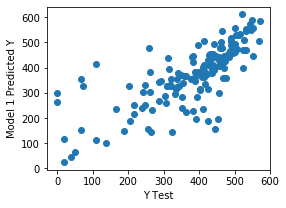

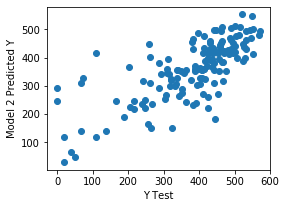

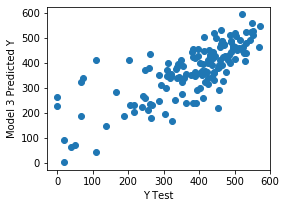

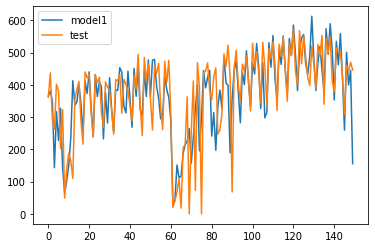

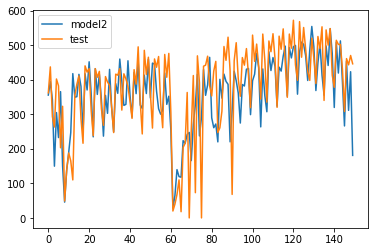

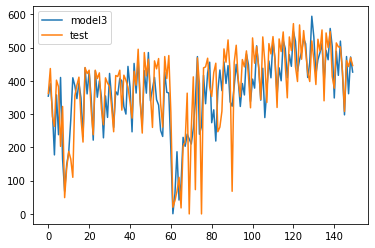

In [ ]:
from matplotlib import pyplot

plt.figure(figsize=(4,3))
plt.scatter(y_test[:200],predictions1[:200])
plt.xlabel('Y Test')
plt.ylabel('Model 1 Predicted Y')

plt.figure(figsize=(4,3))
plt.scatter(y_test[:200],predictions2[:200])
plt.xlabel('Y Test')
plt.ylabel('Model 2 Predicted Y')

plt.figure(figsize=(4,3))
plt.scatter(y_test[:200],predictions3[:200])
plt.xlabel('Y Test')
plt.ylabel('Model 3 Predicted Y')

pyplot.show()
pyplot.plot(predictions1, label='model1')
pyplot.plot(y_test, label='test')
pyplot.legend()
pyplot.show()

pyplot.plot(predictions2, label='model2')
pyplot.plot(y_test, label='test')
pyplot.legend()
pyplot.show()

pyplot.plot(predictions3, label='model3')
pyplot.plot(y_test, label='test')
pyplot.legend()
pyplot.show()

In [ ]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions3))
print('MSE:', metrics.mean_squared_error(y_test, predictions3))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions3)))

MAE: 61.71489190538724
MSE: 7112.783844666114
RMSE: 84.33732177788262


In [ ]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)
